##### Copyright 2019 The TensorFlow Authors and Geoffrey Fox 2020


In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [ ]:
# Set Runname
RunName = 'CovidA21-LSTM4Analyze'
RunComment = 'April 14 Covid 2021 Dataset; Old set of Properties; NO Validation; LSTM; Futures; 500 counties'

# Initial System Code

In [ ]:
startbold = "\033[1m"
resetfonts = "\033[0m"
startred = '\033[31m'

startpurple = '\033[35m'
startyellowbkg = '\033[43m'

!lscpu

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
else:
  print(gpu_info)

from google.colab import drive
drive.mount('/content/gdrive')

Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              4
On-line CPU(s) list: 0-3
Thread(s) per core:  2
Core(s) per socket:  2
Socket(s):           1
NUMA node(s):        1
Vendor ID:           GenuineIntel
CPU family:          6
Model:               79
Model name:          Intel(R) Xeon(R) CPU @ 2.20GHz
Stepping:            0
CPU MHz:             2199.998
BogoMIPS:            4399.99
Hypervisor vendor:   KVM
Virtualization type: full
L1d cache:           32K
L1i cache:           32K
L2 cache:            256K
L3 cache:            56320K
NUMA node0 CPU(s):   0-3
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_sin

# Transformer model for science data based on original for language understanding

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/text/transformer">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/text/transformer.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/transformer.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/text/transformer.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

## Science Data Parameters and Sizes

-------
Here is structure of science time series module. We will need several arrays that will need to be flattened at times. Note Python defaults to row major i.e. final index describes contiguous positions in memory


At highest level data is labeled by Time and Location

*   Ttot is total number of time steps
*   Tseq is length of each sequence in time steps
*   Num_Seq is number of sequences in time: Num_Seq = Ttot-Tseq + 1
*   Nloc is Number of locations. The locations could be a 1D list or have array structure such as an image.
*   Nsample is number of data samples Nloc * Num_Seq




Input data is at each location
*   Nprop time independent properties describing the location
*   Nforcing is number of time dependent forcing features INPUT at each time value


Output (predicted) data at each location and for each time sequence is
*   Npred predicted time dependent values defined at every time step
*   Recorded at Nforecast time values measured wrt final time value of sequence
*   ForecastDay is an array of length Nforecast defining how many days into future prediction is. Typically ForecastDay[0] = 1 and Nforecast is often 1
*   There is also a class of science problems that are more similar to classic Seq2Seq. Here Nforecast = Tseq and ForecastDay = [-Tseq+1 ... 0]
*   We also support Nwishful predictions of events in future such probability of an earthquake of magnitude 6 in next 3 years. These are defined by araays EventType and Timestart, TimeInterval of length Nwishful. EventType is user defined and Timestart, TimeInterval is measured in time steps
*   Any missing output values should be set to NaN and Loss function must ensure that these points are ignored in derivative calculation and value calculation

We have an input module that supports either LSTM or Transformer (multi-head attention) models

Example Problem AICov

*   Ttot = 114
*   Tseq = 9
*   Num_Seq = 106
*   Nloc = 110


*   Nprop = 35
*   Nforcing = 5 including infections, fatalities, plus 3 temporal position variables (last 3 not in current version)
 
 
*   Npred = 2 (predicted infections and fatalities). Could be 5 if predicted temporal position of output)
*   Nforecast= 15
*   ForecastDay = [1, 2, .......14, 15]
*   Nwishful = 0




















## Science Data Arrays

Typical Arrays


[ time, Location ] as Pandas array with label [name of time-dependent variable] as an array or just name of Pandas array

time labels rows indexed by datetime or the difference datetime - start

Non windowed data is stored with propert name as row index and location as column index
[ static property, Location]

Covid Input is
[Sequence number 0..Num_Seq-1 ] [ Location 0..Nloc-1 ] [position in time sequence Tseq]  [ Input Features]

Covid Output is 
[Sequence number Num_Seq ] [ Location Nloc ]  [ Output Features] 

Output Features are [ ipred = 0 ..Npred-1 ] [ iforecast = 0 ..Nforecast-1 ]

Input Features are static fields followed by if present by dynamic system fields (cos-theta sin-theta linear) chosen followed by cases, deaths. In fact this is user chosen as they set static and dynamic system properties to use

We will have various numpy and pandas arrays where we designate label

[Ttot] is all time values 

[Num_Seq]  is all sequences of window size ***Tseq***

We can select time values or sequences [Ttot-reason] [Num_Seq-reason] for a given "reason"

[Num_Seq][Tseq] is all time values in all sequences

[Nloc] is all locations while [Nloc-reason] is subset of locations for given "reason"

[Model1] is initial embedding of each data point

[Model1+TrPosEnc] is initial embedding of each data point with Transformer style positional encoding

[Nforcing] is time dependent input parameters and [Nprop] static properties while [ExPosEnc] are explicit positional (temporal) encoding.

[Nforcing+ExPosEnc+Nprop] are all possible inputs

[Npred] is predicted values with [Npred+ExPosEnc] as predictions plus encodings with actually used [Predvals] = [Npred+ExPosEnc-Selout] 

[Predtimes] = [Forecast time range] are times forecasted with "time range" separately defined



In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf
from tqdm.keras import TqdmCallback
from tqdm import tnrange, notebook, tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import Dense

import os
import gc
from csv import reader
from csv import writer
import sys
import random
import math
import numpy as np
import matplotlib.pyplot as plt
from textwrap import wrap
import pandas as pd
import io as io
import string

import time
import datetime
from datetime import timedelta,date,datetime

!pip install cloudmesh-common -U
from cloudmesh.common.StopWatch import StopWatch



     |████████████████████████████████| 81kB 5.4MB/s 
     |████████████████████████████████| 870kB 43.9MB/s 
     |████████████████████████████████| 133kB 62.8MB/s 
  Created wheel for python-hostlist: filename=python_hostlist-1.21-cp37-none-any.whl size=38931 sha256=795d7774eaf54e2c8d9569e058562db689b129ec070d4113acd8b53457849f97
  Stored in directory: /root/.cache/pip/wheels/0b/5b/55/ddcf52288f0b10f4564ca1b2531594ff7ccc65f487ba8dc437
Successfully built python-hostlist


### Define Basic Control parameters

In [ ]:
def wraptotext(textinput,size=None):
  if size is None:
    size = 120
  textlist = wrap(textinput,size)
  textresult = textlist[0]
  for itext in range(1,len(textlist)):
    textresult += '\n'+textlist[itext]
  return textresult

def timenow():
  now = datetime.now()
  return now.strftime("%m/%d/%Y, %H:%M:%S") + " UTC"

def float32fromstrwithNaN(instr):
  if instr == 'NaN':
    return NaN
  return np.float32(instr)

def printexit(exitmessage):
  print(exitmessage)
  sys.exit()

def strrnd(value):
  return str(round(value,4))

NaN = np.float32("NaN")

ReadJuly2020Covid = False
ReadAugust2020Covid = False
ReadJan2021Covid = False
ReadApril2021Covid = False
ScaleProperties = False
ConvertDynamicPredictedQuantity = False
ConvertDynamicProperties = True
GenerateFutures = False
GenerateSequences = False
PredictionsfromInputs = False
RereadMay2020 = False
UseOLDCovariates = False
Dropearlydata = 0
NIHCovariates = False 
UseFutures = True
Usedaystart = False 
PopulationNorm = False
SymbolicWindows = False
Hydrology = False
Earthquake = False
EarthquakeImagePlots = False
AddSpecialstoSummedplots = False
UseRealDatesonplots = False
Dumpoutkeyplotsaspics = False
OutputNetworkPictures = False
CDSpecial = False
NumpredbasicperTime = 2
NumpredFuturedperTime = 2
NumTimeSeriesCalculated = 0
Dailyunit = 1
TimeIntervalUnitName = 'Day'
InitialDate = datetime(2000,1,1)
NumberofTimeunits = 0
Num_Time =0
FinalDate = datetime(2000,1,1)
GlobalTrainingLoss = 0.0
GlobalValidationLoss = 0.0

# Type of Testing
LocationBasedValidation = False
LocationValidationFraction = 0.0
LocationTrainingfraction = 1.0
RestartLocationBasedValidation = False

global SeparateValandTrainingPlots
SeparateValandTrainingPlots = True
Plotsplitsize = -1 # if > 1 split time in plots

GarbageCollect = True
GarbageCollectionLimit = 0

current_time = timenow()
print(startbold + startred + current_time + ' ' +RunName + ' ' + RunComment + resetfonts)

SubName = RunName[0:6]
if SubName == 'BEST14' or SubName == 'BEST15' or SubName == 'BEST16':
  UseOLDCovariates = False
  ReadAugust2020Covid = True
  ScaleProperties = True
  ConvertDynamicPredictedQuantity = True
  GenerateFutures = True
  GenerateSequences = True
  PredictionsfromInputs = True
  NIHCovariates = True
  ConvertDynamicProperties = True
  Dropearlydata = 37
  CDSpecial = True

if SubName == 'CovidA':
  UseOLDCovariates = False
  ReadApril2021Covid = True
  ScaleProperties = True
  ConvertDynamicPredictedQuantity = True
  GenerateFutures = True
  UseFutures = True
  GenerateSequences = True
  PredictionsfromInputs = True
  NIHCovariates = True
  ConvertDynamicProperties = True
  CDSpecial = True

if SubName == 'C2021A' or SubName == 'C2021B':
  UseOLDCovariates = False
  ReadJan2021Covid = True
  ScaleProperties = True
  ConvertDynamicPredictedQuantity = True
  GenerateFutures = True
  GenerateSequences = True
  PredictionsfromInputs = True
  NIHCovariates = True
  ConvertDynamicProperties = True
  Dropearlydata = 0
  CDSpecial = True

if SubName == 'Hydrol':
  Hydrology = True

if SubName == 'EARTHQ':
  Earthquake = True

if RunName == 'BEST10' or RunName == 'BEST13-10D' or RunName == 'BEST12-10' or RunName == 'BEST12-Test' or RunName == 'BEST13' or RunName == 'BEST13-10' or RunName == 'BEST13-10A' or RunName == 'BEST13-10C':
  UseOLDCovariates = False
  ReadAugust2020Covid = True
  ScaleProperties = True
  ConvertDynamicPredictedQuantity = True
  GenerateFutures = True
  GenerateSequences = True
  PredictionsfromInputs = True
  CDSpecial = True

if RunName == 'BEST11' or RunName == 'BEST11A':
  UseOLDCovariates = True
  ReadAugust2020Covid = True
  ScaleProperties = True
  ConvertDynamicPredictedQuantity = True
  GenerateFutures = True
  GenerateSequences = True
  PredictionsfromInputs = True
  CDSpecial = True

if RunName == 'BEST12':
  UseOLDCovariates = True
  RereadMay2020 = True
  ReadAugust2020Covid = False
  ScaleProperties = True
  ConvertDynamicPredictedQuantity = True
  GenerateFutures = True
  GenerateSequences = True
  PredictionsfromInputs = True
  CDSpecial = True

if RunName == 'BEST8' or RunName == 'BEST8A' or RunName == 'BEST12-LSTM-8':
  ReadJuly2020Covid = True


05/22/2021, 21:07:03 UTC CovidA21-LSTM4Analyze April 14 Covid 2021 Dataset; Old set of Properties; NO Validation; LSTM; Futures; 500 counties


## Define input structure

Read in data and set it up for Tensorflow with training and validation


Set train_examples, val_examples as science training and validatioon set.

The shuffling of Science Data needs some care. We have ***Tseq*** * size of {[Num_Seq][Nloc]} locations in each sample. In simplease case the last is just a decomposition over location; not over time. Let's Nloc-sel be number of locations per sample. It will be helpful if Nloc-sel is divisable by 2. 

Perhaps Nloc-sel = 2 6 or 10 is reasonable.

Then you shuffle locations every epoch and divide them into groups of size Nloc-sel with 50% overlap so you get locations

0 1 2 3 4 5; 

3 4 5 6 7 8; 

6 7 8 9 10 11 etc.

Every locations appears twice in an epoch (for each time value). You need to randomly add locations at end of sequence so it is divisiuble by Nloc-sel e.g add 4 random positions to the end if Nloc=110 and Nloc-sel = 6. Note last group of 6 has members 112 113 114 0 1 2

After spatial structure set up, randomly shuffle in Num_Seq where there is an argument to do all locations for a partcular time value together.

For validation, it is probably best to select validation location before chopping them into groups of size Nloc-sel

How one groups locations for inference is not clear. One idea is to take trained network and use it to find for each location which other locations have the most attention with it. Use those locations in  prediction

More general input. 
NaN allowed value

* Number time values
* Number locations
* Number driving values
* Number predicted values

For COVID driving same as predicted

* a) Clean up >=0 daily
* b) Normalize
* c) Add Futures
* d) Add time/location encoding


### Setup File Systems

In [ ]:
# read in science data 
COLABROOTDIR="/content/gdrive/My Drive/Colab Datasets"
os.environ["COLABROOTDIR"] = COLABROOTDIR

if Hydrology:
  APPLDIR=os.path.join(COLABROOTDIR, "Hydrology")
elif Earthquake:
  APPLDIR=os.path.join(COLABROOTDIR, "EarthquakeDec2020")
else:
  APPLDIR=os.path.join(COLABROOTDIR, "COVIDJuly2020")

# Set up Checkpoints
CHECKPOINTDIR = APPLDIR + "/checkpoints/" + RunName + "dir/"
try: 
    if not os.path.exists(CHECKPOINTDIR):
      os.mkdir(CHECKPOINTDIR) 
except OSError as error: 
    print(error)
print('Checkpoint set up in directory ' + CHECKPOINTDIR)

Checkpoint set up in directory /content/gdrive/My Drive/Colab Datasets/COVIDJuly2020/checkpoints/CovidA21-LSTM4Analyzedir/


###Space Filling Curves

In [ ]:
from typing import Dict, Tuple, Optional, List, Union, Callable
import matplotlib
import matplotlib.patches as patches
# import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from matplotlib.path import Path

def cal_gilbert2d(width: int, height: int) -> List[Tuple[int, int]]:
    coordinates: List[Tuple[int, int]] = []

    def sgn(x: int) -> int:
        return (x > 0) - (x < 0)

    def gilbert2d(x: int, y: int, ax: int, ay: int, bx: int, by: int):
        """
        Generalized Hilbert ('gilbert') space-filling curve for arbitrary-sized
        2D rectangular grids.
        """

        w = abs(ax + ay)
        h = abs(bx + by)

        (dax, day) = (sgn(ax), sgn(ay))  # unit major direction
        (dbx, dby) = (sgn(bx), sgn(by))  # unit orthogonal direction

        if h == 1:
            # trivial row fill
            for i in range(0, w):
                coordinates.append((x, y))
                (x, y) = (x + dax, y + day)
            return

        if w == 1:
            # trivial column fill
            for i in range(0, h):
                coordinates.append((x, y))
                (x, y) = (x + dbx, y + dby)
            return

        (ax2, ay2) = (ax // 2, ay // 2)
        (bx2, by2) = (bx // 2, by // 2)

        w2 = abs(ax2 + ay2)
        h2 = abs(bx2 + by2)

        if 2 * w > 3 * h:
            if (w2 % 2) and (w > 2):
                # prefer even steps
                (ax2, ay2) = (ax2 + dax, ay2 + day)

            # long case: split in two parts only
            gilbert2d(x, y, ax2, ay2, bx, by)
            gilbert2d(x + ax2, y + ay2, ax - ax2, ay - ay2, bx, by)

        else:
            if (h2 % 2) and (h > 2):
                # prefer even steps
                (bx2, by2) = (bx2 + dbx, by2 + dby)

            # standard case: one step up, one long horizontal, one step down
            gilbert2d(x, y, bx2, by2, ax2, ay2)
            gilbert2d(x + bx2, y + by2, ax, ay, bx - bx2, by - by2)
            gilbert2d(x + (ax - dax) + (bx2 - dbx), y + (ay - day) + (by2 - dby), -bx2, -by2, -(ax - ax2), -(ay - ay2))

    if width >= height:
        gilbert2d(0, 0, width, 0, 0, height)
    else:
        gilbert2d(0, 0, 0, height, width, 0)
    return coordinates

def lookup_color(unique_colors, color_value: float) -> int:
      ids = np.where(unique_colors == color_value)
      color_id = ids[0][0]
      return color_id

def plot_gilbert2d_space_filling(
    vertices: List[Tuple[int, int]],
    width: int,
    height: int,
    filling_color: Optional[np.ndarray] = None,
    color_map: str = "rainbow",
    figsize: Tuple[int, int] = (12, 8),
    linewidth: int = 1,
) -> None:

    fig, ax = plt.subplots(figsize=figsize)
    patch_list: List = []

    if filling_color is None:
        cmap = matplotlib.cm.get_cmap(color_map, len(vertices))
        for i in range(len(vertices) - 1):
            path = Path([vertices[i], vertices[i + 1]], [Path.MOVETO, Path.LINETO])
            patch = patches.PathPatch(path, fill=False, edgecolor=cmap(i), lw=linewidth)
            patch_list.append(patch)
        ax.set_xlim(-1, width)
        ax.set_ylim(-1, height)

    else:
        unique_colors = np.unique(filling_color)
#        np.random.shuffle(unique_colors)
        cmap = matplotlib.cm.get_cmap(color_map, len(unique_colors))

        for i in range(len(vertices) - 1):
            x, y = vertices[i]
            fi, fj = x, height - 1 - y
            color_value = filling_color[fj, fi]
            color_id = lookup_color(unique_colors, color_value)
            path = Path(
                [rescale_xy(x, y), rescale_xy(vertices[i + 1][0], vertices[i + 1][1])], [Path.MOVETO, Path.LINETO]
            )
            # path = Path([vertices[i], vertices[i + 1]], [Path.MOVETO, Path.LINETO])
            patch = patches.PathPatch(path, fill=False, edgecolor=cmap(color_id), lw=linewidth)
            patch_list.append(patch)
        ax.set_xlim(-120 - 0.1, width / 10 - 120)
        ax.set_ylim(32 - 0.1, height / 10 + 32)

    collection = matplotlib.collections.PatchCollection(patch_list, match_original=True)
    # collection.set_array()
    # plt.colorbar(collection)
    ax.add_collection(collection)
    ax.set_aspect("equal")
    plt.show()
    return 

def rescale_xy(x: int, y: int) -> Tuple[float, float]:
    return x / 10 - 120, y / 10 + 32

def remapfaults(InputFaultNumbers, Numxlocations, Numylocations, SpaceFillingCurve):
  TotalLocations = Numxlocations*Numylocations
  OutputFaultNumbers = np.full_like(InputFaultNumbers, -1, dtype=np.int)
  MaxOldNumber = np.amax(InputFaultNumbers)
  mapping = np.full(MaxOldNumber+1, -1,dtype=np.int)
  newlabel=-1
  for sfloc in range(0, TotalLocations):
    [x,y] = SpaceFillingCurve[sfloc]
    pixellocation = y*Numxlocations + x
    pixellocation1 = y*Numxlocations + x
    oldfaultnumber = InputFaultNumbers[pixellocation1]
    if mapping[oldfaultnumber] < 0:
      newlabel += 1
      mapping[oldfaultnumber] = newlabel
    OutputFaultNumbers[pixellocation] = mapping[oldfaultnumber]
  MinNewNumber = np.amin(OutputFaultNumbers)
  if MinNewNumber < 0:
    printexit('Incorrect Fault Mapping')
  print('new Fault Labels generated 0 through ' + str(newlabel))
  plot_gilbert2d_space_filling(SpaceFillingCurve,Numxlocations, Numylocations, filling_color = np.reshape(OutputFaultNumbers,(40,60)), color_map="gist_ncar")
  return OutputFaultNumbers

def annotate_faults_ndarray(pix_faults: np.ndarray, figsize=(10, 8), color_map="rainbow"):
    matplotlib.rcParams.update(matplotlib.rcParamsDefault)
    plt.rcParams.update({"font.size": 12})
    unique_colors = np.unique(pix_faults)
    np.random.shuffle(unique_colors)
    cmap = matplotlib.cm.get_cmap(color_map, len(unique_colors))

    fig, ax = plt.subplots(figsize=figsize)
    height, width = pix_faults.shape
    for j in range(height):
        for i in range(width):
            x, y = i / 10 - 120, (height - j - 1) / 10 + 32
            ax.annotate(str(pix_faults[j, i]), (x + 0.05, y + 0.05), ha="center", va="center")
            color_id = lookup_color(unique_colors, pix_faults[j, i])
            ax.add_patch(patches.Rectangle((x, y), 0.1, 0.1, color=cmap(color_id), alpha=0.5))
    ax.set_xlim(-120, width / 10 - 120)
    ax.set_ylim(32, height / 10 + 32)
    plt.show()



###Read Earthquake Data

In [ ]:

import matplotlib.dates as mdates

def makeadateplot(plotfigure,plotpointer, Dateaxis=None, datemin=None, datemax=None, Yearly=True, majoraxis = 5):
  if not Yearly:
    sys.exit('Only yearly supported')
  plt.rcParams.update({'font.size': 9})
  years5 = mdates.YearLocator(majoraxis)   # every 5 years
  years_fmt = mdates.DateFormatter('%Y')
  plotpointer.xaxis.set_major_locator(years5)
  plotpointer.xaxis.set_major_formatter(years_fmt)
  if datemin is None:
    datemin = np.datetime64(Dateaxis[0], 'Y')
  if datemax is None:
    datemax = np.datetime64(Dateaxis[-1], 'Y') + np.timedelta64(1, 'Y')
  plotpointer.set_xlim(datemin, datemax)
  plotfigure.autofmt_xdate()
  return datemin, datemax

def makeasmalldateplot(figure,ax, Dateaxis):
  plt.rcParams.update({'font.size': 9})
  months = mdates.MonthLocator(interval=2)   # every month
  datemin = np.datetime64(Dateaxis[0], 'M')
  datemax = np.datetime64(Dateaxis[-1], 'M') + np.timedelta64(1, 'M')
  ax.set_xlim(datemin, datemax)
  
  months_fmt = mdates.DateFormatter('%y-%b')
  locator = mdates.AutoDateLocator()
  locator.intervald['MONTHLY'] = [2]
  formatter = mdates.ConciseDateFormatter(locator)
#  ax.xaxis.set_major_locator(locator)
#  ax.xaxis.set_major_formatter(formatter)
  ax.xaxis.set_major_locator(months)
  ax.xaxis.set_major_formatter(months_fmt)

  figure.autofmt_xdate()
  return datemin, datemax

def Addfixedearthquakes(plotpointer,graphmin, graphmax, ylogscale = False, quakecolor = None, Dateplot = True, vetoquake = None):
  if vetoquake is None: # Vetoquake = True means do not plot this quake
    vetoquake = np.full(numberspecialeqs, False, dtype = np.bool)
  if quakecolor is None: # Color of plot
    quakecolor = 'black'
  Place =np.arange(numberspecialeqs, dtype =np.int)
  Place[8] = 11
  Place[10] = 3
  Place[12] = 16
  Place[7] = 4
  Place[2] = 5
  Place[4] = 14
  Place[11] = 18

  ymin, ymax = plotpointer.get_ylim() # Or work with transform=ax.transAxes

  for iquake in range(0,numberspecialeqs):
    if vetoquake[iquake]:
      continue

# This is the x position for the vertical line
    if Dateplot:
      x_line_annotation = Specialdate[iquake] # numpy date format
    else:
      x_line_annotation = Numericaldate[iquake] # Float where each interval 1 and start is 0
    if (x_line_annotation < graphmin) or (x_line_annotation > graphmax):
      continue

    # This is the x position for the label
    if Dateplot:
      x_text_annotation = x_line_annotation + np.timedelta64(5*Dailyunit,'D')
    else:
      x_text_annotation = x_line_annotation + 5.0
    # Draw a line at the position
    plotpointer.axvline(x=x_line_annotation, linestyle='dashed', alpha=1.0, linewidth = 0.5, color=quakecolor)
    # Draw a text 
    if Specialuse[iquake]:
      ascii = str(round(Specialmags[iquake],1)) + '\n' + Specialeqname[iquake]
      if ylogscale:
        yminl = max(0.01*ymax,ymin)
        yminl = math.log(yminl,10)
        ymaxl = math.log(ymax,10)
        logyplot = yminl + (0.1 + 0.8*(float(Place[iquake])/float(numberspecialeqs-1)))*(ymaxl-yminl)
        yplot = pow(10, logyplot)
      else:
        yplot = ymax - (0.1 + 0.8*(float(Place[iquake])/float(numberspecialeqs-1)))*(ymax-ymin)
      if Dateplot:
        if x_text_annotation > graphmax - np.timedelta64(2000, 'D'):
          x_text_annotation = graphmax - np.timedelta64(2000, 'D')
      else:
        if x_text_annotation > graphmax - 100:
          x_text_annotation = graphmax - 100
#      print(str(yplot) + " " + str(ymin) + " " + str(ymax) + " " + str(x_text_annotation) + " " + str(x_line_annotation)) + " " + ascii
      plotpointer.text(x=x_text_annotation, y=yplot, s=wraptotext(ascii,size=10), alpha=1.0, color='black', fontsize = 6)


def quakesearch(iquake, iloc):
# see if top earthquake iquake llies near location iloc
# result = 0 NO; =1 YES Primary: locations match exactly; = -1 Secondary: locations near
# iloc is location before mapping
  xloc = iloc%60
  yloc = (iloc - xloc)/60
  if (xloc == Specialxpos[iquake]) and (yloc == Specialypos[iquake]):
    return 1
  if (abs(xloc - Specialxpos[iquake]) <= 1) and (abs(yloc - Specialypos[iquake]) <= 1):
    return -1
  return 0

# Read Earthquake Data
def log_sum_exp10(ns, sumaxis =0):  
    max_v = np.max(ns, axis=None)
    ds = ns - max_v
    sum_of_exp = np.power(10, ds).sum(axis=sumaxis)
    return max_v + np.log10(sum_of_exp)

def log_energyweightedsum(nvalue, ns, sumaxis = 0): 
    max_v = np.max(ns, axis=None)
    ds = ns - max_v
    ds = np.power(10, 1.5*ds)
    dvalue = (np.multiply(nvalue,ds)).sum(axis=sumaxis)
    ds  = ds.sum(axis=0)
    return np.divide(dvalue,ds)

# Set summed magnitude as log summed energy = 10^(1.5 magnitude)
def log_energy(mag, sumaxis =0):
    return log_sum_exp10(1.5 * mag, sumaxis = sumaxis) / 1.5
    
def AggregateEarthquakes(itime, DaysDelay, DaysinInterval, Nloc, Eqdata, Approach, weighting = None):
  if (itime + DaysinInterval + DaysDelay) > NumberofTimeunits:
    return np.full([Nloc],NaN,dtype = np.float32)
  if Approach == 0: # Magnitudes
    if MagnitudeMethod == 0:
      TotalMagnitude = log_energy(Eqdata[itime +DaysDelay:itime+DaysinInterval+DaysDelay])
    else:
      TotalMagnitude = Eqdata[itime +DaysDelay:itime+DaysinInterval+DaysDelay,:].sum(axis=0)
    return TotalMagnitude
  if Approach == 1: # Depth -- energy weighted
    WeightedResult = log_energyweightedsum(Eqdata[itime +DaysDelay:itime+DaysinInterval+DaysDelay],
                                        weighting[itime +DaysDelay:itime+DaysinInterval+DaysDelay])
    return WeightedResult
  if Approach == 2: # Multiplicity -- summed
    SimpleSum = Eqdata[itime +DaysDelay:itime+DaysinInterval+DaysDelay,:].sum(axis=0)
    return SimpleSum

def TransformMagnitude(mag):
  if MagnitudeMethod == 0:
    return mag
  if MagnitudeMethod == 1:
    return np.power(10, 0.375*(mag-3.29))
  return np.power(10, 0.75*(mag-3.29))

# Change Daily Unit
# Accumulate data in Dailyunit chunks. 
# This changes data so it looks like daily data bu really collections of chunked data.
# For earthquakes, the aggregations uses energy averaging for depth and magnitude. It just adds for multiplicity
def GatherUpData(OldInputTimeSeries):
    Skipped = NumberofTimeunits%Dailyunit
    NewInitialDate = InitialDate + timedelta(days=Skipped)
    NewNum_Time = int(Num_Time/Dailyunit)
    NewFinalDate = NewInitialDate + Dailyunit * timedelta(days=NewNum_Time-1)
    print(' Daily Unit ' +str(Dailyunit) + ' number of ' + TimeIntervalUnitName + ' Units ' + str(NewNum_Time)+ ' ' + 
         NewInitialDate.strftime("%d/%m/%Y") + ' To ' + NewFinalDate.strftime("%d/%m/%Y"))
    NewInputTimeSeries = np.empty([NewNum_Time,Nloc,NpropperTimeDynamicInput],dtype = np.float32)
    for itime in range(0,NewNum_Time):
      NewInputTimeSeries[itime,:,0] = AggregateEarthquakes(Skipped + itime*Dailyunit,0,Dailyunit, Nloc, 
                                                           BasicInputTimeSeries[:,:,0], 0)
      NewInputTimeSeries[itime,:,1] = AggregateEarthquakes(Skipped + itime*Dailyunit,0,Dailyunit, Nloc, 
                                                           BasicInputTimeSeries[:,:,1], 1, 
                                                           weighting = BasicInputTimeSeries[:,:,0])
      NewInputTimeSeries[itime,:,2] = AggregateEarthquakes(Skipped + itime*Dailyunit,0,Dailyunit, Nloc, 
                                                           BasicInputTimeSeries[:,:,2], 2)
      NewInputTimeSeries[itime,:,3] = AggregateEarthquakes(Skipped + itime*Dailyunit,0,Dailyunit, Nloc, 
                                                           BasicInputTimeSeries[:,:,3], 2)
    return NewInputTimeSeries, NewNum_Time, NewNum_Time, NewInitialDate, NewFinalDate

# Daily Read in Version
if Earthquake:
  read1950 = True
  Eigenvectors = 2
  UseEarthquakeEigenSystems = False
  Dailyunit = 14
  addwobblingposition = False
  !ls /content/gdrive/'My Drive'/'Colab Datasets'/EarthquakeDec2020
  if read1950:
    MagnitudeDataFile = APPLDIR + '/1950start/SC_1950-2019.freq-D-25567x2400-log_eng.multi.csv'
    DepthDataFile = APPLDIR + '/1950start/SC_1950-2019.freq-D-25567x2400-w_depth.multi.csv'
    MultiplicityDataFile = APPLDIR + '/1950start/SC_1950-2019.freq-D-25567x2400-n_shock.multi.csv'
    RundleMultiplicityDataFile = APPLDIR + '/1950start/SC_1950-2019.freq-D-25567x2400-n_shock-mag-3.29.multi.csv'
    NumberofTimeunits = 25567
    InitialDate = datetime(1950,1,1)
  else:
    MagnitudeDataFile = APPLDIR + '/SC_1990-2019.freq-D-10759x2400.csv'
    DepthDataFile = APPLDIR + '/SC_1990-2019.freq-D-w_depth-10759x2400.multi.csv'
    MultiplicityDataFile = APPLDIR + '/SC_1990-2019.freq-D-num_evts-10759x2400.csv'
    RundleMultiplicityDataFile = APPLDIR + '/SC_1990-2019.freq-D-10755x2400-n_shock-mag-3.29.multi.csv'
    
    NumberofTimeunits = 10759
    InitialDate = datetime(1990,1,1)
  Topearthquakesfile = APPLDIR + '/topearthquakes_20.csv'

  FaultLabelDataFile = APPLDIR + '/pix_faults_SmallJan21.csv'
  MagnitudeMethod = 0
  ReadFaultMethod = 2 # one set of x values for each input row
  Numberxpixels = 60
  Numberypixels = 40
  Numberpixels = Numberxpixels*Numberypixels
  Nloc = Numberpixels
  Nlocdimension = 2
  Nlocaxislengths = np.array((Numberxpixels,Numberypixels), ndmin = 1, dtype=int) # First row is top (north)
  vertices = cal_gilbert2d(Numberxpixels,Numberypixels)
#    print(vertices[0], vertices[1],vertices[2399], vertices[1198], vertices[1199],vertices[1200], vertices[1201])
  sfcurvelist = vertices
  plot_gilbert2d_space_filling(sfcurvelist, Numberxpixels, Numberypixels)
  
  Dropearlydata = 0
 
  FinalDate = InitialDate + timedelta(days=NumberofTimeunits-1)
  print(startbold + startred + InitialDate.strftime("%d/%m/%Y") + ' To ' + FinalDate.strftime("%d/%m/%Y") 
    + ' days ' + str(NumberofTimeunits) + resetfonts)
  print( ' Pixels ' + str(Nloc) + ' x dimension '  + str(Nlocaxislengths[0]) + ' y dimension ' + str(Nlocaxislengths[1]) )
  
 # Set up location information
  Num_Time = NumberofTimeunits
  NFIPS = Numberpixels
  Locationname = [''] * NFIPS
  Locationstate = [' '] * NFIPS
  Locationpopulation = np.ones(NFIPS, dtype=int)
  Locationfips = np.empty(NFIPS, dtype=int) # integer version of FIPs
  Locationcolumns = [] # String version of FIPS
  FIPSintegerlookup = {}
  FIPSstringlookup = {}
  for iloc in range (0, Numberpixels):
    localfips = iloc
    xvalue = localfips%Nlocaxislengths[0]
    yvalue = np.floor(localfips/Nlocaxislengths[0])
    Stringfips = str(xvalue) + ',' + str(yvalue)
    Locationcolumns.append(Stringfips)
    Locationname[iloc] = Stringfips
    Locationfips[iloc] = localfips
    FIPSintegerlookup[localfips] = localfips
    FIPSstringlookup[Stringfips] = localfips

# TimeSeries 0 magnitude 1 depth 2 Multiplicity 3 Rundle Multiplicity
  NpropperTimeDynamicInput = 4
  BasicInputTimeSeries = np.empty([Num_Time,Nloc,NpropperTimeDynamicInput],dtype = np.float32)
# StaticProps 0...NumFaultLabels-1 Fault Labels
  NumFaultLabels = 4
  BasicInputStaticProps = np.empty([Nloc,NumFaultLabels],dtype = np.float32)
  RawFaultData = np.empty(Nloc,dtype = np.int)

# Read in Magnitude Data into BasicInputTimeSeries
  with open(MagnitudeDataFile, 'r') as read_obj:
      csv_reader = reader(read_obj)
      header = next(csv_reader)
      Ftype = header[0]
      if Ftype != '':
        printexit('EXIT: Wrong header on line 1 ' + Ftype + ' of ' + MagnitudeDataFile)

      itime = 0
      for nextrow in csv_reader:
        if (len(nextrow)!=Numberpixels + 1):
          printexit('EXIT: Incorrect row length Magnitude ' + str(itime) + ' ' +str(len(nextrow)))
        localtime = nextrow[0]
        if (itime != int(localtime)):
          printexit('EXIT: Unexpected Time in Magnitude ' + localtime + ' ' +str(itime))
        for iloc in range(0, Numberpixels):
          BasicInputTimeSeries[itime,iloc,0] = TransformMagnitude(float(nextrow[iloc + 1]))
        itime += 1

  if itime != Num_Time:
    printexit('EXIT Inconsistent time lengths in Magnitude Data ' +str(itime) + ' ' + str(Num_Time))
  print('Read Magnitude data locations ' + str(Nloc) + ' Time Steps ' + str(Num_Time))
# End Reading in Magnitude data

# Read in Depth Data into BasicInputTimeSeries
  with open(DepthDataFile, 'r') as read_obj:
      csv_reader = reader(read_obj)
      header = next(csv_reader)
      Ftype = header[0]
      if Ftype != '':
        printexit('EXIT: Wrong header on line 1 ' + Ftype + ' of ' + DepthDataFile)

      itime = 0
      for nextrow in csv_reader:
        if (len(nextrow)!=Numberpixels + 1):
          printexit('EXIT: Incorrect row length Depth ' + str(itime) + ' ' +str(len(nextrow)))
        localtime = nextrow[0]
        if (itime != int(localtime)):
          printexit('EXIT: Unexpected Time in Depth ' + localtime + ' ' +str(itime))
        for iloc in range(0, Numberpixels):
          BasicInputTimeSeries[itime,iloc,1] = nextrow[iloc + 1]
        itime += 1

  if itime != Num_Time:
    printexit('EXIT Inconsistent time lengths in Depth Data ' +str(itime) + ' ' + str(Num_Time))
  print('Read Depth data locations ' + str(Nloc) + ' Time Steps ' + str(Num_Time))
# End Reading in Depth data

# Read in Multiplicity Data into BasicInputTimeSeries
  with open(MultiplicityDataFile, 'r') as read_obj:
      csv_reader = reader(read_obj)
      header = next(csv_reader)
      Ftype = header[0]
      if Ftype != '':
        printexit('EXIT: Wrong header on line 1 ' + Ftype + ' of ' + MultiplicityDataFile)

      itime = 0
      for nextrow in csv_reader:
        if (len(nextrow)!=Numberpixels + 1):
          printexit('EXIT: Incorrect row length Multiplicity ' + str(itime) + ' ' +str(len(nextrow)))
        localtime = nextrow[0]
        if (itime != int(localtime)):
          printexit('EXIT: Unexpected Time in Multiplicity ' + localtime + ' ' +str(itime))
        for iloc in range(0, Numberpixels):
          BasicInputTimeSeries[itime,iloc,2] = nextrow[iloc + 1]
        itime += 1

  if itime != Num_Time:
    printexit('EXIT Inconsistent time lengths in Multiplicity Data ' +str(itime) + ' ' + str(Num_Time))
  print('Read Multiplicity data locations ' + str(Nloc) + ' Time Steps ' + str(Num_Time))
# End Reading in Multiplicity data

# Read in Rundle Multiplicity Data into BasicInputTimeSeries
  with open(RundleMultiplicityDataFile, 'r') as read_obj:
      csv_reader = reader(read_obj)
      header = next(csv_reader)
      Ftype = header[0]
      if Ftype != '':
        printexit('EXIT: Wrong header on line 1 ' + Ftype + ' of ' + RundleMultiplicityDataFile)

      itime = 0
      for nextrow in csv_reader:
        if (len(nextrow)!=Numberpixels + 1):
          printexit('EXIT: Incorrect row length Rundle Multiplicity ' + str(itime) + ' ' +str(len(nextrow)))
        localtime = nextrow[0]
        if (itime != int(localtime)):
          printexit('EXIT: Unexpected Time in Rundle Multiplicity ' + localtime + ' ' +str(itime))
        for iloc in range(0, Numberpixels):
          BasicInputTimeSeries[itime,iloc,3] = nextrow[iloc + 1]
        itime += 1

  if itime != Num_Time:
    printexit('EXIT Inconsistent time lengths in Rundle Multiplicity Data ' +str(itime) + ' ' + str(Num_Time))
  print('Read Rundle Multiplicity data locations ' + str(Nloc) + ' Time Steps ' + str(Num_Time))
# End Reading in Rundle Multiplicity data

# Read in Top Earthquake Data
  numberspecialeqs = 20
  Specialuse = np.full(numberspecialeqs, True, dtype=bool)
  Specialuse[14] = False
  Specialuse[15] = False
  Specialuse[18] = False
  Specialuse[19] = False
  Specialmags = np.empty(numberspecialeqs, dtype=np.float32)
  Specialdepth = np.empty(numberspecialeqs, dtype=np.float32)
  Speciallong = np.empty(numberspecialeqs, dtype=np.float32)
  Speciallat = np.empty(numberspecialeqs, dtype=np.float32)
  Specialdate = np.empty(numberspecialeqs, dtype = 'datetime64[D]')
  Specialxpos = np.empty(numberspecialeqs, dtype=np.int32)
  Specialypos = np.empty(numberspecialeqs, dtype=np.int32)
  Specialeqname = []

  with open(Topearthquakesfile, 'r') as read_obj:
    csv_reader = reader(read_obj)
    header = next(csv_reader)
    Ftype = header[0]
    if Ftype != 'date':
      printexit('EXIT: Wrong header on line 1 ' + Ftype + ' of ' + Topearthquakesfile)

    iquake = 0
    for nextrow in csv_reader:
      if (len(nextrow)!=6):
        printexit('EXIT: Incorrect row length Special Earthquakes ' + str(iquake) + ' ' +str(len(nextrow)))
      Specialdate[iquake] = nextrow[0]
      Speciallong[iquake] = nextrow[1]
      Speciallat[iquake] = nextrow[2]
      Specialmags[iquake] = nextrow[3]
      Specialdepth[iquake] = nextrow[4]
      Specialeqname.append(nextrow[5])
      ixpos = math.floor((Speciallong[iquake]+120.0)*10.0)
      ixpos = max(0,ixpos)
      ixpos = min(59,ixpos)
      iypos = math.floor((36.0-Speciallat[iquake])*10.0)
      iypos = max(0,iypos)
      iypos = min(39,iypos)
      Specialxpos[iquake] = ixpos
      Specialypos[iquake] = iypos
      iquake += 1

  for iquake in range(0,numberspecialeqs):
    line = str(iquake) + ' mag ' + str(round(Specialmags[iquake],1)) + ' Lat/Long '
    line += str(round(Speciallong[iquake],2)) + ' ' + str(round(Speciallong[iquake],2)) + ' ' + np.datetime_as_string(Specialdate[iquake])
    line += Specialeqname[iquake]
    print(line)
    
  # Possibly change Unit
  current_time = timenow()
  print(startbold + startred + current_time + ' Data read in ' + RunName + ' ' + RunComment + resetfonts)
  if Dailyunit != 1:
    if Dailyunit == 14:
      TimeIntervalUnitName = 'Fortnight'
    if Dailyunit == 28:
      TimeIntervalUnitName = 'LunarMonth'
    BasicInputTimeSeries, NumberofTimeunits, Num_Time, InitialDate, FinalDate = GatherUpData(BasicInputTimeSeries)
    current_time = timenow()
    print(startbold + startred + current_time + ' Data unit changed ' +RunName + ' ' + RunComment + resetfonts)
    Dateaxis = np.empty(Num_Time, dtype = 'datetime64[D]')
    Dateaxis[0] = np.datetime64(InitialDate).astype('datetime64[D]')
    for idate in range(1,Num_Time):
      Dateaxis[idate] = Dateaxis[idate-1] + np.timedelta64(Dailyunit,'D')
    for idate in range(0,Num_Time):
      Dateaxis[idate] = Dateaxis[idate] + np.timedelta64(int(Dailyunit/2),'D')
    print('Mid unit start time ' + np.datetime_as_string(Dateaxis[0]))

    Totalmag = np.zeros(Num_Time,dtype = np.float32)
    Totalefourthroot = np.zeros(Num_Time,dtype = np.float32)
    Totalesquareroot = np.zeros(Num_Time,dtype = np.float32)
    Totaleavgedmag = np.zeros(Num_Time,dtype = np.float32)
    Totalmult = np.zeros(Num_Time,dtype = np.float32)

    Totalmag[:] = BasicInputTimeSeries[:,:,0].sum(axis=1)
    Totaleavgedmag = log_energy(BasicInputTimeSeries[:,:,0], sumaxis=1)
    Totalmult[:] = BasicInputTimeSeries[:,:,3].sum(axis=1)
    MagnitudeMethod = 1
    Tempseries = TransformMagnitude(BasicInputTimeSeries[:,:,0])
    Totalefourthroot = Tempseries.sum(axis=1)
    MagnitudeMethod = 2
    Tempseries = TransformMagnitude(BasicInputTimeSeries[:,:,0])
    Totalesquareroot = Tempseries.sum(axis=1)
    MagnitudeMethod = 0

    basenorm = Totalmult.max(axis=0)
    magnorm = Totalmag.max(axis=0)
    eavgedmagnorm = Totaleavgedmag.max(axis=0)  
    efourthrootnorm = Totalefourthroot.max(axis=0)
    esquarerootnorm = Totalesquareroot.max(axis=0)
    print('Maximum Mult ' + str(round(basenorm,2)) + ' Mag 0.15 ' + str(round(magnorm,2)) 
      + ' E-avg 0.5 ' + str(round(eavgedmagnorm,2)) + ' E^0.25 1.0 ' + str(round(efourthrootnorm,2))
      + ' E^0.5 1.0 ' + str(round(esquarerootnorm,2)) )
    Totalmag = np.multiply(Totalmag, 0.15*basenorm/magnorm)
    Totaleavgedmag = np.multiply(Totaleavgedmag, 0.5*basenorm/eavgedmagnorm)
    Totalefourthroot= np.multiply(Totalefourthroot, basenorm/efourthrootnorm)
    Totalesquareroot= np.multiply(Totalesquareroot, basenorm/esquarerootnorm)

    plt.rcParams["figure.figsize"] = [16,8]
    figure, ax = plt.subplots()
    datemin, datemax = makeadateplot(figure, ax, Dateaxis)
    ax.plot(Dateaxis, Totalmult, label='Multiplicity')
    ax.plot(Dateaxis, Totalmag, label='Summed Magnitude')
    ax.plot(Dateaxis, Totaleavgedmag, label='E-averaged Magnitude')
    ax.plot(Dateaxis, Totalefourthroot, label='Summed E^0.25')
    ax.plot(Dateaxis, Totalesquareroot, label='Summed E^0.5')
    ax.set_title('Observables summed over space')
    ax.set_xlabel("Years")
    ax.set_ylabel("Mult/Mag/Energy")
    ax.grid(True)
    ax.legend(loc='upper right')
    Addfixedearthquakes(ax, datemin, datemax)
    ax.tick_params('x', direction = 'in', length=15, width=2, which='major')
    ax.xaxis.set_minor_locator(mdates.YearLocator(1))
    ax.tick_params('x', direction = 'in', length=10, width=1, which='minor')
    figure.tight_layout()
    plt.show()

  else:
    print(' Data unit is the day and input this way')
    Dateaxis = np.empty(Num_Time, dtype = 'datetime64[D]')
    Dateaxis[0] = np.datetime64(InitialDate).astype('datetime64[D]')
    for idate in range(1,Num_Time):
      Dateaxis[idate] = Dateaxis[idate-1] + np.timedelta64(Dailyunit,'D')
    for idate in range(0,Num_Time):
      Dateaxis[idate] = Dateaxis[idate] + np.timedelta64(int(Dailyunit/2),'D')
    print('Mid unit start time ' + np.datetime_as_string(Dateaxis[0]))

# Read in Fault Label Data into BasicInputStaticProps
# No header for data
  with open(FaultLabelDataFile, 'r') as read_obj:
      csv_reader = reader(read_obj)

      iloc = 0
      if ReadFaultMethod ==1:
        for nextrow in csv_reader:
          if (len(nextrow)!=1):
            printexit('EXIT: Incorrect row length Fault Label Data ' + str(iloc) + ' ' + str(len(nextrow)))
          RawFaultData[iloc] = nextrow[0]
          iloc += 1
      else:
        for nextrow in csv_reader:
          if (len(nextrow)!=Numberxpixels):
            printexit('EXIT: Incorrect row length Fault Label Data ' + str(iloc) + ' ' + str(len(nextrow)) + ' ' + str(Numberxpixels))
          for jloc in range(0, len(nextrow)):
            RawFaultData[iloc] = nextrow[jloc]
            iloc += 1

  if iloc != Nloc:
    printexit('EXIT Inconsistent location lengths in Fault Label Data ' +str(iloc) + ' ' + str(Nloc))
  print('Read Fault Label data locations ' + str(Nloc))
# End Reading in Fault Label data

  if NumFaultLabels == 1:
    BasicInputStaticProps[:,0] = RawFaultData.astype(np.float32)
  else: # remap fault label more reasonably
    unique, counts = np.unique(RawFaultData,  return_counts=True)
    num = len(unique)
    print('Number Fault Collections ' + str(num))
#    for i in range(0,num):
#      print(str(unique[i]) + ' ' + str(counts[i]))
  
    BasicInputStaticProps[:,0] = remapfaults(RawFaultData, Numberxpixels,Numberypixels, sfcurvelist).astype(np.float32)
    pix_faults = np.reshape(BasicInputStaticProps[:,0],(40,60)).astype(np.int)
    annotate_faults_ndarray(pix_faults,figsize=(24, 16))
    sfcurvelist2 = []
    for yloc in range(0, Numberypixels):
      for xloc in range(0, Numberxpixels):
          pixellocation = yloc*Numberxpixels + xloc
          [x,y] = sfcurvelist[pixellocation]
          sfcurvelist2.append([x,39-y])
    BasicInputStaticProps[:,1] = remapfaults(RawFaultData, Numberxpixels,Numberypixels, sfcurvelist2).astype(np.float32)
    sfcurvelist3 = []
    for yloc in range(0, Numberypixels):
      for xloc in range(0, Numberxpixels):
          pixellocation = yloc*Numberxpixels + xloc
          [x,y] = sfcurvelist[pixellocation]
          sfcurvelist3.append([59-x,y])
    BasicInputStaticProps[:,2] = remapfaults(RawFaultData, Numberxpixels,Numberypixels, sfcurvelist3).astype(np.float32)
    sfcurvelist4 = []
    for yloc in range(0, Numberypixels):
      for xloc in range(0, Numberxpixels):
          pixellocation = yloc*Numberxpixels + xloc
          [x,y] = sfcurvelist[pixellocation]
          sfcurvelist4.append([59-x,39-y])
    BasicInputStaticProps[:,3] = remapfaults(RawFaultData, Numberxpixels,Numberypixels, sfcurvelist4).astype(np.float32)

  NpropperTimeDynamicCalculated = 11
  NpropperTimeDynamic = NpropperTimeDynamicInput + NpropperTimeDynamicCalculated

  NpropperTimeStatic = NumFaultLabels
#  NumpredbasicperTime = NpropperTimeDynamic
  NumpredbasicperTime = 1 # Can be 1 upto NpropperTimeDynamic
  NumpredFuturedperTime = NumpredbasicperTime

# Setup Transformed Data
  MagnitudeMethodTransform = 1
  TransformName = 'E^0.25'

  NpropperTime = NpropperTimeStatic + NpropperTimeDynamic   
  InputPropertyNames = [' '] * NpropperTime
  
  DynamicNames = ['Magnitude', 'Depth', 'Multiplicity','Mult >3.29','Mag 2/3 Month','Mag 1.5 Month','Mag 3 Months','Mag 6 Months',
                  'Mag Year',TransformName,TransformName+' 2/3 Month',TransformName+' 1.5 Month',TransformName+' 3 Months',TransformName+' 6 Months',TransformName+' Year']
  if Dailyunit == 14:
    DynamicNames = ['Magnitude 2 weeks', 'Depth 2 weeks', 'Multiplicity 2 weeks','Mult >3.29 2 weeks',
                    'Mag 4 Weeks','Mag 2 Months','Mag 3 Months','Mag 6 Months','Mag Year',
                    TransformName+ ' 2 weeks',TransformName+' 4 weeks',TransformName+' 2 Months',TransformName+' 3 Months',TransformName+' 6 Months',TransformName+' Year']
  Property_is_Intensive = np.full(NpropperTime, True, dtype = np.bool)
  for iprop in range(0, NpropperTimeStatic):
    InputPropertyNames[iprop] = 'Fault ' +str(iprop)
  for iprop in range(0, NpropperTimeDynamic):
    InputPropertyNames[iprop+NpropperTimeStatic] = DynamicNames[iprop]
  Num_Extensive = 0

  CDSpecial = False
  ScaleProperties = True
  GenerateFutures = False
  GenerateSequences = True
  PredictionsfromInputs = True
  ConvertDynamicPredictedQuantity = False
  AddSpecialstoSummedplots = True
  UseRealDatesonplots = True
  EarthquakeImagePlots = False
  UseFutures = False
  PopulationNorm = False 
  OriginalNloc = Nloc
  MapLocation = False

# Add summed magnitudes as properties to use in prediction and Calculated Properties for some
# These are sums starting at given time and are set to NaN if necessary
  NumTimeSeriesCalculatedBasic = 9
  NumTimeSeriesCalculated = 2*NumTimeSeriesCalculatedBasic + 1
  NamespredCalculated = ['Mag 2/3 Month','Mag 1.5 Month','Mag 3 Months','Mag 6 Months','Mag Year Ahead','Mag 2 Years','Mag 4 years','Mag Skip 1, Year ahead', 'Mag 2 years 2 ahead',
    TransformName+' Daily',TransformName+' 2/3 Month',TransformName+' 1.5 Month',TransformName+' 3 Months',TransformName+' 6 Months',TransformName+' Year Ahead',
    TransformName+' 2 Years',TransformName+' 4 years',TransformName+' Skip 1, Year ahead',TransformName+' 2 years 2 ahead']
  Unitjumps = [ 23, 46, 92, 183, 365, 730, 1460, 365, 730]
  Unitdelays = [ 0, 0, 0, 0, 0, 0, 0, 365, 730] 
  Plottingdelay = 1460
  if Dailyunit == 14:
    NumTimeSeriesCalculatedBasic = 9
    NumTimeSeriesCalculated = 2*NumTimeSeriesCalculatedBasic + 1
    NamespredCalculated = ['Mag 4 Weeks','Mag 2 Month','Mag 3 Months','Mag 6 Months','Mag Year Ahead','Mag 2 Years', 'Mag 4 years','Mag Skip 1, Year ahead', 'Mag 2 years 2 ahead',
      TransformName+' 2 Weeks',TransformName+' 4 Weeks',TransformName+' 2 Months',TransformName+' 3 Months',TransformName+' 6 Months',
      TransformName+' Year Ahead',TransformName+' 2 Years',TransformName+' 4 years',TransformName+' Skip 1, Year ahead',TransformName+' 2 years 2 ahead']
    Unitjumps = [ 2, 4, 7, 13, 26, 52, 104, 26, 52]
    Unitdelays = [ 0, 0, 0, 0, 0, 0, 0, 26, 52]
    Plottingdelay = 104
      
  NumpredbasicperTime  += NumTimeSeriesCalculated
  CalculatedTimeSeries = np.empty([Num_Time,Nloc,NumTimeSeriesCalculated],dtype = np.float32)
  for icalc in range (0, NumTimeSeriesCalculatedBasic):
    newicalc = icalc+1+NumTimeSeriesCalculatedBasic
    for itime in range(0,Num_Time):
      MagnitudeMethod = 0
      CalculatedTimeSeries[itime,:,icalc] = AggregateEarthquakes(itime,Unitdelays[icalc],Unitjumps[icalc], Nloc, 
                                                               BasicInputTimeSeries[:,:,0], 0)
      MagnitudeMethod = MagnitudeMethodTransform
      CalculatedTimeSeries[itime,:,newicalc] = TransformMagnitude(CalculatedTimeSeries[itime,:,icalc])
      MagnitudeMethod = 0
    current_time = timenow()
    print(startbold + startred + 'Earthquake ' + str(icalc) + ' ' + NamespredCalculated[icalc] + ' ' + current_time + ' ' +RunName + resetfonts)
    print(startbold + startred + 'Earthquake ' + str(newicalc) + ' ' + NamespredCalculated[newicalc] + ' ' + current_time + ' ' +RunName + resetfonts)
  MagnitudeMethod = MagnitudeMethodTransform
  CalculatedTimeSeries[:,:,NumTimeSeriesCalculatedBasic] = TransformMagnitude(BasicInputTimeSeries[:,:,0])
  MagnitudeMethod = 0
  print(startbold + startred + 'Earthquake ' + str(NumTimeSeriesCalculatedBasic) + ' ' + NamespredCalculated[NumTimeSeriesCalculatedBasic] + ' ' + current_time + ' ' +RunName + resetfonts)

  for iprop in range(0,NumTimeSeriesCalculated):
    InputPropertyNames.append(NamespredCalculated[iprop])


###Earthquake Eigensystems

In [ ]:
if Earthquake:
  if UseEarthquakeEigenSystems:
    !pip install scipy -U
    import scipy as sc
    import scipy.linalg as solver
    version = sc.version.version
    print('SciPy version ' + str(version))
    #x = np.array([[1,2.0],[2.0,0]])
    #w, v = solver.eigh(x,  driver='evx')
    #print(w)
    #print(v)


###Multiplicity Data

In [ ]:
def histogrammultiplicity(Type, numbins, Data):
  hitcounts = np.zeros(Nloc, dtype=np.int)
  rawcounts = np.zeros(Nloc, dtype=np.int)
  for iloc in range(0,Nloc):
    rawcounts[iloc] = np.int(0.1+Data[:,iloc].sum(0))
    hitcounts[iloc] = np.int(min(numbins, rawcounts[iloc]))
  matplotlib.rcParams.update(matplotlib.rcParamsDefault)
  plt.rcParams.update({'font.size': 9})
  plt.rcParams["figure.figsize"] = [8,6]
  plt.hist(hitcounts, numbins,  facecolor='b', alpha=0.75, log=True)
  plt.title('\n'.join(wrap(RunComment + ' ' + RunName + ' ' + Type + ' Earthquake Count per location ',70)))
  plt.xlabel('Hit Counts')
  plt.ylabel('Occurrences')
  plt.grid(True)
  plt.show()
  return rawcounts

def threebythree(pixellocation,numxlocations,numylocations):
  indices = np.empty([3,3], dtype=np.int)
  
  y = int(0.1 + pixellocation/numxlocations)
  x = pixellocation - y*numxlocations
  bottomx = max(0,x-1)
  bottomx = min(bottomx,numxlocations-3)
  bottomy = max(0,y-1)
  bottomy = min(bottomy,numylocations-3)
  for ix in range(0,3):
    for iy in range(0,3):
      x= bottomx+ix
      y= bottomy+iy
      pixellocation = y*numxlocations + x
      indices[ix,iy] = pixellocation
  return indices

if Earthquake:
  MappedLocations = np.arange(0,Nloc, dtype=np.int)
  LookupLocations = np.arange(0,Nloc, dtype=np.int)
  MappedNloc = Nloc
  histogrammultiplicity('Basic', 100, BasicInputTimeSeries[:,:,2])
  nbins = 10
  if read1950:
    nbins= 20
  rawcounts1 = histogrammultiplicity('Rundle > 3.29', nbins, BasicInputTimeSeries[:,:,3])
  TempTimeSeries = np.zeros([Num_Time,Nloc],dtype = np.float32)
  for iloc in range (0,Nloc):
    indices = threebythree(iloc,60,40)
    for itime in range(0,Num_Time):
      sum3by3 = 0.0
      for ix in range(0,3):
        for iy in range(0,3):
          pixellocation = indices[ix,iy]
          sum3by3 += BasicInputTimeSeries[itime,pixellocation,3]
      TempTimeSeries[itime,iloc] = sum3by3
  nbins =40
  if read1950:
    nbins= 60
  rawcounts2 = histogrammultiplicity('3x3 Rundle > 3.29', nbins, TempTimeSeries)
#
# Define "Interesting Locations"
  if read1950:
    singleloccut = 7.1
    groupedloccut = 34.1
#    groupedloccut = 1000000000
  else:
    singleloccut = 5.1
    groupedloccut = 24.9
  MappedLocations.fill(-1)
  MappedNloc = 0
  ct1 = 0
  ct2 = 0
  for iloc in range (0,Nloc):
    if rawcounts1[iloc] >= singleloccut:
      ct1 += 1
    if rawcounts2[iloc] >= groupedloccut:
      ct2 += 1
    if rawcounts1[iloc] < singleloccut and rawcounts2[iloc] < groupedloccut:
      continue
    MappedLocations[iloc] = MappedNloc
    MappedNloc += 1

  LookupLocations = None
  LookupLocations = np.empty(MappedNloc, dtype=np.int)
  for iloc in range (0,Nloc):
    jloc = MappedLocations[iloc]
    if jloc >= 0:
      LookupLocations[jloc] = iloc

  TempTimeSeries = None
  print('Total ' + str(MappedNloc) + ' Single location multiplicity cut ' + str(singleloccut) + 
  ' ' + str(ct1) + ' 3x3 ' + str(groupedloccut) + ' ' + str(ct2))

  if UseEarthquakeEigenSystems:
    if Eigenvectors > 0:
      UseTopEigenTotal = 16
      UseTopEigenLocal = 0
      if Eigenvectors > 1:
        UseTopEigenLocal = 4
      Num_EigenProperties = UseTopEigenTotal + UseTopEigenLocal
      EigenTimeSeries =  np.empty([Num_Time,MappedNloc],dtype = np.float32)
      PsiTimeSeries =  np.empty([Num_Time,MappedNloc],dtype = np.float32)
      FiTimeSeries =  np.empty([Num_Time,MappedNloc],dtype = np.float32)
      EigenTimeSeries[:,:] = BasicInputTimeSeries[:,LookupLocations,3]
      StoreEigenvectors = np.zeros([Num_Time,MappedNloc,MappedNloc],dtype = np.float32)
      StoreEigencorrels = np.zeros([Num_Time,MappedNloc,MappedNloc],dtype = np.float32)
      StoreNormingfactor = np.zeros([Num_Time],dtype = np.float32)
      StoreNormingfactor1 = np.zeros([Num_Time],dtype = np.float32)
      StoreNormingfactor2 = np.zeros([Num_Time],dtype = np.float32)
      current_time = timenow()
      print(startbold + startred + 'Start Eigen Earthquake ' 
       + current_time + ' ' +RunName + resetfonts)
  
      for itime in range (0,Num_Time):
        imax = itime
        imin = max(0, imax-25)
        Result =  np.zeros(MappedNloc, dtype = np.float64)
        Result = AggregateEarthquakes(imin,0,imax-imin+1, MappedNloc, EigenTimeSeries[:,:], 2)
        PsiTimeSeries[itime,:] = Result
        FiTimeSeries[itime,:] = EigenTimeSeries[itime,:]
      
      current_time = timenow()
      print(startbold + startred + 'End Eigen Earthquake 1 ' 
       + current_time + ' ' +RunName + resetfonts)
      Eigenvals = np.zeros([Num_Time,MappedNloc], dtype = np.float32)
      Chi1 = np.zeros(Num_Time, dtype = np.float32)
      Chi2 = np.zeros(Num_Time, dtype = np.float32)
      Sumai = np.zeros(Num_Time, dtype = np.float32)
      Bestindex = np.zeros(Num_Time, dtype = np.int)
      Numbereigs = np.zeros(Num_Time, dtype = np.int)
      Besttrailingindex = np.zeros(Num_Time, dtype = np.int)
      Eig0coeff = np.zeros(Num_Time, dtype = np.float32)
      meanmethod = 0
      if meanmethod == 1:
        Meanovertime = np.empty(MappedNloc, dtype = np.float32)
        sigmaovertime = np.empty(MappedNloc, dtype = np.float32)
        Meanovertime = FiTimeSeries.mean(axis=0)
        Meanovertime = Meanovertime.reshape(1,MappedNloc)
        sigmaovertime = FiTimeSeries.std(axis=0)
        sigmaovertime = sigmaovertime.reshape(1,MappedNloc)
      countbad = 0
      OldActualNumberofLocationsUsed = -1
      for itime in range (25,Num_Time):
        LocationCounts = FiTimeSeries[0:itime,:].sum(axis=0)
        NumLocsToday = np.count_nonzero(LocationCounts)
        Nonzeromapping =  np.zeros(NumLocsToday, dtype = np.int)
        ActualNumberofLocationsUsed = 0
        for ipos in range (0,MappedNloc):
          if LocationCounts[ipos] == 0:
            continue
          Nonzeromapping[ActualNumberofLocationsUsed] = ipos
          ActualNumberofLocationsUsed +=1
        if ActualNumberofLocationsUsed <= 1:
          print(str(itime) + ' Abandoned ' + str(ActualNumberofLocationsUsed))
          continue
        FiHatTimeSeries = np.empty([itime+1,ActualNumberofLocationsUsed], dtype = np.float32)
        if meanmethod == 1:
          FiHatTimeSeries[:,:] = np.divide(np.subtract(FiTimeSeries[0:(itime+1),Nonzeromapping],Meanovertime[0,Nonzeromapping]),
                                   sigmaovertime[0,Nonzeromapping])
        else:
          FiHatTimeSeries[:,:] = FiTimeSeries[0:(itime+1),Nonzeromapping]
#          FiHatTimeSeries[:,:] = PsiTimeSeries[0:(itime+1),Nonzeromapping]
        CorrelationMatrix = np.corrcoef(FiHatTimeSeries, rowvar =False)
        bad = np.count_nonzero(np.isnan(CorrelationMatrix))
        if bad > 0:
          countbad += 1
          continue
        evalues, evectors = solver.eigh(CorrelationMatrix)
        Newevector = evectors[:,ActualNumberofLocationsUsed-1] 
        Newevalue = evalues[ActualNumberofLocationsUsed-1]
        debug = False
        if debug:
          if OldActualNumberofLocationsUsed == ActualNumberofLocationsUsed:
            Mapdiff = np.where(np.not_equal(OldNonzeromapping,Nonzeromapping),1,0.).sum()
            if Mapdiff > 0: 
              print(str(itime) + ' Change in mapping ' + str(ActualNumberofLocationsUsed) + ' Change ' + str(Mapdiff))
            else:
              Corrdiff =  np.absolute(np.subtract(OldCorrelationMatrix,CorrelationMatrix)).sum()
              Corrorg = np.absolute(CorrelationMatrix).sum()
              yummy = CorrelationMatrix.dot(Oldevector)
              vTMv = yummy.dot(Oldevector)
              Doubleyummy = CorrelationMatrix.dot(Newevector)
              newvTMv = Doubleyummy.dot(Newevector)
              print(str(itime) + ' Change in correlation ' + str(ActualNumberofLocationsUsed) + ' Change '
              + str(Corrdiff) + ' original ' + str(Corrorg) + ' eval ' + str(Oldevalue) + ' new '
                + str(Newevalue) + ' vTMv ' + str(vTMv) + ' New ' + str(newvTMv))   

          else:
            print(str(itime) + ' Change in size ' + str(OldActualNumberofLocationsUsed) + ' ' +
                  str(ActualNumberofLocationsUsed))
        
        OldActualNumberofLocationsUsed = ActualNumberofLocationsUsed
        OldNonzeromapping = Nonzeromapping
        OldCorrelationMatrix = CorrelationMatrix
        Oldevector = Newevector
        Oldevalue = Newevalue
        
        normcoeff = 100.0/evalues.sum()
        evalues = np.multiply(evalues, normcoeff)
        Numbereigs[itime] = ActualNumberofLocationsUsed
 
        for ieig in range(0,ActualNumberofLocationsUsed):
          Eigenvals[itime, ieig] = evalues[ActualNumberofLocationsUsed-ieig-1]
        chival = 0.0
        sumaieig = 0.0
        Checkvector = np.zeros(ActualNumberofLocationsUsed,dtype = np.float32)
        largesteigcoeff = -1.0
        largestindex = -1

        Keepaisquared = np.zeros(ActualNumberofLocationsUsed, dtype=np.float32)
        for ieig in range(0,ActualNumberofLocationsUsed):
          aieig = 0.0
          backwards = ActualNumberofLocationsUsed-ieig-1
          for vectorindex in range(0,ActualNumberofLocationsUsed):
            StoreEigenvectors[itime,backwards,Nonzeromapping[vectorindex]] = evectors[vectorindex,ieig]
            aieig += evectors[vectorindex,ieig]*PsiTimeSeries[itime,Nonzeromapping[vectorindex]]
          for vectorindex in range(0,ActualNumberofLocationsUsed):
            Checkvector[vectorindex] += aieig*evectors[vectorindex, ieig]
          aieig *= aieig
          chival += aieig*evalues[ieig]
          sumaieig += aieig
          Keepaisquared[backwards] = aieig

        for ieig in range(0,ActualNumberofLocationsUsed): 
          backwards = ActualNumberofLocationsUsed-ieig-1 
          aieig = Keepaisquared[backwards]
          aieig = aieig/sumaieig
          if backwards == 0:
            Eig0coeff[itime] = aieig
          test = evalues[ieig]*aieig
          if test > largesteigcoeff:
            largesteigcoeff = test
            largestindex = backwards
        Bestindex[itime] = largestindex

        discrep = 0.0
        for vectorindex in range(0,ActualNumberofLocationsUsed):
          discrep += pow(Checkvector[vectorindex] - PsiTimeSeries[itime,Nonzeromapping[vectorindex]], 2)
        if discrep > 0.01:
          print('Eigendecomposition Failure ' + str(itime) + ' ' + str(discrep))
        Chi1[itime] = chival
        Chi2[itime] = chival/sumaieig
        Sumai[itime] = sumaieig

        largesteigcoeff = -1.0
        largestindex = -1
        sumaieig = 0.0
        Trailingtimeindex = itime-3
        if itime > 40:
          Trailinglimit = Numbereigs[Trailingtimeindex]
          KeepTrailingaisquared = np.zeros(Trailinglimit, dtype=np.float32)
          for ieig in range(0,Trailinglimit):
            aieig = 0.0
            for vectorindex in range(0,MappedNloc):
#              aieig += StoreEigenvectors[Trailingtimeindex,ieig,vectorindex]*PsiTimeSeries[itime,vectorindex]
              aieig += StoreEigenvectors[Trailingtimeindex,ieig,vectorindex]*StoreEigenvectors[itime,
                                                                                               Bestindex[itime],vectorindex]
            aieig *= aieig
            sumaieig += aieig
            KeepTrailingaisquared[ieig] = aieig

          for ieig in range(0,Trailinglimit): 
            aieig = KeepTrailingaisquared[ieig]
            aieig = aieig/sumaieig
            test = Eigenvals[Trailingtimeindex, ieig]*aieig
            if test > largesteigcoeff:
              largesteigcoeff = test
              largestindex = ieig
          Besttrailingindex[itime] = largestindex



        if itime >40: # Calculate eigenvector tracking
          Leader = StoreEigenvectors[itime,:,:]
          Trailer = StoreEigenvectors[itime-3,:,:]
          StoreEigencorrels[itime,:,:] = np.tensordot(Leader,Trailer,((1),(1)))
          StrippedDown = StoreEigencorrels[itime,Bestindex[itime],:]
          Normingfactor =  np.multiply(StrippedDown,StrippedDown).sum()
          Normingfactor1 =  np.multiply(StrippedDown[0:8],StrippedDown[0:8]).sum()
          Normingfactor2 =  np.multiply(StrippedDown[0:30],StrippedDown[0:30]).sum()
          StoreNormingfactor[itime] = Normingfactor
          StoreNormingfactor1[itime] = Normingfactor1
          StoreNormingfactor2[itime] = Normingfactor2

      averagesumai = Sumai.mean()
      Chi1 = np.divide(Chi1,averagesumai)
      print('Bad Correlation Matrices ' + str(countbad))
      print(startbold + startred + 'End Eigen Earthquake 2 ' 
       + current_time + ' ' +RunName + resetfonts)

    



In [ ]:
def makeasmalldateplot(figure,ax, Dateaxis):
  plt.rcParams.update({'font.size': 9})
  months = mdates.MonthLocator(interval=2)   # every month
  datemin = np.datetime64(Dateaxis[0], 'M')
  datemax = np.datetime64(Dateaxis[-1], 'M') + np.timedelta64(1, 'M')
  ax.set_xlim(datemin, datemax)
  
  months_fmt = mdates.DateFormatter('%y-%b')
  locator = mdates.AutoDateLocator()
  locator.intervald['MONTHLY'] = [2]
  formatter = mdates.ConciseDateFormatter(locator)
#  ax.xaxis.set_major_locator(locator)
#  ax.xaxis.set_major_formatter(formatter)
  ax.xaxis.set_major_locator(months)
  ax.xaxis.set_major_formatter(months_fmt)

  figure.autofmt_xdate()
  return datemin, datemax
  
def plotquakeregions(HalfSize,xaxisdates, SetofPlots, Commontitle, ylabel, SetofColors, Startx, ncols):
  numplotted = SetofPlots.shape[1]
  totusedquakes = 0
  for iquake in range(0,numberspecialeqs):
    x_line_index = Specialindex[iquake]
    if (x_line_index <= Startx) or (x_line_index >= Num_Time-1):
      continue 
    if Specialuse[iquake]:
      totusedquakes +=1
  nrows = math.ceil(totusedquakes/ncols)
  sortedquakes = np.argsort(Specialindex)

  jplot = 0
  kplot = -1
  for jquake in range(0,numberspecialeqs):
    iquake = sortedquakes[jquake]
    if not Specialuse[iquake]:
      continue
    x_line_annotation = Specialdate[iquake]
    x_line_index = Specialindex[iquake]
    if (x_line_index <= Startx) or (x_line_index >= Num_Time-1):
      continue 
    
    kplot +=1
    if kplot == ncols:
      
      plt.savefig(APPLDIR +'/Outputs/QRegions' + str(jplot) +RunName + '.png ',format='png')
      plt.show()
      kplot = 0
      jplot +=1
    if kplot == 0:
        plt.rcParams["figure.figsize"] = [16,6]
        figure, axs = plt.subplots(nrows=1, ncols=ncols, squeeze=False)

    beginplotindex = x_line_index - HalfSize
    beginplotindex = max(beginplotindex, Startx)
    endplotindex = x_line_index  + HalfSize
    endplotindex = min(endplotindex, Num_Time-1)

    eachplt = axs[0,kplot]
    ascii = ''      
    if Specialuse[iquake]:
      ascii = np.datetime_as_string(Specialdate[iquake]) + ' ' + str(round(Specialmags[iquake],1)) + ' ' + Specialeqname[iquake]
    eachplt.set_title(str(iquake) + ' ' + RunName + ' Best Eigenvalue (Black) Trailing (Red) \n' + ascii)
    datemin, datemax = makeasmalldateplot(figure, eachplt, xaxisdates[beginplotindex:endplotindex+1])
    for curves in range(0,numplotted):
      eachplt.plot(xaxisdates[beginplotindex:endplotindex+1], SetofPlots[beginplotindex:endplotindex+1,curves], 
                    'o', color=SetofColors[curves], markersize =1) 
    
    ymin, ymax = eachplt.get_ylim() 
    if ymax >= 79.9:
      ymax = 82
    eachplt.set_ylim(bottom=-1.0, top=max(ymax,20))
    eachplt.set_ylabel(ylabel)
    eachplt.set_xlabel('Time')
    eachplt.grid(True)
    eachplt.set_yscale("linear")
    eachplt.axvline(x=x_line_annotation, linestyle='dashed', alpha=1.0, linewidth = 2.0, color='red')
    for kquake in range(0,numberspecialeqs):
      if not Specialuse[kquake]:
        continue
      if kquake == iquake:
        continue
      anotherx_line_index = Specialindex[kquake]
      if (anotherx_line_index < beginplotindex) or (anotherx_line_index >= endplotindex):
        continue
      eachplt.axvline(x=Specialdate[kquake], linestyle='dashed', alpha=1.0, linewidth = 1.0, color='purple')
    eachplt.tick_params('x', direction = 'in', length=15, width=2, which='major')

 
  plt.savefig(APPLDIR +'/Outputs/QRegions' + str(jplot) +RunName + '.png ',format='png')
  plt.show()

EigenAnalysis = False
if Earthquake and EigenAnalysis:

  UseTopEigenTotal = 40
  FirstTopEigenTotal = 10
  PLTlabels = []
  for ieig in range(0,UseTopEigenTotal):
    PLTlabels.append('Eig-' + str(ieig))

  plt.rcParams["figure.figsize"] = [12,10]
  figure, ax = plt.subplots()
  datemin, datemax = makeadateplot(figure, ax, Dateaxis[26:])
  plt.rcParams["figure.figsize"] = [12,10]
  for ieig in range(0,FirstTopEigenTotal):
    ax.plot(Dateaxis[26:],np.maximum(Eigenvals[26:, ieig],0.1))
  
  ax.set_title(RunName + ' Multiplicity Eigenvalues')
  ax.set_ylabel('Eigenvalue')
  ax.set_xlabel('Time')
  ax.set_yscale("log")
  ax.grid(True)
  ax.legend(PLTlabels[0:FirstTopEigenTotal], loc='upper right')
  Addfixedearthquakes(ax, datemin, datemax,ylogscale=True )
  ax.tick_params('x', direction = 'in', length=15, width=2, which='major')
  ax.xaxis.set_minor_locator(mdates.YearLocator(1))
  ax.tick_params('x', direction = 'in', length=10, width=1, which='minor')
  plt.show()

  plt.rcParams["figure.figsize"] = [12,10]
  figure, ax = plt.subplots()
  datemin, datemax = makeadateplot(figure, ax, Dateaxis[26:])
  plt.rcParams["figure.figsize"] = [12,10]
  for ieig in range(FirstTopEigenTotal,UseTopEigenTotal):
    ax.plot(Dateaxis[26:],np.maximum(Eigenvals[26:, ieig],0.1))
  
  ax.set_title(RunName + ' Multiplicity Eigenvalues')
  ax.set_ylabel('Eigenvalue')
  ax.set_xlabel('Time')
  ax.set_yscale("linear")
  ax.grid(True)
  ax.legend(PLTlabels[FirstTopEigenTotal:], loc='upper right')
  Addfixedearthquakes(ax, datemin, datemax,ylogscale=False )
  ax.tick_params('x', direction = 'in', length=15, width=2, which='major')
  ax.xaxis.set_minor_locator(mdates.YearLocator(1))
  ax.tick_params('x', direction = 'in', length=10, width=1, which='minor')
  plt.show()

  ShowEigencorrels = False
  if ShowEigencorrels:
    for mastereig in range(0, UseTopEigenTotal):
      figure, ax = plt.subplots()
      plt.rcParams["figure.figsize"] = [12,8]
      datemin, datemax = makeadateplot(figure, ax, Dateaxis[26:])
      for ieig in range(0,UseTopEigenTotal):
        alpha = 1.0
        width = 3
        if ieig == mastereig:
          alpha=0.5
          width = 1
        ax.plot(Dateaxis[26:],np.power(StoreEigencorrels[26:,mastereig,ieig],2), alpha=alpha, linewidth = width)
      ax.set_title(RunName + ' Eigenvalue ' + str(mastereig) + ' Current versus Past Total Correlation')
      ax.set_ylabel('Norm')
      ax.set_xlabel('Time')
      ax.grid(True)
      ax.legend(PLTlabels, loc='upper right')
      Addfixedearthquakes(ax, datemin, datemax,ylogscale=False )
      ax.tick_params('x', direction = 'in', length=15, width=2, which='major')
      ax.xaxis.set_minor_locator(mdates.YearLocator(1))
      ax.tick_params('x', direction = 'in', length=10, width=1, which='minor')
      plt.show()

  figure, ax = plt.subplots()
  plt.rcParams["figure.figsize"] = [12,8]
  datemin, datemax = makeadateplot(figure, ax, Dateaxis[26:])
  alpha = 1.0
  width = 0.5
  ax.plot(Dateaxis[26:],StoreNormingfactor[26:], alpha=alpha, linewidth = width)
  ax.set_title(RunName + ' Eigenvalue Full Norming Factor with Past')
  ax.set_ylabel('Norming Factor')
  ax.set_xlabel('Time')
  ax.grid(True)
  Addfixedearthquakes(ax, datemin, datemax,ylogscale=False )
  ax.tick_params('x', direction = 'in', length=15, width=2, which='major')
  ax.xaxis.set_minor_locator(mdates.YearLocator(1))
  ax.tick_params('x', direction = 'in', length=10, width=1, which='minor')
  plt.show()

  figure, ax = plt.subplots()
  plt.rcParams["figure.figsize"] = [12,8]
  datemin, datemax = makeadateplot(figure, ax, Dateaxis[26:])
  alpha = 1.0
  width = 0.5
  ax.plot(Dateaxis[26:],StoreNormingfactor1[26:], alpha=alpha, linewidth = width)
  ax.set_title(RunName + ' Eigenvalue First 8 Norming Factor with Past')
  ax.set_ylabel('Norming Factor')
  ax.set_xlabel('Time')
  ax.grid(True)
  Addfixedearthquakes(ax, datemin, datemax,ylogscale=False )
  ax.tick_params('x', direction = 'in', length=15, width=2, which='major')
  ax.xaxis.set_minor_locator(mdates.YearLocator(1))
  ax.tick_params('x', direction = 'in', length=10, width=1, which='minor')
  plt.show()

  figure, ax = plt.subplots()
  plt.rcParams["figure.figsize"] = [12,8]
  datemin, datemax = makeadateplot(figure, ax, Dateaxis[26:])
  alpha = 1.0
  width = 0.5
  ax.plot(Dateaxis[26:],StoreNormingfactor2[26:], alpha=alpha, linewidth = width)
  ax.set_title(RunName + ' Eigenvalue First 30 Norming Factor with Past')
  ax.set_ylabel('Norming Factor')
  ax.set_xlabel('Time')
  ax.grid(True)
  Addfixedearthquakes(ax, datemin, datemax,ylogscale=False )
  ax.tick_params('x', direction = 'in', length=15, width=2, which='major')
  ax.xaxis.set_minor_locator(mdates.YearLocator(1))
  ax.tick_params('x', direction = 'in', length=10, width=1, which='minor')
  plt.show()

  figure, ax = plt.subplots()
  plt.rcParams["figure.figsize"] = [12,8]
  datemin, datemax = makeadateplot(figure, ax, Dateaxis[26:])
  plt.rcParams["figure.figsize"] = [12,8]
  ax.plot(Dateaxis[26:],Chi1[26:])

  ax.set_title(RunName + ' Correlations Normalized on average over time')
  ax.set_ylabel('Chi1')
  ax.set_xlabel('Time')
  ax.grid(True)
  Addfixedearthquakes(ax, datemin, datemax)
  ax.tick_params('x', direction = 'in', length=15, width=2, which='major')
  ax.xaxis.set_minor_locator(mdates.YearLocator(1))
  ax.tick_params('x', direction = 'in', length=10, width=1, which='minor')
  ax.set_yscale("linear")
  plt.show()

  figure, ax = plt.subplots()
  datemin, datemax = makeadateplot(figure, ax, Dateaxis[26:])
  plt.rcParams["figure.figsize"] = [12,8]
  ax.plot(Dateaxis[26:],Chi2[26:])

  ax.set_title(RunName + ' Correlations Normalized at each time')
  ax.set_ylabel('Chi2')
  ax.set_xlabel('Time')
  ax.grid(True)
  Addfixedearthquakes(ax, datemin, datemax)
  ax.tick_params('x', direction = 'in', length=15, width=2, which='major')
  ax.xaxis.set_minor_locator(mdates.YearLocator(1))
  ax.tick_params('x', direction = 'in', length=10, width=1, which='minor')
  ax.set_yscale("linear")
  plt.show()

  figure, ax = plt.subplots()
  datemin, datemax = makeadateplot(figure, ax, Dateaxis[26:])
  plt.rcParams["figure.figsize"] = [12,8]
  norm = np.amax(Chi1[26:])
  Maxeig = 80
 # ax.plot(Dateaxis[26:],Chi1[26:]*Maxeig/norm)
  ax.plot(Dateaxis[26:], 0.5 + np.minimum(Maxeig, Bestindex[26:]), 'o', color='black', markersize =1)
  ax.plot(Dateaxis[26:], np.minimum(Maxeig, Besttrailingindex[26:]), 'o', color='red', markersize =1)
  
  ax.set_title(RunName + ' Best Eigenvalue (Black) Trailing (Red)')
  ax.set_ylabel('Eig#')
  ax.set_xlabel('Time')
  ax.grid(True)
  Addfixedearthquakes(ax, datemin, datemax)
  ax.tick_params('x', direction = 'in', length=15, width=2, which='major')
  ax.xaxis.set_minor_locator(mdates.YearLocator(1))
  ax.tick_params('x', direction = 'in', length=10, width=1, which='minor')
  ax.set_yscale("linear")
  plt.show()

  SetofPlots = np.empty([len(Bestindex),2], dtype=np.float32)
  SetofPlots[:,0] = 0.5 + np.minimum(Maxeig, Bestindex[:])
  SetofPlots[:,1] = np.minimum(Maxeig, Besttrailingindex[:])
  SetofColors = ['black',  'red']
  plotquakeregions(25, Dateaxis, SetofPlots,
              RunName + ' Best Eigenvalue (Black) Trailing (Red)', 'Eig#', SetofColors, 26,2)

  plt.rcParams["figure.figsize"] = [12,8]
  figure, ax = plt.subplots()
  datemin, datemax = makeadateplot(figure, ax, Dateaxis[26:])
  ax.plot(Dateaxis[26:], Eig0coeff[26:], 'o', color='black', markersize =2)
  ymin, ymax = ax.get_ylim() 
  ax.plot(Dateaxis[26:], Chi1[26:]*ymax/norm)
  
  ax.set_title(RunName + ' Fraction Largest Eigenvalue')
  ax.set_ylabel('Eig 0')
  ax.set_xlabel('Time')
  ax.grid(True)
  Addfixedearthquakes(ax, datemin, datemax)
  ax.tick_params('x', direction = 'in', length=15, width=2, which='major')
  ax.xaxis.set_minor_locator(mdates.YearLocator(1))
  ax.tick_params('x', direction = 'in', length=10, width=1, which='minor')
  ax.set_yscale("linear")
  plt.show()


###End of Earthquake. Reset Timing

In [ ]:
# Reset Start Date by a year so first entry has a 365 day sample ending at that day and so can be made an input as can all
# lower time intervals
# Do NOT include 2 year or 4 year in input stream
# So we reset start date by one year skipping first 364 daya except to calculate the first one year (and lower limit) observables
# Time indices go from 0 to NumberofTimeunits-1
# Sequence Indices go from Begin to Begin+Tseq-1 where Begin goes from 0 to NumberofTimeunits-1-Tseq
# So Num_Seq = Numberodays-Tseq and Begin has  Num_Seq values

if Earthquake:
  SkipTimeUnits = 364
  if Dailyunit == 14:
    SkipTimeUnits = 25
  Num_Time_old = NumberofTimeunits
  NumberofTimeunits = NumberofTimeunits - SkipTimeUnits
  Num_Time = NumberofTimeunits
  InitialDate = InitialDate  + timedelta(days=SkipTimeUnits*Dailyunit)
  FinalDate = InitialDate + timedelta(days=(NumberofTimeunits-1)*Dailyunit)
  print('Skip ' +str(SkipTimeUnits) + ' New dates: ' + InitialDate.strftime("%d/%m/%Y") + ' To '
   + FinalDate.strftime("%d/%m/%Y")+ ' days ' + str(NumberofTimeunits*Dailyunit))


  DynamicPropertyTimeSeries =  np.empty([Num_Time,Nloc,NpropperTimeDynamic],dtype = np.float32)
  CountNaN = np.zeros(NpropperTimeDynamic, dtype=np.int)
  # Skewtime makes certain propert ENDS at given cell and is the cell itself if size = DailyUnit
  SkewTime = [0] * NpropperTimeDynamicInput
  if Dailyunit == 1:
    SkewTime = SkewTime + [22,45,91,182,364,0,22,45,91,182,364]
  if Dailyunit == 14:
    SkewTime = SkewTime + [1, 3, 6, 12, 25,0,1, 3, 6, 12, 25]
  for itime in range(0,NumberofTimeunits):
    for iloc in range(0,Nloc):
      for iprop in range(0,NpropperTimeDynamic):
        addtime = SkipTimeUnits - SkewTime[iprop]
        if iprop < NpropperTimeDynamicInput:
          localval = BasicInputTimeSeries[itime+addtime,iloc,iprop]
        elif iprop < (NpropperTimeDynamic-5):
          localval = CalculatedTimeSeries[itime+addtime,iloc,iprop-NpropperTimeDynamicInput]
        else:
          localval = CalculatedTimeSeries[itime+addtime,iloc,iprop-NpropperTimeDynamicInput+4]
        if np.math.isnan(localval):
          localval = NaN
          CountNaN[iprop] +=1
        DynamicPropertyTimeSeries[itime,iloc,iprop] = localval
  print(startbold+startred+'Input NaN values ' + resetfonts)

  # Add E^0.25 Input Quantities
  MagnitudeMethod = MagnitudeMethodTransform
  jprop = 9 
  for iprop in range(0,9):
    line = ''
    if iprop == 0 or iprop > 3:
      DynamicPropertyTimeSeries[:,:,jprop] = TransformMagnitude(DynamicPropertyTimeSeries[:,:,iprop])
      jprop += 1
      line = ' New ' + str(jprop) + ' ' + InputPropertyNames[jprop+NpropperTimeStatic] + ' NaN ' + str(CountNaN[iprop]) 
    print(str(iprop) + ' ' + InputPropertyNames[iprop+NpropperTimeStatic] + ' NaN ' + str(CountNaN[iprop]) + line)
    
  NpropperTimeDynamic = jprop
  MagnitudeMethod = 0

  NewCalculatedTimeSeries =  np.empty([Num_Time,Nloc,NumTimeSeriesCalculated],dtype = np.float32)
#  NewCalculatedTimeSeries = CalculatedTimeSeries[SkipTimeUnits:Num_Time+SkipTimeUnits]
  NewCalculatedTimeSeries = TransformMagnitude(CalculatedTimeSeries[SkipTimeUnits:Num_Time+SkipTimeUnits])
  CalculatedTimeSeries = None
  CalculatedTimeSeries = NewCalculatedTimeSeries
  BasicInputTimeSeries = None
  if GarbageCollect:
    gc.collect()

  MagnitudeMethod = 0

  current_time = timenow()
  print(startbold + startred + 'Earthquake Setup ' + current_time + ' ' +RunName + ' ' + RunComment + resetfonts)



###Set Earthquake Execution Mode

In [ ]:
if Earthquake:
  SymbolicWindows = True
  Tseq = 65
  if Dailyunit == 14:
    GenerateFutures = False
    UseFutures = False

###Plot Earthquake Images

In [ ]:
from matplotlib import colors

def plotimages(Array,Titles,nrows,ncols):
  usedcolormap = "YlGnBu"
  plt.rcParams["figure.figsize"] = [16,6*nrows]
  figure, axs = plt.subplots(nrows=nrows, ncols=ncols, squeeze=False)
  iplot=0
  images = []
  norm = colors.Normalize(vmin=fullmin, vmax=fullmax)
  for jplot in range(0,nrows):
    for kplot in range (0,ncols):
      eachplt = axs[jplot,kplot]
      if MapLocation:
        Plotit = np.zeros(OriginalNloc, dtype = np.float32)
        for jloc in range (0,Nloc):
          Plotit[LookupLocations[jloc]] = Array[iplot][jloc]
          TwoDArray = np.reshape(Plotit,(40,60))
      else:
        TwoDArray = np.reshape(Array[iplot],(40,60))
      extent = (-120,-114, 36,32)
      images.append(eachplt.imshow(TwoDArray, cmap=usedcolormap, norm=norm,extent=extent))
      eachplt.label_outer()
      eachplt.set_title(Titles[iplot])
      iplot +=1
  figure.colorbar(images[0], ax=axs, orientation='vertical', fraction=.05)
  plt.show()

if Earthquake:
# DynamicPropertyTimeSeries and CalculatedTimeSeries are dimensione by time 0 ...Num_Time-1
# DynamicPropertyTimeSeries holds values upto and including that time
# CalculatedTimeSeries holds values STARTING at that time
  fullmin = np.nanmin(CalculatedTimeSeries)
  fullmax = np.nanmax(CalculatedTimeSeries)
  fullmin = min(fullmin,np.nanmin(DynamicPropertyTimeSeries[:,:,0]))
  fullmax = max(fullmax,np.nanmax(DynamicPropertyTimeSeries[:,:,0]))
  print('Full Magnitude Ranges ' + str(fullmin) + ' ' + str(fullmax))
  Num_Seq = NumberofTimeunits-Tseq
  dayindexmax = Num_Seq-Plottingdelay
  Numdates = 4
  denom = 1.0/np.float64(Numdates-1)
  for plotdays in range(0,Numdates):
    dayindexvalue = math.floor(0.1 + (plotdays*dayindexmax)*denom)
    if dayindexvalue < 0:
      dayindexvalue = 0
    if dayindexvalue > dayindexmax:
      dayindexvalue = dayindexmax 
    dayindexvalue += Tseq
    InputImages =[]
    InputTitles =[]
    InputImages.append(DynamicPropertyTimeSeries[dayindexvalue,:,0])
    ActualDate = InitialDate + timedelta(days=dayindexvalue)
    localmax1 = DynamicPropertyTimeSeries[dayindexvalue,:,0].max()
    localmin1 = DynamicPropertyTimeSeries[dayindexvalue,:,0].min() 
    InputTitles.append('Day ' +str(dayindexvalue) + ' ' + ActualDate.strftime("%d/%m/%Y") + ' One day max/min '
     + str(round(localmax1,3)) + ' ' + str(round(localmin1,3))) 

    for localplot in range(0,NumTimeSeriesCalculated):
      localmax1 = CalculatedTimeSeries[dayindexvalue,:,0].max()
      localmin1 = CalculatedTimeSeries[dayindexvalue,:,0].min() 
      InputImages.append(CalculatedTimeSeries[dayindexvalue,:,localplot])
      InputTitles.append('Day ' +str(dayindexvalue) + ' ' + ActualDate.strftime("%d/%m/%Y") + NamespredCalculated[localplot] + ' max/min '
        + str(round(localmax1,3)) + ' ' + str(round(localmin1,3)))
    plotimages(InputImages,InputTitles,5,2)

### Read Hydrology Data

In [ ]:

# Read Hydrology
if Hydrology:
  PreparedDataFile = APPLDIR + '/data.tar.bz2'
  !ls /content/gdrive/'My Drive'/'Colab Datasets'/Hydrology
  !tar xjf /content/gdrive/'My Drive'/'Colab Datasets'/Hydrology/data.tar.bz2 -C /content/gdrive/'My Drive'/'Colab Datasets'/Hydrology
  import json

  RawInputStaticProps = np.load(APPLDIR + '/BasicInputStaticProps.npy', allow_pickle = True)
  RawInputTimeSeries = np.load(APPLDIR + '/BasicInputTimeSeries.npy', allow_pickle = True)
  NuminputSeries = RawInputTimeSeries.shape[1]
  NuminputProps = RawInputStaticProps.shape[1]
  print(str(RawInputTimeSeries.shape) + ' ' +str(RawInputStaticProps.shape))
  
  with open(APPLDIR + '/metadata.json', 'r') as f:
    metadata = json.load(f)
  Nloc = metadata['Nloc']
  TimeSeriesmetadata = metadata['BasicInputTimeSeries']
  InitialDate = datetime.strptime(TimeSeriesmetadata['initial_date'],'%Y-%m-%dT%H:%M:%S.%f000')
  FinalDate = datetime.strptime(TimeSeriesmetadata['end_date'],'%Y-%m-%dT%H:%M:%S.%f000')
  NumberofTimeunits = (FinalDate-InitialDate).days + 1
  print(InitialDate.strftime("%d/%m/%Y") + ' To ' + FinalDate.strftime("%d/%m/%Y")+ ' days ' + str(NumberofTimeunits) + ' Locations ' + str(Nloc))
  TimeSeriesLabels = TimeSeriesmetadata['fields']
  print(TimeSeriesLabels)
  StaticPropsmetadata = metadata['BasicInputStaticProps']
  RawLabels = StaticPropsmetadata['fields']
  print(RawLabels)
  BasicInputTimeSeries = np.delete(RawInputTimeSeries,[0,1],1)
  BasicInputTimeSeries = np.reshape(BasicInputTimeSeries,[NumberofTimeunits,Nloc,NuminputSeries-2])
  BasicInputStaticProps = np.delete(RawInputStaticProps,[0,12,21,22],1)
  StaticLabels = np.delete(RawLabels,[0,12,21,22],0)

  Num_Time = NumberofTimeunits
  NFIPS = Nloc
  Locationfips = np.empty(NFIPS, dtype=int) # integer version of FIPs/gauge_id
  Locationcolumns = [] # String version of FIPS/gauge_id
  FIPSintegerlookup = {}
  FIPSstringlookup = {}
  Locationname = ['Empty'] * NFIPS
  Locationstate = [' '] * NFIPS
  Locationpopulation = np.ones(NFIPS, dtype=int)
  gauge_idvalues = metadata['locs']
  placenames = metadata['loc_names']
  for iloc in range(0,Nloc):
    fips = str(gauge_idvalues[iloc])
    Locationfips[iloc] = int(fips)
    Locationcolumns.append(fips)
    FIPSintegerlookup[int(fips)] = iloc
    FIPSstringlookup[fips] = iloc
    Locationname[iloc] = placenames[iloc]
  
  CDSpecial = False
  NpropperTimeDynamic = 6
  NpropperTimeStatic = 27
  NumpredbasicperTime = NpropperTimeDynamic
  NumpredFuturedperTime = NumpredbasicperTime
  NpropperTime = NpropperTimeStatic + NpropperTimeDynamic   
  InputPropertyNames = [' '] * NpropperTime
  Property_is_Intensive = np.full(NpropperTime, True, dtype = np.bool)
  for iprop in range(0, NpropperTimeStatic):
    InputPropertyNames[iprop] = StaticLabels[iprop]
  for iprop in range(0, NpropperTimeDynamic):
    InputPropertyNames[iprop+NpropperTimeStatic] = TimeSeriesLabels[iprop+2]
  Num_Extensive = 0

  ScaleProperties = True
  GenerateFutures = False
  GenerateSequences = True
  PredictionsfromInputs = True
  ConvertDynamicPredictedQuantity = False

  UseFutures = False
  PopulationNorm = False 
  DynamicPropertyTimeSeries = np.empty_like(BasicInputTimeSeries, dtype = np.float32)
  CountNaN = np.zeros(NpropperTimeDynamic, dtype=np.int)
  for itime in range(0,NumberofTimeunits):
    for iloc in range(0,Nloc):
      for iprop in range(0,NpropperTimeDynamic):
        localval = BasicInputTimeSeries[itime,iloc,iprop]
        if np.math.isnan(localval):
          localval = NaN
          CountNaN[iprop] +=1
        else:
          if (localval < 0.0) and (iprop==5):
            localval = NaN
            CountNaN[iprop] +=1
        DynamicPropertyTimeSeries[itime,iloc,iprop] = localval
  print(startbold+startred+'Input NaN values ' + resetfonts)
  for iprop in range(0,NpropperTimeDynamic):
    print(InputPropertyNames[iprop+NpropperTimeStatic] + ' ' + str(CountNaN[iprop]))

  BasicInputTimeSeries = None
  if GarbageCollect:
    gc.collect()
  
  SymbolicWindows = False
  Tseq = 13

### Read April 2021 Covid Data

In [ ]:
if ReadApril2021Covid:
  Dropearlydata = 40 # 3 more than needed by covariates so as to get "round number of days"
  NIHCovariates = True
  UseOLDCovariates = False
  LengthFutures = 0

  InitialDate = datetime(2020,1,22) + timedelta(days=Dropearlydata)
  FinalDate = datetime(2021,4,14)
  NumberofTimeunits = (FinalDate-InitialDate).days + 1
  print("Total number of Days April 2021 Dataset " + str(NumberofTimeunits) + ' Dropping at start ' + str(Dropearlydata))

  DATASETDIR = APPLDIR + '/CovidApril14-2021'

  CasesFile = DATASETDIR + '/' + 'US_daily_cumulative_cases_April14.csv'
  DeathsFile = DATASETDIR + '/' + 'US_daily_cumulative_deaths_April14.csv'
  LocationdataFile = DATASETDIR + '/Population.csv'
  VotingdataFile = DATASETDIR + '/2020votes.csv'
  AlaskaVotingdataFile = DATASETDIR + '/Alaskavoting2016.csv'

  Nloc = 3142
  NFIPS = 3142

# Set up location information
  Num_Time = NumberofTimeunits
  Locationfips = np.empty(NFIPS, dtype=int) # integer version of FIPs
  Locationcolumns = [] # String version of FIPS
  FIPSintegerlookup = {}
  FIPSstringlookup = {}
  BasicInputTimeSeries = np.empty([Num_Time,Nloc,2],dtype = np.float32)

# Read in  cases Data into BasicInputTimeSeries
  with open(CasesFile, 'r') as read_obj:
      csv_reader = reader(read_obj)
      header = next(csv_reader)
      Ftype = header[0]
      if Ftype != 'FIPS':
        printexit('EXIT: Wrong file type Cases ' + Ftype)

      iloc = 0    
      for nextrow in csv_reader:
        if (len(nextrow)< NumberofTimeunits + 1 + Dropearlydata):
          printexit('EXIT: Incorrect row length Cases ' + str(iloc) + ' ' +str(len(nextrow)))
        # skip first entry
        localfips = nextrow[0]
        Locationcolumns.append(localfips)
        Locationfips[iloc] = int(localfips)
        FIPSintegerlookup[int(localfips)] = iloc
        FIPSstringlookup[localfips] = iloc
        for itime in range(0, NumberofTimeunits):
          BasicInputTimeSeries[itime,iloc,0] = nextrow[itime + 1 + Dropearlydata]
          if Dropearlydata > 0:
            floatlast = np.float(nextrow[Dropearlydata])
            BasicInputTimeSeries[itime,iloc,0] = BasicInputTimeSeries[itime,iloc,0] - floatlast
        iloc += 1
# End Reading in cases data

  if iloc != Nloc:
          printexit('EXIT Inconsistent location lengths Cases ' +str(iloc) + ' ' + str(Nloc))
  print('Read Cases data locations ' + str(Nloc) + ' Time Steps ' + str(Num_Time))

# Read in deaths Data into BasicInputTimeSeries
  with open(DeathsFile, 'r') as read_obj:
      csv_reader = reader(read_obj)
      header = next(csv_reader)
      Ftype = header[0]
      if Ftype != 'FIPS':
        printexit('EXIT: Wrong file type Deaths ' + Ftype)

      iloc = 0
      for nextrow in csv_reader:
        if (len(nextrow)<NumberofTimeunits + 1 + Dropearlydata):
          printexit('EXIT: Incorrect row length Deaths ' + str(iloc) + ' ' +str(len(nextrow)))
        localfips = nextrow[0]
        if (Locationfips[iloc] != int(localfips)):
          printexit('EXIT: Unexpected FIPS Deaths ' + localfips + ' ' +str(Locationfips[iloc]))
        for itime in range(0, NumberofTimeunits):
          BasicInputTimeSeries[itime,iloc,1] = nextrow[itime + 1 + Dropearlydata]
          if Dropearlydata > 0:
            floatlast = np.float(nextrow[Dropearlydata])
            BasicInputTimeSeries[itime,iloc,1] = BasicInputTimeSeries[itime,iloc,1] - floatlast
        iloc += 1
# End Reading in deaths data

  if iloc != Nloc:
    printexit('EXIT Inconsistent location lengths ' +str(iloc) + ' ' + str(Nloc))
  print('Read Deaths data locations ' + str(Nloc) + ' Time Steps ' + str(Num_Time))

  Locationname = ['Empty'] * NFIPS
  Locationstate = ['Empty'] * NFIPS
  Locationpopulation = np.empty(NFIPS, dtype=int)
  with open(LocationdataFile, 'r', encoding='latin1') as read_obj:
      csv_reader = reader(read_obj)
      header = next(csv_reader)
      Ftype = header[0]
      if Ftype != 'FIPS':
        printexit('EXIT: Wrong file type Prop Data ' + Ftype)

      iloc = 0
      for nextrow in csv_reader:
        localfips = int(nextrow[0])
        if localfips in FIPSintegerlookup.keys():
          jloc = FIPSintegerlookup[localfips]
          Locationname[jloc] = nextrow[4]
          Locationstate[jloc] = nextrow[3]
          Locationpopulation[jloc] = int(nextrow[2])
          iloc += 1 # just counting lines  
        else:
          printexit('EXIT Inconsistent FIPS ' +str(iloc) + ' ' + str(localfips))  
# END setting NFIPS location properties

  DemVoting = np.full(NFIPS, -1.0, dtype=np.float32)
  RepVoting = np.full(NFIPS, -1.0, dtype=np.float32)
  with open(VotingdataFile, 'r', encoding='latin1') as read_obj:
      csv_reader = reader(read_obj)
      header = next(csv_reader)
      Ftype = header[0]
      if Ftype != 'state_name':
        printexit('EXIT: Wrong file type Voting Data ' + Ftype)

      iloc = 0
      for nextrow in csv_reader:
        localfips = int(nextrow[1])
        if localfips > 2900 and localfips < 2941: # Alaska not useful
          continue
        if localfips in FIPSintegerlookup.keys():
          jloc = FIPSintegerlookup[localfips]
          if DemVoting[jloc] >= 0.0:
             printexit('EXIT Double Setting of FIPS ' +str(iloc) + ' ' + str(localfips))
          DemVoting[jloc] = nextrow[8]
          RepVoting[jloc] = nextrow[7]
          iloc += 1 # just counting lines  
        else:
          printexit('EXIT Inconsistent FIPS ' +str(iloc) + ' ' + str(localfips))  

  with open(AlaskaVotingdataFile, 'r',encoding='utf-8-sig') as read_obj: # remove ufeff
      csv_reader = reader(read_obj)
      header = next(csv_reader)
      Ftype = header[0]
      if Ftype != 'SpecialAlaska':
        printexit('EXIT: Wrong file type Alaska Voting Data ' + Ftype)

      iloc = 0
      for nextrow in csv_reader:
        localfips = int(nextrow[1])
        if localfips in FIPSintegerlookup.keys():
          jloc = FIPSintegerlookup[localfips]
          if DemVoting[jloc] >= 0.0:
             printexit('EXIT Double Setting of FIPS ' +str(iloc) + ' ' + str(localfips))
          DemVoting[jloc] = float(nextrow[2]) * 42.77/36.5
          RepVoting[jloc] = float(nextrow[3]) * 52.83/51.3
          iloc += 1 # just counting lines  
        else:
          printexit('EXIT Inconsistent FIPS ' +str(iloc) + ' ' + str(localfips))

  for iloc in range(0,NFIPS):
    if DemVoting[iloc] >= 0.0:
      continue
    print(str(iloc) + ' Missing Votes ' + str(Locationfips[iloc]) + ' ' + Locationname[iloc] + ' ' + Locationstate[iloc] + ' pop ' + str( Locationpopulation[iloc]))
    DemVoting[iloc] = 0.5
    RepVoting[iloc] = 0.5

# Set Static Properties of the Nloc studied locations
# Order is Static, Dynamic, Cases, Deaths
# Voting added as 13th covariate
  NpropperTimeDynamic = 13
  NpropperTimeStatic = 0

  NpropperTime = NpropperTimeStatic + NpropperTimeDynamic + 2   
  InputPropertyNames = [] * NpropperTime
  Property_is_Intensive = np.full(NpropperTime, True, dtype = np.bool)

Total number of Days April 2021 Dataset 409 Dropping at start 40
Read Cases data locations 3142 Time Steps 409
Read Deaths data locations 3142 Time Steps 409
548 Missing Votes 15005 Kalawao County Hawaii pop 86


### Read January 2021 Covid Data

In [ ]:
if ReadJan2021Covid:
  Dropearlydata = 37
  NIHCovariates = True
  UseOLDCovariates = False

  InitialDate = datetime(2020,1,22) + timedelta(days=Dropearlydata)
  FinalDate = datetime(2021,1,26)
  NumberofTimeunits = (FinalDate-InitialDate).days + 1
  print("Total number of Days January 2021 Dataset " + str(NumberofTimeunits) + ' Dropping at start ' + str(Dropearlydata))

  DATASETDIR = APPLDIR + '/January2021'

  CasesFile = DATASETDIR + '/' + 'US_daily_cumulative_cases.csv'
  DeathsFile = DATASETDIR + '/' + 'US_daily_cumulative_deaths.csv'
  LocationdataFile = DATASETDIR + '/Population.csv'

  Nloc = 3142
  NFIPS = 3142

# Set up location information
  Num_Time = NumberofTimeunits
  Locationfips = np.empty(NFIPS, dtype=int) # integer version of FIPs
  Locationcolumns = [] # String version of FIPS
  FIPSintegerlookup = {}
  FIPSstringlookup = {}
  BasicInputTimeSeries = np.empty([Num_Time,Nloc,2],dtype = np.float32)

# Read in  cases Data into BasicInputTimeSeries
  with open(CasesFile, 'r') as read_obj:
      csv_reader = reader(read_obj)
      header = next(csv_reader)
      Ftype = header[0]
      if Ftype != 'FIPS':
        printexit('EXIT: Wrong file type Cases ' + Ftype)

      iloc = 0    
      for nextrow in csv_reader:
        if (len(nextrow)< NumberofTimeunits + 1 + Dropearlydata):
          printexit('EXIT: Incorrect row length Cases ' + str(iloc) + ' ' +str(len(nextrow)))
        # skip first entry
        localfips = nextrow[0]
        Locationcolumns.append(localfips)
        Locationfips[iloc] = int(localfips)
        FIPSintegerlookup[int(localfips)] = iloc
        FIPSstringlookup[localfips] = iloc
        for itime in range(0, NumberofTimeunits):
          BasicInputTimeSeries[itime,iloc,0] = nextrow[itime + 1 + Dropearlydata]
          if Dropearlydata > 0:
            floatlast = np.float(nextrow[Dropearlydata])
            BasicInputTimeSeries[itime,iloc,0] = BasicInputTimeSeries[itime,iloc,0] - floatlast
        iloc += 1
# End Reading in cases data

  if iloc != Nloc:
          printexit('EXIT Inconsistent location lengths Cases ' +str(iloc) + ' ' + str(Nloc))
  print('Read Cases data locations ' + str(Nloc) + ' Time Steps ' + str(Num_Time))

# Read in deaths Data into BasicInputTimeSeries
  with open(DeathsFile, 'r') as read_obj:
      csv_reader = reader(read_obj)
      header = next(csv_reader)
      Ftype = header[0]
      if Ftype != 'FIPS':
        printexit('EXIT: Wrong file type Deaths ' + Ftype)

      iloc = 0
      for nextrow in csv_reader:
        if (len(nextrow)<NumberofTimeunits + 1 + Dropearlydata):
          printexit('EXIT: Incorrect row length Deaths ' + str(iloc) + ' ' +str(len(nextrow)))
        localfips = nextrow[0]
        if (Locationfips[iloc] != int(localfips)):
          printexit('EXIT: Unexpected FIPS Deaths ' + localfips + ' ' +str(Locationfips[iloc]))
        for itime in range(0, NumberofTimeunits):
          BasicInputTimeSeries[itime,iloc,1] = nextrow[itime + 1 + Dropearlydata]
          if Dropearlydata > 0:
            floatlast = np.float(nextrow[Dropearlydata])
            BasicInputTimeSeries[itime,iloc,1] = BasicInputTimeSeries[itime,iloc,1] - floatlast
        iloc += 1
# End Reading in deaths data

  if iloc != Nloc:
    printexit('EXIT Inconsistent location lengths ' +str(iloc) + ' ' + str(Nloc))
  print('Read Deaths data locations ' + str(Nloc) + ' Time Steps ' + str(Num_Time))

  Locationname = ['Empty'] * NFIPS
  Locationstate = ['Empty'] * NFIPS
  Locationpopulation = np.empty(NFIPS, dtype=int)
  with open(LocationdataFile, 'r', encoding='latin1') as read_obj:
      csv_reader = reader(read_obj)
      header = next(csv_reader)
      Ftype = header[0]
      if Ftype != 'FIPS':
        printexit('EXIT: Wrong file type Prop Data ' + Ftype)

      iloc = 0
      for nextrow in csv_reader:
        localfips = int(nextrow[0])
        if localfips in FIPSintegerlookup.keys():
          jloc = FIPSintegerlookup[localfips]
          Locationname[jloc] = nextrow[4]
          Locationstate[jloc] = nextrow[3]
          Locationpopulation[jloc] = int(nextrow[2])
          iloc += 1 # just counting lines  
        else:
          printexit('EXIT Inconsistent FIPS ' +str(iloc) + ' ' + str(localfips))  
# END setting NFIPS location properties

# Set Static Properties of the Nloc studied locations
# Order is Static, Dynamic, Cases, Deaths
  NpropperTimeDynamic = 12
  NpropperTimeStatic = 0

  NpropperTime = NpropperTimeStatic + NpropperTimeDynamic + 2   
  InputPropertyNames = [' '] * NpropperTime
  Property_is_Intensive = np.full(NpropperTime, True, dtype = np.bool)



# Finish this after NIH Covariate

### Read Data defining COVID problem August 2020 Dataset

In [ ]:

if ReadAugust2020Covid:
  InitialDate = datetime(2020,1,22) + timedelta(days=Dropearlydata)
  FinalDate = datetime(2020,8,13)
  NumberofTimeunits = (FinalDate-InitialDate).days + 1
  print("Total number of Days August Dataset " + str(NumberofTimeunits) + ' Dropping at start ' + str(Dropearlydata))

  DATASETDIR = APPLDIR +'/MidAugust2020Data'

  CasesFile = DATASETDIR + '/' + 'covid-cases.csv'
  DeathsFile = DATASETDIR + '/' + 'covid-deaths.csv'
  CovariatesFile = DATASETDIR + '/' + 'PVI-31July2020.csv'
  if RereadMay2020 or UseOLDCovariates:
    CovariatesFile = DATASETDIR + '/' + 'Static_316USCities_Pop.csv'
  LocationdataFile = DATASETDIR + '/' + 'Static_316USCities_Pop.csv'

  Nloc = 314
  NFIPS = 316

if RereadMay2020:
  InitialDate = datetime(2020,1,22) + timedelta(days=Dropearlydata)
  FinalDate = datetime(2020,5,25)
  NumberofTimeunits = (FinalDate-InitialDate).days + 1
  print("Total number of Days May Dataset " + str(NumberofTimeunits)  + ' Dropping at start ' + str(Dropearlydata))

  DATASETDIR = APPLDIR +'/EndMay2020fromfiles'

  CasesFile = DATASETDIR + '/' + 'Covid19-cases-110USCities.csv'
  DeathsFile = DATASETDIR + '/' + 'Covid19-deaths-110USCities.csv'
  CovariatesFile = DATASETDIR + '/' + 'PVI-31July2020.csv'
  if UseOLDCovariates:
    CovariatesFile = DATASETDIR + '/' + 'Static_316USCities_Pop.csv'
  LocationdataFile = DATASETDIR + '/' + 'Static_316USCities_Pop.csv'

  Nloc = 110
  NFIPS = 112

if ReadAugust2020Covid or RereadMay2020:

# Set up location information
  Num_Time = NumberofTimeunits
  Locationfips = np.empty(NFIPS, dtype=int) # integer version of FIPs
  Locationcolumns = [] # String version of FIPS
  FIPSintegerlookup = {}
  FIPSstringlookup = {}
  BasicInputTimeSeries = np.empty([Num_Time,Nloc,2],dtype = np.float32)

# Read in  cases Data into BasicInputTimeSeries
  with open(CasesFile, 'r') as read_obj:
      csv_reader = reader(read_obj)
      header = next(csv_reader)
      Ftype = header[0]
      if Ftype != 'FIPS':
        printexit('EXIT: Wrong file type ' + Ftype)

      iloc = 0
      
      for nextrow in csv_reader:
        if (len(nextrow)!=NumberofTimeunits + 1 + Dropearlydata):
          printexit('EXIT: Incorrect row length Cases ' + str(iloc) + ' ' +str(len(nextrow)))
        localfips = nextrow[0]
        Locationcolumns.append(localfips)
        Locationfips[iloc] = int(localfips)
        FIPSintegerlookup[int(localfips)] = iloc
        FIPSstringlookup[localfips] = iloc
        for itime in range(0, NumberofTimeunits):
          BasicInputTimeSeries[itime,iloc,0] = nextrow[itime + 1 + Dropearlydata]
        iloc += 1
# End Reading in cases data

  if iloc != Nloc:
          printexit('EXIT Inconsistent location lengths Cases ' +str(iloc) + ' ' + str(Nloc))
  print('Read Cases data locations ' + str(Nloc) + ' Time Steps ' + str(Num_Time))

# Read in deaths Data into BasicInputTimeSeries
  with open(DeathsFile, 'r') as read_obj:
      csv_reader = reader(read_obj)
      header = next(csv_reader)
      Ftype = header[0]
      if Ftype != 'FIPS':
        printexit('EXIT: Wrong file type ' + Ftype)

      iloc = 0
      for nextrow in csv_reader:
        if (len(nextrow)!=NumberofTimeunits + 1 + Dropearlydata):
          printexit('EXIT: Incorrect row length Deaths ' + str(iloc) + ' ' +str(len(nextrow)))
        localfips = nextrow[0]
        if (Locationfips[iloc] != int(localfips)):
          printexit('EXIT: Unexpected FIPS Deaths ' + localfips + ' ' +str(Locationfips[iloc]))
        for itime in range(0, NumberofTimeunits):
          BasicInputTimeSeries[itime,iloc,1] = nextrow[itime + 1 + Dropearlydata]
        iloc += 1
# End Reading in deaths data

  if iloc != Nloc:
    printexit('EXIT Inconsistent location lengths ' +str(iloc) + ' ' + str(Nloc))
  print('Read Deaths data locations ' + str(Nloc) + ' Time Steps ' + str(Num_Time))

# START setting location properties -- there are NFIPS of these
# NFIPS can be larger than Nloc. Any fips in studied group must be in fips property group
# Add missing FIPS in 315 and not 314 set are 49057  and 49053
# while 48203 is in 314 but not 315; 316 adds 48023
  Locationfips[Nloc] = 49057
  Locationfips[Nloc+1] = 49053
  Locationcolumns.append(str(Locationfips[Nloc]))
  FIPSintegerlookup[Locationfips[Nloc]] = Nloc
  FIPSstringlookup[str(Locationfips[Nloc])] = Nloc
  Locationcolumns.append(str(Locationfips[Nloc+1]))
  FIPSintegerlookup[Locationfips[Nloc+1]] = Nloc+1
  FIPSstringlookup[str(Locationfips[Nloc+1])] = Nloc+1

  Locationname = ['Empty'] * NFIPS
  Locationstate = ['Empty'] * NFIPS
  Locationpopulation = np.empty(NFIPS, dtype=int)
  with open(LocationdataFile, 'r') as read_obj:
      csv_reader = reader(read_obj)
      header = next(csv_reader)
      Ftype = header[0]
      if Ftype != 'FIPS':
        printexit('EXIT: Wrong file type ' + Ftype)

      iloc = 0
      for nextrow in csv_reader:
        localfips = int(nextrow[0])
        if localfips in FIPSintegerlookup.keys():
          jloc = FIPSintegerlookup[localfips]
          Locationname[jloc] = nextrow[2]
          Locationstate[jloc] = nextrow[1]
          Locationpopulation[jloc] = int(nextrow[5])
          iloc += 1 # just counting lines
       
  if iloc != Nloc+2:
    printexit('EXIT Inconsistent old static data lengths ' +str(iloc) + ' ' + str(Nloc+2))
  if 48203 in FIPSintegerlookup.keys():
    iloc = FIPSintegerlookup[48203]
    Locationname[iloc] = 'Harrison'
    Locationstate[iloc] = 'Texas'
    Locationpopulation[iloc] = 66553
# END setting NFIPS location properties

# Set Static Properties of the Nloc studied locations
# Order is Static, Dynamic, Cases, Deaths
  if NIHCovariates:
      NpropperTimeDynamic = 11
      NpropperTimeStatic = 0
  else:
      NpropperTimeDynamic = 0
      NpropperTimeStatic = 12
      if UseOLDCovariates:
        NpropperTimeStatic = 26
  NpropperTime = NpropperTimeStatic + NpropperTimeDynamic + 2   
  InputPropertyNames = [] * NpropperTime
  Property_is_Intensive = np.full(NpropperTime, True, dtype = np.bool)

  if not NIHCovariates:
      BasicInputStaticProps = np.empty([Nloc,NpropperTimeStatic],dtype = np.float32)
      
      with open(CovariatesFile, 'r') as read_obj:
          csv_reader = reader(read_obj)
          header = next(csv_reader)
          Ftype = header[0]
          if Ftype != 'FIPS':
              printexit('EXIT: Wrong file type ' + Ftype)
          throwaway = 2
          if UseOLDCovariates:
            throwaway = 6
          if ( len(header) != (throwaway+NpropperTimeStatic)):
              printexit('EXIT: Incorrect property header length ' + str(len(header)) + ' ' +str(2+NpropperTimeStatic))
          InputPropertyNames[:] = header[throwaway:]

          iloc = 0
          for nextrow in csv_reader:
            if (len(nextrow)!= (throwaway+NpropperTimeStatic)):
              printexit('EXIT: Incorrect row length ' + str(iloc) + ' ' + str(2+NpropperTimeStatic) + ' ' +str(len(nextrow)))
            localfips = int(nextrow[0])
            if not localfips in FIPSintegerlookup.keys():
              continue
    #           printexit('EXIT: Missing FIPS ' + str(localfips))
            jloc = FIPSintegerlookup[localfips]
            if jloc >= Nloc:
              print('FIPS ' + str(localfips) + ' skipped in property read')
              continue # skip this FIPS
            BasicInputStaticProps[jloc,:] = np.asarray(nextrow[throwaway:], dtype=np.float32)
            iloc += 1
    # End Reading in Static Properties data

      if iloc != Nloc:
        printexit('EXIT Inconsistent location lengths ' +str(iloc) + ' ' + str(Nloc))
      print('Read Static Properties for locations ' + str(Nloc) + ' Properties ' + str(NpropperTimeStatic))

  # August Covariates all intensive and no missing data
  # May Coviates have intensive properties missing for Harrison TX
      if UseOLDCovariates:
        Property_is_Intensive[20] = False
        Property_is_Intensive[21] = False
        Property_is_Intensive[22] = False

# Finish this after NIH Covariate

###  Clean up Extensive and Undefined Properties

### Read and setup NIH Covariates August 2020 and January, April 2021 Data

new collection of time dependent covariates (even if constant).

cases and deaths and location property from previous data


In [ ]:
if NIHCovariates:
  if ReadJan2021Covid:
    Propfilenames = ["Age Distribution.csv", "Air Pollution.csv", "Comorbidities.csv","Demographics.csv", "Disease Spread.csv", 
                     "Health Disparities.csv", "Hospital Beds.csv", "Intervention Testing.csv", "Mobility.csv", 
                     "Residential Density.csv", "Social Distancing.csv",  "Transmissible Cases.csv"]
    Propnames = ["Age Distribution", "Air Pollution", "Co-morbidities",  "Demographics", "Disease Spread", 
                 "Health Disparities", "Hospital Beds", "Intervention Testing", "Mobility", "Residential Density", 
                 "Social Distancing", "Transmissible Cases"]
  
  elif ReadApril2021Covid:
    Propfilenames = ["Age Distribution.csv", "Air Pollution.csv", "Comorbidities.csv","Demographics.csv", "Disease Spread.csv", 
                     "Health Disparities.csv", "Hospital Beds.csv", "Mobility.csv", 
                     "Residential Density.csv", "Social Distancing.csv", "Testing.csv", "Transmissible Cases.csv","NOFILE"]
    Propnames = ["Age Distribution", "Air Pollution", "Co-morbidities",  "Demographics", "Disease Spread", 
                 "Health Disparities", "Hospital Beds",  "Mobility", "Residential Density", 
                 "Social Distancing", "Testing","Transmissible Cases","voting"]
  else:
    Propfilenames = ["Age Distribution.csv", "Air Pollution.csv", "Co-morbidities.csv", "Health Disparities.csv", "Hospital Beds.csv", "Pop Demographics.csv", "Pop Mobility.csv", "Residential Density.csv", "Social Distancing.csv", "Testing.csv", "Transmissible Cases.csv"]
    Propnames = ["Age Distribution", "Air Pollution", "Co-morbidities", "Health Disparities", "Hospital Beds", "Pop Demographics", "Pop Mobility", "Residential Density", "Social Distancing", "Testing", "Transmissible Cases"]
  
  NIHDATADIR = DATASETDIR + '/' 
  numberfiles = len(Propnames)
  NpropperTimeStatic = 0
  if NpropperTimeDynamic != numberfiles:
    printexit('EXIT: Dynamic Properties set wrong ' + str(numberfiles) + ' ' + str(NpropperTimeDynamic))
  DynamicPropertyTimeSeries = np.empty([Num_Time,Nloc,numberfiles],dtype = np.float32)
  enddifference = NaN

  for ifiles in range(0,numberfiles):
    InputPropertyNames.append(Propnames[ifiles])
    if Propfilenames[ifiles] == 'NOFILE': # Special case of Voting Data
      for iloc in range(0,Nloc):
        Demsize = DemVoting[iloc]
        RepSize = RepVoting[iloc]
        Votingcovariate = Demsize/(RepSize+Demsize)
        DynamicPropertyTimeSeries[:,iloc,ifiles] = Votingcovariate
      continue # over ifile loop

    DynamicPropFile = NIHDATADIR + Propfilenames[ifiles]
    if not (ReadJan2021Covid or ReadApril2021Covid):
      DynamicPropFile = DATASETDIR + '/ThirdCovariates/' + Propfilenames[ifiles]

    # Read in  Covariate Data into DynamicPropertyTimeSeries
    with open(DynamicPropFile, 'r') as read_obj:
        csv_reader = reader(read_obj)
        header = next(csv_reader)
        skip = 1
        if ReadJan2021Covid or ReadApril2021Covid:
          skip = 2
          Ftype = header[0]
          if Ftype != 'Name':
            printexit('EXIT: Wrong file type ' + Ftype)
        Ftype = header[skip-1]
        if Ftype != 'FIPS':
          printexit('EXIT: Wrong file type ' + Ftype)
        # Check Date
        hformat = '%m-%d-%Y'
        if ReadJan2021Covid or ReadApril2021Covid:
          hformat = '%Y-%m-%d'
        firstdate = datetime.strptime(header[skip], hformat)
        tdelta = (firstdate-InitialDate).days 
        if tdelta > 0:
          printexit('Missing Covariate Data start -- adjust Dropearlydata ' + str(tdelta))
        lastdate = datetime.strptime(header[len(header)-1], hformat)
        enddifference1 = (FinalDate-lastdate).days
        if math.isnan(enddifference):
          enddifference = enddifference1
          print('Missing days at the end ' + str(enddifference))
        else:
          if enddifference != enddifference1:
            printexit('EXIT: Incorrect time length ' + Propnames[ifiles] + ' expected ' + str(enddifference) + ' actual ' +str(enddifference1))
        iloc = 0
        
        for nextrow in csv_reader:
          if (len(nextrow)!=NumberofTimeunits + skip -enddifference-tdelta):
            printexit('EXIT: Incorrect row length ' + Propnames[ifiles] + ' Location ' + str(iloc) + ' ' +str(len(nextrow)))
          localfips = nextrow[skip-1]
          jloc = FIPSstringlookup[localfips] 
          for itime in range(0, NumberofTimeunits - enddifference):
            DynamicPropertyTimeSeries[itime,jloc,ifiles] = nextrow[itime + skip - tdelta]
        # Use previous week value for missing data at the end
          for itime in range(NumberofTimeunits - enddifference, NumberofTimeunits):
            DynamicPropertyTimeSeries[itime,jloc,ifiles] = DynamicPropertyTimeSeries[itime-7,jloc,ifiles]
          iloc += 1
# End Reading in dynamic property data

    if iloc != Nloc:
            printexit('EXIT Inconsistent location lengths ' + Propnames[ifiles] + str(iloc) + ' ' + str(Nloc))
    print('Read ' + Propnames[ifiles] + ' data for locations ' + str(Nloc) + ' Time Steps ' + str(Num_Time) + ' Days dropped at start ' + str(-tdelta))

  if ReadApril2021Covid:
    CovidPopulationCut = 0 # Use this if NumberCut = 0
    NumberCut = 2642
    uselocation = np.full(Nloc, True, dtype = np.bool)
    if (CovidPopulationCut > 0) or (NumberCut > 0):
      if NumberCut >0:
        smalllocations = np.argsort(Locationpopulation)
        for jloc in range(0,NumberCut):
          uselocation[smalllocations[jloc]] = False
        CovidPopulationCut = Locationpopulation[smalllocations[NumberCut]]
      else:
        NumberCut =0
        for iloc in range(0,Nloc):
          if Locationpopulation[iloc] < CovidPopulationCut:
            uselocation[iloc] = False
            NumberCut += 1
      print(' Population Cut ' + str(CovidPopulationCut) + ' removes ' + str(NumberCut) + ' of ' + str(Nloc))
    if(NumberCut > 0):
      NewNloc = Nloc - NumberCut
      NewNFIPS = NewNloc
      NewLocationfips = np.empty(NewNFIPS, dtype=int) # integer version of FIPs
      NewLocationcolumns = [] # String version of FIPS
      NewFIPSintegerlookup = {}
      NewFIPSstringlookup = {}
      NewBasicInputTimeSeries = np.empty([Num_Time,NewNloc,2],dtype = np.float32)
      NewLocationname = ['Empty'] * NewNFIPS
      NewLocationstate = ['Empty'] * NewNFIPS
      NewLocationpopulation = np.empty(NewNFIPS, dtype=int)
      NewDynamicPropertyTimeSeries = np.empty([Num_Time,NewNloc,numberfiles],dtype = np.float32) 

      Newiloc = 0
      for iloc in range(0,Nloc):
        if not uselocation[iloc]:
          continue
        NewBasicInputTimeSeries[:,Newiloc,:] = BasicInputTimeSeries[:,iloc,:]
        NewDynamicPropertyTimeSeries[:,Newiloc,:] = DynamicPropertyTimeSeries[:,iloc,:]
        localfips = Locationcolumns[iloc]
        NewLocationcolumns.append(localfips)
        NewLocationfips[Newiloc] = int(localfips)
        NewFIPSintegerlookup[int(localfips)] = Newiloc
        NewFIPSstringlookup[localfips] = Newiloc 
        NewLocationpopulation[Newiloc] = Locationpopulation[iloc]
        NewLocationstate[Newiloc] = Locationstate[iloc]
        NewLocationname[Newiloc] = Locationname[iloc]
        Newiloc +=1

      BasicInputTimeSeries = NewBasicInputTimeSeries
      DynamicPropertyTimeSeries = NewDynamicPropertyTimeSeries
      Locationname = NewLocationname
      Locationstate = NewLocationstate
      Locationpopulation = NewLocationpopulation
      FIPSstringlookup = NewFIPSstringlookup
      FIPSintegerlookup = NewFIPSintegerlookup
      Locationcolumns = NewLocationcolumns
      Locationfips = NewLocationfips
      NFIPS = NewNFIPS
      Nloc = NewNloc

      

Missing days at the end 0
Read Age Distribution data for locations 3142 Time Steps 409 Days dropped at start 3
Read Air Pollution data for locations 3142 Time Steps 409 Days dropped at start 3
Read Co-morbidities data for locations 3142 Time Steps 409 Days dropped at start 3
Read Demographics data for locations 3142 Time Steps 409 Days dropped at start 3
Read Disease Spread data for locations 3142 Time Steps 409 Days dropped at start 3
Read Health Disparities data for locations 3142 Time Steps 409 Days dropped at start 3
Read Hospital Beds data for locations 3142 Time Steps 409 Days dropped at start 3
Read Mobility data for locations 3142 Time Steps 409 Days dropped at start 3
Read Residential Density data for locations 3142 Time Steps 409 Days dropped at start 3
Read Social Distancing data for locations 3142 Time Steps 409 Days dropped at start 3
Read Testing data for locations 3142 Time Steps 409 Days dropped at start 3
Read Transmissible Cases data for locations 3142 Time Steps 409 

## Process Input Data  in various ways



### Convert Cumulative to Daily

In [ ]:
# Convert  cumulative to Daily. 
# Replace negative daily values by zero
# remove daily to sqrt(daily)  and Then normalize maximum to 1
if ConvertDynamicPredictedQuantity:
  NewBasicInputTimeSeries = np.empty_like(BasicInputTimeSeries, dtype=np.float32)
  Zeroversion = np.zeros_like(BasicInputTimeSeries, dtype=np.float32)
  Rolleddata = np.roll(BasicInputTimeSeries, 1, axis=0)
  Rolleddata[0,:,:] = Zeroversion[0,:,:]
  NewBasicInputTimeSeries = np.maximum(np.subtract(BasicInputTimeSeries,Rolleddata),Zeroversion)
  originalnumber = np.sum(BasicInputTimeSeries[NumberofTimeunits-1,:,:],axis=0)
  newnumber = np.sum(NewBasicInputTimeSeries,axis=(0,1))
  print('Original summed counts ' + str(originalnumber) + ' become ' + str(newnumber)+ ' Cases, Deaths')

  BasicInputTimeSeries = NewBasicInputTimeSeries


Original summed counts [23553836.   416232.] become [23588870.   420675.] Cases, Deaths


### Static and Dynamic specials for COVID

except case where Romeo data read

In [ ]:
# Remove special status of Cases and Deaths
if CDSpecial:
    
  NewNpropperTimeDynamic = NpropperTimeDynamic + 2
  NewNpropperTime = NpropperTimeStatic + NewNpropperTimeDynamic   

  NewProperty_is_Intensive = np.full(NewNpropperTime, True, dtype = np.bool)
  NewInputPropertyNames = []
  NewDynamicPropertyTimeSeries = np.empty([Num_Time,NewNloc,NewNpropperTimeDynamic],dtype = np.float32)

  for casesdeaths in range(0,2):
    NewDynamicPropertyTimeSeries[:,:,casesdeaths] = BasicInputTimeSeries[:,:,casesdeaths]
  BasicInputTimeSeries = None

  for iprop in range(0,NpropperTimeStatic):
    NewInputPropertyNames.append(InputPropertyNames[iprop])
    NewProperty_is_Intensive[iprop] = Property_is_Intensive[iprop]
  NewProperty_is_Intensive[NpropperTimeStatic] = False
  NewProperty_is_Intensive[NpropperTimeStatic+1] = False
  NewInputPropertyNames.append('Cases')
  NewInputPropertyNames.append('Deaths')
  for ipropdynamic in range(0,NpropperTimeDynamic):
    Newiprop = NpropperTimeStatic+2+ipropdynamic
    iprop = NpropperTimeStatic+ipropdynamic
    NewDynamicPropertyTimeSeries[:,:,Newiprop] = DynamicPropertyTimeSeries[:,:,iprop]
    NewInputPropertyNames.append(InputPropertyNames[iprop])
    NewProperty_is_Intensive[Newiprop] = Property_is_Intensive[iprop]
  
  NpropperTimeDynamic = NewNpropperTimeDynamic
  NpropperTime = NewNpropperTime
  DynamicPropertyTimeSeries = NewDynamicPropertyTimeSeries
  InputPropertyNames = NewInputPropertyNames
  Property_is_Intensive = NewProperty_is_Intensive

### Static Property Manipulations for Covid Case

In [ ]:
# Execute under all COVID circumstances properties generated here
if CDSpecial:
  if NpropperTimeStatic > 0:
    Num_Extensive = 0
    for iprop in range(0,NpropperTimeStatic):
      if not Property_is_Intensive[iprop]:
        Num_Extensive +=1
    print(startbold + startred + ' Number of Extensive parameters ' + str(Num_Extensive) + resetfonts)
    for iprop in range(0,NpropperTimeStatic):
      if not Property_is_Intensive[iprop]:
        print(InputPropertyNames[iprop])

    # Convert Extensive covariates to SQRT(Population normed)
    # Replace negatives by mean of positives and zeroes
    positivemean = np.zeros(NpropperTimeStatic, dtype = np.float32)
    countvalidentries = np.zeros(NpropperTimeStatic, dtype = np.float32)
    for iloc in range(0,Nloc):
      for iprop in range(0,NpropperTimeStatic):
        if not Property_is_Intensive[iprop]:
          BasicInputStaticProps[iloc,iprop] = np.sqrt(BasicInputStaticProps[iloc,iprop]/Locationpopulation[iloc])
        else:
          if BasicInputStaticProps[iloc,iprop] >= 0:
            positivemean[iprop] += BasicInputStaticProps[iloc,iprop]
            countvalidentries[iprop] += 1.0

    for iprop in range(0,NpropperTimeStatic):
        if Property_is_Intensive[iprop]:
          positivemean[iprop] /= countvalidentries[iprop]

    for iloc in range(0,Nloc):
      for iprop in range(0,NpropperTimeStatic):
        if Property_is_Intensive[iprop]:
          if BasicInputStaticProps[iloc,iprop] < 0:
            BasicInputStaticProps[iloc,iprop] = positivemean[iprop]


###Normalize All Static and Dynamic Properties

for Static Properties BasicInputStaticProps[Nloc,NpropperTimeStatic] converts to NormedInputStaticProps[Nloc,NpropperTimeStatic]

In [ ]:
def SetTakeroot(x,n):
    if np.isnan(x):
      return NaN   
    if n == 3:
      return np.cbrt(x)
    elif n == 2:
      if x <= 0.0:
        return 0.0
      return np.sqrt(x) 
    return x 

def DynamicPropertyScaling(InputTimeSeries):
    Results = np.full(7, 0.0,dtype=np.float32)
    Results[1] = np.nanmax(InputTimeSeries, axis = (0,1))
    Results[0] = np.nanmin(InputTimeSeries, axis = (0,1))
    Results[3] = np.nanmean(InputTimeSeries, axis = (0,1))
    Results[4] = np.nanstd(InputTimeSeries, axis = (0,1))
    Results[2] = np.reciprocal(np.subtract(Results[1],Results[0]))
    Results[5] = np.multiply(Results[2],np.subtract(Results[3],Results[0]))
    Results[6] = np.multiply(Results[2],Results[4])
    return Results

NpropperTimeMAX = NpropperTime + NumTimeSeriesCalculated  
if ScaleProperties:
  QuantityTakeroot = np.full(NpropperTimeMAX,1,dtype=np.int)
  if Hydrology:
    QuantityTakeroot[27] = 3
    QuantityTakeroot[32] = 3
  if CDSpecial:
    QuantityTakeroot[NpropperTimeStatic] =2
    QuantityTakeroot[NpropperTimeStatic+1] =2

# Scale data by roots if requested
  for iprop in range(0, NpropperTimeMAX):
    if QuantityTakeroot[iprop] >= 2:
      if iprop < NpropperTimeStatic:
        for iloc in range(0,Nloc):
          BasicInputStaticProps[iloc,iprop] = SetTakeroot(BasicInputStaticProps[iloc,iprop],QuantityTakeroot[iprop])
      elif iprop < NpropperTime:
        for itime in range(0,NumberofTimeunits):
          for iloc in range(0,Nloc):
            DynamicPropertyTimeSeries[itime,iloc,iprop-NpropperTimeStatic] = SetTakeroot(
                DynamicPropertyTimeSeries[itime,iloc,iprop-NpropperTimeStatic],QuantityTakeroot[iprop])
      else:
        for itime in range(0,NumberofTimeunits):
          for iloc in range(0,Nloc):
            CalculatedTimeSeries[itime,iloc,iprop-NpropperTime] =SetTakeroot(
                CalculatedTimeSeries[itime,iloc,iprop-NpropperTime],QuantityTakeroot[iprop])

  QuantityStatisticsNames = ['Min','Max','Norm','Mean','Std','Normed Mean','Normed Std']
  QuantityStatistics = np.zeros([NpropperTimeMAX,7], dtype=np.float32)
  if NpropperTimeStatic > 0:  
    print(BasicInputStaticProps.shape)
    max_value = np.amax(BasicInputStaticProps, axis = 0)
    min_value = np.amin(BasicInputStaticProps, axis = 0)
    mean_value = np.mean(BasicInputStaticProps, axis = 0)
    std_value = np.std(BasicInputStaticProps, axis = 0)
    normval = np.reciprocal(np.subtract(max_value,min_value))
    normed_mean = np.multiply(normval,np.subtract(mean_value,min_value))
    normed_std = np.multiply(normval,std_value)
    QuantityStatistics[0:NpropperTimeStatic,0] = min_value
    QuantityStatistics[0:NpropperTimeStatic,1] = max_value
    QuantityStatistics[0:NpropperTimeStatic,2] = normval
    QuantityStatistics[0:NpropperTimeStatic,3] = mean_value
    QuantityStatistics[0:NpropperTimeStatic,4] = std_value
    QuantityStatistics[0:NpropperTimeStatic,5] = normed_mean
    QuantityStatistics[0:NpropperTimeStatic,6] = normed_std

    NormedInputStaticProps =np.empty_like(BasicInputStaticProps)
    for iloc in range(0,Nloc):
      NormedInputStaticProps[iloc,:] = np.multiply((BasicInputStaticProps[iloc,:] - min_value[:]),normval[:])

  if (NpropperTimeDynamic > 0) or (NumTimeSeriesCalculated>0):
    for iprop in range(NpropperTimeStatic,NpropperTimeStatic+NpropperTimeDynamic):
      QuantityStatistics[iprop,:] = DynamicPropertyScaling(DynamicPropertyTimeSeries[:,:,iprop-NpropperTimeStatic])
    for iprop in range(0,NumTimeSeriesCalculated):
      QuantityStatistics[iprop+NpropperTime,:] = DynamicPropertyScaling(CalculatedTimeSeries[:,:,iprop]) 

    NormedDynamicPropertyTimeSeries = np.empty_like(DynamicPropertyTimeSeries)
    for iprop in range(NpropperTimeStatic,NpropperTimeStatic+NpropperTimeDynamic):
      NormedDynamicPropertyTimeSeries[:,:,iprop - NpropperTimeStatic] = np.multiply((DynamicPropertyTimeSeries[:,:,iprop - NpropperTimeStatic]
                                                - QuantityStatistics[iprop,0]),QuantityStatistics[iprop,2])
    
    if NumTimeSeriesCalculated > 0:
      NormedCalculatedTimeSeries = np.empty_like(CalculatedTimeSeries)
      for iprop in range(NpropperTime,NpropperTimeMAX):
        NormedCalculatedTimeSeries[:,:,iprop - NpropperTime] = np.multiply((CalculatedTimeSeries[:,:,iprop - NpropperTime]
                                                - QuantityStatistics[iprop,0]),QuantityStatistics[iprop,2])
      CalculatedTimeSeries = None
  
    BasicInputStaticProps = None
    DynamicPropertyTimeSeries = None
    print(startbold + "Properties scaled" +resetfonts)

  line = 'Name   '
  for propval in range (0,7):
    line += QuantityStatisticsNames[propval] + '    '
  print('\n' + startbold +startpurple + line + resetfonts)
  for iprop in range(0,NpropperTimeMAX):
    if iprop == NpropperTimeStatic:
      print('\n')
    line = startbold + startpurple + str(iprop) + ' ' + InputPropertyNames[iprop] + resetfonts  + ' Root ' + str(QuantityTakeroot[iprop])
    for propval in range (0,7):
      line += ' ' + str(round(QuantityStatistics[iprop,propval],3))
    print(line)


Properties scaled

Name   Min    Max    Norm    Mean    Std    Normed Mean    Normed Std    


0 Cases Root 2 0.0 171.531 0.006 7.735 7.451 0.045 0.043
1 Deaths Root 2 0.0 39.408 0.025 0.783 1.202 0.02 0.03
2 Age Distribution Root 1 0.248 1.0 1.33 0.507 0.091 0.345 0.121
3 Air Pollution Root 1 0.0 1.0 1.0 0.413 0.115 0.413 0.115
4 Co-morbidities Root 1 0.029 0.581 1.813 0.285 0.099 0.463 0.179
5 Demographics Root 1 0.189 1.0 1.233 0.503 0.112 0.388 0.139
6 Disease Spread Root 1 0.0 1.0 1.0 0.234 0.243 0.234 0.243
7 Health Disparities Root 1 0.004 0.848 1.184 0.264 0.158 0.308 0.187
8 Hospital Beds Root 1 0.0 1.0 1.0 0.456 0.086 0.456 0.086
9 Mobility Root 1 0.499 1.0 1.996 0.683 0.07 0.367 0.14
10 Residential Density Root 1 0.016 0.994 1.023 0.577 0.264 0.574 0.27
11 Social Distancing Root 1 0.0 1.0 1.0 0.904 0.166 0.904 0.166
12 Testing Root 1 0.0 1.0 1.0 0.569 0.228 0.569 0.228
13 Transmissible Cases Root 1 0.0 1.0 1.0 0.527 0.166 0.527 0.166
14 voting Root 1 0.144 0.945 1.249 0.514 

###Set up Futures 

-- currently at daily level 

In [ ]:
class Future:
    def __init__(self, name, daystart = 0, days =[], wgt=1.0, classweight = 1.0):
        self.name = name
        self.days = np.array(days)
        self.daystart = daystart
        self.wgts = np.full_like(self.days,wgt,dtype=float)
        self.size = len(self.days)
        self.classweight = classweight

LengthFutures = 0
if GenerateFutures: # daystart overwritten
  Secondday = Future('day2',daystart = 23, days=[2],classweight=1./14.)
  Thirdday = Future('day3', daystart = 24, days=[3],classweight=1./14.)
  Fourthday = Future('day4', daystart = 25, days=[4],classweight=1./14.)
  Fifthday = Future('day5', daystart = 26, days=[5],classweight=1./14.)
  Sixthday = Future('day6', daystart = 27, days=[6],classweight=1./14.)
  Seventhday = Future('day7', daystart = 27, days=[7],classweight=1./14.)
  day8 = Future('day8', daystart = 28, days=[8],classweight=1./14.)
  day9 =  Future('day9', daystart = 29, days=[9],classweight=1./14.)
  day10 =  Future('day10', daystart = 30, days=[10],classweight=1./14.)
  day11 =  Future('day11', daystart = 31, days=[11],classweight=1./14.)
  day12 =  Future('day12', daystart = 32, days=[12],classweight=1./14.)
  day13 =  Future('day13', daystart = 33, days=[13],classweight=1./14.)
  day14 =  Future('day14', daystart = 34, days=[14],classweight=1./14.)
  day15 =  Future('day15', daystart = 35, days=[15],classweight=1./14.)
  # Secondweek = Future('week2', daystart= 19, days=[9,10,11,12,13,14,15],wgt=1./7.,classweight=0.25)
  # Thirdweek = Future('week3', daystart= 26, days=[16,17,18,19,20,21,22],wgt=1./7.,classweight=0.25)
  # Fourthweek = Future('week4', daystart = 33, days=[23,24,25,26,27,28,29],wgt=1./7.,classweight=0.25)
  # Fifthweek = Future('week5', daystart = 40, days=[30,31,32,33,34,35,36],wgt=1./7.,classweight=0.25)
  
  Futures = [ Secondday,Thirdday,Fourthday,Fifthday,Sixthday,Seventhday,day8,day9,day10,day11,day12,day13,day14,day15]
  LengthFutures = len(Futures)
  Futuresmaxday = 0
  Futuresmaxweek = 0
  for i in range(0,LengthFutures):
      j = len(Futures[i].days)
      if j == 1:
          Futuresmaxday = max(Futuresmaxday, Futures[i].days[0])
      else:
          Futuresmaxweek = max(Futuresmaxweek, Futures[i].days[j-1])
      Futures[i].daystart -= Dropearlydata
      if Futures[i].daystart < 0: Futures[i].daystart = 0
      if Earthquake:
        Futures[i].daystart = 0



###Set up mappings of locations

In next cell, we map locations for BEFORE location etc added

In cell after that we do same for sequences

In [ ]:
OriginalNloc = Nloc
if Earthquake:
  MapLocation = True

  MappedDynamicPropertyTimeSeries =  np.empty([Num_Time,MappedNloc,NpropperTimeDynamic],dtype = np.float32)
  MappedNormedInputStaticProps = np.empty([MappedNloc,NpropperTimeStatic],dtype = np.float32)
  MappedCalculatedTimeSeries =  np.empty([Num_Time,MappedNloc,NumTimeSeriesCalculated],dtype = np.float32)
  
  print(LookupLocations)
  MappedDynamicPropertyTimeSeries[:,:,:] = NormedDynamicPropertyTimeSeries[:,LookupLocations,:]
  NormedDynamicPropertyTimeSeries = None
  NormedDynamicPropertyTimeSeries = MappedDynamicPropertyTimeSeries
  
  MappedCalculatedTimeSeries[:,:,:] = NormedCalculatedTimeSeries[:,LookupLocations,:]
  NormedCalculatedTimeSeries = None
  NormedCalculatedTimeSeries = MappedCalculatedTimeSeries

  MappedNormedInputStaticProps[:,:] = NormedInputStaticProps[LookupLocations,:]
  NormedInputStaticProps = None
  NormedInputStaticProps = MappedNormedInputStaticProps

  Nloc = MappedNloc
  if GarbageCollect:
    gc.collect()
  print('Number of locations reduced to ' + str(Nloc))

else:
  MappedLocations = np.arange(0,Nloc, dtype=np.int)
  LookupLocations = np.arange(0,Nloc, dtype=np.int)
  MappedNloc = Nloc


###Property and Prediction  Data Structures

Two important Lists Properties and Predictions that are related

 * Data stored in series is for properties, the calculated value occuring at or ending that day
 * For predictions, the data is the calculated value from that date or later. 

 * We store data labelled by time so that
  * for inputs we use time 0 upto last value - 1 i.e. position [length of array - 1]
  * for outputs (predictions) with sequence Tseq, we use array locations [Tseq] to [length of array -1]
  * This implies Num_Seq = Num_Time - Tseq


**Properties**

Everything appears in Property list -- both input and output (predicted)
DynamicPropertyTimeSeries holds input property time series where value is value at that time using data before this time for aggregations
  * NpropperTimeStatic is the number of static properties -- typically read in or calculated from input information
  * NpropperTimeDynamicInput is total number of input time series
  * NpropperTimeDynamicCalculated is total number of calculated dynamic quantities  used in Time series analysis as input properties and/or output predictions
  * NpropperTimeDynamic = NpropperTimeDynamicInput + NpropperTimeDynamicCalculated ONLY includes input properties
  * NpropperTime = NpropperTimeStatic + NpropperTimeDynamic will not include futures and NOT include calculated predictions
  * InputPropertyNames is a list of size NpropperTime holding names
  * NpropperTimeMAX = NpropperTime + NumTimeSeriesCalculated has calculated predictions following input properties ignoring futures 
  * QuantityStatistics has 7 statistics used in normalizing for NpropperTimeMAX properties
  * Normalization takes NpropperTimeStatic static features in BasicInputStaticProps and stores in NormedInputStaticProps
  * Normalization takes NpropperTimeDynamicInput dynamic features in BasicInputTimeSeries and stores in NormedInputTimeSeries
  * Normalization takes NpropperTimeDynamicCalculated dynamic features in DynamicPropertyTimeSeries and stores in NormedDynamicPropertyTimeSeries

**Predictions**

 * NumpredbasicperTime can be 1 upto NpropperTimeDynamic and are part of dynamic input series. It includes input values that are to be predicted (these MUST be at start) plus NumTimeSeriesCalculated calculated series
 * NumpredFuturedperTime is <= NumpredbasicperTime and is the number of input dynamic series that are futured
 * NumTimeSeriesCalculated is number of calculated (not as futures) time series stored in CalculatedTimeSeries and names in NamespredCalculated
 * Typically NumpredbasicperTime = NumTimeSeriesCalculated + NumpredFuturedperTime (**Currently this is assumed**)
 * Normalization takes NumTimeSeriesCalculated calculated series in CalculatedTimeSeries and stores in NormedCalculatedTimeSeries
 * Predictions per Time are  NpredperTime = NumpredbasicperTime + NumpredFuturedperTime*LengthFutures
 * Predictions per sequence Npredperseq = NpredperTime



### Set Requested Properties Predictions Encodings

In [ ]:
# BASIC EARTHQUAKE SET JUST LOG ENERGY AND MULTIPLICITY
if Earthquake:
  InputSource = ['Static','Static','Static','Static','Dynamic','Dynamic','Dynamic','Dynamic'
    ,'Dynamic','Dynamic','Dynamic','Dynamic','Dynamic']
  InputSourceNumber = [0,1,2,3,0,1,2,3,4,5,6,7,8]

  PredSource = ['Dynamic','Calc','Calc','Calc','Calc','Calc','Calc','Calc','Calc','Calc']
  PredSourceNumber = [0,0,1,2,3,4,5,6,7,8]

  FuturedPred = [-1]*len(PredSource)

  # Encodings

  # Earthquake Space-Time
  PropTypes = ['Spatial', 'TopDown', 'TopDown','TopDown','TopDown','TopDown','BottomUp','BottomUp','BottomUp','BottomUp']
  PropValues = [0, 0, 1, 2, 3,4, 8,16,32,64]

  PredTypes = Types = ['Spatial', 'TopDown', 'TopDown','TopDown','TopDown','TopDown','BottomUp','BottomUp','BottomUp','BottomUp']
  PredValues = [0, 0, 1, 2, 3,4, 8,16,32,64]

if ReadApril2021Covid:
  InputSource = ['Dynamic']*15
  InputSourceNumber = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]

  PredSource = ['Dynamic','Dynamic']
  PredSourceNumber = [0,1]
  FuturedPred = [1,1]

  # Encodings
  PropTypes = ['Spatial', 'TopDown', 'TopDown','TopDown','TopDown','TopDown','Weekly']
  PropValues = [0, 0, 1, 2, 3,4, 0]

  PredTypes = Types = ['Spatial', 'TopDown', 'TopDown','TopDown','TopDown','TopDown','Weekly']
  PredValues = [0, 0, 1, 2, 3,4, 0]

### Choose Input and Predicted Quantities

In [ ]:
if len(InputSource) != len(InputSourceNumber):
  printexit(' Inconsistent Source Lengths ' + str(len(InputSource)) + str(len(InputSourceNumber)) )
if len(PredSource) != len(PredSourceNumber):
  printexit(' Inconsistent Rediction Lengths ' + str(len(PredSource)) + str(len(PredSourceNumber)) )

# Executed by all even if GenerateFutures false except for direct Romeo data
if (not ReadJuly2020Covid) and not (ReadJan2021Covid) and not (ReadApril2021Covid):
  if not UseFutures:
      LengthFutures = 0
  print(startbold + "Number of Futures -- separate for each regular prediction " +str(LengthFutures) + resetfonts)
  Usedaystart = False

if len(PredSource) > 0: # set up Predictions
  NumpredbasicperTime = len(PredSource)
  FuturedPointer = np.full(NumpredbasicperTime,-1,dtype=np.int)
  NumpredFuturedperTime = 0
  NumpredfromInputsperTime = 0
  for ipred in range(0,len(PredSource)):
    if PredSource[ipred] == 'Dynamic':
      NumpredfromInputsperTime += 1
  countinputs = 0
  countcalcs = 0
  for ipred in range(0,len(PredSource)):
    if not(PredSource[ipred] == 'Dynamic' or PredSource[ipred] == 'Calc'):
      printexit('Illegal Prediction ' + str(ipred) + ' ' + PredSource[ipred])
    if PredSource[ipred] == 'Dynamic':
      countinputs += 1 
    else:
      countcalcs += 1
    if FuturedPred[ipred] >= 0:
      if LengthFutures > 0:
        FuturedPred[ipred] = NumpredFuturedperTime
        FuturedPointer[ipred] = NumpredFuturedperTime
        NumpredFuturedperTime += 1
      else:
        FuturedPred[ipred] = -1

else: # Set defaults
  NumpredfromInputsperTime = NumpredFuturedperTime
  FuturedPointer = np.full(NumpredbasicperTime,-1,dtype=np.int)
  PredSource =[]
  PredSourceNumber = []
  FuturedPred =[]
  futurepos = 0
  for ipred in range(0,NumpredFuturedperTime): 
    PredSource.append('Dynamic')
    PredSourceNumber.append(ipred)
    futured = -1
    if LengthFutures > 0:
      futured = futurepos
      FuturedPointer[ipred] = futurepos
      futurepos += 1
    FuturedPred.append(futured)
  for ipred in range(0,NumTimeSeriesCalculated):
    PredSource.append('Calc')
    PredSourceNumber.append(ipred)
    FuturedPred.append(-1) 
  print('Number of Predictions ' + str(len(PredSource)))   


PropertyNameIndex = np.empty(NpropperTime, dtype = np.int32)
PropertyAverageValuesPointer = np.empty(NpropperTime, dtype = np.int32)
for iprop in range(0,NpropperTime):
  PropertyNameIndex[iprop] = iprop # names
  PropertyAverageValuesPointer[iprop] = iprop # normalizations

# Reset Source -- if OK as read don't set InputSource InputSourceNumber
# Reset NormedDynamicPropertyTimeSeries and NormedInputStaticProps
# Reset NpropperTime = NpropperTimeStatic + NpropperTimeDynamic
if len(InputSource) > 0: # Reset Input Source
  NewNpropperTimeStatic = 0
  NewNpropperTimeDynamic = 0
  for isource in range(0,len(InputSource)):
    if InputSource[isource] == 'Static':
      NewNpropperTimeStatic += 1
    if InputSource[isource] == 'Dynamic':
      NewNpropperTimeDynamic += 1
  NewNormedDynamicPropertyTimeSeries = np.empty([Num_Time,Nloc,NewNpropperTimeDynamic],dtype = np.float32)  
  NewNormedInputStaticProps = np.empty([Nloc,NewNpropperTimeStatic],dtype = np.float32)
  NewNpropperTime = NewNpropperTimeStatic + NewNpropperTimeDynamic
  NewPropertyNameIndex = np.empty(NewNpropperTime, dtype = np.int32)
  NewPropertyAverageValuesPointer = np.empty(NewNpropperTime, dtype = np.int32)
  countstatic = 0
  countdynamic = 0
  for isource in range(0,len(InputSource)):
    if InputSource[isource] == 'Static':
      OldstaticNumber = InputSourceNumber[isource]
      NewNormedInputStaticProps[:,countstatic] = NormedInputStaticProps[:,OldstaticNumber]
      NewPropertyNameIndex[countstatic] = PropertyNameIndex[OldstaticNumber]
      NewPropertyAverageValuesPointer[countstatic] = PropertyAverageValuesPointer[OldstaticNumber]
      countstatic += 1

    elif InputSource[isource] == 'Dynamic':
      OlddynamicNumber =InputSourceNumber[isource]
      NewNormedDynamicPropertyTimeSeries[:,:,countdynamic] = NormedDynamicPropertyTimeSeries[:,:,OlddynamicNumber]
      NewPropertyNameIndex[countdynamic+NewNpropperTimeStatic] = PropertyNameIndex[OlddynamicNumber+NpropperTimeStatic]
      NewPropertyAverageValuesPointer[countdynamic+NewNpropperTimeStatic] = PropertyAverageValuesPointer[OlddynamicNumber+NpropperTimeStatic]
      countdynamic += 1
    
    else:
     printexit('Illegal Property ' + str(isource) + ' ' + InputSource[isource]) 

else: # pretend data altered
  NewPropertyNameIndex = PropertyNameIndex
  NewPropertyAverageValuesPointer = PropertyAverageValuesPointer
  NewNpropperTime = NpropperTime
  NewNpropperTimeStatic = NpropperTimeStatic
  NewNpropperTimeDynamic = NpropperTimeDynamic

  NewNormedInputStaticProps = NormedInputStaticProps
  NewNormedDynamicPropertyTimeSeries = NormedDynamicPropertyTimeSeries



###Calculate Futures

Start Predictions

In [ ]:
# Order of Predictions *****************************
# Basic "futured" Predictions from property dynamic arrays
# Additional predictions without futures and NOT in property arrays including Calculated time series
# LengthFutures predictions for first NumpredFuturedperTime predictions
# Special predictions (temporal, positional) added later
NpredperTime = NumpredbasicperTime + NumpredFuturedperTime*LengthFutures
Npredperseq = NpredperTime
Predictionbasicname = [' '] * NumpredbasicperTime
for ipred in range(0,NumpredbasicperTime):
  if PredSource[ipred] == 'Dynamic':
    Predictionbasicname[ipred] = InputPropertyNames[PredSourceNumber[ipred]+NpropperTimeStatic]
  else:
    Predictionbasicname[ipred]= NamespredCalculated[PredSourceNumber[ipred]]

TotalFutures = 0
if NumpredFuturedperTime <= 0:
  GenerateFutures = False
if GenerateFutures:
  TotalFutures = NumpredFuturedperTime * LengthFutures
print(startbold + 'Predictions Total ' + str(Npredperseq) + ' Basic ' + str(NumpredbasicperTime) + ' Of which futured are '
  + str(NumpredFuturedperTime) + ' Giving number explicit futures ' + str(TotalFutures) + resetfonts )
Predictionname = [' '] * Npredperseq
Predictionnametype = [' '] * Npredperseq
Predictionoldvalue = np.empty(Npredperseq, dtype=int)
Predictionnewvalue = np.empty(Npredperseq, dtype=int)
Predictionday = np.empty(Npredperseq, dtype=int)
PredictionAverageValuesPointer = np.empty(Npredperseq, dtype=int)
Predictionwgt = [1.0] * Npredperseq
for ipred in range(0,NumpredbasicperTime):
  Predictionnametype[ipred] = PredSource[ipred]
  Predictionoldvalue[ipred] = PredSourceNumber[ipred]
  Predictionnewvalue[ipred] = ipred
  if PredSource[ipred] == 'Dynamic':
    PredictionAverageValuesPointer[ipred] = NpropperTimeStatic + Predictionoldvalue[ipred]
  else:
    PredictionAverageValuesPointer[ipred] = NpropperTime + PredSourceNumber[ipred]
  Predictionwgt[ipred] = 1.0
  Predictionday[ipred] = 1
  extrastring =''
  Predictionname[ipred] = 'Next ' + Predictionbasicname[ipred]
  if FuturedPred[ipred] >= 0:
    extrastring = ' Explicit Futures Added '   
  print(str(ipred)+  ' Internal Property # ' + str(PredictionAverageValuesPointer[ipred]) + ' ' + Predictionname[ipred]
      + ' Weight ' + str(round(Predictionwgt[ipred],3)) + ' Day ' + str(Predictionday[ipred]) + extrastring )

for ifuture in range(0,LengthFutures):
  for ipred in range(0,NumpredbasicperTime):
    if FuturedPred[ipred] >= 0:
      FuturedPosition = NumpredbasicperTime + NumpredFuturedperTime*ifuture + FuturedPred[ipred]
      Predictionname[FuturedPosition] = Predictionbasicname[ipred] + Futures[ifuture].name
      Predictionday[FuturedPosition] = Futures[ifuture].days[0]
      Predictionwgt[FuturedPosition] = Futures[ifuture].classweight
      Predictionnametype[FuturedPosition] = Predictionnametype[ipred]
      Predictionoldvalue[FuturedPosition] = Predictionoldvalue[ipred]
      Predictionnewvalue[FuturedPosition] = Predictionnewvalue[ipred]
      PredictionAverageValuesPointer[FuturedPosition] = NpropperTimeStatic + PredictionAverageValuesPointer[ipred]
      print(str(iprop)+  ' Internal Property # ' + str(PredictionAverageValuesPointer[FuturedPosition]) + ' ' + 
        Predictionname[FuturedPosition] + ' Weight ' + str(round(Predictionwgt[FuturedPosition],3))
         + ' Day ' + str(Predictionday[FuturedPosition]) + ' This is Explicit Future' )

Predictionnamelookup = {}
print(startbold + '\nBasic Predicted Quantities' + resetfonts)
for i in range(0,Npredperseq):
  Predictionnamelookup[Predictionname[i]] = i

  iprop = Predictionnewvalue[i]
  line = Predictionbasicname[iprop]
  line += ' Weight ' + str(round(Predictionwgt[i],4))
  if (iprop < NumpredFuturedperTime) or (iprop >= NumpredbasicperTime):
    line += ' Day= ' + str(Predictionday[i])
    line += ' Name ' + Predictionname[i]
  print(line)

  # Note that only Predictionwgt and Predictionname defined for later addons

Predictions Total 30 Basic 2 Of which futured are 2 Giving number explicit futures 28
0 Internal Property # 0 Next Cases Weight 1.0 Day 1 Explicit Futures Added 
1 Internal Property # 1 Next Deaths Weight 1.0 Day 1 Explicit Futures Added 
14 Internal Property # 0 Casesday2 Weight 0.071 Day 2 This is Explicit Future
14 Internal Property # 1 Deathsday2 Weight 0.071 Day 2 This is Explicit Future
14 Internal Property # 0 Casesday3 Weight 0.071 Day 3 This is Explicit Future
14 Internal Property # 1 Deathsday3 Weight 0.071 Day 3 This is Explicit Future
14 Internal Property # 0 Casesday4 Weight 0.071 Day 4 This is Explicit Future
14 Internal Property # 1 Deathsday4 Weight 0.071 Day 4 This is Explicit Future
14 Internal Property # 0 Casesday5 Weight 0.071 Day 5 This is Explicit Future
14 Internal Property # 1 Deathsday5 Weight 0.071 Day 5 This is Explicit Future
14 Internal Property # 0 Casesday6 Weight 0.071 Day 6 This is Explicit Future
14 Internal Property # 1 Deathsday6 Weight 0.071 Day 6 

### Set up Predictions 

first for time arrays; we will extend to sequences next. Sequences include the predictions for final time in sequence.

This is prediction for sequence ending one day before the labelling time index. So sequence must end one unit before last time value

Note this is  "pure forecast" which are of quantities used in driving data allowing us to iitialize prediction to input

NaN represents non existent data

In [ ]:
if PredictionsfromInputs:
  InputPredictionsbyTime = np.zeros([Num_Time, Nloc, Npredperseq], dtype = np.float32)
  for ipred in range (0,NumpredbasicperTime):
    if Predictionnametype[ipred] == 'Dynamic':
      InputPredictionsbyTime[:,:,ipred] = NormedDynamicPropertyTimeSeries[:,:,Predictionoldvalue[ipred]]
    else:
      InputPredictionsbyTime[:,:,ipred] = NormedCalculatedTimeSeries[:,:,Predictionoldvalue[ipred]]

  # Add Futures based on Futured properties
  if LengthFutures > 0:
    NaNall = np.full([Nloc],NaN,dtype = np.float32)
    daystartveto = 0
    atendveto = 0
    allok = NumpredbasicperTime 
    for ifuture in range(0,LengthFutures):
      for itime in range(0,Num_Time):
        ActualTime = itime+Futures[ifuture].days[0]-1
        if ActualTime >= Num_Time:
          for ipred in range (0,NumpredbasicperTime):
            Putithere = FuturedPred[ipred]
            if Putithere >=0:
              InputPredictionsbyTime[itime,:,NumpredbasicperTime + NumpredFuturedperTime*ifuture + Putithere] = NaNall
          atendveto +=1
        elif Usedaystart and (itime < Futures[ifuture].daystart):
          for ipred in range (0,NumpredbasicperTime):
            Putithere = FuturedPred[ipred]
            if Putithere >=0:
              InputPredictionsbyTime[itime,:,NumpredbasicperTime + NumpredFuturedperTime*ifuture + Putithere] = NaNall 
          daystartveto +=1     
        else:
          for ipred in range (0,NumpredbasicperTime):
            Putithere = FuturedPred[ipred]
            if Putithere >=0:
              if Predictionnametype[ipred] == 'Dynamic':
                InputPredictionsbyTime[itime,:,NumpredbasicperTime + NumpredFuturedperTime*ifuture + Putithere] \
                  = NormedDynamicPropertyTimeSeries[ActualTime,:,Predictionoldvalue[ipred]]
              else:
                InputPredictionsbyTime[itime,:,NumpredbasicperTime + NumpredFuturedperTime*ifuture + Putithere] \
                  = NormedCalculatedTimeSeries[ActualTime,:,Predictionoldvalue[ipred]]
          allok += NumpredFuturedperTime
    print(startbold + 'Futures Added: Predictions set from inputs OK ' +str(allok) + 
          ' Veto at end ' + str(atendveto) +  ' Veto at start ' + str(daystartveto) + ' Times number of locations' + resetfonts)


 

Futures Added: Predictions set from inputs OK 11244 Veto at end 105 Veto at start 0 Times number of locations


### Clean-up Input quantities

In [ ]:
def checkNaN(y):
  countNaN = 0
  countnotNaN = 0
  ctprt = 0
  if y is None:
    return
  if len(y.shape) == 2:
    for i in range(0,y.shape[0]):
        for j in range(0,y.shape[1]):
            if(np.math.isnan(y[i,j])):
                countNaN += 1
            else:
                countnotNaN += 1
  else:
    for i in range(0,y.shape[0]):
      for j in range(0,y.shape[1]):
        for k in range(0,y.shape[2]):
          if(np.math.isnan(y[i,j,k])):
              countNaN += 1
              ctprt += 1
              print(str(i) + ' ' + str(j) + ' ' + str(k))
              if ctprt > 10:
                sys.exit(0)
          else:
              countnotNaN += 1

  percent = (100.0*countNaN)/(countNaN + countnotNaN)
  print(' is NaN ',str(countNaN),' percent ',str(round(percent,2)),' not NaN ', str(countnotNaN))

# Clean-up Input Source
if len(InputSource) > 0: 
  PropertyNameIndex = NewPropertyNameIndex
  NewPropertyNameIndex = None
  PropertyAverageValuesPointer = NewPropertyAverageValuesPointer
  NewPropertyAverageValuesPointer = None

  NormedInputStaticProps = NewNormedInputStaticProps
  NewNormedInputStaticProps = None
  NormedDynamicPropertyTimeSeries = NewNormedDynamicPropertyTimeSeries
  NewNormedDynamicPropertyTimeSeries = None

  NpropperTime = NewNpropperTime
  NpropperTimeStatic = NewNpropperTimeStatic
  NpropperTimeDynamic = NewNpropperTimeDynamic

print('Static Properties')
if NpropperTimeStatic > 0 :
  checkNaN(NormedInputStaticProps)
else:
  print(' None Defined')
print('Dynamic Properties')
checkNaN(NormedDynamicPropertyTimeSeries)

Static Properties
 None Defined
Dynamic Properties
 is NaN  0  percent  0.0  not NaN  3067500


###Covid Data: Agree on Tseq Sequence Length

In [ ]:
if ReadAugust2020Covid or RereadMay2020:
  Tseq = 9
if ReadJan2021Covid or ReadAugust2020Covid or ReadApril2021Covid:
  Tseq = 13

###Generate Sequences from Time labelled data 
given Tseq set above

In [ ]:
# If SymbolicWindows, sequences are not made but we use same array with that dimension set to 1
# reshape can get rid of it
# Predictions are associated with sequence number which is first time value used in sequence
# if SymbolicWindows false then sequences are labelled by sequence # and contain time values from sequence # to sequence# + Tseq-1
# if SymbolicWindows True then sequences are labelled by time # and contain one value
RawInputSeqDimension = Tseq
Num_SeqExtra = 0
if SymbolicWindows:
  RawInputSeqDimension = 1
  Num_SeqExtra =  Tseq-1

if GenerateSequences:
  UseProperties = np.full(NpropperTime, True, dtype=np.bool)
  if Hydrology:
    UseProperties[NpropperTime-1] = False
  Npropperseq = 0
  IndexintoPropertyArrays = np.empty(NpropperTime, dtype = np.int)
  for iprop in range(0,NpropperTime):
    if UseProperties[iprop]:
      IndexintoPropertyArrays[Npropperseq] = iprop
      Npropperseq +=1
  Num_Seq = Num_Time - Tseq
  RawInputSequences = np.zeros([Num_Seq + Num_SeqExtra, Nloc, RawInputSeqDimension, Npropperseq], dtype =np.float32)
  RawInputPredictions = np.zeros([Num_Seq, Nloc, Npredperseq], dtype =np.float32)

  locationarray = np.empty(Nloc, dtype=np.float32)
  for iseq in range(0,Num_Seq  + Num_SeqExtra):
    for windowposition in range(0,RawInputSeqDimension):
      itime = iseq + windowposition
      for usedproperty  in range (0,Npropperseq):
        iprop = IndexintoPropertyArrays[usedproperty]
        if iprop>=NpropperTimeStatic:
          jprop =iprop-NpropperTimeStatic
          locationarray = NormedDynamicPropertyTimeSeries[itime,:,jprop]
        else:
          locationarray = NormedInputStaticProps[:,iprop]
        RawInputSequences[iseq,:,windowposition,usedproperty] = locationarray
    if iseq < Num_Seq:
      RawInputPredictions[iseq,:,:] = InputPredictionsbyTime[iseq+Tseq,:,:]
  print(startbold + 'Sequences set from Time values Num Seq ' + str(Num_Seq) + ' Time ' +str(Num_Time) + resetfonts)  

NormedInputTimeSeries = None
NormedDynamicPropertyTimeSeries = None
if GarbageCollect:
  gc.collect()

GlobalTimeMask = np.empty([1,1,1,Tseq,Tseq],dtype =np.float32)

Sequences set from Time values Num Seq 396 Time 409


### Transfer Data defining COVID problem May 2020 Dataset from Romeo

Read from Romeo dump NOT processed ab initio



In [ ]:
if ReadJuly2020Covid:
  !ls /content/gdrive/'My Drive'/'Colab Datasets'/COVIDJuly2020
  XFile = APPLDIR + '/' + 'InputSequences14F1.csv'
  yFile = APPLDIR + '/' + 'Predictions14F1.csv'
  PropnameFile = APPLDIR + '/' + 'Propname14F.csv'
  PredictionnameFile = APPLDIR + '/' + 'Predictionname14F.csv'
  LocationdataFile = APPLDIR + '/' + 'Locationdata14F.csv'

  InitialDate = datetime(2020,2,1)
  FinalDate = datetime(2020,5,25)
  NumberofTimeunits = (FinalDate-InitialDate).days + 1
  print("Total number of Days " + str(NumberofTimeunits))
  Dropearlydata = 10 # already dropped on input taken from Romeo

 # Read in Information about locations
  with open(LocationdataFile, 'r') as read_obj:
      csv_reader = reader(read_obj)
      header = next(csv_reader)
      Nloc = int(header[1])
      Locationname = []
      Locationstate = []
      Locationcolumns = [] # String version of FIPS
      Locationfips = np.empty(Nloc, dtype=int)
      Locationpopulation = np.empty(Nloc, dtype=int)
      Locationindex = np.empty(Nloc, dtype=int)
      FIPSintegerlookup = {}
      FIPSstringlookup = {}
      print(startbold + '\nLocation Data' + resetfonts)

      for nextrow in csv_reader:
        i = int(nextrow[0])
        Locationindex[i] = i
        Locationname.append(nextrow[3])
        Locationstate.append(nextrow[2])
        Locationfips[i] = int(nextrow[1])
        Locationcolumns.append(str(Locationfips[i]))
        FIPSintegerlookup[Locationfips[i]] = i
        FIPSstringlookup [str(Locationfips[i])] = i
        Locationpopulation[i] = int(nextrow[4])
        print(str(i) + ' FIPS '+ str(Locationfips[i]) + ' Pop ' + str(Locationpopulation[i]) + ' State ' + str(Locationstate[i]) + ' Region ' + str(Locationname[i]))

  # Read in property names into Propname[]
  with open(PropnameFile, 'r') as read_obj:
      csv_reader = reader(read_obj)
      header = next(csv_reader)
      Npropperseq = int(header[1])
      PopulationNorm = False
      if header[2] == 'True':
        PopulationNorm = True
      CASESMAX = float(header[3])
      DEATHMAX = float(header[4])
      InputPropertyNames = next(csv_reader)
      if InputPropertyNames[len(InputPropertyNames)-1] == '':
        InputPropertyNames.pop()
      if len(InputPropertyNames) != Npropperseq:
        printexit('EXIT Inconsistent Property Lengths ' +str(len(InputPropertyNames)) + ' ' + str(Npropperseq))
      QuantityStatistics = np.empty([Npropperseq,7], dtype=float)
      for quantity in range(0,7): #['Min','Max','Norm','Mean','Std','Normed Mean','Normed Std']
        nextrow = next(csv_reader)
        for i in range (0, Npropperseq-2):
          QuantityStatistics[i,quantity] = nextrow[i]
  for i in range (Npropperseq-2,Npropperseq): # Cases and Deaths
    for quantity in range(0,7):
      QuantityStatistics[i,quantity] = 0
  QuantityStatistics[Npropperseq-2, 1] = float(CASESMAX)
  QuantityStatistics[Npropperseq-1, 1] = float(DEATHMAX)
  QuantityStatistics[Npropperseq-2, 2] = 1.0/float(CASESMAX)
  QuantityStatistics[Npropperseq-1, 2] = 1.0/float(DEATHMAX)
  NpropperTimeStatic = Npropperseq-2
  NpropperTime = Npropperseq
  PredictionAverageValuesPointer = np.arange(0,NpropperTime)
  QuantityTakeroot = np.full(NpropperTime,1,dtype=np.int)
  QuantityTakeroot[Npropperseq-2, 1] = 2
  QuantityTakeroot[Npropperseq-1, 1] = 2

  line = startbold + 'Name   Min , Max , Norm , Mean , Std , Normed Mean , Normed Std' + resetfonts
  print("\n" + line)
  for i in range(0,Npropperseq):
    line = str(i) + ' ' + InputPropertyNames[i] + ' : '
    for quantity in range(0,7):
      line += strrnd(QuantityStatistics[i,quantity]) + ', '
    print(line)

  # Read in prediction names into Predictionname[] etc.
  with open(PredictionnameFile, 'r') as read_obj:
      csv_reader = reader(read_obj)
      header = next(csv_reader)
      Npredperseq = int(header[1])
      Predictionname = []
      Predictionlocaltype = np.empty(Npredperseq, dtype=int)
      Predictionday = np.empty(Npredperseq, dtype=int)
      Predictionwgt = []
      i = 0
      Predictionnamelookup = {}
      for nextrow in csv_reader:
        stredit = nextrow[3].replace('Next ','Next')
        finalname = stredit.replace(' ','')
        Predictionname.append(finalname)
        Predictionnamelookup[finalname] = i
        Predictionlocaltype[i] = int(nextrow[0])
        Predictionday[i] = int(nextrow[1])
        Predictionwgt.append(float(nextrow[2]))
        i += 1

  print('\nPredicted Quantities')
  for i in range(0,Npredperseq):
    line = ' Cases'
    if Predictionlocaltype[i] == 1:
      line = 'Deaths'
    line += ' Day= ' + str(Predictionday[i])
    line += ' Weight ' + str(Predictionwgt[i])
    line += ' Name ' + Predictionname[i]
    print(line)

  # Read in  sequence Data into RawInputSequences
  with open(XFile, 'r') as read_obj:
      csv_reader = reader(read_obj)
      header = next(csv_reader)
      Ftype = header[0]
      if Ftype != 'X':
        printexit('EXIT: Wrong file type ' + Ftype)

      numdims = int(header[1])
      if numdims != 4:
        printexit('EXIT: Wrong number of dimensions ' + str(numdims))
      
      Num_Seq = int(header[3])
      Nloc1 = int(header[2])
      if Nloc != Nloc:
        printexit('EXIT Inconsistent Location Numbers ' + str(Nloc) + ' ' + str(Nloc1))
      Tseq = int(header[4])
      Npropperseq1 = int(header[5])
      if Npropperseq != Npropperseq1:
        printexit('EXIT Inconsistent Property Lists ' + str(Npropperseq) + ' ' + str(Npropperseq1))
      RawInputSequences = np.zeros([Num_Seq, Nloc, Tseq, Npropperseq], dtype =np.float32)
      print("Input Sequences, Locations, members sequence, input variables ",np.shape(RawInputSequences))
      
      totinput = 0
      totnan = 0
      for nextrow in csv_reader:
        i = int(nextrow[1]) 
        j = int(nextrow[0])
        k = int(nextrow[2])
        for l in range(0,Npropperseq):
          val = float32fromstrwithNaN(nextrow[3+l])
          if np.isnan(val):
            totnan +=1
          RawInputSequences[i,j,k,l] = val
        totinput += Npropperseq
      print("Number of Sequences ",totinput," Number of input NaN", totnan)
      if totnan != 0:
        printexit('EXIT: NaN in sequence input ' + str(totnan))
      totinputexpected = Num_Seq * Nloc * Tseq * Npropperseq
      if totinput != totinputexpected:
        printexit('EXIT: missing sequence input ' + str(totinputexpected) + ' ' + str(totinput))
  
  # Read in prediction Data into RawInputPredictions
  with open(yFile, 'r') as read_obj:
      csv_reader = reader(read_obj)
      header = next(csv_reader)
      Ftype = header[0]
      if Ftype != 'y':
        printexit('EXIT: Wrong file type ' + Ftype)
      numdims = int(header[1])
      if numdims != 3:
        printexit('EXIT: Wrong number of dimensions ' + str(numdims))     
      Num_Seq1 = int(header[3])
      if Num_Seq1 != Num_Seq:
        printexit('EXIT: Wrong number of Sequences ' + str(Num_Seq) + ' ' + str(Num_Seq1))
      Nloc1 = int(header[2])
      if Nloc1 != Nloc:
        printexit('EXIT: Wrong number of locations ' + str(Nloc) + ' ' + str(Nloc1))

      Npredperseq1 = int(header[4])
      if Npredperseq1 != Npredperseq:
        printexit('EXIT Inconsistent Numbers of Predictions ' + str(Npredperseq) + ' ' + str(Npredperseq1))
      RawInputPredictions = np.zeros([Num_Seq, Nloc, Npredperseq], dtype =np.float32)
      print("Input Sequences, Locations, Predictions per sequence", np.shape(RawInputPredictions))
      
      totinput = 0
      totnan = 0
      for nextrow in csv_reader:
        i = int(nextrow[1]) 
        j = int(nextrow[0])
        for k in range(0, Npredperseq):
          val = float32fromstrwithNaN(nextrow[2+k])
          if np.isnan(val):
            totnan +=1
          RawInputPredictions[i,j,k] = val
        totinput +=  Npredperseq

      print("Number of Predictions ",totinput," including number of NaN (missing prediction)", totnan)
      totinputexpected = Num_Seq * Nloc * Npredperseq
      if totinput != totinputexpected:
        printexit('EXIT: missing sequence input ' + str(totinputexpected) + ' ' + str(totinput))
      
      LengthFutures = int(round((Npredperseq-2)/2))
      SymbolicWindows = False
      RawInputSeqDimension = Tseq
      CDSpecial = True

### Define Possible Temporal and Spatial Positional Encodings

In [ ]:
def LinearLocationEncoding(TotalLoc):
  linear = np.empty(TotalLoc, dtype=float)
  for i in range(0,TotalLoc):
    linear[i] = float(i)/float(TotalLoc)
  return linear

def LinearTimeEncoding(Dateslisted):
  Firstdate = Dateslisted[0]
  numtofind = len(Dateslisted)
  dayrange = (Dateslisted[numtofind-1]-Firstdate).days + 1
  linear = np.empty(numtofind, dtype=float)
  for i in range(0,numtofind):
    linear[i] = float((Dateslisted[i]-Firstdate).days)/float(dayrange)
  return linear

def P2TimeEncoding(numtofind):
  P2 = np.empty(numtofind, dtype=float)
  for i in range(0,numtofind):
    x =  -1 + 2.0*i/(numtofind-1)
    P2[i] = 0.5*(3*x*x-1)
  return P2

def P3TimeEncoding(numtofind):
  P3 = np.empty(numtofind, dtype=float)
  for i in range(0,numtofind):
    x =  -1 + 2.0*i/(numtofind-1)
    P3[i] = 0.5*(5*x*x-3)*x
  return P3

def P4TimeEncoding(numtofind):
  P4 = np.empty(numtofind, dtype=float)
  for i in range(0,numtofind):
    x =  -1 + 2.0*i/(numtofind-1)
    P4[i] = 0.125*(35*x*x*x*x - 30*x*x + 3)
  return P4

def WeeklyTimeEncoding(Dateslisted):
  numtofind = len(Dateslisted)
  costheta = np.empty(numtofind, dtype=float)
  sintheta = np.empty(numtofind, dtype=float)
  for i in range(0,numtofind):
    j = Dateslisted[i].date().weekday()
    theta = float(j)*2.0*math.pi/7.0
    costheta[i] = math.cos(theta)
    sintheta[i] = math.sin(theta)
  return costheta, sintheta

def AnnualTimeEncoding(Dateslisted): 
  numtofind = len(Dateslisted)
  costheta = np.empty(numtofind, dtype=float)
  sintheta = np.empty(numtofind, dtype=float)
  for i in range(0,numtofind):
    runningdate = Dateslisted[i]
    year = runningdate.year
    datebeginyear = datetime(year, 1, 1)
    displacement = (runningdate-datebeginyear).days
    daysinyear = (datetime(year,12,31)-datebeginyear).days+1
    if displacement >= daysinyear:
      printexit("EXIT Bad Date ", runningdate)
    theta = float(displacement)*2.0*math.pi/float(daysinyear)
    costheta[i] = math.cos(theta)
    sintheta[i] = math.sin(theta)
  return costheta, sintheta

def ReturnEncoding(numtofind,Typeindex, Typevalue):
  Dummy = costheta = np.empty(0, dtype=float)
  if Typeindex == 1:
    return LinearoverLocationEncoding, Dummy, ('LinearSpace',0.,1.0,0.5,0.2887), ('Dummy',0.,0.,0.,0.)
  if Typeindex == 2:
    if Dailyunit == 1:
      return CosWeeklytimeEncoding, SinWeeklytimeEncoding, ('CosWeekly',-1.0, 1.0, 0.,0.7071), ('SinWeekly',-1.0, 1.0, 0.,0.7071)
    else:
      return Dummy, Dummy, ('Dummy',0.,0.,0.,0.), ('Dummy',0.,0.,0.,0.)
  if Typeindex == 3:
    return CosAnnualtimeEncoding, SinAnnualtimeEncoding, ('CosAnnual',-1.0, 1.0, 0.,0.7071), ('SinAnnual',-1.0, 1.0, 0.,0.7071)
  if Typeindex == 4:
    if Typevalue == 0:
      ConstArray = np.full(numtofind,0.5, dtype = float)
      return ConstArray, Dummy, ('Constant',0.5,0.5,0.5,0.0), ('Dummy',0.,0.,0.,0.)
    if Typevalue == 1:
      return LinearovertimeEncoding, Dummy, ('LinearTime',0., 1.0, 0.5,0.2887), ('Dummy',0.,0.,0.,0.)
    if Typevalue == 2:
      return P2TimeEncoding(numtofind), Dummy, ('P2-Time',-1.0, 1.0, 0.,0.4472), ('Dummy',0.,0.,0.,0.)
    if Typevalue == 3:
      return P3TimeEncoding(numtofind), Dummy, ('P3-Time',-1.0, 1.0, 0.,0.3780), ('Dummy',0.,0.,0.,0.)
    if Typevalue == 4:
      return P4TimeEncoding(numtofind), Dummy, ('P4-Time',-1.0, 1.0, 0.,0.3333), ('Dummy',0.,0.,0.,0.)
  if Typeindex == 5:
      costheta = np.empty(numtofind, dtype=float)
      sintheta = np.empty(numtofind, dtype=float)
      j = 0
      for i in range(0,numtofind):
        theta = float(j)*2.0*math.pi/Typevalue
        costheta[i] = math.cos(theta)
        sintheta[i] = math.sin(theta)
        j += 1
        if j >= Typevalue:
          j = 0
      return costheta, sintheta,('Cos '+str(Typevalue)+ ' Len',-1.0, 1.0,0.,0.7071), ('Sin '+str(Typevalue)+ ' Len',-1.0, 1.0,0.,0.7071)

# Dates set up in Python datetime format as Python LISTS
# All encodings are Numpy arrays
print("Total number of Time Units " + str(NumberofTimeunits) + ' ' + TimeIntervalUnitName)
if NumberofTimeunits != (Num_Seq + Tseq):
  printexit("EXIT Wrong Number of Time Units " + str(Num_Seq + Tseq))

Dateslist = []
for i in range(0,NumberofTimeunits):
  Dateslist.append(InitialDate+timedelta(days=i*Dailyunit))

LinearoverLocationEncoding = LinearLocationEncoding(Nloc)
LinearovertimeEncoding = LinearTimeEncoding(Dateslist)

if Dailyunit == 1:
  CosWeeklytimeEncoding, SinWeeklytimeEncoding = WeeklyTimeEncoding(Dateslist)
CosAnnualtimeEncoding, SinAnnualtimeEncoding = AnnualTimeEncoding(Dateslist)


# Encodings

# linearlocationposition
# Supported Time Dependent Probes that can be in properties and/or predictions
# Special
# Annual
# Weekly
# 
# Top Down
# TD0 Constant at 0.5
# TD1 Linear from 0 to 1
# TD2 P2(x) where x goes from -1 to 1 as time goes from start to end
# 
# Bottom Up
# n-way Cos and sin theta where n = 4 7 8 16 24 32

EncodingTypes = {'Spatial':1, 'Weekly':2,'Annual':3,'TopDown':4,'BottomUp':5}

PropIndex =[]
PropNameMeanStd = []
PropMeanStd = []
PropArray = []
PropPosition = []

PredIndex =[]
PredNameMeanStd = []
PredArray = []
PredPosition = []

Numberpropaddons = 0
propposition = Npropperseq
Numberpredaddons = 0
predposition = Npredperseq

numprop = len(PropTypes)
if numprop != len(PropValues):
  printexit('Error in property addons ' + str(numprop) + ' ' + str(len(PropValues)))
for newpropinlist in range(0,numprop):
  Typeindex = EncodingTypes[PropTypes[newpropinlist]]
  a,b,c,d = ReturnEncoding(Num_Time,Typeindex, PropValues[newpropinlist])
  if c[0] != 'Dummy':
    PropIndex.append(Typeindex)
    PropNameMeanStd.append(c)
    InputPropertyNames.append(c[0])
    PropArray.append(a)
    PropPosition.append(propposition)
    propposition += 1
    Numberpropaddons += 1
    line = ' '
    for ipr in range(0,20):
      line += str(round(a[ipr],4)) + ' '
    print('c'+line)
  if d[0] != 'Dummy':
    PropIndex.append(Typeindex)
    PropNameMeanStd.append(d)
    InputPropertyNames.append(d[0])
    PropArray.append(b)
    PropPosition.append(propposition)
    propposition += 1
    Numberpropaddons += 1
    line = ' '
    for ipr in range(0,20):
      line += str(round(b[ipr],4)) + ' '
    print('d'+line)

numpred = len(PredTypes)
if numpred != len(PredValues):
  printexit('Error in prediction addons ' + str(numpred) + ' ' + str(len(PredValues)))
for newpredinlist in range(0,numpred):
  Typeindex = EncodingTypes[PredTypes[newpredinlist]]
  a,b,c,d = ReturnEncoding(Num_Time,Typeindex, PredValues[newpredinlist])
  if c[0] != 'Dummy':
    PredIndex.append(Typeindex)
    PredNameMeanStd.append(c)
    PredArray.append(a)
    Predictionname.append(c[0])
    Predictionnamelookup[c] = predposition
    PredPosition.append(predposition)
    predposition += 1
    Numberpredaddons += 1
    Predictionwgt.append(0.25)
  if d[0] != 'Dummy':
    PredIndex.append(Typeindex)
    PredNameMeanStd.append(d)
    PredArray.append(b)
    Predictionname.append(d[0])
    Predictionnamelookup[d[0]] = predposition
    PredPosition.append(predposition)
    predposition += 1
    Numberpredaddons += 1
    Predictionwgt.append(0.25)

Total number of Time Units 409 Day
c 0.0 0.002 0.004 0.006 0.008 0.01 0.012 0.014 0.016 0.018 0.02 0.022 0.024 0.026 0.028 0.03 0.032 0.034 0.036 0.038 
c 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 
c 0.0 0.0024 0.0049 0.0073 0.0098 0.0122 0.0147 0.0171 0.0196 0.022 0.0244 0.0269 0.0293 0.0318 0.0342 0.0367 0.0391 0.0416 0.044 0.0465 
c 1.0 0.9853 0.9707 0.9562 0.9418 0.9274 0.9131 0.8988 0.8847 0.8706 0.8565 0.8426 0.8287 0.8149 0.8012 0.7875 0.7739 0.7604 0.747 0.7336 
c -1.0 -0.9708 -0.9419 -0.9134 -0.8852 -0.8574 -0.83 -0.8028 -0.7761 -0.7497 -0.7236 -0.6979 -0.6725 -0.6475 -0.6228 -0.5984 -0.5743 -0.5506 -0.5273 -0.5042 
c 1.0 0.9515 0.9041 0.8578 0.8124 0.7682 0.7249 0.6827 0.6414 0.6011 0.5618 0.5235 0.4861 0.4497 0.4141 0.3795 0.3458 0.313 0.2811 0.25 
c 1.0 0.6235 -0.2225 -0.901 -0.901 -0.2225 0.6235 1.0 0.6235 -0.2225 -0.901 -0.901 -0.2225 0.6235 1.0 0.6235 -0.2225 -0.901 -0.901 -0.2225 
d 0.0 0.7818 0.9749 0.4339 -0.4339 -0.9749 -0.7818 0

### Add in Temporal and Spatial Encoding

In [ ]:
def SetNewAverages(InputList): # name min max mean std
  results = np.empty(7, dtype = np.float32)
  results[0] = InputList[1]
  results[1] = InputList[2]
  results[2] = 1.0
  results[3] = InputList[3]
  results[4] = InputList[4]
  results[5] = InputList[3]
  results[6] = InputList[4]
  return results


NpropperseqTOT = Npropperseq + Numberpropaddons

# These include both Property and Prediction Variables
NpropperTimeMAX =len(QuantityTakeroot)
NewNpropperTimeMAX = NpropperTimeMAX + Numberpropaddons + Numberpredaddons  
NewQuantityStatistics = np.zeros([NewNpropperTimeMAX,7], dtype=np.float32)
NewQuantityTakeroot = np.full(NewNpropperTimeMAX,1,dtype=np.int) # All new ones aare 1 and are set here
NewQuantityStatistics[0:NpropperTimeMAX,:] = QuantityStatistics[0:NpropperTimeMAX,:]
NewQuantityTakeroot[0:NpropperTimeMAX] = QuantityTakeroot[0:NpropperTimeMAX]

# Lookup for property names
NewPropertyNameIndex = np.empty(NpropperseqTOT, dtype = np.int32)
NumberofNames = len(InputPropertyNames)-Numberpropaddons
NewPropertyNameIndex[0:Npropperseq] = PropertyNameIndex[0:Npropperseq]

NewPropertyAverageValuesPointer = np.empty(NpropperseqTOT, dtype = np.int32)
NewPropertyAverageValuesPointer[0:Npropperseq] = PropertyAverageValuesPointer[0:Npropperseq]

for propaddons in range(0,Numberpropaddons):
  NewPropertyNameIndex[Npropperseq+propaddons] = NumberofNames + propaddons
  NewPropertyAverageValuesPointer[Npropperseq+propaddons] = NpropperTimeMAX + propaddons
  NewQuantityStatistics[NpropperTimeMAX + propaddons,:] = SetNewAverages(PropNameMeanStd[propaddons])

# Set extra Predictions metadata for Sequences
NpredperseqTOT = Npredperseq + Numberpredaddons

NewPredictionAverageValuesPointer = np.empty(NpredperseqTOT, dtype = np.int32)
NewPredictionAverageValuesPointer[0:Npredperseq] = PredictionAverageValuesPointer[0:Npredperseq]

for predaddons in range(0,Numberpredaddons):
  NewPredictionAverageValuesPointer[Npredperseq +predaddons] = NpropperTimeMAX + +Numberpropaddons + predaddons
  NewQuantityStatistics[NpropperTimeMAX + Numberpropaddons + predaddons,:] = SetNewAverages(PredNameMeanStd[predaddons])

RawInputSequencesTOT = np.empty([Num_Seq  + Num_SeqExtra, Nloc, RawInputSeqDimension, NpropperseqTOT], dtype =np.float32)
flsize = np.float(Num_Seq  + Num_SeqExtra)*np.float(Nloc)*np.float(RawInputSeqDimension)* np.float(NpropperseqTOT)* 4.0
print('Total storage ' +str(round(flsize,0)) + ' Bytes')

for iprop in range(0,Npropperseq):
  RawInputSequencesTOT[:,:,:,iprop] = RawInputSequences[:,:,:,iprop]

kincrement = Tseq- RawInputSeqDimension
for i in range(0,Num_Seq  + Num_SeqExtra):
    for k in range(0,RawInputSeqDimension):
      for iprop in range(0, Numberpropaddons):
        if PropIndex[iprop] == 1:
          continue
        RawInputSequencesTOT[i,:,k,PropPosition[iprop]] = PropArray[iprop][i+k]

for iprop in range(0, Numberpropaddons):
  if PropIndex[iprop] == 1:
    for j in range(0,Nloc):       
        RawInputSequencesTOT[:,j,:,PropPosition[iprop]] = PropArray[iprop][j]

# Set extra Predictions for Sequences
RawInputPredictionsTOT = np.empty([Num_Seq, Nloc, NpredperseqTOT], dtype =np.float32)

for ipred in range(0,Npredperseq):
  RawInputPredictionsTOT[:,:,ipred] = RawInputPredictions[:,:,ipred]

for i in range(0,Num_Seq):
  for ipred in range(0, Numberpredaddons):
    if PredIndex[ipred] == 1:
      continue
    actualarray = PredArray[ipred]
    RawInputPredictionsTOT[i,:,PredPosition[ipred]] = actualarray[i+Tseq]

for ipred in range(0, Numberpredaddons):
  if PredIndex[ipred] == 1:
    for j in range(0,Nloc):
      RawInputPredictionsTOT[:,j,PredPosition[ipred]] = PredArray[ipred][j]

PropertyNameIndex  = None
PropertyNameIndex = NewPropertyNameIndex
QuantityStatistics = None
QuantityStatistics = NewQuantityStatistics
QuantityTakeroot = None
QuantityTakeroot = NewQuantityTakeroot
PropertyAverageValuesPointer = None
PropertyAverageValuesPointer = NewPropertyAverageValuesPointer
PredictionAverageValuesPointer = None
PredictionAverageValuesPointer = NewPredictionAverageValuesPointer

print('Time and Space encoding added to input and predictions')

if SymbolicWindows:
  SymbolicInputSequencesTOT = np.empty([Num_Seq, Nloc], dtype =np.int32)
  for iseq in range(0,Num_Seq):
    for iloc in range(0,Nloc):
      SymbolicInputSequencesTOT[iseq,iloc] = np.left_shift(iseq,16) + iloc
  ReshapedSequencesTOT = np.transpose(RawInputSequencesTOT,(1,0,3,2))
  ReshapedSequencesTOT = np.reshape(ReshapedSequencesTOT,(Nloc,Num_Time-1,NpropperseqTOT))

# To calculate masks (identical to Symbolic windows)
SpacetimeforMask = np.empty([Num_Seq, Nloc], dtype =np.int32)
for iseq in range(0,Num_Seq):
  for iloc in range(0,Nloc):
    SpacetimeforMask[iseq,iloc] = np.left_shift(iseq,16) + iloc
    
print(PropertyNameIndex)
print(InputPropertyNames)
for iprop in range(0,NpropperseqTOT):
  print('Property ' + str(iprop) + ' ' + InputPropertyNames[PropertyNameIndex[iprop]])
for ipred in range(0,NpredperseqTOT):
  print('Prediction ' + str(ipred) + ' ' + Predictionname[ipred] + ' ' + str(round(Predictionwgt[ipred],3)))



RawInputPredictions = None
RawInputSequences = None
if SymbolicWindows:
  RawInputSequencesTOT = None
if GarbageCollect:
  gc.collect()


Total storage 236808000.0 Bytes
Time and Space encoding added to input and predictions
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]
['Cases', 'Deaths', 'Age Distribution', 'Air Pollution', 'Co-morbidities', 'Demographics', 'Disease Spread', 'Health Disparities', 'Hospital Beds', 'Mobility', 'Residential Density', 'Social Distancing', 'Testing', 'Transmissible Cases', 'voting', 'LinearSpace', 'Constant', 'LinearTime', 'P2-Time', 'P3-Time', 'P4-Time', 'CosWeekly', 'SinWeekly']
Property 0 Cases
Property 1 Deaths
Property 2 Age Distribution
Property 3 Air Pollution
Property 4 Co-morbidities
Property 5 Demographics
Property 6 Disease Spread
Property 7 Health Disparities
Property 8 Hospital Beds
Property 9 Mobility
Property 10 Residential Density
Property 11 Social Distancing
Property 12 Testing
Property 13 Transmissible Cases
Property 14 voting
Property 15 LinearSpace
Property 16 Constant
Property 17 LinearTime
Property 18 P2-Time
Property 19 P3-Time
Property 20 P4

###Set up NNSE

In [ ]:
#Set up NNSE Normalized Nash Sutcliffe Efficiency
CalculateNNSE = np.full(NpredperseqTOT, False, dtype = np.bool)
for ipred in range(0,NumpredbasicperTime):
  CalculateNNSE[ipred] = True


## Location Based Validation

In [ ]:
LocationBasedValidation = True
LocationValidationFraction = 0.0
RestartLocationBasedValidation = False
RestartRunName = RunName
RestartRunName = 'EARTHQN-Transformer3'
FullSetValidation = False

global SeparateValandTrainingPlots
SeparateValandTrainingPlots = True
if not LocationBasedValidation:
  SeparateValandTrainingPlots = False
  LocationValidationFraction = 0.0
NlocValplusTraining = Nloc
ListofTrainingLocs = np.arange(Nloc, dtype = np.int32)
ListofValidationLocs = np.full(Nloc, -1, dtype = np.int32)
MappingtoTraining = np.arange(Nloc, dtype = np.int32)
MappingtoValidation = np.full(Nloc, -1, dtype = np.int32)
TrainingNloc = Nloc
ValidationNloc = 0
if LocationBasedValidation:
  if RestartLocationBasedValidation:
      InputFileName = APPLDIR + '/Validation' + RestartRunName
      with open(InputFileName, 'r', newline='') as inputfile:
        Myreader = reader(inputfile, delimiter=',')
        header = next(Myreader)
        LocationValidationFraction = np.float32(header[0])
        TrainingNloc = np.int32(header[1])
        ValidationNloc = np.int32(header[2])     

        ListofTrainingLocs = np.empty(TrainingNloc, dtype = np.int32)
        ListofValidationLocs = np.empty(ValidationNloc,  dtype = np.int32)
        nextrow = next(Myreader)
        for iloc in range(0, TrainingNloc):
          ListofTrainingLocs[iloc] = np.int32(nextrow[iloc])
        nextrow = next(Myreader)
        for iloc in range(0, ValidationNloc):
          ListofValidationLocs[iloc] = np.int32(nextrow[iloc])

      LocationTrainingfraction = 1.0 - LocationValidationFraction
      if TrainingNloc + ValidationNloc != Nloc:
        printexit('EXIT: Inconsistent location counts for Location Validation ' +str(Nloc)
          + ' ' + str(TrainingNloc) + ' ' + str(ValidationNloc))
      print(' Validation restarted Fraction ' +str(round(LocationValidationFraction,4)) + ' ' + RestartRunName)

  else:
    LocationTrainingfraction = 1.0 - LocationValidationFraction
    TrainingNloc = math.ceil(LocationTrainingfraction*Nloc)
    ValidationNloc = Nloc - TrainingNloc
    np.random.shuffle(ListofTrainingLocs)
    ListofValidationLocs = ListofTrainingLocs[TrainingNloc:Nloc]
    ListofTrainingLocs = ListofTrainingLocs[0:TrainingNloc]

  for iloc in range(0,TrainingNloc):
    jloc = ListofTrainingLocs[iloc]
    MappingtoTraining[jloc] = iloc
    MappingtoValidation[jloc] = -1
  for iloc in range(0,ValidationNloc):
    jloc = ListofValidationLocs[iloc]
    MappingtoValidation[jloc] = iloc
    MappingtoTraining[jloc] = -1
  if ValidationNloc <= 0:
    SeparateValandTrainingPlots = False

  if not RestartLocationBasedValidation:
    OutputFileName = APPLDIR + '/Validation' + RunName
    with open(OutputFileName, 'w', newline='') as outputfile:
      Mywriter = writer(outputfile, delimiter=',')
      Mywriter.writerow([LocationValidationFraction, TrainingNloc, ValidationNloc] )
      Mywriter.writerow(ListofTrainingLocs)
      Mywriter.writerow(ListofValidationLocs)

  print('Training Locations ' + str(TrainingNloc) + ' Validation Locations ' + str(ValidationNloc))
  if ValidationNloc <=0:
    LocationBasedValidation = False


if Earthquake:
  StartDate = np.datetime64(InitialDate).astype('datetime64[D]') + np.timedelta64(Tseq*Dailyunit + int(Dailyunit/2),'D')
  dayrange = np.timedelta64(Dailyunit,'D')
  Numericaldate = np.empty(numberspecialeqs, dtype=np.float32)
  PrimaryTrainingList = []
  SecondaryTrainingList = []
  PrimaryValidationList = []
  SecondaryValidationList = []
  for iquake in range(0,numberspecialeqs):
    Numericaldate[iquake] = max(0,math.floor((Specialdate[iquake] - StartDate)/dayrange))
    Trainingsecondary = False
    Validationsecondary = False
    for jloc in range(0,Nloc):
      iloc = LookupLocations[jloc] # original location
      result = quakesearch(iquake, iloc)
      if result == 0:
        continue
      kloc = MappingtoTraining[jloc]
      if result == 1: # Primary
        if kloc >= 0:
          PrimaryTrainingList.append(iquake)
          Trainingsecondary = True
        else:
          PrimaryValidationList.append(iquake)
          Validationsecondary = True
      else: # Secondary
        if kloc >= 0:
          if Trainingsecondary:
            continue
          Trainingsecondary = True
          SecondaryTrainingList.append(iquake)
        else:
          if Validationsecondary:
            continue
          Validationsecondary = True
          SecondaryValidationList.append(iquake) 
    iloc = Specialxpos[iquake] + 60*Specialypos[iquake]
    jloc = MappedLocations[iloc]
    kloc = -2
    if jloc >= 0:
      kloc = LookupLocations[jloc]
    line = str(iquake) + " " + str(Trainingsecondary) + " " + str(Validationsecondary) + " "
    line += str(iloc) + " " + str(jloc) + " " + str(kloc) + " " + str(round(Specialmags[iquake],1)) + ' ' + Specialeqname[iquake]
    print(line)      


  PrimaryTrainingvetoquake = np.full(numberspecialeqs,True, dtype = np.bool) 
  SecondaryTrainingvetoquake = np.full(numberspecialeqs,True, dtype = np.bool)
  PrimaryValidationvetoquake = np.full(numberspecialeqs,True, dtype = np.bool)
  SecondaryValidationvetoquake = np.full(numberspecialeqs,True, dtype = np.bool) 
  for jquake in PrimaryTrainingList:
    PrimaryTrainingvetoquake[jquake] = False
  for jquake in PrimaryValidationList:
    PrimaryValidationvetoquake[jquake] = False
  for jquake in SecondaryTrainingList:
    if not PrimaryTrainingvetoquake[jquake]:
      continue
    SecondaryTrainingvetoquake[jquake] = False
  for jquake in SecondaryValidationList:
    if not PrimaryValidationvetoquake[jquake]:
      continue
    SecondaryValidationvetoquake[jquake] = False

  for iquake in range(0,numberspecialeqs):
    iloc = Specialxpos[iquake] + 60*Specialypos[iquake]
    line = str(iquake) + " Loc " + str(iloc) + " " + str(MappedLocations[iloc]) + " Date " + str(Specialdate[iquake]) + " " + str(Numericaldate[iquake]) 
    line +=  " " + str(PrimaryTrainingvetoquake[iquake]) + " " + str(SecondaryTrainingvetoquake[iquake])
    line +=  " Val " + str(PrimaryValidationvetoquake[iquake]) + " " + str(SecondaryValidationvetoquake[iquake])
    print(line)

Training Locations 500 Validation Locations 0


## General Control Parameters

In [ ]:
OuterBatchDimension = Num_Seq * TrainingNloc
IndividualPlots = False
Plotrealnumbers = False
PlotsOnlyinTestFIPS = True
ListofTestFIPS = ['36061','53033']
if Hydrology:
  ListofTestFIPS = ['6224000','6622700']
  ListofTestFIPS = ['','']
if Earthquake:
  ListofTestFIPS = ['','']
  Plotrealnumbers = True

StartDate = np.datetime64(InitialDate).astype('datetime64[D]') + np.timedelta64(Tseq*Dailyunit + int(Dailyunit/2),'D')
if Earthquake: 
  dayrange = np.timedelta64(Dailyunit,'D')
  CutoffDate = np.datetime64('1989-01-01')
  NumericalCutoff = math.floor((CutoffDate - StartDate)/dayrange)
else:
  NumericalCutoff = int(Num_Seq/2)
  CutoffDate = StartDate + np.timedelta64(NumericalCutoff*Dailyunit,'D')
print('Start ' + str(StartDate) + ' Cutoff ' + str(CutoffDate) + " sequence index " + str(NumericalCutoff))

TimeCutLabel = [' All Time ',' Start ',' End ']

Start 2020-03-15 Cutoff 2020-09-29 sequence index 198


In [ ]:
print("Size of sequence window Tseq ", str(Tseq))
print("Number of Sequences in time Num_Seq ", str(Num_Seq))
print("Number of locations Nloc ", str(Nloc))
print("Number of Training Sequences in Location and Time ", str(OuterBatchDimension))
print("Number of internal properties per sequence including static or dynamic Npropperseq ", str(Npropperseq))
print("Number of internal properties per sequence adding in explicit space-time encoding ", str(NpropperseqTOT))
print("Total number of predictions per sequence NpredperseqTOT ", str(NpredperseqTOT))

Size of sequence window Tseq  13
Number of Sequences in time Num_Seq  396
Number of locations Nloc  500
Number of Training Sequences in Location and Time  198000
Number of internal properties per sequence including static or dynamic Npropperseq  15
Number of internal properties per sequence adding in explicit space-time encoding  23
Total number of predictions per sequence NpredperseqTOT  38


## Useful Time series utilities

### DLprediction

Prediction and Visualization LSTM+Transformer

In [ ]:

def DLprediction(Xin, yin, DLmodel, modelflag, LabelFit =''):
  # modelflag = 0 LSTM = 1 Transformer
  # Input is the windows [Num_Seq] [Nloc] [Tseq] [NpropperseqTOT] (SymbolicWindows False)
  # Input is  the sequences [Nloc] [Num_Time-1] [NpropperseqTOT] (SymbolicWindows True)
  # Input Predictions are always [Num_Seq] [NLoc] [NpredperseqTOT]
    current_time = timenow()
    print(startbold + startred + current_time + ' ' + RunName + " DLPrediction " +RunComment + resetfonts)

    FitPredictions = np.zeros([Num_Seq, Nloc, NpredperseqTOT], dtype =np.float32)
    # Compare to RawInputPredictionsTOT

    RMSEbyclass = np.zeros([NpredperseqTOT,3], dtype=np.float64)
    RMSETRAINbyclass = np.zeros([NpredperseqTOT,3], dtype=np.float64)
    RMSEVALbyclass = np.zeros([NpredperseqTOT,3], dtype=np.float64)
    RMSVbyclass = np.zeros([NpredperseqTOT], dtype=np.float64)
    AbsEbyclass = np.zeros([NpredperseqTOT], dtype=np.float64)
    AbsVbyclass = np.zeros([NpredperseqTOT], dtype=np.float64)
    ObsVbytimeandclass = np.zeros([Num_Seq, NpredperseqTOT], dtype=np.float64)
    Predbytimeandclass = np.zeros([Num_Seq, NpredperseqTOT], dtype=np.float64)
    countbyclass = np.zeros([NpredperseqTOT,3], dtype=np.float64)
    countVALbyclass = np.zeros([NpredperseqTOT,3], dtype=np.float64)
    countTRAINbyclass = np.zeros([NpredperseqTOT,3], dtype=np.float64)
    totalcount = 0
    overcount = 0
    weightedcount = 0.0
    weightedovercount = 0.0
    weightedrmse1 = 0.0
    weightedrmse1TRAIN = 0.0
    weightedrmse1VAL = 0.0

    closs = 0.0
    dloss = 0.0
    eloss = 0.0
    floss = 0.0
    sw = np.empty([Nloc,NpredperseqTOT],dtype = np.float32)
    for iloc in range(0,Nloc):
      for k in range(0,NpredperseqTOT):
        sw[iloc,k] = Predictionwgt[k]

    global tensorsw
    tensorsw = tf.convert_to_tensor(sw, np.float32)
    Ctime1 = 0.0
    Ctime2 = 0.0
    Ctime3 = 0.0
    samplebar = notebook.trange(Num_Seq,  desc='Predict loop', unit  = 'sequences')
    countingcalls = 0

    for iseq in range(0, Num_Seq):
      StopWatch.start('label1')
      if SymbolicWindows:
          InputVector = Xin[:,iseq:iseq+Tseq,:]
      else:
        InputVector = Xin[iseq]
      Time = None
      if modelflag == 0:
        InputVector = np.reshape(InputVector,(-1,Tseq,NpropperseqTOT))
      else:
        InputVector = np.reshape(InputVector,(1,Tseq*Nloc,NpropperseqTOT))
        BasicTimes = np.full(Nloc,iseq, dtype=np.int32)
        Time = SetSpacetime(np.reshape(BasicTimes,(1,-1)))
      StopWatch.stop('label1')
      Ctime1 += StopWatch.get('label1', digits=4)
      
      StopWatch.start('label2')
      PredictedVector = DLmodel(InputVector, training = PredictionTraining, Time=Time)
      StopWatch.stop('label2')
      Ctime2 += StopWatch.get('label2', digits=4)
      StopWatch.start('label3')
      PredictedVector = np.reshape(PredictedVector,(Nloc,NpredperseqTOT))
      TrueVector = yin[iseq]
      functionval = numpycustom_lossGCF1(TrueVector,PredictedVector,sw)
      closs += functionval
      PredictedVector_t = tf.convert_to_tensor(PredictedVector)
      yin_t = tf.convert_to_tensor(TrueVector)
      dloss += weightedcustom_lossGCF1(yin_t,PredictedVector_t,tensorsw)
      eloss += custom_lossGCF1spec(yin_t,PredictedVector_t) 
      OutputLoss = 0.0
      FitPredictions[iseq] = PredictedVector
      for iloc in range(0,Nloc):
        yy = yin[iseq,iloc]
        yyhat = PredictedVector[iloc]

        sum1 = 0.0
        for i in range(0,NpredperseqTOT):
          overcount += 1
          weightedovercount += Predictionwgt[i]

          if(math.isnan(yy[i])):
            continue
          weightedcount += Predictionwgt[i]
          totalcount += 1
          mse1 = ((yy[i]-yyhat[i])**2)
          mse = mse1*sw[iloc,i]
          if i < Npredperseq:
            floss += mse
          sum1 += mse
          AbsEbyclass[i] += abs(yy[i] - yyhat[i])
          RMSVbyclass[i] += yy[i]**2
          AbsVbyclass[i] += abs(yy[i])
          RMSEbyclass[i,0] += mse
          countbyclass[i,0] += 1.0
          if iseq < NumericalCutoff:
            countbyclass[i,1] += 1.0
            RMSEbyclass[i,1] += mse
          else:
            countbyclass[i,2] += 1.0
            RMSEbyclass[i,2] += mse
          if LocationBasedValidation:
            if MappingtoTraining[iloc] >= 0:
              RMSETRAINbyclass[i,0] += mse
              countTRAINbyclass[i,0] += 1.0
              if iseq < NumericalCutoff:
                RMSETRAINbyclass[i,1] += mse
                countTRAINbyclass[i,1] += 1.0
              else:
                RMSETRAINbyclass[i,2] += mse
                countTRAINbyclass[i,2] += 1.0
            if MappingtoValidation[iloc] >= 0:
              RMSEVALbyclass[i,0] += mse
              countVALbyclass[i,0] += 1.0
              if iseq < NumericalCutoff:
                RMSEVALbyclass[i,1] += mse
                countVALbyclass[i,1] += 1.0
              else:
                RMSEVALbyclass[i,2] += mse
                countVALbyclass[i,2] += 1.0
          ObsVbytimeandclass [iseq,i] += abs(yy[i])
          Predbytimeandclass [iseq,i] += abs(yyhat[i])
        weightedrmse1 += sum1
        if LocationBasedValidation:
          if MappingtoTraining[iloc] >= 0:
            weightedrmse1TRAIN += sum1
          if MappingtoValidation[iloc] >= 0:
            weightedrmse1VAL += sum1
        OutputLoss += sum1
      StopWatch.stop('label3')
      Ctime3 += StopWatch.get('label3', digits=4)
      OutputLoss /= Nloc
      countingcalls += 1
      samplebar.update(1)
      samplebar.set_postfix( Call = countingcalls, TotalLoss = OutputLoss)

    print('Times ' + str(round(Ctime1,5))  + ' ' + str(round(Ctime3,5)) + ' TF ' + str(round(Ctime2,5)))
    weightedrmse1 /= (Num_Seq * Nloc)
    floss /= (Num_Seq * Nloc)
    if LocationBasedValidation:
      weightedrmse1TRAIN /= (Num_Seq * TrainingNloc)
      if ValidationNloc>0:
        weightedrmse1VAL /= (Num_Seq * ValidationNloc)
    dloss = dloss.numpy()
    eloss = eloss.numpy()
    closs /= Num_Seq
    dloss /= Num_Seq
    eloss /= Num_Seq

    current_time = timenow()
    line1 = ''
    global GlobalTrainingLoss, GlobalValidationLoss, GlobalLoss
    GlobalLoss = weightedrmse1
    if LocationBasedValidation:
      line1 = ' Training ' + str(round(weightedrmse1TRAIN,6)) + ' Validation ' + str(round(weightedrmse1VAL,6))
      GlobalTrainingLoss = weightedrmse1TRAIN
      GlobalValidationLoss = weightedrmse1VAL
    print( startbold + startred + current_time + ' DLPrediction Averages' + ' ' + RunName + ' ' + RunComment +  resetfonts)
    line = LabelFit + ' ' + RunName + ' Weighted sum over predicted values ' + str(round(weightedrmse1,6))
    line += ' No Encoding Preds ' + str(round(floss,6)) + line1
    line += ' from loss function ' + str(round(closs,6)) + ' TF version ' + str(round(dloss,6)) + ' TFspec version ' + str(round(eloss,6))  
    print(wraptotext(line))
    print('Count ignoring NaN ' +str(round(weightedcount,4))+ ' Counting NaN ' + str(round(weightedovercount,4)), 70 )
    print(' Unwgt Count no NaN ',totalcount, ' Unwgt Count with NaN ',overcount, ' Number Sequences ', Nloc*Num_Seq)

    ObsvPred = np.sum( np.abs(ObsVbytimeandclass-Predbytimeandclass) , axis=0)
    TotalObs = np.sum( ObsVbytimeandclass , axis=0)
    SummedEbyclass = np.divide(ObsvPred,TotalObs)
    RMSEbyclass1 = np.divide(RMSEbyclass,countbyclass) # NO SQRT
    RMSEbyclass2 = np.sqrt(np.divide(RMSEbyclass[:,0],RMSVbyclass))
    RelEbyclass = np.divide(AbsEbyclass, AbsVbyclass)
    extracomments = []

    line1 = '\nErrors by Prediction Components -- class weights not included except in final Loss components\n Name Count without NaN, '
    line2 = 'Loss wgt * sum errors**2/count, sqrt(sum errors**2/sum target**2), sum(abs(error)/sum(abs(value), abs(sum(abs(value)-abs(pred)))/sum(abs(pred)'
    print(wraptotext(startbold + startred + line1 + line2 + resetfonts))
    
    for i in range(0,NpredperseqTOT):
      line = startbold + startred + ' Loss Coeffs '
      for timecut in range(0,3):
        line += TimeCutLabel[timecut] + 'Full ' + str(round(RMSEbyclass1[i,timecut],6)) + resetfonts
      if LocationBasedValidation:
        RTRAIN = np.divide(RMSETRAINbyclass[i],countTRAINbyclass[i])
        RVAL = np.full(3,0.0, dtype =np.float32)
        if countVALbyclass[i,0] > 0:
          RVAL = np.divide(RMSEVALbyclass[i],countVALbyclass[i])
        for timecut in range(0,3):
          line += startbold + startpurple + TimeCutLabel[timecut] + 'TRAIN ' + resetfonts + str(round(RTRAIN[timecut],6))
          line += startbold + ' VAL ' + resetfonts + str(round(RVAL[timecut],6))
      else:
        RTRAIN = RMSEbyclass1[i]
        RVAL = np.full(3,0.0, dtype =np.float32)
        for timecut in range(0,3):
          line += TimeCutLabel[timecut] + 'FULL ' + str(round(RTRAIN[timecut],6))   
      print(wraptotext(str(i) + ' ' + startbold + Predictionname[i] + resetfonts + ' All Counts ' + str(round(countbyclass[i,0],0)) + ' '
       + str(round(100.0*RMSEbyclass2[i],4)) + ' ' + str(round(100.0*RelEbyclass[i],4)) + ' ' + str(round(100.0*SummedEbyclass[i],4)) +line ))
      extracomments.append(['Loss Coeffs F=' + str(round(RTRAIN[0],5)) + ' S=' + str(round(RTRAIN[1],5))+ ' E=' + str(round(RTRAIN[2],5)),
                            'Loss Coeffs F=' + str(round(RVAL[0],5)) + ' S=' + str(round(RVAL[1],5))+ ' E=' + str(round(RVAL[2],5))])

# Don't use DLPrediction for Transformer Plots. Wait for DL2B,D,E
    if modelflag == 1:
      return FitPredictions
    

    print('\n Next plots come from DLPrediction')
    Location_summed_plot(yin, FitPredictions, extracomments = extracomments, Dumpplot = True)  
    FindNNSE(yin, FitPredictions)

    if IndividualPlots:
      ProduceIndividualPlots(yin, FitPredictions)

    if Earthquake and EarthquakeImagePlots:
      ProduceSpatialQuakePlot(yin, FitPredictions)

# Call DLprediction2F here if modelflag=0
    DLprediction2F(Xin, yin, DLmodel, modelflag)

    return FitPredictions   

### Spatial Earthquake Plots

In [ ]:
def ProduceSpatialQuakePlot(Observations, FitPredictions):
  current_time = timenow()
  print(startbold + startred + current_time + ' Produce Spatial Earthquake Plots ' + RunName + ' ' + RunComment + resetfonts)
  dayindexmax = Num_Seq-Plottingdelay
  Numdates = 4
  denom = 1.0/np.float64(Numdates-1)
  for plotdays in range(0,Numdates):
    dayindexvalue = math.floor(0.1 + (plotdays*dayindexmax)*denom)
    if dayindexvalue < 0:
      dayindexvalue = 0
    if dayindexvalue > dayindexmax:
      dayindexvalue = dayindexmax 
    FixedTimeSpatialQuakePlot(dayindexvalue,Observations, FitPredictions)

def EQrenorm(casesdeath,value):
  if Plotrealnumbers:
    predaveragevaluespointer = PredictionAverageValuesPointer[casesdeath]
    newvalue = value/QuantityStatistics[predaveragevaluespointer,2] + QuantityStatistics[predaveragevaluespointer,0]
    rootflag = QuantityTakeroot[predaveragevaluespointer]
    if rootflag == 2:
      newvalue = newvalue**2
    if rootflag == 3:
      newvalue = newvalue**3
  else:
    newvalue=value
  return newvalue

def FixedTimeSpatialQuakePlot(PlotTime,Observations, FitPredictions):
  Actualday  = InitialDate + timedelta(days=(PlotTime+Tseq))
  print(startbold + startred + ' Spatial Earthquake Plots ' + Actualday.strftime("%d/%m/%Y") + ' ' + RunName + ' ' + RunComment + resetfonts)
  NlocationsPlotted = Nloc
  real = np.zeros([NumpredbasicperTime,NlocationsPlotted])
  predict = np.zeros([NumpredbasicperTime,NlocationsPlotted])
  print('Ranges for Prediction numbers/names/property pointer')
  for PredictedQuantity in range(0,NumpredbasicperTime):
    for iloc in range(0,NlocationsPlotted):
        real[PredictedQuantity,iloc] = EQrenorm(PredictedQuantity,Observations[PlotTime, iloc, PredictedQuantity])
        predict[PredictedQuantity,iloc] = EQrenorm(PredictedQuantity,FitPredictions[PlotTime, iloc, PredictedQuantity])
    localmax1 = real[PredictedQuantity].max()
    localmin1 = real[PredictedQuantity].min() 
    localmax2 = predict[PredictedQuantity].max()
    localmin2 = predict[PredictedQuantity].min() 
    predaveragevaluespointer = PredictionAverageValuesPointer[PredictedQuantity]
    expectedmax = QuantityStatistics[predaveragevaluespointer,1]
    expectedmin = QuantityStatistics[predaveragevaluespointer,0]
    print(' Real max/min ' + str(round(localmax1,3)) + ' ' + str(round(localmin1,3))
      + ' Predicted max/min ' + str(round(localmax2,3)) + ' ' + str(round(localmin2,3))
      + ' Overall max/min ' + str(round(expectedmax,3)) + ' ' + str(round(expectedmin,3))
      + str(PredictedQuantity) + ' ' + Predictionbasicname[PredictedQuantity] + str(predaveragevaluespointer))

  InputImages =[]
  InputTitles =[]
  for PredictedQuantity in range(0,NumpredbasicperTime):
    InputImages.append(real[PredictedQuantity])
    InputTitles.append(Actualday.strftime("%d/%m/%Y") + ' Observed ' + Predictionbasicname[PredictedQuantity])
    InputImages.append(predict[PredictedQuantity])
    InputTitles.append(Actualday.strftime("%d/%m/%Y") + ' Predicted ' + Predictionbasicname[PredictedQuantity])
  plotimages(InputImages,InputTitles,NumpredbasicperTime,2)
 

###Organize Location v Time Plots

In [ ]:
def ProduceIndividualPlots(Observations, FitPredictions):
  current_time = timenow()
  print(startbold + startred + current_time + ' Produce Individual Plots ' + RunName + ' ' + RunComment + resetfonts)
# Find Best and Worst Locations
  fips_b, fips_w = bestandworst(Observations, FitPredictions)
  if Hydrology or Earthquake:
    plot_by_fips(fips_b, Observations, FitPredictions)
    plot_by_fips(fips_w, Observations, FitPredictions)
  else:
    plot_by_fips(6037, Observations, FitPredictions)
    plot_by_fips(36061, Observations, FitPredictions)
    plot_by_fips(17031, Observations, FitPredictions)
    plot_by_fips(53033, Observations, FitPredictions)
    if (fips_b!=6037) and (fips_b!=36061) and (fips_b!=17031) and (fips_b!=53033):
        plot_by_fips(fips_b, Observations, FitPredictions)
    if (fips_w!=6037) and (fips_w!=36061) and (fips_w!=17031) and (fips_w!=53033):
        plot_by_fips(fips_w, Observations, FitPredictions)

  # Plot top 10 largest cities
    sortedcities = np.flip(np.argsort(Locationpopulation))
    for pickout in range (0,10):
      Locationindex = sortedcities[pickout]
      fips = Locationfips[Locationindex]
      if not(Hydrology or Earthquake):
        if (fips == 6037 or fips == 36061 or fips == 17031 or fips == 53033):
          continue
      if (fips == fips_b or fips == fips_w):
        continue
      plot_by_fips(fips, Observations, FitPredictions)
      
  if LengthFutures > 1:
      plot_by_futureindex(2, Observations, FitPredictions)
  if LengthFutures > 6:
      plot_by_futureindex(7, Observations, FitPredictions)
  if LengthFutures > 11:
      plot_by_futureindex(12, Observations, FitPredictions)
  return

def bestandworst(Observations, FitPredictions):
    current_time = timenow()
    print(startbold +  startred + current_time + ' ' + RunName + " Best and Worst " +RunComment + resetfonts)

    keepabserrorvalues = np.zeros([Nloc,NumpredbasicperTime], dtype=np.float64)
    keepRMSEvalues = np.zeros([Nloc,NumpredbasicperTime], dtype=np.float64)
    testabserrorvalues = np.zeros(Nloc, dtype=np.float64)
    testRMSEvalues = np.zeros(Nloc, dtype=np.float64)

    real = np.zeros([NumpredbasicperTime,Num_Seq], dtype=np.float64)
    predictsmall = np.zeros([NumpredbasicperTime,Num_Seq], dtype=np.float64) 
    c_error_props = np.zeros([NumpredbasicperTime], dtype=np.float64)
    c_error_props = np.zeros([NumpredbasicperTime], dtype=np.float64)
 
  
    for icity in range(0,Nloc):
      validcounts = np.zeros([NumpredbasicperTime], dtype=np.float64) 
      RMSE = np.zeros([NumpredbasicperTime], dtype=np.float64)
      for PredictedQuantity in range(0,NumpredbasicperTime):
        for itime in range (0,Num_Seq):
          if not math.isnan(Observations[itime, icity, PredictedQuantity]):
            real[PredictedQuantity,itime] = Observations[itime, icity, PredictedQuantity]
            predictsmall[PredictedQuantity,itime] = FitPredictions[itime, icity, PredictedQuantity]
            validcounts[PredictedQuantity] += 1.0
            RMSE[PredictedQuantity] += (Observations[itime, icity, PredictedQuantity]-FitPredictions[itime, icity, PredictedQuantity])**2
        c_error_props[PredictedQuantity] = cumulative_error(predictsmall[PredictedQuantity], real[PredictedQuantity]) # abs(error) as percentage
        keepabserrorvalues[icity,PredictedQuantity] = c_error_props[PredictedQuantity]
        keepRMSEvalues[icity,PredictedQuantity] = RMSE[PredictedQuantity] *100. / validcounts[PredictedQuantity]

      testabserror = 0.0
      testRMSE = 0.0
      for PredictedQuantity in range(0,NumpredbasicperTime):
         testabserror += c_error_props[PredictedQuantity]
         testRMSE += keepRMSEvalues[icity,PredictedQuantity]
      testabserrorvalues[icity] = testabserror
      testRMSEvalues[icity] = testRMSE
    
    sortingindex = np.argsort(testabserrorvalues)
    bestindex = sortingindex[0]
    worstindex = sortingindex[Nloc-1]
    fips_b = Locationfips[bestindex]
    fips_w = Locationfips[worstindex]

    current_time = timenow()
    print( startbold + "\n" + current_time + " Best " + str(fips_b) + " " + Locationname[bestindex] + " " + Locationstate[bestindex] + ' ABS(error) ' + 
          str(round(testabserrorvalues[bestindex],2)) + ' RMSE ' + str(round(testRMSEvalues[bestindex],2)) + resetfonts)
     
    for topcities in range(0,10):
      localindex = sortingindex[topcities]
      printstring = str(topcities) + ") " + str(Locationfips[localindex]) + " " + Locationname[localindex] + " ABS(error) Total " + str(round(testabserrorvalues[localindex],4)) + " Components " 
      for PredictedQuantity in range(0,NumpredbasicperTime):
        printstring += ' ' + str(round(keepabserrorvalues[localindex,PredictedQuantity],2))
      print(printstring)
    print("\nlist RMSE")
    for topcities in range(0,9):
      localindex = sortingindex[topcities]
      printstring = str(topcities) + ") " + str(Locationfips[localindex]) + " " + Locationname[localindex] +  " RMSE Total " + str(round(testRMSEvalues[localindex],4)) + " Components " 
      for PredictedQuantity in range(0,NumpredbasicperTime):
        printstring += ' ' + str(round(keepRMSEvalues[localindex,PredictedQuantity],2))
      print(printstring)

    print( startbold + "\n" + current_time + " Worst " + str(fips_w) + " " + Locationname[worstindex] + " " + Locationstate[worstindex] + ' ABS(error) ' + 
          str(round(testabserrorvalues[worstindex],2)) + ' RMSE ' + str(round(testRMSEvalues[worstindex],2)) + resetfonts)
 
    for badcities in range(Nloc-1,Nloc-11,-1):
      localindex = sortingindex[badcities]
      printstring = str(badcities) + ") " + str(Locationfips[localindex]) + " " + Locationname[localindex] +  " ABS(error) Total " + str(round(testabserrorvalues[localindex],4)) + " Components " 
      for PredictedQuantity in range(0,NumpredbasicperTime):
        printstring += ' ' + str(round(keepabserrorvalues[localindex,PredictedQuantity],2))
      print(printstring)
    print("\nlist RMSE")
    for badcities in range(0,9):
      localindex = sortingindex[badcities]
      printstring = str(badcities) + ") " + str(Locationfips[localindex]) + " " + Locationname[localindex] +  " RMSE Total " + str(round(testRMSEvalues[localindex],4)) + " Components " 
      for PredictedQuantity in range(0,NumpredbasicperTime):
        printstring += ' ' + str(round(keepRMSEvalues[localindex,PredictedQuantity],2))
      print(printstring)
 
    return fips_b,fips_w  

### Summed & By Location Plots

In [ ]:
def setValTrainlabel(iValTrain):

  if SeparateValandTrainingPlots:
    if iValTrain == 0:
      Overalllabel = 'Training ' 
      if GlobalTrainingLoss > 0.0001:
        Overalllabel += str(round(GlobalTrainingLoss,5)) + ' '
    if iValTrain == 1:
      Overalllabel = 'Validation '
      if GlobalValidationLoss > 0.0001:
        Overalllabel += str(round(GlobalValidationLoss,5)) + ' '
  else:
    Overalllabel = 'Full ' + str(round(GlobalLoss,5)) + ' '
  Overalllabel += RunName + ' '
  return Overalllabel

def Location_summed_plot(Observations, FitPredictions,  fill=True, otherlabs= [], otherfits=[], extracomments = None, Dumpplot = False):
    # Only deal with futures as days; plot sum over locations
    current_time = timenow()
    print(wraptotext(startbold + startred + current_time + ' Location_summed_plot ' + RunName + ' ' + RunComment + resetfonts))
    otherlen = len(otherlabs)
    basiclength = Num_Seq
    predictlength = LengthFutures
    if not UseFutures:
        predictlength = 0
    totallength = basiclength + predictlength
    if extracomments is None:
      extracomments = []
      for PredictedQuantity in range(0,NumpredbasicperTime):
        extracomments.append([' ',''])

    NumberValTrainLoops = 1
    if SeparateValandTrainingPlots:
      NumberValTrainLoops = 2
        
    real = np.zeros([NumpredbasicperTime,NumberValTrainLoops,basiclength])
    predictsmall = np.zeros([NumpredbasicperTime,NumberValTrainLoops,basiclength])
    predict = np.zeros([NumpredbasicperTime,NumberValTrainLoops,totallength])
    if otherlen!=0:
      otherpredict = np.zeros([otherlen,NumpredbasicperTime,NumberValTrainLoops, totallength])  

      
    for PredictedQuantity in range(0,NumpredbasicperTime):
      for iValTrain in range(0,NumberValTrainLoops):

        for iloc in range(0,Nloc):
          if SeparateValandTrainingPlots:
            if iValTrain == 0:
              if MappingtoTraining[iloc] < 0:
                continue
            if iValTrain == 1:
              if MappingtoTraining[iloc] >= 0:
                continue
          for itime in range (0,Num_Seq):
            if np.math.isnan(Observations[itime, iloc, PredictedQuantity]):
              real[PredictedQuantity,iValTrain,itime] += FitPredictions[itime, iloc, PredictedQuantity]
            else:
              real[PredictedQuantity,iValTrain,itime] += Observations[itime, iloc, PredictedQuantity]
            predict[PredictedQuantity,iValTrain,itime] += FitPredictions[itime, iloc, PredictedQuantity]
            for others in range (0,otherlen):
              otherpredict[others,PredictedQuantity,iValTrain,itime] += FitPredictions[itime, iloc, PredictedQuantity] + otherfits[others,itime, iloc, PredictedQuantity]
          if FuturedPointer[PredictedQuantity] >= 0:
            for ifuture in range(0,LengthFutures):
              jfuture = NumpredbasicperTime + NumpredFuturedperTime*ifuture
              predict[PredictedQuantity,iValTrain,Num_Seq+ifuture] += FitPredictions[itime, iloc, 
                                      FuturedPointer[PredictedQuantity] + jfuture] 
              for others in range (0,otherlen):
                otherpredict[others,PredictedQuantity,iValTrain,Num_Seq+ifuture] += FitPredictions[itime, iloc, PredictedQuantity + jfuture] + otherfits[others, itime, iloc, PredictedQuantity + jfuture]
        for itime in range(0,basiclength):
            predictsmall[PredictedQuantity,iValTrain,itime] = predict[PredictedQuantity,iValTrain,itime]
          
    error = np.absolute(real - predictsmall)
    xsmall = np.arange(0,Num_Seq)

    neededrows = math.floor((NumpredbasicperTime*NumberValTrainLoops +1.1)/2)
    iValTrain = -1
    PredictedQuantity = -1
    for rowloop in range(0,neededrows):
      plt.rcParams["figure.figsize"] = [16,6]
      figure, (ax1,ax2) = plt.subplots(nrows=1, ncols=2)
      for kplot in range (0,2):
        if NumberValTrainLoops == 2:
          iValTrain = kplot
        else:
          iValTrain = 0
        if iValTrain == 0:
          PredictedQuantity +=1
          if PredictedQuantity > (NumpredbasicperTime-1):
            PredictedQuantity = NumpredbasicperTime-1          
        Overalllabel = setValTrainlabel(iValTrain)
        
        eachplt = ax1
        if kplot == 1:
          eachplt = ax2
        
        Overalllabel = 'Full '
        if SeparateValandTrainingPlots:
          if iValTrain == 0:
            Overalllabel = 'Training ' 
            if GlobalTrainingLoss > 0.0001:
              Overalllabel += str(round(GlobalTrainingLoss,5)) + ' '
          if iValTrain == 1:
            Overalllabel = 'Validation '
            if GlobalValidationLoss > 0.0001:
              Overalllabel += str(round(GlobalValidationLoss,5)) + ' '
        else:
          Overalllabel += RunName + ' ' + str(round(GlobalLoss,5)) + ' '

        maxplot = np.float32(totallength)
        if UseRealDatesonplots:
          StartDate = np.datetime64(InitialDate).astype('datetime64[D]') + np.timedelta64(Tseq*Dailyunit + math.floor(Dailyunit/2),'D')
          EndDate = StartDate + np.timedelta64(totallength*Dailyunit)
          datemin, datemax = makeadateplot(figure,eachplt, datemin=StartDate, datemax=EndDate)
          Dateplot = True
          Dateaxis = np.empty(totallength, dtype = 'datetime64[D]')
          Dateaxis[0] = StartDate
          for idate in range(1,totallength):
            Dateaxis[idate] = Dateaxis[idate-1] + np.timedelta64(Dailyunit,'D')
        else:
          Dateplot = False
          datemin = 0.0
          datemax = maxplot

        sumreal = 0.0
        sumerror = 0.0
        for itime in range(0,Num_Seq):
          sumreal += abs(real[PredictedQuantity,iValTrain,itime])
          sumerror += error[PredictedQuantity,iValTrain,itime]
        c_error = round(100.0*sumerror/sumreal,2)

        if UseRealDatesonplots:
          eachplt.plot(Dateaxis[0:real.shape[-1]],real[PredictedQuantity,iValTrain,:], label=f'real')
          eachplt.plot(Dateaxis,predict[PredictedQuantity,iValTrain,:], label='prediction')            
          eachplt.plot(Dateaxis[0:error.shape[-1]],error[PredictedQuantity,iValTrain,:], label=f'error', color="red")
          for others in range (0,otherlen):
            eachplt.plot(Dateaxis[0:otherpredict.shape[-1]],otherpredict[others,PredictedQuantity,iValTrain,:], label=otherlabs[others])

          if fill:
            eachplt.fill_between(Dateaxis[0:predictsmall.shape[-1]], predictsmall[PredictedQuantity,iValTrain,:], 
                                 real[PredictedQuantity,iValTrain,:], alpha=0.1, color="grey")
            eachplt.fill_between(Dateaxis[0:error.shape[-1]], error[PredictedQuantity,iValTrain,:], alpha=0.05, color="red")

        else:
          eachplt.plot(real[PredictedQuantity,iValTrain,:], label=f'real')
          eachplt.plot(predict[PredictedQuantity,iValTrain,:], label='prediction')
          eachplt.plot(error[PredictedQuantity,iValTrain,:], label=f'error', color="red")
          for others in range (0,otherlen):
            eachplt.plot(otherpredict[others,PredictedQuantity,iValTrain,:], label=otherlabs[others])

          if fill:
            eachplt.fill_between(xsmall, predictsmall[PredictedQuantity,iValTrain,:], real[PredictedQuantity,iValTrain,:], 
                                 alpha=0.1, color="grey")
            eachplt.fill_between(xsmall, error[PredictedQuantity,iValTrain,:], alpha=0.05, color="red")

        
        if Earthquake and AddSpecialstoSummedplots:
          if NumberValTrainLoops == 2:
            if iValTrain == 0:
              Addfixedearthquakes(eachplt, datemin, datemax, quakecolor = 'black', Dateplot = Dateplot, 
                                  vetoquake = PrimaryTrainingvetoquake)
              Addfixedearthquakes(eachplt, datemin, datemax,  quakecolor = 'purple', Dateplot = Dateplot, 
                                  vetoquake = SecondaryTrainingvetoquake)
            else:
              Addfixedearthquakes(eachplt, datemin, datemax,  quakecolor = 'black', Dateplot = Dateplot, 
                                  vetoquake = PrimaryValidationvetoquake)
              Addfixedearthquakes(eachplt, datemin, datemax, quakecolor = 'purple', Dateplot = Dateplot, 
                                  vetoquake = SecondaryValidationvetoquake)
          else:
            vetoquake = np.full(numberspecialeqs,False, dtype = np.bool)
            Addfixedearthquakes(eachplt, datemin, datemax,  quakecolor = 'black', Dateplot = Dateplot, 
                                vetoquake = vetoquake)
          
        extrastring = Overalllabel + current_time + ' ' + RunName + " " 
        extrastring += f"Length={Num_Seq}, Location Summed Results {Predictionbasicname[PredictedQuantity]}, "
        extrastring += extracomments[PredictedQuantity][iValTrain]
        eachplt.set_title('\n'.join(wrap(extrastring,70)))
        if Dateplot:
          eachplt.set_xlabel('Years')
        else:
          eachplt.set_xlabel(TimeIntervalUnitName+'s')
        eachplt.set_ylabel(Predictionbasicname[PredictedQuantity])
        eachplt.grid(False)
        eachplt.legend()
      figure.tight_layout()
      if Dumpplot and Dumpoutkeyplotsaspics:
        VT = 'Both'
        if NumberValTrainLoops == 1:
          VT='Full'
        plt.savefig(APPLDIR +'/Outputs/DLResults' + VT + str(PredictedQuantity) +RunName + '.png ',format='png')
      plt.show()

# Produce more detailed plots in time
    splitsize = Plotsplitsize
    if splitsize <= 1:
      return
    Numpoints = math.floor((Num_Seq+0.001)/splitsize)
    extraone = Num_Seq%Numpoints

    neededrows = math.floor((splitsize*NumberValTrainLoops +1.1)/2)
    iValTrain = -1
    PredictedQuantity = 0
    iseqnew = 0
    counttimes = 0
    for rowloop in range(0,neededrows):
      plt.rcParams["figure.figsize"] = [16,6]
      figure, (ax1,ax2) = plt.subplots(nrows=1, ncols=2)
      for kplot in range (0,2):
        if NumberValTrainLoops == 2:
          iValTrain = kplot
        else:
          iValTrain = 0
        Overalllabel = setValTrainlabel(iValTrain)
        eachplt = ax1
        if kplot == 1:
          eachplt = ax2
        sumreal = 0.0
        sumerror = 0.0

        if iValTrain == 0:
          iseqold = iseqnew
          iseqnew = iseqold + Numpoints
          if counttimes < extraone:
            iseqnew +=1
          counttimes += 1
        for itime in range(iseqold,iseqnew):
          sumreal += abs(real[PredictedQuantity,iValTrain,itime])
          sumerror += error[PredictedQuantity,iValTrain,itime]
        c_error = round(100.0*sumerror/sumreal,2)

        eachplt.plot(xsmall[iseqold:iseqnew],predict[PredictedQuantity,iValTrain,iseqold:iseqnew], label='prediction')
        eachplt.plot(xsmall[iseqold:iseqnew],real[PredictedQuantity,iValTrain,iseqold:iseqnew], label=f'real')
        eachplt.plot(xsmall[iseqold:iseqnew],error[PredictedQuantity,iValTrain,iseqold:iseqnew], label=f'error', color="red")

        if fill:
            eachplt.fill_between(xsmall[iseqold:iseqnew], predictsmall[PredictedQuantity,iValTrain,iseqold:iseqnew], real[PredictedQuantity,iseqold:iseqnew], alpha=0.1, color="grey")
            eachplt.fill_between(xsmall[iseqold:iseqnew], error[PredictedQuantity,iValTrain,iseqold:iseqnew], alpha=0.05, color="red")

        extrastring = Overalllabel + current_time + ' ' + RunName + " " + f"Range={iseqold}, {iseqnew} Rel Error {c_error} Location Summed Results {Predictionbasicname[PredictedQuantity]}, "
        eachplt.set_title('\n'.join(wrap(extrastring,70)))
        eachplt.set_xlabel(TimeIntervalUnitName+'s')
        eachplt.set_ylabel(Predictionbasicname[PredictedQuantity])
        eachplt.grid(True)
        eachplt.legend()
      figure.tight_layout()
      plt.show()

def normalizeforplot(casesdeath,Locationindex,value):

    if np.math.isnan(value):
      return value
    if Plotrealnumbers:
      predaveragevaluespointer = PredictionAverageValuesPointer[casesdeath]
      newvalue = value/QuantityStatistics[predaveragevaluespointer,2] + QuantityStatistics[predaveragevaluespointer,0]
      rootflag = QuantityTakeroot[predaveragevaluespointer]
      if rootflag == 2:
        newvalue = newvalue**2
      if rootflag == 3:
        newvalue = newvalue**3
    else:
      newvalue = value
    if PopulationNorm:
      newvalue *= Locationpopulation[Locationindex]
    return newvalue

# PLOT individual city data
def plot_by_fips(fips, Observations, FitPredictions, dots=True, fill=True):
    Locationindex = FIPSintegerlookup[fips]
    current_time = timenow()
    print(startbold + startred + current_time + ' plot by location ' + str(Locationindex) + ' ' + str(fips) + ' ' + Locationname[Locationindex] + ' ' +RunName + ' ' + RunComment + resetfonts)

    basiclength = Num_Seq
    predictlength = LengthFutures
    if not UseFutures:
        predictlength = 0
    totallength = basiclength + predictlength
    real = np.zeros([NumpredbasicperTime,basiclength])
    predictsmall = np.zeros([NumpredbasicperTime,basiclength])
    predict = np.zeros([NumpredbasicperTime,totallength]) 

    for PredictedQuantity in range(0,NumpredbasicperTime):
      for itime in range (0,Num_Seq):
        if np.math.isnan(Observations[itime, Locationindex, PredictedQuantity]):
          Observations[itime, Locationindex, PredictedQuantity] = FitPredictions[itime, Locationindex, PredictedQuantity]
        else:
          real[PredictedQuantity,itime] = normalizeforplot(PredictedQuantity, Locationindex, Observations[itime, Locationindex, PredictedQuantity])
          predict[PredictedQuantity,itime] = normalizeforplot(PredictedQuantity, Locationindex, FitPredictions[itime, Locationindex, PredictedQuantity])
      if FuturedPointer[PredictedQuantity] >= 0:
        for ifuture in range(0,LengthFutures):
          jfuture = NumpredbasicperTime + NumpredFuturedperTime*ifuture
          predict[PredictedQuantity,Num_Seq+ifuture] += normalizeforplot(PredictedQuantity,Locationindex, 
                                          FitPredictions[itime, Locationindex, FuturedPointer[PredictedQuantity] + jfuture])
      for itime in range(0,basiclength):
          predictsmall[PredictedQuantity,itime] = predict[PredictedQuantity,itime]
        
    error = np.absolute(real - predictsmall)
    xsmall = np.arange(0,Num_Seq)

    neededrows = math.floor((NumpredbasicperTime +1.1)/2)
    iplot = -1
    for rowloop in range(0,neededrows):
      plt.rcParams["figure.figsize"] = [16,6]
      figure, (ax1,ax2) = plt.subplots(nrows=1, ncols=2)
      for kplot in range (0,2):
        iplot +=1
        if iplot > (NumpredbasicperTime-1):
          iplot = NumpredbasicperTime-1
        eachplt = ax1
        if kplot == 1:
          eachplt = ax2

        sumreal = 0.0
        sumerror = 0.0
        for itime in range(0,Num_Seq):
          sumreal += abs(real[iplot,itime])
          sumerror += error[iplot,itime]
        c_error = round(100.0*sumerror/sumreal,2)
        RMSEstring = ''
        if not Plotrealnumbers:
          sumRMSE = 0.0
          count = 0.0
          for itime in range(0,Num_Seq):
            sumRMSE += (real[iplot,itime] - predict[iplot,itime])**2
            count += 1.0
          RMSE_error = round(100.0*sumRMSE/count,4)
          RMSEstring = ' RMSE ' + str(RMSE_error)

        x = list(range(0, totallength))
        if dots:
            eachplt.scatter(x, predict[iplot])
            eachplt.scatter(xsmall, real[iplot])

        eachplt.plot(predict[iplot], label=f'{fips} prediction')
        eachplt.plot(real[iplot], label=f'{fips} real')
        eachplt.plot(error[iplot], label=f'{fips} error', color="red")
        if fill:
            eachplt.fill_between(xsmall, predictsmall[iplot], real[iplot], alpha=0.1, color="grey")
            eachplt.fill_between(xsmall, error[iplot], alpha=0.05, color="red")

        name = Locationname[Locationindex]
        if Plotrealnumbers:
            name = "Actual Numbers " + name
        stringpopulation = " "
        if not Hydrology:
          stringpopulation = " Population " +str(Locationpopulation[Locationindex])

        titlestring = current_time + ' ' + RunName + f" {name}, Label={fips}" + stringpopulation + f" Length={Num_Seq}, Abs Rel Error={c_error}%" + RMSEstring + ' ' + RunName
        eachplt.set_title('\n'.join(wrap(titlestring,70)))
        eachplt.set_xlabel(TimeIntervalUnitName+'s')
        eachplt.set_ylabel(Predictionbasicname[iplot])
        eachplt.grid(True)
        eachplt.legend()

      figure.tight_layout()
      plt.show();


def cumulative_error(real,predicted):
  error = np.absolute(real-predicted).sum()
  basevalue = np.absolute(real).sum()
  return 100.0*error/basevalue

# Plot summed results by Prediction Type
# selectedfuture one more than usual future index
def plot_by_futureindex(selectedfuture, Observations, FitPredictions, fill=True, extrastring=''):
    current_time = timenow()
    print(startbold + startred + current_time + ' plot by Future Index ' + str(selectedfuture) + ' ' + RunName + ' ' + RunComment + resetfonts)

    selectedfield = NumpredbasicperTime + NumpredFuturedperTime*(selectedfuture-1)
    if selectedfuture == 0:
      selectedfield = 0
    real = np.zeros([NumpredFuturedperTime,Num_Seq])
    predictsmall = np.zeros([NumpredFuturedperTime,Num_Seq])
    validdata = 0

    for PredictedQuantity in range(0,NumpredFuturedperTime):
      for iloc in range(0,Nloc):
        for itime in range (0,Num_Seq):
          real[PredictedQuantity,itime] += Observations[itime, iloc, selectedfield+PredictedQuantity]
          predictsmall[PredictedQuantity,itime] += FitPredictions[itime, iloc, selectedfield+PredictedQuantity]
      for itime in range (0,Num_Seq):
        if np.math.isnan(real[PredictedQuantity,itime]):
            real[PredictedQuantity,itime] = predictsmall[PredictedQuantity,itime]
        else:
            if PredictedQuantity == 0:
              validdata += 1    

    error = np.absolute(real - predictsmall)
    xsmall = np.arange(0,Num_Seq)

    neededrows = math.floor((NumpredFuturedperTime +1.1)/2)
    iplot = -1
    for rowloop in range(0,neededrows):
      plt.rcParams["figure.figsize"] = [16,6]
      figure, (ax1,ax2) = plt.subplots(nrows=1, ncols=2)
      for kplot in range (0,2):
        iplot +=1
        if iplot > (NumpredbasicperTime-1):
          iplot = NumpredbasicperTime-1
        eachplt = ax1
        if kplot == 1:
          eachplt = ax2
        sumreal = 0.0
        sumerror = 0.0
        for itime in range(0,Num_Seq):
          sumreal += abs(real[iplot,itime])
          sumerror += error[iplot,itime]
        c_error = round(100.0*sumerror/sumreal,2)

        eachplt.plot(predictsmall[iplot,:], label='prediction')
        eachplt.plot(real[iplot,:], label=f'real')
        eachplt.plot(error[iplot,:], label=f'error', color="red")

        if fill:
            eachplt.fill_between(xsmall, predictsmall[iplot,:], real[iplot,:], alpha=0.1, color="grey")
            eachplt.fill_between(xsmall, error[iplot,:], alpha=0.05, color="red")
        errorstring= " Error % " + str(c_error)
        printstring = current_time + " Future Index " + str(selectedfuture) + " " + RunName 
        printstring += " " + f"Length={Num_Seq}, Location Summed Results {Predictionbasicname[iplot]}, " + errorstring + " " + extrastring
        eachplt.set_title('\n'.join(wrap(printstring,70)))
        eachplt.set_xlabel(TimeIntervalUnitName+'s')
        eachplt.set_ylabel(Predictionbasicname[iplot])
        eachplt.grid(True)
        eachplt.legend()
      figure.tight_layout()
      plt.show()


###Calculate NNSE


In [ ]:
# Calculate NNSE
# Sum (Obsevations - Mean)^2 / [Sum (Obsevations - Mean)^2 + Sum(Observations-Predictions)^2]
def FindNNSE(Observations, FitPredictions, Label=''):

  NNSEList = np.empty(NpredperseqTOT, dtype = np.int)
  NumberNNSEcalc = 0
  for ipred in range(0,NpredperseqTOT):
    if CalculateNNSE[ipred]:
      NNSEList[NumberNNSEcalc] = ipred
      NumberNNSEcalc +=1
  if NumberNNSEcalc == 0:
    return
  StoreNNSE = np.zeros([Nloc,NumberNNSEcalc], dtype = np.float64)
  basiclength = Num_Seq

  current_time = timenow()
  print(wraptotext(startbold + startred + current_time + ' Calculate NNSE ' + Label + ' ' +RunName + ' ' + RunComment + resetfonts))
  for NNSEpredindex in range(0,NumberNNSEcalc):
    PredictedQuantity = NNSEList[NNSEpredindex]
    averageNNSE = 0.0
    averageNNSETraining = 0.0
    averageNNSEValidation = 0.0
    line = ''
    for Locationindex in range(0, Nloc):
      QTObssq = 0.0
      QTDiffsq = 0.0
      QTObssum = 0.0
      for itime in range (0,Num_Seq):
        Observed = Observations[itime, Locationindex, PredictedQuantity]
        if np.math.isnan(Observed):
          Observed = FitPredictions[itime, Locationindex, PredictedQuantity]
        real = normalizeforplot(PredictedQuantity, Locationindex, Observed)
        predict = normalizeforplot(PredictedQuantity, Locationindex, FitPredictions[itime, 
                                    Locationindex, PredictedQuantity])
        QTObssq += real**2
        QTDiffsq += (real-predict)**2
        QTObssum += real
      Obsmeasure = QTObssq - (QTObssum**2 / Num_Seq )
      StoreNNSE[Locationindex,NNSEpredindex] =  Obsmeasure / (Obsmeasure +QTDiffsq )
      if MappingtoTraining[Locationindex] >= 0:
        averageNNSETraining += StoreNNSE[Locationindex,NNSEpredindex]
      if MappingtoValidation[Locationindex] >= 0:
        averageNNSEValidation += StoreNNSE[Locationindex,NNSEpredindex]
      averageNNSE += StoreNNSE[Locationindex,NNSEpredindex]
      line += str(round(StoreNNSE[Locationindex,NNSEpredindex],3)) + ' '
    
    if ValidationNloc > 0:
      averageNNSEValidation = averageNNSEValidation / ValidationNloc
    averageNNSETraining = averageNNSETraining / TrainingNloc
    averageNNSE = averageNNSE / Nloc

# Location Summed    
    QTObssq = 0.0
    QTDiffsq = 0.0
    QTObssum = 0.0
    QTObssqT = 0.0
    QTDiffsqT = 0.0
    QTObssumT = 0.0
    QTObssqV = 0.0
    QTDiffsqV = 0.0
    QTObssumV = 0.0
    for itime in range (0,Num_Seq):
      real = 0.0
      predict = 0.0
      realT = 0.0
      predictT = 0.0
      realV = 0.0
      predictV = 0.0
      for Locationindex in range(0, Nloc):
        Observed = Observations[itime, Locationindex, PredictedQuantity]
        if np.math.isnan(Observed):
          Observed = FitPredictions[itime, Locationindex, PredictedQuantity]
        localreal = normalizeforplot(PredictedQuantity, Locationindex, Observed)
        localpredict = normalizeforplot(PredictedQuantity, Locationindex, FitPredictions[itime, 
                                    Locationindex, PredictedQuantity])
        real += localreal
        predict += localpredict
        if MappingtoTraining[Locationindex] >= 0:
          realT += localreal
          predictT += localpredict
        if MappingtoValidation[Locationindex] >= 0:
          realV  += localreal
          predictV += localpredict

      QTObssq += real**2
      QTDiffsq += (real-predict)**2
      QTObssum += real
      QTObssqT += realT**2
      QTDiffsqT += (realT-predictT)**2
      QTObssumT += realT
      QTObssqV += realV**2
      QTDiffsqV += (realV-predictV)**2
      QTObssumV += realV
    Obsmeasure = QTObssq - (QTObssum**2 / Num_Seq )
    SummedNNSE =  Obsmeasure / (Obsmeasure +QTDiffsq )
    ObsmeasureT = QTObssqT - (QTObssumT**2 / Num_Seq )
    SummedNNSET =  ObsmeasureT / (ObsmeasureT +QTDiffsqT )
    ObsmeasureV = QTObssqV - (QTObssumV**2 / Num_Seq )
    if ValidationNloc > 0:
      SummedNNSEV =  ObsmeasureV / (ObsmeasureV +QTDiffsqV )
    else:
      SummedNNSEV =  0.0

    print(wraptotext('NNSE ' + startbold + Label + ' ' + str(PredictedQuantity) + ' ' + Predictionname[PredictedQuantity] + startred + ' Averaged ' +
          str(round(averageNNSE,3)) + resetfonts + ' Training ' + str(round(averageNNSETraining,3)) +
          ' Validation ' + str(round(averageNNSEValidation,3)) + startred + startbold + ' Summed ' +  
          str(round(SummedNNSE,3)) + resetfonts + ' Training ' + str(round(SummedNNSET,3)) +
          ' Validation ' + str(round(SummedNNSEV,3))))


### Custom Loss Functions

In [ ]:
def custom_lossGCF1(y_actual,y_pred):
    tupl = np.shape(y_actual)
    flagGCF = tf.math.is_nan(y_actual)
    y_actual = y_actual[tf.math.logical_not(flagGCF)]
    y_pred = y_pred[tf.math.logical_not(flagGCF)]
    tensordiff = tf.math.reduce_sum(tf.math.square(y_actual-y_pred))

    if len(tupl) >= 2:
      tensordiff /= tupl[0]
    if len(tupl) >= 3:
      tensordiff /= tupl[1]
    if len(tupl) >= 4:
      tensordiff /= tupl[2]
    return tensordiff

@tf.autograph.experimental.do_not_convert
def custom_lossGCF1spec(y_actual,y_pred):
    global tensorsw
    tupl = np.shape(y_actual)
    flagGCF = tf.math.is_nan(y_actual)
    y_actual = y_actual[tf.math.logical_not(flagGCF)]
    y_pred = y_pred[tf.math.logical_not(flagGCF)]
    sw = tensorsw[tf.math.logical_not(flagGCF)]
    tensordiff = tf.math.reduce_sum(tf.multiply(tf.math.square(y_actual-y_pred),sw))

    if len(tupl) >= 2:
      tensordiff /= tupl[0]
    if len(tupl) >= 3:
      tensordiff /= tupl[1]
    if len(tupl) >= 4:
      tensordiff /= tupl[2]
    return tensordiff

def custom_lossGCF1A(y_actual,y_pred):
    print(np.shape(y_actual), np.shape(y_pred))
    flagGCF = tf.math.is_nan(y_actual)
    y_actual = y_actual[tf.math.logical_not(flagGCF)]
    y_pred = y_pred[tf.math.logical_not(flagGCF)]
    tensordiff = tf.math.square(y_actual-y_pred)
    return tf.math.reduce_mean(tensordiff)

# Basic TF does NOT supply sample_weight
def custom_lossGCF1B(y_actual,y_pred,sample_weight=None):
    tupl = np.shape(y_actual)

    flagGCF = tf.math.is_nan(y_actual)
    y_actual = y_actual[tf.math.logical_not(flagGCF)]
    y_pred = y_pred[tf.math.logical_not(flagGCF)]
    sw = sample_weight[tf.math.logical_not(flagGCF)]
    tensordiff = tf.math.reduce_sum(tf.multiply(tf.math.square(y_actual-y_pred),sw))
    if len(tupl) >= 2:
      tensordiff /= tupl[0]
    if len(tupl) >= 3:
      tensordiff /= tupl[1]
    if len(tupl) >= 4:
      tensordiff /= tupl[2]
    return tensordiff
    
def custom_lossGCF4(y_actual,y_pred):
    tensordiff = y_actual-y_pred
    newtensordiff = tf.where(tf.math.is_nan(tensordiff), tf.zeros_like(tensordiff), tensordiff)
    return tf.math.reduce_mean(tf.math.square(newtensordiff))

### Utility: Shuffle, Finalize

In [ ]:
def SetSpacetime(BasicTimes):
  global GlobalTimeMask
  Time = None
  if (MaskingOption == 0) or (not GlobalSpacetime):
    return Time
  NumTOTAL = BasicTimes.shape[1]
  BasicTimes = BasicTimes.astype(np.int16)
  BasicTimes = np.reshape(BasicTimes,(BasicTimes.shape[0],NumTOTAL,1))
  addons = np.arange(0,Tseq,dtype =np.int16)
  addons = np.reshape(addons,(1,1,Tseq))
  Time = BasicTimes+addons
  Time = np.reshape(Time,(BasicTimes.shape[0], NumTOTAL*Tseq))
  BasicPureTime = np.arange(0,Tseq,dtype =np.int16) 
  BasicPureTime = np.reshape(BasicPureTime,(Tseq,1))
  GlobalTimeMask = tf.where( (BasicPureTime-np.transpose(BasicPureTime))>0, 0.0,1.0)
  GlobalTimeMask = np.reshape(GlobalTimeMask,(1,1,1,Tseq,Tseq))
  return Time

def shuffleDLinput(Xin,yin,AuxiliaryArray=None, Spacetime=None):
 # Auxiliary array could be weight or location/time tracker
 # These are per batch so sorted axis is first
  
  np.random.seed(int.from_bytes(os.urandom(4), byteorder='little'))
  trainingorder = list(range(0, len(Xin)))
  random.shuffle(trainingorder)

  Xinternal = list()
  yinternal = list()
  if AuxiliaryArray is not None:
    AuxiliaryArrayinternal = list()
  if Spacetime is not None:
    Spacetimeinternal = list()
  for i in trainingorder:
    Xinternal.append(Xin[i])
    yinternal.append(yin[i])
    if AuxiliaryArray is not None:
      AuxiliaryArrayinternal.append(AuxiliaryArray[i])
    if Spacetime is not None:
      Spacetimeinternal.append(Spacetime[i])
  X = np.array(Xinternal)
  y = np.array(yinternal)
  if (AuxiliaryArray is None) and (Spacetime is None):
    return X, y
  if (AuxiliaryArray is not None) and (Spacetime is None):
    AA = np.array(AuxiliaryArrayinternal)
    return X,y,AA
  if (AuxiliaryArray is None) and (Spacetime is not None):
    St = np.array(Spacetimeinternal)
    return X,y,St
  AA = np.array(AuxiliaryArrayinternal)
  St = np.array(Spacetimeinternal)
  return X,y,AA,St

# Simple Plot of Loss from history
def finalizeDL(ActualModel, recordtrainloss, recordvalloss, validationfrac, X_in, y_in, modelflag, LabelFit =''):
  
  histlen = len(recordtrainloss)

  trainloss = recordtrainloss[histlen-1]
  plt.rcParams["figure.figsize"] = [8,6]
  plt.plot(recordtrainloss)
  if (validationfrac > 0.001) and len(recordvalloss) > 0:
    valloss = recordvalloss[histlen-1]
    plt.plot(recordvalloss)
  else:
    valloss = 0.0
  
  current_time = timenow()
  print(startbold + startred + current_time + ' ' + RunName + ' finalizeDL ' + RunComment +resetfonts)
  plt.title(LabelFit + ' ' + RunName+' model loss ' + str(round(trainloss,7)) + ' Val ' + str(round(valloss,7)))
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.yscale("log")
  plt.grid(True)
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

  FitPredictions = DLprediction(X_in, y_in,ActualModel,modelflag, LabelFit = LabelFit)
  for debugfips in ListofTestFIPS:
    if debugfips != '': 
      debugfipsoutput(debugfips, FitPredictions, X_in, y_in)
  return

def debugfipsoutput(debugfips, FitPredictions, Xin, Observations):

  print(startbold + startred + 'debugfipsoutput for ' + str(debugfips) + RunName + ' ' + RunComment +resetfonts)
# Set Location Number in Arrays
  LocationNumber = FIPSstringlookup[debugfips]

  # Sequences to look at
  Seqcount = 5
  Seqnumber =  np.empty(Seqcount, dtype = np.int)
  Seqnumber[0] = 0
  Seqnumber[1] = int(Num_Seq/4)-1
  Seqnumber[2] = int(Num_Seq/2)-1
  Seqnumber[3] = int((3*Num_Seq)/4) -1
  Seqnumber[4] = Num_Seq-1

  # Window Positions to look at
  Wincount = 5
  Winnumber = np.empty(Wincount, dtype = np.int)
  Winnumber[0] = 0
  Winnumber[1] = int(Tseq/4)-1
  Winnumber[2] = int(Tseq/2)-1
  Winnumber[3] = int((3*Tseq)/4) -1
  Winnumber[4] = Tseq-1

  if SymbolicWindows:
    InputSequences = np.empty([Seqcount,Wincount, NpropperseqTOT], dtype=np.float32)
    for jseq in range(0,Seqcount):
      iseq = Seqnumber[jseq]
      for jwindow in range(0,Wincount):
        window = Winnumber[jwindow]
        InputSequences[jseq,jwindow] = Xin[LocationNumber,iseq+jseq]
  else:
    InputSequences = Xin 

  # Location Info
 
  print('\n' + startbold + startred + debugfips + ' # ' + str(LocationNumber) + ' ' +
        Locationname[LocationNumber] + ' ' + Locationstate[LocationNumber] + ' Pop '
        + str(Locationpopulation[LocationNumber]) + resetfonts)
  plot_by_fips(int(debugfips), Observations, FitPredictions)
 
  if PlotsOnlyinTestFIPS:
    return
    
  # Print Input Data to Test
  # Static Properties
  print(startbold + startred + 'Static Properties ' + debugfips + ' ' +
         Locationname[LocationNumber] + resetfonts)
  line = ''
  for iprop in range(0,NpropperTimeStatic):
    if SymbolicWindows:
      val = InputSequences[0,0,iprop]
    else:
      val = InputSequences[0,LocationNumber,0,iprop]
    line += startbold + InputPropertyNames[PropertyNameIndex[iprop]] + resetfonts + ' ' + str(round(val,3)) + ' '
  print('\n'.join(wrap(line,200)))

 # Dynamic Properties
  for iprop in range(NpropperTimeStatic, NpropperTime):
    print('\n')
    for jwindow in range(0,Wincount):
      window = Winnumber[jwindow]
      line = startbold + InputPropertyNames[PropertyNameIndex[iprop]] + ' W= '+str(window) +resetfonts
      for jseq in range(0,Seqcount):
        iseq = Seqnumber[jseq]
        line += startbold + startred + ' ' + str(iseq) + ')' +resetfonts
        if SymbolicWindows:
          val = InputSequences[jseq,jwindow,iprop]
        else:
          val = InputSequences[iseq,LocationNumber,window,iprop]
        line +=   ' ' + str(round(val,3))
      print('\n'.join(wrap(line,200)))
  

  # Total Input
  print('\n')
  line = startbold + 'Props: ' + resetfonts 
  for iprop in range(0,NpropperseqTOT):
    if iprop%5 == 0:
      line += startbold + startred + ' ' + str(iprop) + ')' + resetfonts     
    line += ' ' + InputPropertyNames[PropertyNameIndex[iprop]]
  print('\n'.join(wrap(line,200)))
  for jseq in range(0,Seqcount):
    iseq = Seqnumber[jseq]
    for jwindow in range(0,Wincount):
      window = Winnumber[jwindow]
      line = startbold + 'Input: All in Seq ' + str(iseq) + ' W= ' + str(window) + resetfonts
      for iprop in range(0,NpropperseqTOT):
        if iprop%5 == 0:
          line += startbold + startred + ' ' + str(iprop) + ')' +resetfonts
        if SymbolicWindows:
          val = InputSequences[jseq,jwindow,iprop]
        else:
          val = InputSequences[iseq,LocationNumber,window,iprop]
        result = str(round(val,3))
        line += ' ' + result
      print('\n'.join(wrap(line,200)))

  # Total Prediction
  print('\n')
  line = startbold + 'Preds: ' + resetfonts 
  for ipred in range(0,NpredperseqTOT):
    if ipred%5 == 0:
      line += startbold + startred + ' ' + str(ipred) + ')' + resetfonts     
    line += ' ' + Predictionname[ipred]
  for jseq in range(0,Seqcount):
    iseq = Seqnumber[jseq]
    line = startbold + 'Preds: All in Seq ' + str(iseq) + resetfonts
    for ipred in range(0,NpredperseqTOT):
      fred = Observations[iseq,LocationNumber,ipred]
      if np.math.isnan(fred):
        result = 'NaN'
      else:
        result = str(round(fred,3))
      if ipred%5 == 0:
          line += startbold + startred + ' ' + str(ipred) + ')' + resetfonts     
      line += ' ' + result
    print('\n'.join(wrap(line,200)))   





###DLPrediction2E printloss

In [ ]:

def printloss(name,mean,var,SampleSize, lineend =''):
  mean /= SampleSize
  var /= SampleSize
  std = math.sqrt(var - mean**2)
  print(name + ' Mean ' + str(round(mean,5)) + ' Std Deviation ' + str(round(std,7)) + ' ' + lineend)
  
def DLprediction2E(Xin, yin, DLmodel, modelflag):
  # Form restricted Attention separately over Training and Validation

  if not LocationBasedValidation:
    return
  if UsedTransformervalidationfrac < 0.001 or ValidationNloc <= 0:
    return
  if SkipDL2E:
    return
  if GarbageCollect:
    gc.collect()

  SampleSize = 1
  FitRanges_PartialAtt = np.zeros([Num_Seq, Nloc, NpredperseqTOT,5], dtype =np.float32)
  FRanges = np.full((NpredperseqTOT), 1.0, dtype = np.float32)
  # 0 count 1 mean 2 Standard Deviation 3 Min 4 Max

  print(wraptotext(startbold+startred+ 'DLPrediction2E Partial Attention ' +current_time + ' ' + RunName + RunComment +  resetfonts))

  global  OuterBatchDimension, Nloc_sample, d_sample, max_d_sample

  global FullSetValidation
  saveFullSetValidation = FullSetValidation
  FullSetValidation = False
  X_predict, y_predict, Spacetime_predict, X_val, y_val, Spacetime_val = setSeparateDLinput(1, Spacetime = True)
  FullSetValidation = saveFullSetValidation

  Nloc_sample = TrainingNloc
  OuterBatchDimension = Num_Seq
  d_sample = Tseq * TrainingNloc
  max_d_sample = d_sample
  UsedValidationNloc = ValidationNloc

  if SymbolicWindows:
    X_Transformertraining = np.reshape(X_predict, (OuterBatchDimension, Nloc_sample))
  else:
    X_Transformertraining = np.reshape(X_predict, (OuterBatchDimension, d_sample, NpropperseqTOT))
  y_Transformertraining = np.reshape(y_predict, (OuterBatchDimension, Nloc_sample, NpredperseqTOT))
  Spacetime_Transformertraining = np.reshape(Spacetime_predict, (OuterBatchDimension, Nloc_sample))

  if SymbolicWindows:
    X_Transformerval = np.reshape(X_val, (OuterBatchDimension, UsedValidationNloc))
  else:
    X_Transformerval = np.reshape(X_val, (OuterBatchDimension, UsedValidationNloc*Tseq, NpropperseqTOT))
  y_Transformerval = np.reshape(y_val, (OuterBatchDimension, UsedValidationNloc, NpredperseqTOT))
  Spacetime_Transformerval = np.reshape(Spacetime_val, (OuterBatchDimension, UsedValidationNloc))

  if UseClassweights:     
    sw_Transformertraining = np.empty_like(y_predict, dtype=np.float32)
    for i in range(0,sw_Transformertraining.shape[0]):
      for j in range(0,sw_Transformertraining.shape[1]):
        for k in range(0,NpredperseqTOT):
          sw_Transformertraining[i,j,k] = Predictionwgt[k]
    sw_Transformerval = np.empty_like(y_val, dtype=np.float32)
    for i in range(0,sw_Transformerval.shape[0]):
      for jloc in range(0,sw_Transformerval.shape[1]):
        for k in range(0,NpredperseqTOT):
          sw_Transformerval[i,jloc,k] = Predictionwgt[k]  
  else:
    sw_Transformertraining = []
    sw_Transformerval = []

  if SymbolicWindows:
    X_Transformertrainingflat2 = np.reshape(X_Transformertraining, (-1, TrainingNloc))
    X_Transformertrainingflat1 = np.reshape(X_Transformertrainingflat2, (-1))
  else:
    X_Transformertrainingflat2 = np.reshape(X_Transformertraining, (-1, TrainingNloc,Tseq, NpropperseqTOT))
    X_Transformertrainingflat1 = np.reshape(X_Transformertrainingflat2, (-1, Tseq, NpropperseqTOT))
  y_Transformertrainingflat1 = np.reshape(y_Transformertraining, (-1,NpredperseqTOT) )
  Spacetime_Transformertrainingflat1 = np.reshape(Spacetime_Transformertraining,(-1))   
  if UseClassweights: 
    sw_Transformertrainingflat1 = np.reshape(sw_Transformertraining, (-1,NpredperseqTOT) )
  if SymbolicWindows:
    X_Transformervalflat2 = np.reshape(X_Transformerval, (-1, UsedValidationNloc))
    X_Transformervalflat1 = np.reshape(X_Transformervalflat2, (-1))
  else:
    X_Transformervalflat2 = np.reshape(X_Transformerval, (-1, UsedValidationNloc,Tseq, NpropperseqTOT))
    X_Transformervalflat1 = np.reshape(X_Transformervalflat2, (-1, Tseq, NpropperseqTOT))
  y_Transformervalflat1 = np.reshape(y_Transformerval, (-1,NpredperseqTOT) )
  Spacetime_Transformervalflat1 = np.reshape(Spacetime_Transformerval,(-1))
  if UseClassweights: 
    sw_Transformervalflat1 = np.reshape(sw_Transformerval, (-1,NpredperseqTOT) )

  meanvalue2 = 0.0
  meanvalue3 = 0.0
  meanvalue4 = 0.0
  variance2= 0.0
  variance3= 0.0
  variance4= 0.0

# START LOOP OVER SAMPLES
  samplebar = notebook.trange(SampleSize,  desc='Full Samples', unit  = 'sample')
  epochsize = 2*OuterBatchDimension
  if IncreaseNloc_sample > 1:
    epochsize = int(epochsize/IncreaseNloc_sample)
  elif DecreaseNloc_sample > 1:
    epochsize = int(epochsize*DecreaseNloc_sample)
  bbar = notebook.trange(epochsize,  desc='Batch    loop', unit  = 'sample')
  for shuffling in range (0,SampleSize):
    if GarbageCollect:
      gc.collect()

# TRAINING SET
    if TimeShufflingOnly:
      X_train, y_train, sw_train, Spacetime_train = shuffleDLinput(X_Transformertraining, 
            y_Transformertraining, sw_Transformertraining, Spacetime = Spacetime_Transformertraining)
    else:
      X_train, y_train, sw_train, Spacetime_train = shuffleDLinput(X_Transformertrainingflat1, 
            y_Transformertrainingflat1, sw_Transformertrainingflat1, Spacetime = Spacetime_Transformertrainingflat1)  

    Nloc_sample = TrainingNloc
    OuterBatchDimension = Num_Seq       
    Totaltodo = Nloc_sample*OuterBatchDimension
    if IncreaseNloc_sample > 1:
      Nloc_sample = int(Nloc_sample*IncreaseNloc_sample)
    elif DecreaseNloc_sample > 1:
      Nloc_sample = int(Nloc_sample/DecreaseNloc_sample)
    OuterBatchDimension = int(Totaltodo/Nloc_sample)
    if OuterBatchDimension * Nloc_sample != Totaltodo:
      printexit('Inconsistent Nloc_sample ' + str(Nloc_sample))
    d_sample = Tseq * Nloc_sample
    max_d_sample = d_sample

    if SymbolicWindows:
      X_train = np.reshape(X_train, (OuterBatchDimension, Nloc_sample))
    else:
      X_train = np.reshape(X_train, (OuterBatchDimension, d_sample, NpropperseqTOT))
    y_train = np.reshape(y_train, (OuterBatchDimension, Nloc_sample, NpredperseqTOT))
    sw_train = np.reshape(sw_train, (OuterBatchDimension, Nloc_sample, NpredperseqTOT)) 
    Spacetime_train = np.reshape(Spacetime_train, (OuterBatchDimension, Nloc_sample))

    quan3 = 0.0
    quan4 = 0.0
    losspercallVl = 0.0
    losspercallTr = 0.0
    TotalTr = 0.0
    TotalVl = 0.0
    for Trainingindex in range(0, OuterBatchDimension):
      if GarbageCollect:
        gc.collect()
      X_trainlocal = X_train[Trainingindex] 
      if SymbolicWindows:
        X_trainlocal = np.reshape(X_trainlocal,[1,X_trainlocal.shape[0]])
      else:
        X_trainlocal = np.reshape(X_trainlocal,[1,X_trainlocal.shape[0],X_trainlocal.shape[1]])
      
      Numinbatch = X_trainlocal.shape[0]
      NuminAttention = X_trainlocal.shape[1]
      NumTOTAL = Numinbatch*NuminAttention 
      # SymbolicWindows X_train is indexed by Batch index, Location List for Attention. Missing 1(replace by Window), 1 (replace by properties)
      if SymbolicWindows:         
        X_trainlocal = np.reshape(X_trainlocal,NumTOTAL)
        iseqarray = np.right_shift(X_trainlocal,16)
        ilocarray = np.bitwise_and(X_trainlocal, 0b1111111111111111)
        X_train_withSeq = list()
        for iloc in range(0,NumTOTAL):
          X_train_withSeq.append(ReshapedSequencesTOT[ilocarray[iloc],iseqarray[iloc]:iseqarray[iloc]+Tseq])
        X_train_withSeq = np.array(X_train_withSeq)
        X_train_withSeq = np.reshape(X_train_withSeq,(Numinbatch, d_sample, NpropperseqTOT))
        Time = None
        if modelflag==1: 
          Time = SetSpacetime(np.reshape(iseqarray,[Numinbatch,-1]))
        PredictedVector = DLmodel(X_train_withSeq, training = PredictionTraining, Time=Time )
      else:
        Spacetime_trainlocal = Spacetime_train[Trainingindex]
        iseqarray = np.right_shift(Spacetime_trainlocal,16)
        ilocarray = np.bitwise_and(Spacetime_trainlocal, 0b1111111111111111)
        Time = SetSpacetime(np.reshape(iseqarray,[Numinbatch,-1]))
        PredictedVector = DLmodel(X_trainlocal, training = PredictionTraining, Time=Time )
      PredictedVector = np.reshape(PredictedVector,(1,Nloc_sample,NpredperseqTOT))

      TrueVector = y_train[Trainingindex]
      TrueVector = np.reshape(TrueVector,(1,Nloc_sample,NpredperseqTOT))
      sw_trainlocal = sw_train[Trainingindex] 
      sw_trainlocal = np.reshape(sw_trainlocal,[1,sw_trainlocal.shape[0],sw_trainlocal.shape[1]])
      losspercallTr = numpycustom_lossGCF1(TrueVector,PredictedVector,sw_trainlocal)
      quan3 += losspercallTr
      
      for iloc_sample in range(0,Nloc_sample):
        LocLocal = ilocarray[iloc_sample]
        SeqLocal = iseqarray[iloc_sample]
        yyhat = PredictedVector[0,iloc_sample]
        if (FitRanges_PartialAtt [SeqLocal,LocLocal,0,0] < 0.1):
            FitRanges_PartialAtt [SeqLocal,LocLocal,:,3] = yyhat
            FitRanges_PartialAtt [SeqLocal,LocLocal,:,4] = yyhat
        else:
          FitRanges_PartialAtt [SeqLocal,LocLocal,:,3] = np.maximum(FitRanges_PartialAtt[SeqLocal,LocLocal,:,3],yyhat)
          FitRanges_PartialAtt [SeqLocal,LocLocal,:,4] = np.minimum(FitRanges_PartialAtt[SeqLocal,LocLocal,:,4],yyhat)
        FitRanges_PartialAtt [SeqLocal,LocLocal,:,0] += FRanges
        FitRanges_PartialAtt[SeqLocal,LocLocal,:,1] += yyhat
        FitRanges_PartialAtt[SeqLocal,LocLocal,:,2] += np.square(yyhat)

      fudge = 1.0/(1+Trainingindex)
      TotalTr = quan3 *fudge
      bbar.set_postfix(TotalTr = TotalTr, Tr = losspercallTr)
      bbar.update(Transformerbatch_size)
# END Training Batch Loop
    TotalTr= quan3/OuterBatchDimension

# VALIDATION SET
    Nloc_sample = UsedValidationNloc
    OuterBatchDimension = Num_Seq  
    Totaltodo = Nloc_sample*OuterBatchDimension
    if IncreaseNloc_sample > 1:
      Nloc_sample = int(Nloc_sample*IncreaseNloc_sample)
    elif DecreaseNloc_sample > 1:
      Nloc_sample = int(Nloc_sample/DecreaseNloc_sample)
    OuterBatchDimension = int(Totaltodo/Nloc_sample)
    if OuterBatchDimension * Nloc_sample != Totaltodo:
      printexit('Inconsistent Nloc_sample ' + str(Nloc_sample))
    d_sample = Tseq * Nloc_sample
    max_d_sample = d_sample        

    if TimeShufflingOnly:
      X_val, y_val, sw_val, Spacetime_val = shuffleDLinput(
          X_Transformerval, y_Transformerval, sw_Transformerval, Spacetime_Transformerval)
    else:
      X_val, y_val, sw_val, Spacetime_val = shuffleDLinput(
          X_Transformervalflat1, y_Transformervalflat1, sw_Transformervalflat1, Spacetime_Transformervalflat1)
      if SymbolicWindows:
        X_val = np.reshape(X_val, (OuterBatchDimension, Nloc_sample))
      else:
        X_val = np.reshape(X_val, (OuterBatchDimension, d_sample, NpropperseqTOT))
    y_val = np.reshape(y_val, (OuterBatchDimension, Nloc_sample, NpredperseqTOT))
    sw_val = np.reshape(sw_val, (OuterBatchDimension, Nloc_sample, NpredperseqTOT))
    Spacetime_val = np.reshape(Spacetime_val, (OuterBatchDimension, Nloc_sample))

# START VALIDATION Batch Loop
    for Validationindex in range(0,OuterBatchDimension):
      X_valbatch = X_val[Validationindex]
      y_valbatch = y_val[Validationindex]
      sw_valbatch = sw_val[Validationindex]
      Spacetime_valbatch = Spacetime_val[Validationindex]
      if SymbolicWindows:
        X_valbatch = np.reshape(X_valbatch,[1,X_valbatch.shape[0]])
      else:
        X_valbatch = np.reshape(X_valbatch,[1,X_valbatch.shape[0],X_valbatch.shape[1]])
      y_valbatch = np.reshape(y_valbatch,[1,y_valbatch.shape[0],y_valbatch.shape[1]])
      sw_valbatch = np.reshape(sw_valbatch,[1,sw_valbatch.shape[0],sw_valbatch.shape[1]])
      Numinbatch = X_valbatch.shape[0]
      NuminAttention = X_valbatch.shape[1]
      NumTOTAL = Numinbatch*NuminAttention

      if SymbolicWindows:          
        X_valbatch = np.reshape(X_valbatch,NumTOTAL)
        iseqarray = np.right_shift(X_valbatch,16)
        ilocarray = np.bitwise_and(X_valbatch, 0b1111111111111111)
        X_valbatch_withSeq = list()
        for iloc in range(0,NumTOTAL):
          X_valbatch_withSeq.append(ReshapedSequencesTOT[ilocarray[iloc],iseqarray[iloc]:iseqarray[iloc]+Tseq])
        X_valbatch_withSeq = np.array(X_valbatch_withSeq)
        X_valbatch_withSeq = np.reshape(X_valbatch_withSeq,(Numinbatch, d_sample, NpropperseqTOT))
        Time = SetSpacetime(np.reshape(iseqarray,[Numinbatch,-1]))
        PredictedVector = DLmodel(X_valbatch_withSeq, training = PredictionTraining, Time=Time )
      else:
        Spacetime_valbatch = np.reshape(Spacetime_valbatch,-1)
        iseqarray = np.right_shift(Spacetime_valbatch,16)
        ilocarray = np.bitwise_and(Spacetime_valbatch, 0b1111111111111111)
        Time = SetSpacetime(np.reshape(iseqarray,[Numinbatch,-1]))
        PredictedVector = DLmodel(X_valbatch, training = PredictionTraining, Time=Time )        
      PredictedVector = np.reshape(PredictedVector,(1,Nloc_sample,NpredperseqTOT))

      TrueVector = np.reshape(y_valbatch,(1,Nloc_sample,NpredperseqTOT))
      sw_valbatch = np.reshape(sw_valbatch,(1,Nloc_sample,NpredperseqTOT))

      losspercallVl = numpycustom_lossGCF1(TrueVector,PredictedVector,sw_valbatch)
      quan4 += losspercallVl
      
      for iloc_sample in range(0,Nloc_sample):
        LocLocal = ilocarray[iloc_sample]
        SeqLocal = iseqarray[iloc_sample]
        yyhat = PredictedVector[0,iloc_sample]
        if (FitRanges_PartialAtt [SeqLocal,LocLocal,0,0] < 0.1):
            FitRanges_PartialAtt [SeqLocal,LocLocal,:,3] = yyhat
            FitRanges_PartialAtt [SeqLocal,LocLocal,:,4] = yyhat
        else:
          FitRanges_PartialAtt [SeqLocal,LocLocal,:,3] = np.maximum(FitRanges_PartialAtt[SeqLocal,LocLocal,:,3],yyhat)
          FitRanges_PartialAtt [SeqLocal,LocLocal,:,4] = np.minimum(FitRanges_PartialAtt[SeqLocal,LocLocal,:,4],yyhat)
        FitRanges_PartialAtt [SeqLocal,LocLocal,:,0] += FRanges
        FitRanges_PartialAtt[SeqLocal,LocLocal,:,1] += yyhat
        FitRanges_PartialAtt[SeqLocal,LocLocal,:,2] += np.square(yyhat)
      TotalVl = quan4/(1+Validationindex)
      losspercall = (TotalTr*TrainingNloc+TotalVl*ValidationNloc)/Nloc
      bbar.update(Transformerbatch_size)
      bbar.set_postfix(Loss = losspercall, TotalTr = TotalTr, TotalVl= TotalVl, Vl = losspercallVl)
# END VALIDATION BATCH LOOP

# Processing at the end of Sampling Loop
    fudge = 1.0/OuterBatchDimension
    quan2 = (quan3*TrainingNloc + quan4*ValidationNloc)/Nloc
    quan2 *= fudge
    meanvalue2 += quan2
    variance2 += quan2**2
    if LocationBasedValidation:
      quan3 *= fudge
      quan4 *= fudge
      meanvalue3 += quan3
      meanvalue4 += quan4 
      variance3 += quan3**2
      variance4 += quan4**2       
    samplebar.update(1)
    if LocationBasedValidation:
      samplebar.set_postfix(Shuffle=shuffling, Loss = quan2, Tr = quan3, Val = quan4)
    else:
      samplebar.set_postfix(Shuffle=shuffling, Loss = quan2)
    bbar.reset()
# End Shuffling loop

  printloss(' Full Loss ',meanvalue2,variance2,SampleSize)
  printloss(' Training Loss ',meanvalue3,variance3,SampleSize)
  printloss(' Validation Loss ',meanvalue4,variance4,SampleSize)
  global GlobalTrainingLoss, GlobalValidationLoss, GlobalLoss
  GlobalLoss = meanvalue2
  GlobalTrainingLoss = meanvalue3
  GlobalValidationLoss = meanvalue4

  FitRanges_PartialAtt[:,:,:,1] = np.divide(FitRanges_PartialAtt[:,:,:,1],FitRanges_PartialAtt[:,:,:,0])
  FitRanges_PartialAtt[:,:,:,2] = np.sqrt(np.maximum(np.divide(FitRanges_PartialAtt[:,:,:,2],FitRanges_PartialAtt[:,:,:,0]) -
                                np.square(FitRanges_PartialAtt[:,:,:,1]), 0.0)) 
  FitPredictions = np.zeros([Num_Seq, Nloc, NpredperseqTOT], dtype =np.float32)
  for iseq in range(0,Num_Seq):
    for iloc in range(0,Nloc):    
      FitPredictions[iseq,iloc,:] = FitRanges_PartialAtt[iseq,iloc,:,1]
  DLprediction3(yin, FitPredictions, ' Separate Attention mean values')
  FindNNSE(yin, FitPredictions, Label='Separate Attention' )
    
  print(startbold+startred+ 'END DLPrediction2E ' +current_time + ' ' + RunName + RunComment +resetfonts) 
  return 


###DLPrediction2F Sensitivity

In [ ]:
def DLprediction2F(Xin, yin, DLmodel, modelflag):
  # Input is the windows [Num_Seq] [Nloc] [Tseq] [NpropperseqTOT] (SymbolicWindows False)
  # Input is  the sequences [Nloc] [Num_Time-1] [NpropperseqTOT] (SymbolicWindows True)
  # Input Predictions are always [Num_Seq] [NLoc] [NpredperseqTOT]
  # Label Array is always [Num_Seq][Nloc] [0=Window(first sequence)#, 1=Location]

  if SkipDL2F:
    return
  if GarbageCollect:
    gc.collect()
  global  OuterBatchDimension, Nloc_sample, d_sample, max_d_sample

  SensitivityAnalyze = np.full((NpropperseqTOT), False, dtype = np.bool)
  SensitivityChange = np.zeros ((NpropperseqTOT), dtype = np.float32)
  SensitvitybyPrediction = False
  if ReadApril2021Covid:
    for iprop in range(0,NpropperseqTOT):
      SensitivityAnalyze[iprop] = True

  something = 0
  SensitivityList = []
  for iprop in range(0,NpropperseqTOT):
    if SensitivityAnalyze[iprop]:
      something +=1
      SensitivityList.append(iprop)
  if something == 0:
    return
  ScaleProperty = 0.99
  SampleSize = 1


  SensitivityFitPredictions = np.zeros([Num_Seq, Nloc, NpredperseqTOT, 1 + something], dtype =np.float32)
  FRanges = np.full((NpredperseqTOT), 1.0, dtype = np.float32)
  current_time = timenow()
  print(wraptotext(startbold+startred+ 'DLPrediction2F ' +current_time + ' ' + RunName + RunComment +  resetfonts))

  sw = np.empty_like(yin, dtype=np.float32)
  for i in range(0,sw.shape[0]):
    for j in range(0,sw.shape[1]):
      for k in range(0,NpredperseqTOT):
        sw[i,j,k] = Predictionwgt[k] 
  labelarray =np.empty([Num_Seq, Nloc, 2], dtype = np.int32)
  for iseq in range(0, Num_Seq):
    for iloc in range(0,Nloc):
      labelarray[iseq,iloc,0] = iseq
      labelarray[iseq,iloc,1] = iloc

  Totaltodo = Num_Seq*Nloc
  Nloc_sample = Nloc # default

  if IncreaseNloc_sample > 1:
    Nloc_sample = int(Nloc_sample*IncreaseNloc_sample)
  elif DecreaseNloc_sample > 1:
    Nloc_sample = int(Nloc_sample/DecreaseNloc_sample)

  if Totaltodo%Nloc_sample != 0:
    printexit('Invalid Nloc_sample ' + str(Nloc_sample) + " " + str(Totaltodo))
  d_sample = Tseq * Nloc_sample        
  max_d_sample = d_sample
  OuterBatchDimension = int(Totaltodo/Nloc_sample)
  print(' Predict with ' +str(Nloc_sample) + ' sequences per sample and batch size ' + str(OuterBatchDimension))

  print(startbold+startred+ 'Sensitivity using Property ScaleFactor ' + str(round(ScaleProperty,3)) + resetfonts)
  for Sensitivities in range(0,1+something):
    if Sensitivities == 0:
      iprop = -1
      print(startbold+startred+ 'Basic Predictions' + resetfonts)
      if SymbolicWindows:
        ReshapedSequencesTOTmodified = ReshapedSequencesTOT
      else:
        Xinmodified = Xin
    else:
      iprop = SensitivityList[Sensitivities-1]
      maxminplace = PropertyNameIndex[iprop]
      lastline = ''
      if iprop < Npropperseq:
        lastline = ' Normed Mean ' +str(round(QuantityStatistics[maxminplace,5],4))
      print(startbold+startred+ 'Property ' + str(iprop) + ' ' + InputPropertyNames[maxminplace] + resetfonts + lastline)
      if SymbolicWindows:
        ReshapedSequencesTOTmodified = np.copy(ReshapedSequencesTOT)
        ReshapedSequencesTOTmodified[:,:,iprop] = ScaleProperty * ReshapedSequencesTOTmodified[:,:,iprop]
      else:
        Xinmodified = np.copy(Xin)
        Xinmodified[:,:,:,iprop] = ScaleProperty*Xinmodified[:,:,:,iprop]
    CountFitPredictions = np.zeros([Num_Seq, Nloc, NpredperseqTOT], dtype =np.float32)
    meanvalue2 = 0.0
    meanvalue3 = 0.0
    meanvalue4 = 0.0
    variance2= 0.0
    variance3= 0.0
    variance4= 0.0

    samplebar = notebook.trange(SampleSize,  desc='Full Samples', unit  = 'sample')
    bbar = notebook.trange(OuterBatchDimension,  desc='Batch    loop', unit  = 'sample')
    for shuffling in range (0,SampleSize):
      if GarbageCollect:
        gc.collect()
      yuse = yin
      labeluse = labelarray
      y2= np.reshape(yuse, (-1, NpredperseqTOT)).copy()
      labelarray2 = np.reshape(labeluse, (-1,2))

      if SymbolicWindows:
        # Xin X2 X3 not used rather ReshapedSequencesTOT
        labelarray2, y2 = shuffleDLinput(labelarray2, y2)
        ReshapedSequencesTOTuse = ReshapedSequencesTOTmodified
      else:
        Xuse = Xinmodified
        X2 = np.reshape(Xuse, (-1, Tseq, NpropperseqTOT)).copy()
        X2, y2, labelarray2 = shuffleDLinput(X2, y2,labelarray2)
        X3 = np.reshape(X2, (-1, d_sample, NpropperseqTOT))
        
      y3 = np.reshape(y2, (-1, Nloc_sample, NpredperseqTOT))
      sw = np.reshape(sw, (-1, Nloc_sample, NpredperseqTOT))
      labelarray3 = np.reshape(labelarray2, (-1, Nloc_sample, 2))

      quan2 = 0.0
      quan3 = 0.0
      quan4 = 0.0
      for Batchindex in range(0, OuterBatchDimension):
        if GarbageCollect:
          gc.collect()

        if SymbolicWindows:
          X3local = list()
          for iloc_sample in range(0,Nloc_sample):
            LocLocal = labelarray3[Batchindex, iloc_sample,1]
            SeqLocal = labelarray3[Batchindex, iloc_sample,0]
            X3local.append(ReshapedSequencesTOTuse[LocLocal,SeqLocal:SeqLocal+Tseq])
          InputVector = np.array(X3local)
        else:
          InputVector = X3[Batchindex]

        Labelsused = labelarray3[Batchindex]
        Time = None
        if modelflag == 0:
          InputVector = np.reshape(InputVector,(-1,Tseq,NpropperseqTOT))
        else:
          Time = SetSpacetime(np.reshape(Labelsused[:,0],(1,-1)))
          InputVector = np.reshape(InputVector,(1,Tseq*Nloc_sample,NpropperseqTOT))
        PredictedVector = DLmodel(InputVector, training = PredictionTraining, Time=Time )
        PredictedVector = np.reshape(PredictedVector,(1,Nloc_sample,NpredperseqTOT))

        swbatched = sw[Batchindex,:,:]
        if LocationBasedValidation:
          swT = np.zeros([1,Nloc_sample,NpredperseqTOT],dtype = np.float32)
          swV = np.zeros([1,Nloc_sample,NpredperseqTOT],dtype = np.float32)
          for iloc_sample in range(0,Nloc_sample):
            fudgeT = Nloc/TrainingNloc
            fudgeV = Nloc/ValidationNloc
            iloc = Labelsused[iloc_sample,1]
            if MappingtoTraining[iloc] >= 0:
              swT[0,iloc_sample,:] = swbatched[iloc_sample,:]*fudgeT
            else:
              swV[0,iloc_sample,:] = swbatched[iloc_sample,:]*fudgeV
        TrueVector = y3[Batchindex]
        TrueVector = np.reshape(TrueVector,(1,Nloc_sample,NpredperseqTOT))
        swbatched = np.reshape(swbatched,(1,Nloc_sample,NpredperseqTOT))

        losspercall = numpycustom_lossGCF1(TrueVector,PredictedVector,swbatched)
        quan2 += losspercall
        bbar.update(1)
        if LocationBasedValidation:
          losspercallTr = numpycustom_lossGCF1(TrueVector,PredictedVector,swT)
          quan3 += losspercallTr
          losspercallVl = numpycustom_lossGCF1(TrueVector,PredictedVector,swV)
          quan4 += losspercallVl
        
        for iloc_sample in range(0,Nloc_sample):
          LocLocal = Labelsused[iloc_sample,1]
          SeqLocal = Labelsused[iloc_sample,0]
          yyhat = PredictedVector[0,iloc_sample]
          CountFitPredictions [SeqLocal,LocLocal,:] += FRanges
          SensitivityFitPredictions [SeqLocal,LocLocal,:,Sensitivities] += yyhat

        fudge = 1.0/(1.0 + Batchindex)
        mean2 = quan2 * fudge 
        if LocationBasedValidation:
          mean3 = quan3 * fudge
          mean4 = quan4 * fudge
          bbar.set_postfix(AvLoss = mean2, AvTr = mean3, AvVl = mean4, Loss = losspercall, Tr = losspercallTr, Vl = losspercallVl)
        else:
          bbar.set_postfix(Loss = losspercall, AvLoss = mean2 ) 

  # Processing at the end of Sampling Loop
      fudge = 1.0/OuterBatchDimension
      quan2 *= fudge
      quan3 *= fudge
      quan4 *= fudge
      meanvalue2 += quan2
      variance2 += quan2**2
      variance3 += quan3**2
      variance4 += quan4**2
      if LocationBasedValidation:
        meanvalue3 += quan3
        meanvalue4 += quan4        
      samplebar.update(1)
      if LocationBasedValidation:
        samplebar.set_postfix(Shuffle=shuffling, Loss = quan2, Tr = quan3, Val = quan4)
      else:
        samplebar.set_postfix(Shuffle=shuffling, Loss = quan2)
      bbar.reset()
  # End Shuffling loop

    if Sensitivities == 0:
      iprop = -1
      lineend = startbold+startred+ 'Basic Predictions' + resetfonts
    else:
      iprop = SensitivityList[Sensitivities-1]
      nameplace = PropertyNameIndex[iprop]
      maxminplace = PropertyAverageValuesPointer[iprop]
      lastline = ' Normed Mean ' +str(round(QuantityStatistics[maxminplace,5],4))
      lineend= startbold+startred + 'Property ' + str(iprop) + ' ' + InputPropertyNames[nameplace] + resetfonts + lastline

    meanvalue2 /= SampleSize 

    global GlobalTrainingLoss, GlobalValidationLoss, GlobalLoss
    printloss(' Full Loss ',meanvalue2,variance2,SampleSize, lineend = lineend)
    meanvalue2 /= SampleSize
    GlobalLoss = meanvalue2
    GlobalTrainingLoss = 0.0
    GlobalValidationLoss = 0.0
    
    if LocationBasedValidation:
      printloss(' Training Loss ',meanvalue3,variance3,SampleSize, lineend = lineend)
      printloss(' Validation Loss ',meanvalue4,variance4,SampleSize, lineend = lineend)
      meanvalue3 /= SampleSize
      meanvalue4 /= SampleSize
      GlobalTrainingLoss = meanvalue3
      GlobalValidationLoss = meanvalue4

# Sequence Location Predictions
    SensitivityFitPredictions[:,:,:,Sensitivities] = np.divide(SensitivityFitPredictions[:,:,:,Sensitivities],CountFitPredictions[:,:,:])
    if Sensitivities == 0:
      Goldstandard = np.sum(np.abs(SensitivityFitPredictions[:,:,:,Sensitivities]), axis =(0,1))
      TotalGS = np.sum(Goldstandard)
      continue
    Change = np.sum(np.abs(np.subtract(SensitivityFitPredictions[:,:,:,Sensitivities],SensitivityFitPredictions[:,:,:,0])), axis =(0,1))
    TotalChange = np.sum(Change)
    SensitivityChange[iprop] = TotalChange
    print(str(round(TotalChange,5)) +  ' GS ' + str(round(TotalGS,5)) + ' ' +lineend)
    if SensitvitybyPrediction:
      for ipred in range(0,NpredperseqTOT):
        print(str(round(Change[ipred],5)) +  ' GS ' + str(round(Goldstandard[ipred],5)) 
        + ' ' + str(ipred) + ' ' + Predictionname[ipred] + ' wgt ' + str(round(Predictionwgt[ipred],3)))
    
  print(startbold+startred+ '\nSummarize Changes Total ' + str(round(TotalGS,5))+ ' Property ScaleFactor ' + str(round(ScaleProperty,3)) + resetfonts )
  for Sensitivities in range(1,1+something):
    iprop = SensitivityList[Sensitivities-1]
    nameplace = PropertyNameIndex[iprop]
    maxminplace = PropertyAverageValuesPointer[iprop]
    
 
    lastline = ' Normed Mean ' +str(round(QuantityStatistics[maxminplace,5],4))
    lastline += ' Normed Std ' +str(round(QuantityStatistics[maxminplace,6],4))
    TotalChange = SensitivityChange[iprop] 
    NormedChange = TotalChange/((1-ScaleProperty)*TotalGS)
    stdmeanratio = 0.0
    stdchangeratio = 0.0   
    if np.abs(QuantityStatistics[maxminplace,5]) > 0.0001:
      stdmeanratio = QuantityStatistics[maxminplace,6]/QuantityStatistics[maxminplace,5]
    if np.abs(QuantityStatistics[maxminplace,6]) > 0.0001:
      stdchangeratio = NormedChange/QuantityStatistics[maxminplace,6]

    lratios =  ' Normed Change '+ str(round(NormedChange,5)) + ' /std ' + str(round(stdchangeratio,5))
    lratios += ' Std/Mean ' + str(round(stdmeanratio,5))
    print(str(iprop) + ' Change '+ str(round(TotalChange,2)) + startbold + lratios
          + ' ' + InputPropertyNames[nameplace] + resetfonts + lastline)

  current_time = timenow()  
  print(startbold+startred+ '\nEND DLPrediction2F ' + current_time + ' ' + RunName + RunComment +resetfonts) 
  return 


# Standalone LSTM Model

## LSTM Control Parameters

In [ ]:
CustomLoss = 1         # Can be 0 1 4
UseClassweights = True

PredictionTraining = False

if (not Hydrology) and (not Earthquake) and (NpredperseqTOT <=2):
  useFutures = False
  CustomLoss = 0
  UseClassweights = False

number_of_LSTMworkers = 1
LSTMepochs = 100
LSTMbatch_size = TrainingNloc
LSTMbatch_size = min(LSTMbatch_size, TrainingNloc)

LSTMactivationvalue = "selu"
LSTMrecurrent_activation = "sigmoid"
LSTMoptimizer = 'adam'
LSTMdropout1=0.2
LSTMrecurrent_dropout1 = 0.2
LSTMdropout2=0.2
LSTMrecurrent_dropout2 = 0.2
number_LSTMnodes= 16
LSTMFinalMLP = 64
LSTMInitialMLP = 32
LSTMThirdLayer = False

LSTMSkipInitial = False
LSTMverbose = 0
LSTMvalidationfrac = 0.0
UsedLSTMvalidationfrac = LSTMvalidationfrac
if LocationBasedValidation:
  UsedLSTMvalidationfrac = LocationBasedValidation
  LSTMvalidationfrac = UsedLSTMvalidationfrac
bestmethod = 2
if UsedLSTMvalidationfrac < 0.001:
    bestmethod = 1
 

### LSTM Utilities I

In [ ]:

def get_model_summary(model):  
  stream = io.StringIO()
  model.summary(print_fn=lambda x: stream.write(x + '\n'))
  summary_string = stream.getvalue()
  stream.close()
  return summary_string

def setDLinput(Spacetime = True):
  # Initial data is Flatten([Num_Seq][Nloc]) [Tseq] with values [Nprop-Sel + Nforcing + Add(ExPosEnc-Selin)] starting with   RawInputSequencesTOT
  # Predictions are Flatten([Num_Seq] [Nloc]) [Predvals=Npred+ExPosEnc-Selout] [Predtimes = Forecast-time range] starting with RawInputPredictionsTOT
  # No assumptions as to type of variables here
  if SymbolicWindows:
    X_predict = SymbolicInputSequencesTOT.reshape(OuterBatchDimension,1,1)
  else:
    X_predict = RawInputSequencesTOT.reshape(OuterBatchDimension,Tseq,NpropperseqTOT)
  y_predict = RawInputPredictionsTOT.reshape(OuterBatchDimension,NpredperseqTOT)
  if Spacetime:
     SpacetimeforMask_predict =  SpacetimeforMask.reshape(OuterBatchDimension,1,1).copy()
     return X_predict, y_predict, SpacetimeforMask_predict
  return X_predict, y_predict

def setSeparateDLinput(model, Spacetime = False):
  # Initial data is Flatten([Num_Seq][Nloc]) [Tseq] with values [Nprop-Sel + Nforcing + Add(ExPosEnc-Selin)] starting with   RawInputSequencesTOT
  # Predictions are Flatten([Num_Seq] [Nloc]) [Predvals=Npred+ExPosEnc-Selout] [Predtimes = Forecast-time range] starting with RawInputPredictionsTOT
  # No assumptions as to type of variables here
  # model = 0 LSTM =1 transformer
  if model == 0: 
    Spacetime = False
  X_val = None
  y_val = None
  Spacetime_val = None
  Spacetime_train = None
  if SymbolicWindows:
    InputSequences = np.empty([Num_Seq, TrainingNloc], dtype = np.int32)
    for iloc in range(0,TrainingNloc):   
      InputSequences[:,iloc] = SymbolicInputSequencesTOT[:,ListofTrainingLocs[iloc]]
    if model == 0:
      X_train = InputSequences.reshape(Num_Seq*TrainingNloc,1,1)
    else:
      X_train = InputSequences
    if Spacetime:
      Spacetime_train = X_train.copy()

    if LocationValidationFraction > 0.001:
      UsedValidationNloc = ValidationNloc
      if FullSetValidation:
        UsedValidationNloc = Nloc
      ValInputSequences = np.empty([Num_Seq, UsedValidationNloc], dtype = np.int32)
      if FullSetValidation:
        for iloc in range(0,Nloc):
          ValInputSequences[:,iloc] = SymbolicInputSequencesTOT[:,iloc]
      else:
        for iloc in range(0,ValidationNloc):
          ValInputSequences[:,iloc] = SymbolicInputSequencesTOT[:,ListofValidationLocs[iloc]]
      if model == 0:
        X_val = ValInputSequences.reshape(Num_Seq * UsedValidationNloc,1,1)
      else:
        X_val = ValInputSequences
      if Spacetime:
        Spacetime_val = X_val.copy()

  else: # Symbolic Windows false Calculate Training
    InputSequences = np.empty([Num_Seq, TrainingNloc,Tseq,NpropperseqTOT], dtype = np.float32)
    for iloc in range(0,TrainingNloc): 
      InputSequences[:,iloc,:,:] = RawInputSequencesTOT[:,ListofTrainingLocs[iloc],:,:]
    if model == 0:
      X_train = InputSequences.reshape(Num_Seq*TrainingNloc,Tseq,NpropperseqTOT)
    else:
      X_train = InputSequences
    if Spacetime:
      Spacetime_train = np.empty([Num_Seq, TrainingNloc], dtype = np.int32)
      for iloc in range(0,TrainingNloc):   
        Spacetime_train[:,iloc] = SpacetimeforMask[:,ListofTrainingLocs[iloc]]

    if LocationValidationFraction > 0.001: # Symbolic Windows false Calculate Validation
      UsedValidationNloc = ValidationNloc
      if FullSetValidation:
        UsedValidationNloc = Nloc
      ValInputSequences = np.empty([Num_Seq, UsedValidationNloc,Tseq,NpropperseqTOT], dtype = np.float32)
      if FullSetValidation:
        for iloc in range(0,Nloc):
          ValInputSequences[:,iloc,:,:] = RawInputSequencesTOT[:,iloc,:,:]
      else:
        for iloc in range(0,ValidationNloc):
          ValInputSequences[:,iloc,:,:] = RawInputSequencesTOT[:,ListofValidationLocs[iloc],:,:]
      if model == 0:
        X_val = ValInputSequences.reshape(Num_Seq * UsedValidationNloc,Tseq,NpropperseqTOT)
      else:
        X_val = ValInputSequences
      if Spacetime:
        Spacetime_val = np.empty([Num_Seq, UsedValidationNloc], dtype = np.int32)
        if FullSetValidation:
          for iloc in range(0,Nloc):
            Spacetime_val[:,iloc] = SpacetimeforMask[:,iloc]
        else:
          for iloc in range(0,ValidationNloc):   
            Spacetime_val[:,iloc] = SpacetimeforMask[:,ListofValidationLocs[iloc]]
  
  # Calculate training predictions 
  InputPredictions = np.empty([Num_Seq, TrainingNloc,NpredperseqTOT], dtype = np.float32)
  for iloc in range(0,TrainingNloc):
    InputPredictions[:,iloc,:] = RawInputPredictionsTOT[:,ListofTrainingLocs[iloc],:]
  if model == 0:
    y_train = InputPredictions.reshape(OuterBatchDimension,NpredperseqTOT)
  else:
    y_train = InputPredictions

  # Calculate validation predictions 
  if LocationValidationFraction > 0.001:
    ValInputPredictions = np.empty([Num_Seq, UsedValidationNloc,NpredperseqTOT], dtype = np.float32)
    if FullSetValidation:
      for iloc in range(0,Nloc):
        ValInputPredictions[:,iloc,:] = RawInputPredictionsTOT[:,iloc,:]
    else:
      for iloc in range(0,ValidationNloc):
        ValInputPredictions[:,iloc,:] = RawInputPredictionsTOT[:,ListofValidationLocs[iloc],:]
    if model == 0:
      y_val = ValInputPredictions.reshape(Num_Seq * ValidationNloc,NpredperseqTOT)
    else:
      y_val = ValInputPredictions

  if Spacetime:
    return X_train, y_train, Spacetime_train, X_val, y_val, Spacetime_val
  else:    
    return X_train, y_train,X_val,y_val

def InitializeDLforTimeSeries(message,processindex,y_predict):
  if( processindex == 0 ):
      current_time = timenow()
      line = (startbold + current_time + ' ' + message + resetfonts + " Window Size " + str(Tseq) + 
            " Number of samples over time that sequence starts at and location:" +str(OuterBatchDimension) + 
            " Number input features per sequence:" + str(NpropperseqTOT) +  
            " Number of predicted outputs per sequence:" + str(NpredperseqTOT) + 
            " Batch_size:" + str(LSTMbatch_size) + 
            " n_nodes:" + str(number_LSTMnodes) + 
            " epochs:" + str(LSTMepochs))
      print(wraptotext(line))
      checkNaN(y_predict)

##LSTM Models

### LSTM Model and Layer Class

In [ ]:
class MyLSTMmodel(tf.keras.Model):
  def __init__(self, **kwargs):
    super(MyLSTMmodel, self).__init__(**kwargs)
    self.fullLSTM = MyLSTMlayer()

  def call(self, inputs):  
    outputs = self.fullLSTM(inputs)
    return outputs

  def build_graph(self, shapes):
    input = tf.keras.layers.Input(shape=shapes, name="Input")
    return tf.keras.models.Model(inputs=[input], outputs=[self.call(input)])
    
class MyLSTMlayer(tf.keras.Model):
# Class for a simple multiple layer LSTM with FCN at start and end
# All parameters defined externally
# structured so MyLSTMlayer can be used standalone or in part of a transformer

  def __init__(self, **kwargs):
    super(MyLSTMlayer, self).__init__(**kwargs)
    if (LSTMInitialMLP > 0) and (not LSTMSkipInitial):
      self.dense_1 = tf.keras.layers.Dense(LSTMInitialMLP, activation=LSTMactivationvalue)
    self.LSTM_1 =tf.keras.layers.LSTM(number_LSTMnodes, recurrent_dropout= LSTMrecurrent_dropout1, dropout = LSTMdropout1,
                  activation= LSTMactivationvalue , return_sequences=True, recurrent_activation= LSTMrecurrent_activation)
    self.LSTM_2 =tf.keras.layers.LSTM(number_LSTMnodes, recurrent_dropout= LSTMrecurrent_dropout1, dropout = LSTMdropout1,
        activation= LSTMactivationvalue , return_sequences=LSTMThirdLayer, recurrent_activation= LSTMrecurrent_activation)
    if(LSTMThirdLayer):
      self.LSTM_3 =tf.keras.layers.LSTM(number_LSTMnodes, recurrent_dropout= LSTMrecurrent_dropout1, dropout = LSTMdropout1,
                    activation= LSTMactivationvalue , return_sequences=False, recurrent_activation= LSTMrecurrent_activation)
    self.dense_2 = tf.keras.layers.Dense(LSTMFinalMLP, activation=LSTMactivationvalue)
    self.dense_f = tf.keras.layers.Dense(NpredperseqTOT)

  def call(self, inputs, training=None):
    if (LSTMInitialMLP > 0) and (not LSTMSkipInitial):
      Runningdata = self.dense_1(inputs)
      Runningdata = self.LSTM_1(Runningdata, training=training)
    else:
      Runningdata = self.LSTM_1(inputs, training=training)
    Runningdata = self.LSTM_2(Runningdata, training=training)
    if(LSTMThirdLayer):
      Runningdata = self.LSTM_3(Runningdata, training=training)
    if(LSTMFinalMLP > 0):
      Runningdata = self.dense_2(Runningdata)
    Outputdata = self.dense_f(Runningdata)
    return Outputdata

  def build_graph(self, shapes):
    input = tf.keras.layers.Input(shape=shapes, name="Input")
    return tf.keras.models.Model(inputs=[input], outputs=[self.call(input)])

###Run LSTM Class with Keras Model

In [ ]:
def RunLSTMClassVersion():
  # Run the LSTM model defined by Model and Layer class


  X_predict, y_predict = setDLinput(Spacetime = False)
  InitializeDLforTimeSeries('Class Version ',processindex,y_predict)

  X_train, y_train = shuffleDLinput(X_predict, y_predict)
 
  myLSTMmodel = MyLSTMmodel(name ='myLSTMmodel')
  if CustomLoss == 0:
      myLSTMmodel.compile(loss='mse', optimizer= LSTMoptimizer)
  if CustomLoss == 1:
      myLSTMmodel.compile(loss= custom_lossGCF1, optimizer= LSTMoptimizer)
  if CustomLoss == 4:    
      myLSTMmodel.compile(loss= custom_lossGCF4, optimizer= LSTMoptimizer)

  the_callbacks = [TqdmCallback(),]

  if UseClassweights:   
      cw = {}
      for i in range(0,NpredperseqTOT):
        cw[i] = Predictionwgt[i]     
      sw = np.empty_like(y_train, dtype=np.float32)
      for j in range(0,sw.shape[0]):
        for i in range(0,NpredperseqTOT):
          sw[j,i] = Predictionwgt[i]  
      modelresult = myLSTMmodel.fit(X_train, y_train,
            sample_weight = sw,
            epochs=LSTMepochs,
            batch_size=LSTMbatch_size,
#           class_weight = cw,
            verbose=LSTMverbose,
            validation_split=UsedLSTMvalidationfrac,
            callbacks=the_callbacks
            )
  else:
      modelresult = myLSTMmodel.fit(X_train, y_train,
            epochs=LSTMepochs,
            batch_size=LSTMbatch_size,
            verbose=LSTMverbose,
            validation_split=UsedLSTMvalidationfrac,
            callbacks=the_callbacks
            ) 
  myLSTMmodel.summary()

  recordtrainloss = modelresult.history['loss']
  recordvalloss = modelresult.history['val_loss']
  finalizeDL(myLSTMmodel,recordtrainloss, recordvalloss,UsedLSTMvalidationfrac,RawInputSequencesTOT, RawInputPredictionsTOT,0)
  return


###LSTM Utilities II

In [ ]:
def weightedcustom_lossGCF1(y_actual, y_pred, sample_weight):
    tupl = np.shape(y_actual)

    flagGCF = tf.math.is_nan(y_actual)
    y_actual = y_actual[tf.math.logical_not(flagGCF)]
    y_pred = y_pred[tf.math.logical_not(flagGCF)]
    sw = sample_weight[tf.math.logical_not(flagGCF)]
    tensordiff = tf.math.reduce_sum(tf.multiply(tf.math.square(y_actual-y_pred),sw))
    if len(tupl) >= 2:
      tensordiff /= tupl[0]
    if len(tupl) >= 3:
      tensordiff /= tupl[1]
    if len(tupl) >= 4:
      tensordiff /= tupl[2]
    return tensordiff

def numpycustom_lossGCF1(y_actual, y_pred, sample_weight):
    tupl = np.shape(y_actual)

    flagGCF = np.isnan(y_actual)
    y_actual = y_actual[np.logical_not(flagGCF)]
    y_pred = y_pred[np.logical_not(flagGCF)]
    sw = sample_weight[np.logical_not(flagGCF)]
    tensordiff = np.sum(np.multiply(np.square(y_actual-y_pred),sw))
    if len(tupl) >= 2:
      tensordiff /= tupl[0]
    if len(tupl) >= 3:
      tensordiff /= tupl[1]
    if len(tupl) >= 4:
      tensordiff /= tupl[2]
    return tensordiff

def weightedcustom_lossGCF1(y_actual, y_pred, sample_weight):
    tupl = np.shape(y_actual)

    flagGCF = tf.math.is_nan(y_actual)
    y_actual = y_actual[tf.math.logical_not(flagGCF)]
    y_pred = y_pred[tf.math.logical_not(flagGCF)]
    sw = sample_weight[tf.math.logical_not(flagGCF)]
    tensordiff = tf.math.reduce_sum(tf.multiply(tf.math.square(y_actual-y_pred),sw))
    if len(tupl) >= 2:
      tensordiff /= tupl[0]
    if len(tupl) >= 3:
      tensordiff /= tupl[1]
    if len(tupl) >= 4:
      tensordiff /= tupl[2]
    return tensordiff


### LSTM + Transformer TF  Monitor

In [ ]:
class TFTrainingMonitor():
  def __init__(self):

    # These OPERATIONAL variables control saving of best fits
    self.lastsavedepoch = -1 # Epoch number where last saved fit done
    self.BestLossValueSaved = NaN # Training Loss value of last saved fit
    self.BestValLossValueSaved = NaN # Validation Loss value of last saved fit
    self.Numsuccess = 0 # count little successes up to SuccessLimit
    self.Numfailed = 0
    self.LastLossValue = NaN # Loss on previous epoch
    self.MinLossValue = NaN # Saved minimum loss value
    self.LastValLossValue = NaN # Validation Loss on previous epoch
    self.MinValLossValue = NaN # validation loss value at last save
    self.BestLossSaved = False # Boolean to indicate that best Loss value saved
    self.saveMinLosspath = '' # Checkpoint path for saved network 
    self.epochcount = 0
    self.NumberTimesSaved = 0 # Number of Checkpointing steps for Best Loss
    self.NumberTimesRestored = 0 # Number of Checkpointing Restores
    self.LittleJumpdifference = NaN
    self.LittleValJumpdifference = NaN
    self.AccumulateSuccesses = 0
    self.AccumulateFailures = np.zeros(5, dtype=np.int)
    self.RestoreReasons = np.zeros(8, dtype = np.int)
    self.NameofFailures = ['Success','Train Only Failed','Val Only Failed','Both Failed', 'NaN']
    self.NameofRestoreReasons = ['Both Big Jump', 'Both Little Jump','Train Big Jump', 'Train Little Jump','Val Big Jump','Val Little Jump',' Failure Limit', ' NaN']
# End OPERATIONAL Control set up for best fit checkpointing

# These are parameters use can set
    self.UseBestAvailableLoss = True
    self.LittleJump = 2.0 # Multiplier for checking jump compared to recent changes
    self.ValLittleJump = 2.0 # Multiplier for checking jump compared to recent changes
    self.startepochs = -1 # Ignore this number of epochs to let system get started
    self.SuccessLimit = 20 # Don't keep saving. Wait for this number of (little) successes
    self.FailureLimit = 10 # Number of failures before restore
    self.BadJumpfraction = 0.2 # This fractional jump will trigger attempt to go back to saved value
    self.ValBadJumpfraction = 0.2 # This fractional jump will trigger attempt to go back to saved value
    self.ValidationFraction = 0.0 # Must be used validation fraction
    DownplayValidationIncrease = True

# End parameters user can set

    self.checkpoint = None
    self.CHECKPOINTDIR = ''
    self.RunName = ''

    self.train_epoch = 0.0
    self.val_epoch = 0.0
    tfepochstep = None
    recordtrainloss =[]
    recordvalloss = []

  def SetControlParms(self, UseBestAvailableLoss = None, LittleJump = None, startepochs = None, ValLittleJump = None,
       ValBadJumpfraction = None, SuccessLimit = None, FailureLimit = None, BadJumpfraction = None, DownplayValidationIncrease=True):
    if UseBestAvailableLoss is not None:
      self.UseBestAvailableLoss = UseBestAvailableLoss
    if LittleJump is not None:
      self.LittleJump = LittleJump
    if ValLittleJump is not None:
      self.ValLittleJump = ValLittleJump
    if startepochs is not None:
      self.startepochs = startepochs
    if SuccessLimit is not None:
      self.SuccessLimit = SuccessLimit
    if FailureLimit is not None:
      self.FailureLimit = FailureLimit
    if BadJumpfraction is not None:
      self.BadJumpfraction = BadJumpfraction
    if ValBadJumpfraction is not None:
      self.ValBadJumpfraction = ValBadJumpfraction
    if DownplayValidationIncrease:
      self.ValBadJumpfraction = 200.0
      self.ValLittleJump = 2000.0 
    elif ValLittleJump is None:
      self.ValLittleJump = 2.0
    elif ValBadJumpfraction is None:
      self.ValBadJumpfraction = 0.2
      
  def SetCheckpointParms(self,checkpointObject,CHECKPOINTDIR,RunName = '',Restoredcheckpoint= False, Restored_path = '',  
                         ValidationFraction = 0.0, SavedTrainLoss = NaN, SavedValLoss = NaN):
    self.ValidationFraction = ValidationFraction
    self.checkpoint = checkpointObject
    self.CHECKPOINTDIR = CHECKPOINTDIR
    self.RunName = RunName
    if Restoredcheckpoint:
      self.BestLossSaved = True
      self.saveMinLosspath = Restored_path # Checkpoint path for saved network 
      self.LastLossValue = SavedTrainLoss
      self.LastValLossValue = SavedValLoss
      self.BestLossValueSaved = SavedTrainLoss
      self.BestValLossValueSaved = SavedValLoss
      self.lastsavedepoch =  self.epochcount
      self.MinLossValue = SavedTrainLoss
      self.MinValLossValue = SavedValLoss

  def EpochEvaluate(self, epochcount,train_epoch, val_epoch, tfepochstep, recordtrainloss, recordvalloss):
    FalseReturn = 0
    TrueReturn = 1
    self.epochcount = epochcount
    self.train_epoch = train_epoch
    self.val_epoch = val_epoch
    self.tfepochstep = tfepochstep
    self.recordtrainloss = recordtrainloss
    self.recordvalloss = recordvalloss

    Needtorestore = False 
    Failreason = 5 # nonsense
    LossChange = 0.0
    ValLossChange = 0.0
    if np.math.isnan(self.train_epoch) or np.math.isnan(self.val_epoch):
      Restoreflag = 7
      self.RestoreReasons[Restoreflag] += 1
      Needtorestore = True
      Failreason = 4
      self.AccumulateFailures[Failreason] += 1
      print(str(self.epochcount) + ' NAN Seen Reason ' + str(Failreason) + ' #succ ' + str(self.Numsuccess) + ' #fail ' + str(self.Numfailed) + ' ' + str(round(self.train_epoch,6)) + ' ' + str(round(self.val_epoch,6)), flush=True)
      return TrueReturn, self.train_epoch, self.val_epoch

    if self.epochcount  <= self.startepochs:
      return FalseReturn, self.train_epoch, self.val_epoch

    if not np.math.isnan(self.LastLossValue):
      LossChange = self.train_epoch - self.LastLossValue
      if self.ValidationFraction > 0.001:
        ValLossChange = self.val_epoch - self.LastValLossValue
    if LossChange <= 0:
      if self.ValidationFraction > 0.001:
# Quick Fix
        self.Numsuccess +=1
        self.AccumulateSuccesses += 1
        if ValLossChange <= 0:
          Failreason = 0
        else:
          Failreason = 2
      else:
        self.Numsuccess +=1
        self.AccumulateSuccesses += 1
        Failreason = 0
    else:
      Failreason = 1
      if self.ValidationFraction > 0.001:
        if ValLossChange > 0:
          Failreason = 3          
    if Failreason > 0:
        self.Numfailed += 1
    self.AccumulateFailures[Failreason] += 1

    if (not np.math.isnan(self.LastLossValue)) and (Failreason > 0):
      print(str(self.epochcount) + ' Reason ' + str(Failreason) + ' #succ ' + str(self.Numsuccess) + ' #fail ' + str(self.Numfailed) + ' ' + str(round(self.train_epoch,6)) 
        + ' ' + str(round(self.LastLossValue,6)) + ' '+ str(round(self.val_epoch,6))+ ' ' + str(round(self.LastValLossValue,6)), flush=True)
    self.LastLossValue = self.train_epoch
    self.LastValLossValue = self.val_epoch
    
    StoreMinLoss = False
    if not np.math.isnan(self.MinLossValue):
#      if (self.train_epoch < self.MinLossValue) and (self.val_epoch <= self.MinValLossValue):
      if (self.train_epoch < self.MinLossValue):
        if self.Numsuccess >= self.SuccessLimit:
          StoreMinLoss = True
    else:
      StoreMinLoss = True
    if StoreMinLoss:
      self.Numsuccess = 0
      extrastuff = ''
      extrastuff_val = ' '
      if not np.math.isnan(self.MinLossValue):
        extrastuff = ' Previous ' + str(round(self.MinLossValue,7))
        self.LittleJumpdifference  = self.MinLossValue - self.train_epoch
        if self.ValidationFraction > 0.001:
          if not np.math.isnan(self.MinValLossValue):
            extrastuff_val = ' Previous ' + str(round(self.MinValLossValue,7))
            LittleValJumpdifference = max(self.MinValLossValue - self.val_epoch, self.LittleJumpdifference)    
      self.saveMinLosspath = self.checkpoint.save(file_prefix=self.CHECKPOINTDIR + self.RunName +'MinLoss')
      if not self.BestLossSaved:
        print('\nInitial Checkpoint at ' + self.saveMinLosspath + ' from ' + self.CHECKPOINTDIR)
      self.MinLossValue = self.train_epoch
      self.MinValLossValue = self.val_epoch
      if self.ValidationFraction > 0.001:
        extrastuff_val = ' Val Loss ' + str(round(self.val_epoch,7)) + extrastuff_val
      print(' Epoch ' + str(self.epochcount) + ' Loss ' + str(round(self.train_epoch,7)) + extrastuff + extrastuff_val+ ' Failed ' + str(self.Numfailed), flush = True)
      self.Numfailed = 0
      self.BestLossSaved = True
      self.BestLossValueSaved = self.train_epoch
      self.BestValLossValueSaved = self.val_epoch
      self.lastsavedepoch = self.epochcount
      self.NumberTimesSaved += 1
      return FalseReturn, self.train_epoch, self.val_epoch
  
    RestoreTrainflag = -1
    Trainrestore = False
    if LossChange > 0.0:
      if LossChange > self.BadJumpfraction * self.train_epoch:
        Trainrestore = True
        RestoreTrainflag = 0
      if not np.math.isnan(self.LittleJumpdifference):
        if LossChange > self.LittleJumpdifference * self.LittleJump:
          Trainrestore = True
          if RestoreTrainflag < 0:
            RestoreTrainflag = 1
      if self.BestLossSaved:  
        if self.train_epoch < self.MinLossValue:
          Trainrestore = False
          RestoreTrainflag = -1
    
    RestoreValflag = -1
    Valrestore = False
    if ValLossChange > 0.0:
      if ValLossChange > self.ValBadJumpfraction * self.val_epoch:
        Valrestore = True
        RestoreValflag = 0
      if not np.math.isnan(self.LittleValJumpdifference):
        if ValLossChange > self.LittleValJumpdifference * self.ValLittleJump:
          Valrestore = True
          if RestoreValflag < 0:
            RestoreValflag = 1
      if self.BestLossSaved:  
        if self.val_epoch < self.MinValLossValue:
          Valrestore = False
          RestoreValflag = -1
    Restoreflag = -1
    if Trainrestore and Valrestore:
      Needtorestore = True
      if RestoreTrainflag == 0:
        Restoreflag = 0
      else:
        Restoreflag = 1
    elif Trainrestore:
      Needtorestore = True
      Restoreflag = RestoreTrainflag + 2
    elif Valrestore:
      Needtorestore = True
      Restoreflag = RestoreValflag + 4
    if (self.Numfailed >= self.FailureLimit) and (Restoreflag == -1):
      Restoreflag = 6
      Needtorestore = True
    if Restoreflag >= 0:
      self.RestoreReasons[Restoreflag] += 1
    if Needtorestore and (not self.BestLossSaved):
      print('bad Jump ' + str(round(LossChange,7)) + ' Epoch ' + str(self.epochcount) + ' But nothing saved')
      return FalseReturn, self.train_epoch, self.val_epoch
    if Needtorestore:
      return TrueReturn, self.train_epoch, self.val_epoch
    else:
      return FalseReturn, self.train_epoch, self.val_epoch

  def RestoreBestFit(self):
    if self.BestLossSaved:
      self.checkpoint.tfrecordvalloss = tf.Variable([],  shape =tf.TensorShape(None), trainable = False)
      self.checkpoint.tfrecordtrainloss = tf.Variable([],  shape =tf.TensorShape(None), trainable = False)
      self.checkpoint.restore(save_path=self.saveMinLosspath).expect_partial()
      self.tfepochstep  = self.checkpoint.tfepochstep 
      self.recordvalloss = self.checkpoint.tfrecordvalloss.numpy().tolist()
      self.recordtrainloss = self.checkpoint.tfrecordtrainloss.numpy().tolist()
      trainlen = len(self.recordtrainloss)
      self.Numsuccess = 0
      extrastuff = ''
      if self.ValidationFraction > 0.001:
        vallen =len(self.recordvalloss)
        if vallen > 0:
          extrastuff = ' Replaced Val Loss ' + str(round(self.recordvalloss[vallen-1],7))+ ' bad val ' + str(round(self.val_epoch,7))
        else:
          extrastuff = ' No previous Validation Loss'
      print(str(self.epochcount) + ' Failed ' + str(self.Numfailed) + ' Restored Epoch ' + str(trainlen-1) + ' Replaced Loss ' + str(round(self.recordtrainloss[trainlen-1],7))
        + ' bad ' + str(round(self.train_epoch,7)) + extrastuff + ' Checkpoint at ' + self.saveMinLosspath)
      self.train_epoch = self.recordtrainloss[trainlen-1]
      self.Numfailed = 0
      self.LastLossValue = self.train_epoch
      self.NumberTimesRestored += 1
      if self.ValidationFraction > 0.001:
        vallen = len(self.recordvalloss)
        if vallen > 0:
          self.val_epoch = self.recordvalloss[vallen-1]
        else:
          self.val_epoch =  0.0
      return self.tfepochstep, self.recordtrainloss, self.recordvalloss, self.train_epoch, self.val_epoch

  def PrintEndofFit(self, Numberofepochs):
      print(startbold + 'Number of Saves ' +  str(self.NumberTimesSaved) + ' Number of Restores ' + str(self.NumberTimesRestored))
      print('Epochs Requested ' + str(Numberofepochs) + ' Actually Stored ' + str(len(self.recordtrainloss)) + ' ' + str(self.tfepochstep.numpy()) 
      + ' Successes ' +str(self.AccumulateSuccesses) + resetfonts)
      trainlen = len(self.recordtrainloss)
      train_epoch1 = self.recordtrainloss[trainlen-1]
      lineforval = ''
      if self.ValidationFraction > 0.001:
        lineforval = ' Last val '+ str(round(self.val_epoch,7))
      print(startbold + 'Last loss '+ str(round(self.train_epoch,7)) + ' Last loss in History ' + str(round(train_epoch1,7))+ ' Best Saved Loss '
      + str(round(self.BestLossValueSaved,7)) + lineforval + resetfonts)
      print(startbold + startred +"\nFailure Reasons" + resetfonts)
      for ireason in range(0,len(self.AccumulateFailures)):
        print('Optimization Failure ' + str(ireason) + ' ' + self.NameofFailures[ireason] + ' ' + str(self.AccumulateFailures[ireason]))
      print(startbold + startred +"\nRestore Reasons" + resetfonts)
      for ireason in range(0,len(self.RestoreReasons)):
        print('Backup to earlier fit ' + str(ireason) + ' ' + self.NameofRestoreReasons[ireason] + ' ' + str(self.RestoreReasons[ireason]))

  def BestPossibleFit(self): # Use Best Saved if appropriate
    if self.UseBestAvailableLoss:
      if self.BestLossSaved:
        if self.BestLossValueSaved < self.train_epoch:
          self.checkpoint.tfrecordvalloss = tf.Variable([],  shape =tf.TensorShape(None), trainable = False)
          self.checkpoint.tfrecordtrainloss = tf.Variable([],  shape =tf.TensorShape(None), trainable = False)
          self.checkpoint.restore(save_path=self.saveMinLosspath).expect_partial()
          self.tfepochstep  = self.checkpoint.tfepochstep 
          self.recordvalloss = self.checkpoint.tfrecordvalloss.numpy().tolist()
          self.recordtrainloss = self.checkpoint.tfrecordtrainloss.numpy().tolist()
          trainlen = len(self.recordtrainloss)
          Oldtraining = self.train_epoch
          self.train_epoch = self.recordtrainloss[trainlen-1]
          extrainfo = ''
          if self.ValidationFraction > 0.001:
            vallen = len(self.recordvalloss)
            if vallen > 0:
              extrainfo = '\nVal Loss ' + str(round(self.recordvalloss[vallen-1],7)) + ' old Val ' + str(round(self.val_epoch,7))
              self.val_epoch = self.recordvalloss[vallen-1] 
            else:
              self.val_epoch = 0.0
              extrainfo = '\n no previous validation loss'
          print(startpurple+ startbold + 'Switch to Best Saved Value. Restored Epoch ' + str(trainlen-1)
          + '\nNew Loss ' + str(round(self.recordtrainloss[trainlen-1],7)) + ' old ' + str(round(Oldtraining,7))
          + extrainfo + '\nCheckpoint at ' + self.saveMinLosspath + resetfonts)

        else:
          print(startpurple+ startbold + '\nFinal fit is best: train ' + str(round(self.train_epoch,7)) + ' Val Loss ' + str(round(self.val_epoch,7)) + resetfonts)
    return self.tfepochstep, self.recordtrainloss, self.recordvalloss, self.train_epoch, self.val_epoch   

### LSTM Class + Custom Training

In [ ]:
class MyLSTMcustommodel(tf.keras.Model):
  def __init__(self, **kwargs):
    super(MyLSTMcustommodel, self).__init__(**kwargs)
    self.fullLSTM = MyLSTMlayer()

  def compile(self, optimizer,  loss):
      super(MyLSTMcustommodel, self).compile()
      self.optimizer = tf.keras.optimizers.get(optimizer)
      self.loss_object = loss
      self.loss_tracker = tf.keras.metrics.Mean(name="loss")
      self.loss_tracker.reset_states()
      self.val_tracker = tf.keras.metrics.Mean(name="val")
      self.val_tracker.reset_states()
      return

  def resetmetrics(self):
      self.loss_tracker.reset_states()
      self.val_tracker.reset_states()
      return

  def build_graph(self, shapes):
    input = tf.keras.layers.Input(shape=shapes, name="Input")
    return tf.keras.models.Model(inputs=[input], outputs=[self.call(input)])

  @tf.function
  def train_step(self, data, Time=None):
    if len(data) == 3:
      X_train, y_train, sw_train = data
    else:
      X_train, y_train = data
      sw_train = []

    with tf.GradientTape() as tape:
      predictions = self(X_train, training=True)
      loss = self.loss_object(y_train, predictions, sw_train)

    gradients = tape.gradient(loss, self.trainable_variables)
    self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
    self.loss_tracker.update_state(loss)
    return {"loss": self.loss_tracker.result()}

  @tf.function
  def test_step(self, data, Time=None):
    if len(data) == 3:
      X_val, y_val, sw_val = data
    else:
      X_val, y_val = data
      sw_val = []

    predictions = self(X_val, training=False)
    loss = self.loss_object(y_val, predictions, sw_val)

    self.val_tracker.update_state(loss)
    return {"val_loss": self.val_tracker.result()}

  def call(self, inputs, training=None, Time=None):  
    outputs = self.fullLSTM(inputs, training=training)
    return outputs

        
def RunLSTMCustomVersion():
  # Run the LSTM model defined by Model and Layer class with custom training
  # Use Tensorflow datasets

  garbagecollectcall = 0
  global LSTMvalidationfrac
  global UsedLSTMvalidationfrac

  if LocationBasedValidation:
    UsedLSTMvalidationfrac = LocationValidationFraction
    X_predict, y_predict, X_val, y_val = setSeparateDLinput(0)
    InitializeDLforTimeSeries('Class custom  Version with location-based validation ',processindex,y_predict)
    epochsize = X_predict.shape[0]
    if UsedLSTMvalidationfrac > 0.001:
      epochsize = X_predict.shape[0] + X_val.shape[0]
    if UseClassweights:     
      sw = np.empty_like(y_predict, dtype=np.float32)
      for j in range(0,sw.shape[0]):
        for i in range(0,NpredperseqTOT):
          sw[j,i] = Predictionwgt[i] 
      X_train, y_train, sw_train = shuffleDLinput(X_predict, y_predict, sw)
      train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train, sw_train))
    else:
      X_train, y_train = shuffleDLinput(X_predict, y_predict)
      train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
      sw_train =[]
    
    if UsedLSTMvalidationfrac > 0.001:
      if UseClassweights:     
        sw_val = np.empty_like(y_val, dtype=np.float32)
        for j in range(0,sw_val.shape[0]):
          for i in range(0,NpredperseqTOT):
            sw_val[j,i] = Predictionwgt[i] 
        val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val, sw_val))
      else:
        val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
        sw_val =[]

# Dimensions are X_predict: OuterBatchDimension,Tseq,NpropperseqTOT
# OR if SymbolicWindows OuterBatchDimension,1,1
# y_predict OuterBatchDimension,NpredperseqTOT
  else:
    X_predict, y_predict = setDLinput(Spacetime = False)
    InitializeDLforTimeSeries('Class custom  Version ',processindex,y_predict)
    epochsize = X_predict.shape[0]

    if UseClassweights:     
      sw = np.empty_like(y_predict, dtype=np.float32)
      for j in range(0,sw.shape[0]):
        for i in range(0,NpredperseqTOT):
          sw[j,i] = Predictionwgt[i] 
      X_train, y_train, sw_train = shuffleDLinput(X_predict, y_predict, sw)
      train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train, sw_train))
    else:
      X_train, y_train = shuffleDLinput(X_predict, y_predict)
      train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
      sw_train =[]

    val_dataset =[]
    if UsedLSTMvalidationfrac > 0.001:
      total = X_train.shape[0]
      totval = int(UsedLSTMvalidationfrac*total)
      print(" Validation samples ", totval, " Training samples ", total-totval)
      if totval > 0:
        val_dataset = train_dataset.take(totval)
        train_dataset = train_dataset.skip(totval)
      else:
        UsedLSTMvalidationfrac = 0.0

  train_dataset = train_dataset.shuffle(buffer_size = OuterBatchDimension, reshuffle_each_iteration=True)
  train_dataset = train_dataset.batch(LSTMbatch_size)
  if UsedLSTMvalidationfrac > 0.001:
    val_dataset = val_dataset.batch(LSTMbatch_size)


  myLSTMcustommodel = MyLSTMcustommodel(name ='myLSTMcustommodel')

  myLSTMcustommodel.compile(loss= weightedcustom_lossGCF1, optimizer= LSTMoptimizer)

  recordtrainloss = []
  recordvalloss = []
  tfrecordtrainloss = tf.Variable([],  shape =tf.TensorShape(None), trainable = False)
  tfrecordvalloss = tf.Variable([],  shape =tf.TensorShape(None), trainable = False)
  tfepochstep = tf.Variable(0, trainable = False)

  usecustomfit = True
  if usecustomfit and UseClassweights:

# Set up checkpoints to read or write
    mycheckpoint = tf.train.Checkpoint(optimizer=myLSTMcustommodel.optimizer, 
                                     model=myLSTMcustommodel, tfepochstep=tf.Variable(0),
                                     tfrecordtrainloss=tfrecordtrainloss,tfrecordvalloss=tfrecordvalloss)
    
# This restores back up
    if Restorefromcheckpoint:
      save_path = inputCHECKPOINTDIR + inputRunName + inputCheckpointpostfix
      mycheckpoint.restore(save_path=save_path).expect_partial()
      tfepochstep  = mycheckpoint.tfepochstep 
      recordvalloss = mycheckpoint.tfrecordvalloss.numpy().tolist()
      recordtrainloss = mycheckpoint.tfrecordtrainloss.numpy().tolist()
      trainlen = len(recordtrainloss)
      extrainfo = ''
      vallen = len(recordvalloss)
      SavedTrainLoss = recordtrainloss[trainlen-1]
      SavedValLoss = 0.0
      if vallen > 0:
        extrainfo = ' Val Loss ' + str(round(recordvalloss[vallen-1],7))
        SavedValLoss = recordvalloss[vallen-1]
      print(startbold + 'Network restored from ' + save_path + '\nLoss ' + str(round(recordtrainloss[trainlen-1],7)) 
       + extrainfo + ' Epochs ' + str(tfepochstep.numpy()) + resetfonts )
      LSTMTFMonitor.SetCheckpointParms(mycheckpoint,CHECKPOINTDIR,RunName = RunName,Restoredcheckpoint= True, 
              Restored_path = save_path,  ValidationFraction = UsedLSTMvalidationfrac, SavedTrainLoss = SavedTrainLoss, 
              SavedValLoss =SavedValLoss)
    else:
      LSTMTFMonitor.SetCheckpointParms(mycheckpoint,CHECKPOINTDIR,RunName = RunName,Restoredcheckpoint= False, 
                                       ValidationFraction = UsedLSTMvalidationfrac)

# This just does analysis      
    if AnalysisOnly:
      if OutputNetworkPictures:
        outputpicture1 = APPLDIR +'/Outputs/Model_' +RunName + '1.png'
        outputpicture2 = APPLDIR +'/Outputs/Model_' +RunName + '2.png'
        tf.keras.utils.plot_model(myLSTMcustommodel.build_graph([Tseq,NpropperseqTOT]), 
                            show_shapes=True, to_file = outputpicture1,
                            show_dtype=True, 
                            expand_nested=True)
        tf.keras.utils.plot_model(myLSTMcustommodel.fullLSTM.build_graph([Tseq,NpropperseqTOT]), 
                            show_shapes=True, to_file = outputpicture2,
                            show_dtype=True, 
                            expand_nested=True)
      if SymbolicWindows:
        finalizeDL(myLSTMcustommodel,recordtrainloss, recordvalloss,UsedLSTMvalidationfrac,
              ReshapedSequencesTOT, RawInputPredictionsTOT,0,LabelFit = 'Non-sampled LSTM Fit')
      else:
        finalizeDL(myLSTMcustommodel,recordtrainloss, recordvalloss,UsedLSTMvalidationfrac,
              RawInputSequencesTOT, RawInputPredictionsTOT,0,LabelFit = 'Non-sampled LSTM Fit')
      return

# Initialize progress bars
    pbar = notebook.trange(LSTMepochs, desc='Training loop', unit ='epoch')
    bbar = notebook.trange(epochsize,  desc='Batch    loop', unit  = 'sample')

    train_epoch = 0.0 # Training Loss this epoch
    val_epoch = 0.0 # Validation Loss this epoch

    Ctime1 = 0.0
    Ctime2 = 0.0
    Ctime3 = 0.0
    GarbageCollect = True

    for e in pbar:
      myLSTMcustommodel.resetmetrics()
      train_lossoverbatch=[]
      val_lossoverbatch=[]
      
      if batchperepoch:
        qbar = notebook.trange(epochsize, desc='Batch loop epoch ' +str(e))

      for batch, (X_train, y_train, sw_train) in enumerate(train_dataset.take(-1)):
        Numinbatch = X_train.shape[0]
        # SymbolicWindows X_train is indexed by Batch index, 1(replace by Window), 1 (replace by properties)
        if SymbolicWindows:
          StopWatch.start('label1')
          X_train = X_train.numpy()          
          X_train = np.reshape(X_train,Numinbatch)
          iseqarray = np.right_shift(X_train,16)
          ilocarray = np.bitwise_and(X_train, 0b1111111111111111)
          StopWatch.stop('label1')
          Ctime1 += StopWatch.get('label1', digits=4)
          StopWatch.start('label3')
          X_train_withSeq = list()
          for iloc in range(0,Numinbatch):
            X_train_withSeq.append(ReshapedSequencesTOT[ilocarray[iloc],iseqarray[iloc]:iseqarray[iloc]+Tseq])
#         X_train_withSeq=[ReshapedSequencesTOT[ilocarray[iloc],iseqarray[iloc]:iseqarray[iloc]+Tseq] for iloc in range(0,Numinbatch)]
          StopWatch.stop('label3')
          Ctime3 += StopWatch.get('label3', digits=5)
          StopWatch.start('label2')
          loss = myLSTMcustommodel.train_step((np.array(X_train_withSeq), y_train, sw_train))
          StopWatch.stop('label2')
          Ctime2 += StopWatch.get('label2', digits=4)

        else:
          loss = myLSTMcustommodel.train_step((X_train, y_train, sw_train))

        if GarbageCollect:
          if SymbolicWindows:
            X_train_withSeq = None
          X_train = None
          y_train = None
          sw_train = None
          if garbagecollectcall > GarbageCollectionLimit:
            garbagecollectcall = 0
            gc.collect()
          garbagecollectcall += 1

        localloss = loss["loss"].numpy()
        train_lossoverbatch.append(localloss)

        if batchperepoch:
          qbar.update(LSTMbatch_size)
          qbar.set_postfix(Loss = localloss, Epoch = e)
        bbar.update(Numinbatch)
        bbar.set_postfix(Loss = localloss, Epoch = e)
# End Training step for one batch

# Start Validation 
      if UsedLSTMvalidationfrac > 0.001:
        for batch, (X_val, y_val, sw_val) in enumerate(val_dataset.take(-1)):
          Numinbatch = X_val.shape[0]
          # SymbolicWindows X_val is indexed by Batch index, 1(replace by Window), 1 (replace by properties)
          if SymbolicWindows:
            StopWatch.start('label1')
            X_val = X_val.numpy()          
            X_val = np.reshape(X_val,Numinbatch)
            iseqarray = np.right_shift(X_val,16)
            ilocarray = np.bitwise_and(X_val, 0b1111111111111111)
            StopWatch.stop('label1')
            Ctime1 += StopWatch.get('label1', digits=4)
            StopWatch.start('label3')
            X_valFull = list()
            for iloc in range(0,Numinbatch):
              X_valFull.append(ReshapedSequencesTOT[ilocarray[iloc],iseqarray[iloc]:iseqarray[iloc]+Tseq])
            StopWatch.stop('label3')
            Ctime3 += StopWatch.get('label3', digits=5)
            StopWatch.start('label2')
            loss = myLSTMcustommodel.test_step((np.array(X_valFull), y_val, sw_val))
            StopWatch.stop('label2')
            Ctime2 += StopWatch.get('label2', digits=4)

          else:
            loss = myLSTMcustommodel.test_step((X_val, y_val, sw_val))

          localval = loss["val_loss"].numpy()
          val_lossoverbatch.append(localval)
          
          bbar.update(X_val.shape[0])
          bbar.set_postfix(Val_loss = localval, Epoch = e)
# End Batch

      train_epoch = train_lossoverbatch[-1]
      recordtrainloss.append(train_epoch)
      mycheckpoint.tfrecordtrainloss = tf.Variable(recordtrainloss)

      val_epoch = 0.0
      if UsedLSTMvalidationfrac > 0.001:
        val_epoch = val_lossoverbatch[-1]
        recordvalloss.append(val_epoch)
        mycheckpoint.tfrecordvalloss = tf.Variable(recordvalloss)

      pbar.set_postfix(Loss = train_epoch, Val = val_epoch)
      bbar.reset()
      tfepochstep = tfepochstep + 1
      mycheckpoint.tfepochstep.assign(tfepochstep)

# Decide on best fit
      MonitorResult, train_epoch, val_epoch = LSTMTFMonitor.EpochEvaluate(e,train_epoch, val_epoch, 
          tfepochstep, recordtrainloss, recordvalloss)
      if MonitorResult==1:
        tfepochstep, recordtrainloss, recordvalloss, train_epoch, val_epoch = LSTMTFMonitor.RestoreBestFit() # Restore Best Fit
      else:
        continue
# *********************** End of Epoch Loop

# Print Fit details
    print(startbold + 'Times ' + str(round(Ctime1,5))  + ' ' + str(round(Ctime3,5)) + ' TF ' + str(round(Ctime2,5)) + resetfonts)
    LSTMTFMonitor.PrintEndofFit(LSTMepochs)

# Set Best Possible Fit
    tfepochstep, recordtrainloss, recordvalloss, train_epoch, val_epoch = LSTMTFMonitor.BestPossibleFit()

    if Checkpointfinalstate:
      savepath = mycheckpoint.save(file_prefix=CHECKPOINTDIR + RunName)
      print('Checkpoint at ' + savepath + ' from ' + CHECKPOINTDIR)
    trainlen = len(recordtrainloss)
    extrainfo = ''
    if UsedLSTMvalidationfrac > 0.001:
      vallen = len(recordvalloss)
      extrainfo = ' Val Epoch ' + str(vallen-1) + ' Val Loss ' + str(round(recordvalloss[vallen-1],7))
    print('Train Epoch ' + str(trainlen-1) + ' Train Loss ' + str(round(recordtrainloss[trainlen-1],7)) + extrainfo)


  else:
    the_callbacks = [TqdmCallback()]
    modelresult = myLSTMcustommodel.fit(train_dataset,
          validation_data = val_dataset,
          epochs=LSTMepochs,
          batch_size=None,
          verbose = LSTMverbose,
          callbacks=the_callbacks
          )
    recordtrainloss = modelresult.history['loss']
    recordvalloss = modelresult.history['val_loss']

  myLSTMcustommodel.fullLSTM.summary()
  myLSTMcustommodel.summary()
  if OutputNetworkPictures:
    outputpicture1 = APPLDIR +'/Outputs/Model_' +RunName + '1.png'
    outputpicture2 = APPLDIR +'/Outputs/Model_' +RunName + '2.png'
    tf.keras.utils.plot_model(myLSTMcustommodel.build_graph([Tseq,NpropperseqTOT]), 
                        show_shapes=True, to_file = outputpicture1,
                        show_dtype=True, 
                        expand_nested=True)
    tf.keras.utils.plot_model(myLSTMcustommodel.fullLSTM.build_graph([Tseq,NpropperseqTOT]), 
                        show_shapes=True, to_file = outputpicture2,
                        show_dtype=True, 
                        expand_nested=True)
  if SymbolicWindows:
    finalizeDL(myLSTMcustommodel,recordtrainloss,recordvalloss,UsedLSTMvalidationfrac,ReshapedSequencesTOT, RawInputPredictionsTOT,0)
  else:
    finalizeDL(myLSTMcustommodel,recordtrainloss,recordvalloss,UsedLSTMvalidationfrac,RawInputSequencesTOT, RawInputPredictionsTOT,0)
  return

### Standalone LSTM

In [ ]:
def StandaloneLSTM():
# run pure LSTM with no attention (transformer) with simple Keras sequential model

  X_predict, y_predict = setDLinput(Spacetime = False)
  X_train, y_train = shuffleDLinput(X_predict, y_predict)

  # n_timesteps=n_steps_in=Tseq, 
  # n_features= NpropperseqTOT,  
  # n_outputs = NpredperseqTOT       
  InitializeDLforTimeSeries('Keras Sequential Version ',processindex,y_predict)

  # define model
  StandaloneLSTMmodel = Sequential()
  
  if(LSTMInitialMLP > 0):
      StandaloneLSTMmodel.add(Dense(LSTMInitialMLP, activation=LSTMactivationvalue, input_shape=(Tseq,NpropperseqTOT)))
      nextround = LSTMInitialMLP
  else:
      nextround = NpropperseqTOT

  StandaloneLSTMmodel.add(LSTM(number_LSTMnodes, recurrent_dropout= LSTMrecurrent_dropout1, dropout = LSTMdropout1,
                  activation= LSTMactivationvalue , return_sequences=True, recurrent_activation= LSTMrecurrent_activation,
                  input_shape=(Tseq, nextround)))

  if(LSTMThirdLayer):
      StandaloneLSTMmodel.add(LSTM(number_LSTMnodes, recurrent_dropout= LSTMrecurrent_dropout2, dropout = LSTMdropout2,
                  activation= LSTMactivationvalue , return_sequences=True, recurrent_activation= LSTMrecurrent_activation,
                  input_shape=(Tseq, number_LSTMnodes)))
      StandaloneLSTMmodel.add(LSTM(number_LSTMnodes, recurrent_dropout= LSTMrecurrent_dropout2, dropout = LSTMdropout2,
                      activation= LSTMactivationvalue , recurrent_activation=LSTMrecurrent_activation,
                      input_shape=(Tseq, number_LSTMnodes)))
  else:
      StandaloneLSTMmodel.add(LSTM(number_LSTMnodes, recurrent_dropout= LSTMrecurrent_dropout2, dropout = LSTMdropout2,
              activation= LSTMactivationvalue, recurrent_activation=LSTMrecurrent_activation,
              input_shape=(Tseq, number_LSTMnodes)))
      
  if(LSTMFinalMLP > 0):
      StandaloneLSTMmodel.add(Dense(LSTMFinalMLP, activation=LSTMactivationvalue))
  StandaloneLSTMmodel.add(Dense(NpredperseqTOT))
  
  if CustomLoss == 0:
      StandaloneLSTMmodel.compile(loss='mse', optimizer= LSTMoptimizer)
  if CustomLoss == 1:
      StandaloneLSTMmodel.compile(loss= custom_lossGCF1, optimizer= LSTMoptimizer)
  if CustomLoss == 4:    
      StandaloneLSTMmodel.compile(loss= custom_lossGCF4, optimizer= LSTMoptimizer)

  modelsummarystring = get_model_summary(StandaloneLSTMmodel)
  if( processindex == 0 ):
      print(modelsummarystring)

  the_callbacks = [TqdmCallback(),]
  if UseClassweights:   
      cw = {}
      for i in range(0,NpredperseqTOT):
        cw[i] = Predictionwgt[i]     
      modelresult = StandaloneLSTMmodel.fit(X_train, y_train,
            epochs=LSTMepochs,
            batch_size=LSTMbatch_size,
            class_weight = cw,
            verbose=LSTMverbose,
            validation_split=UsedLSTMvalidationfrac,
            callbacks=the_callbacks
            )
  else:
      modelresult = StandaloneLSTMmodel.fit(X_train, y_train,
            epochs=LSTMepochs,
            batch_size=LSTMbatch_size,
            verbose=LSTMverbose,
            validation_split=UsedLSTMvalidationfrac,
            callbacks=the_callbacks
            )  
  
  recordtrainloss = modelresult.history['loss']
  recordvalloss = modelresult.history['val_loss']
  finalizeDL(StandaloneLSTMmodel, recordtrainloss, recordvalloss, UsedLSTMvalidationfrac,
             RawInputSequencesTOT, RawInputPredictionsTOT,0, LabelFit = 'Best LSTM Fit')
  return


### Prepare LSTM

In [ ]:
# Run LSTM Only
AnalysisOnly = True
Dumpoutkeyplotsaspics = True
Restorefromcheckpoint = False
Checkpointfinalstate = True
if AnalysisOnly:
  Restorefromcheckpoint = True
  Checkpointfinalstate = False
if Restorefromcheckpoint:
  inputRunName = RunName
  inputCHECKPOINTDIR = CHECKPOINTDIR
  inputRunName = 'CovidA21-LSTM4'
  inputCheckpointpostfix = '-55'
  inputCHECKPOINTDIR = APPLDIR + "/checkpoints/" + inputRunName + "dir/"

batchperepoch = False # if True output a batch bar for each epoch
GlobalSpacetime = False
IncreaseNloc_sample = 1
DecreaseNloc_sample = 1
SkipDL2F = False

# Run Pure LSTM
LSTMepochs = 100
number_LSTMnodes= 48
LSTMFinalMLP = 128
LSTMInitialMLP = 128
LSTMThirdLayer = False
processindex = 0
standaloneLSTMrun = False
ClassLSTMrun = True
CustomTraining = True

if ClassLSTMrun and CustomTraining:
  FullSetValidation = False
  LSTMTFMonitor = TFTrainingMonitor()
  if Hydrology:
    LSTMTFMonitor.SetControlParms(SuccessLimit = 1,FailureLimit = 2)
  if Earthquake:
    LSTMTFMonitor.SetControlParms(SuccessLimit = 1,FailureLimit = 2)
  if ReadJan2021Covid or ReadApril2021Covid:
    LSTMTFMonitor.SetControlParms(SuccessLimit = 3,FailureLimit = 2)


##LSTM Run & Output

In [ ]:
def PrintLSTMandBasicStuff(model):
  if SymbolicWindows:
    print(startbold  + startred + 'Symbolic Windows used to save space'+resetfonts)
  else:
    print(startbold  + startred + 'Symbolic Windows NOT used'+resetfonts)
  print('Training Locations ' + str(TrainingNloc) + ' Validation Locations ' + str(ValidationNloc) +
        ' Sequences ' + str(Num_Seq))
  if LocationBasedValidation:
    print(startbold  + startred + " Location Based Validation with fraction " + str(LocationValidationFraction)+resetfonts)
    if RestartLocationBasedValidation:
      print(startbold  + startred + " Using Validation set saved in " + RestartRunName+resetfonts)
  print('\nAre futures predicted ' + str(UseFutures) + ' Custom Loss Pointer ' + str(CustomLoss) + ' Class weights used ' + str(UseClassweights))
  
  print('\nProperties per sequence ' + str(NpropperseqTOT))
  print('\n' + startbold +startpurple + 'Properties ' + resetfonts)
  labelline = 'Name   '
  for propval in range (0,7):
    labelline += QuantityStatisticsNames[propval] + '    '
  print('\n' + startbold + labelline + resetfonts)
  for iprop in range(0,NpropperseqTOT):
    line = startbold + startpurple + str(iprop) + ' ' + InputPropertyNames[PropertyNameIndex[iprop]] + resetfonts  
    jprop = PropertyAverageValuesPointer[iprop]
    line += ' Root ' + str(QuantityTakeroot[jprop])
    for proppredval in range (0,7):
      line += ' ' + str(round(QuantityStatistics[jprop,proppredval],3))
    print(line)

  print('\nPredictions per sequence ' + str(NpredperseqTOT))
  print('\n' + startbold +startpurple + 'Predictions ' + resetfonts)
  print('\n' + startbold + labelline + resetfonts)
  for ipred in range(0,NpredperseqTOT):
    line = startbold + startpurple + str(ipred) + ' ' + Predictionname[ipred] + ' wgt ' + str(round(Predictionwgt[ipred],3)) + resetfonts + ' '
    jpred = PredictionAverageValuesPointer[ipred]
    line += ' Root ' + str(QuantityTakeroot[jpred])
    for proppredval in range (0,7):
      line += ' ' + str(round(QuantityStatistics[jpred,proppredval],3))
    print(line)
  print('\n')

  if model == 0:
    print('Number of LSTMworkers ' + str(number_of_LSTMworkers))
    print('Number of epochs for each LSTMworker ' + str(LSTMepochs))
    print('LSTM Validation Fraction ' +str(LSTMvalidationfrac) + ' Method to chose best solution '+ str(bestmethod))
    print('Batch size for LSTM ' + str(LSTMbatch_size))
    print('LSTM Optimizer ' + str(LSTMoptimizer))
  else:
    print('Number of epochs for Transformer ' + str(Transformerepochs))
  
  print('LSTM Activation Method ' + str(LSTMactivationvalue))
  print('LSTM recurrent Activation method ' + str(LSTMrecurrent_activation)) 
  print('LSTM Dropout Layer 1 ' +str(LSTMdropout1) + 'LSTM Recurrent Dropout Layer 1 ' +str(LSTMrecurrent_dropout1) + ' LSTM Dropout Layer >= 2 ' +str(LSTMdropout2) + 'LSTM Recurrent Dropout Layer >=2 ' +str(LSTMrecurrent_dropout2))
  print('Number of hidden LSTM nodes ' + str(number_LSTMnodes) + ' Is there a third LSTM layer? ' + str(LSTMThirdLayer))
  print('LSTM Initial Embedding layer ' + str(LSTMInitialMLP) + ' Final LSTM Layer ' + str(LSTMFinalMLP))
  print('LSTM Verbose Option ' + str(LSTMverbose))


05/22/2021, 21:08:16 UTC Restarted CovidA21-LSTM4Analyze April 14 Covid 2021 Dataset; Old set of Properties; NO
Validation; LSTM; Futures; 500 counties
Symbolic Windows NOT used
Training Locations 500 Validation Locations 0 Sequences 396

Are futures predicted True Custom Loss Pointer 1 Class weights used True

Properties per sequence 23

Properties 

Name   Min    Max    Norm    Mean    Std    Normed Mean    Normed Std    
0 Cases Root 2 0.0 171.531 0.006 7.735 7.451 0.045 0.043
1 Deaths Root 2 0.0 39.408 0.025 0.783 1.202 0.02 0.03
2 Age Distribution Root 1 0.248 1.0 1.33 0.507 0.091 0.345 0.121
3 Air Pollution Root 1 0.0 1.0 1.0 0.413 0.115 0.413 0.115
4 Co-morbidities Root 1 0.029 0.581 1.813 0.285 0.099 0.463 0.179
5 Demographics Root 1 0.189 1.0 1.233 0.503 0.112 0.388 0.139
6 Disease Spread Root 1 0.0 1.0 1.0 0.234 0.243 0.234 0.243
7 Health Disparities Root 1 0.004 0.848 1.184 0.264 0.158 0.308 0.187
8 Hospital Beds Root 1 0.0 1.0 1.0 0.456 0.086 0.456 0.086
9 Mobility Root 1 0

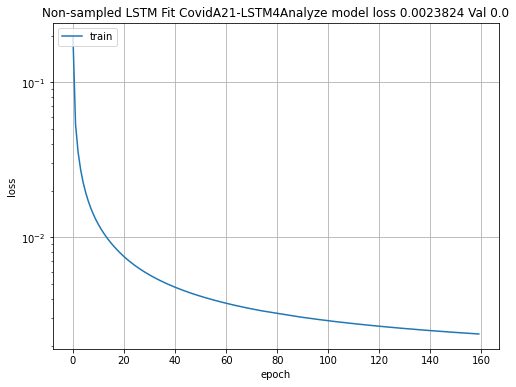

05/22/2021, 21:08:25 UTC CovidA21-LSTM4Analyze DLPrediction April 14 Covid 2021 Dataset; Old set of Properties; NO Validation; LSTM; Futures; 500 counties


Times 0.0 91.2223 TF 28.3998
05/22/2021, 21:10:26 UTC DLPrediction Averages CovidA21-LSTM4Analyze April 14 Covid 2021 Dataset; Old set of Properties; NO Validation; LSTM; Futures; 500 counties
Non-sampled LSTM Fit CovidA21-LSTM4Analyze Weighted sum over predicted values 0.001355 No Encoding Preds 0.001323 from
loss function 0.001355 TF version 0.001355 TFspec version 0.001355
Count ignoring NaN 1180500.0001 Counting NaN 1188000.0001 70
 Unwgt Count no NaN  7419000  Unwgt Count with NaN  7524000  Number Sequences  198000
 Errors by Prediction Components -- class weights not included except in final Loss components  Name Count
without NaN, Loss wgt * sum errors**2/count, sqrt(sum errors**2/sum target**2), sum(abs(error)/sum(abs(value),
abs(sum(abs(value)-abs(pred)))/sum(abs(pred)
0 Next Cases All Counts 198000.0 24.9316 20.1308 4.0802 Loss Coeffs  All Time Full 0.000252 Start
Full 0.000164 End Full 0.000339 All Time FULL 0.000252 Start FULL 0.000164 End FULL 0.000339
1 Next Deaths All Co

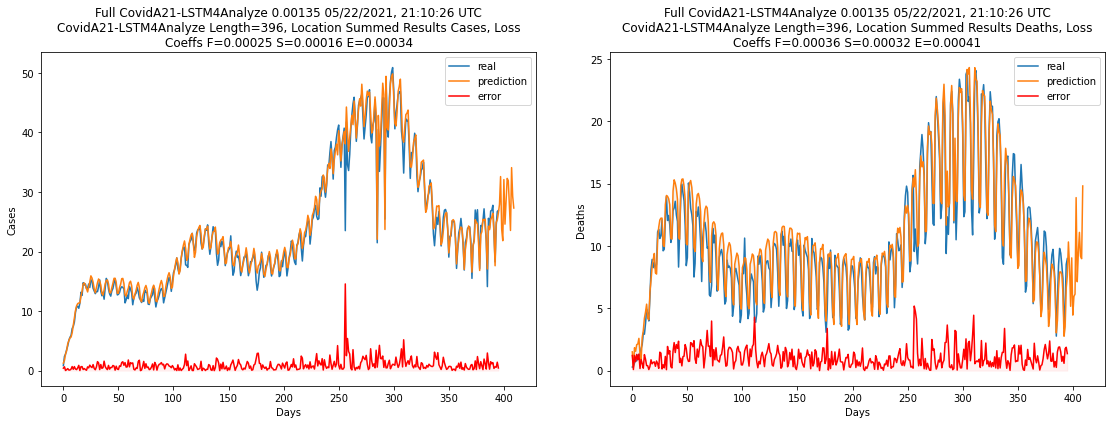

05/22/2021, 21:10:27 UTC Calculate NNSE  CovidA21-LSTM4Analyze April 14 Covid 2021 Dataset; Old set of
Properties; NO Validation; LSTM; Futures; 500 counties
NNSE  0 Next Cases Averaged 0.813 Training 0.813 Validation 0.0 Summed 0.982 Training 0.982
Validation 0.0
NNSE  1 Next Deaths Averaged 0.604 Training 0.604 Validation 0.0 Summed 0.931 Training 0.931
Validation 0.0
DLPrediction2F 05/22/2021, 21:10:33 UTC CovidA21-LSTM4AnalyzeApril 14 Covid 2021 Dataset; Old set of
Properties; NO Validation; LSTM; Futures; 500 counties
 Predict with 500 sequences per sample and batch size 396
Sensitivity using Property ScaleFactor 0.99
Basic Predictions


 Full Loss  Mean 0.00135 Std Deviation 0.0 Basic Predictions
Property 0 Cases Normed Mean 0.0451


 Full Loss  Mean 0.00135 Std Deviation 0.0 Property 0 Cases Normed Mean 0.0451
1728.6404 GS 946059.56 Property 0 Cases Normed Mean 0.0451
Property 1 Deaths Normed Mean 0.0199


 Full Loss  Mean 0.00135 Std Deviation 0.0 Property 1 Deaths Normed Mean 0.0199
396.58347 GS 946059.56 Property 1 Deaths Normed Mean 0.0199
Property 2 Age Distribution Normed Mean 0.3446


 Full Loss  Mean 0.00135 Std Deviation 0.0 Property 2 Age Distribution Normed Mean 0.3446
168.8794 GS 946059.56 Property 2 Age Distribution Normed Mean 0.3446
Property 3 Air Pollution Normed Mean 0.4129


 Full Loss  Mean 0.00135 Std Deviation 0.0 Property 3 Air Pollution Normed Mean 0.4129
153.14832 GS 946059.56 Property 3 Air Pollution Normed Mean 0.4129
Property 4 Co-morbidities Normed Mean 0.4634


 Full Loss  Mean 0.00135 Std Deviation 0.0 Property 4 Co-morbidities Normed Mean 0.4634
136.65608 GS 946059.56 Property 4 Co-morbidities Normed Mean 0.4634
Property 5 Demographics Normed Mean 0.3877


 Full Loss  Mean 0.00135 Std Deviation 0.0 Property 5 Demographics Normed Mean 0.3877
121.67387 GS 946059.56 Property 5 Demographics Normed Mean 0.3877
Property 6 Disease Spread Normed Mean 0.2338


 Full Loss  Mean 0.00135 Std Deviation 0.0 Property 6 Disease Spread Normed Mean 0.2338
100.64257 GS 946059.56 Property 6 Disease Spread Normed Mean 0.2338
Property 7 Health Disparities Normed Mean 0.3078


 Full Loss  Mean 0.00135 Std Deviation 0.0 Property 7 Health Disparities Normed Mean 0.3078
100.38229 GS 946059.56 Property 7 Health Disparities Normed Mean 0.3078
Property 8 Hospital Beds Normed Mean 0.4559


 Full Loss  Mean 0.00135 Std Deviation 0.0 Property 8 Hospital Beds Normed Mean 0.4559
121.12979 GS 946059.56 Property 8 Hospital Beds Normed Mean 0.4559
Property 9 Mobility Normed Mean 0.3668


 Full Loss  Mean 0.00135 Std Deviation 0.0 Property 9 Mobility Normed Mean 0.3668
183.0536 GS 946059.56 Property 9 Mobility Normed Mean 0.3668
Property 10 Residential Density Normed Mean 0.5738


 Full Loss  Mean 0.00135 Std Deviation 0.0 Property 10 Residential Density Normed Mean 0.5738
62.61908 GS 946059.56 Property 10 Residential Density Normed Mean 0.5738
Property 11 Social Distancing Normed Mean 0.9035


 Full Loss  Mean 0.00135 Std Deviation 0.0 Property 11 Social Distancing Normed Mean 0.9035
227.54411 GS 946059.56 Property 11 Social Distancing Normed Mean 0.9035
Property 12 Testing Normed Mean 0.5694


 Full Loss  Mean 0.00135 Std Deviation 0.0 Property 12 Testing Normed Mean 0.5694
158.5193 GS 946059.56 Property 12 Testing Normed Mean 0.5694
Property 13 Transmissible Cases Normed Mean 0.5273


 Full Loss  Mean 0.00136 Std Deviation 0.0 Property 13 Transmissible Cases Normed Mean 0.5273
671.32715 GS 946059.56 Property 13 Transmissible Cases Normed Mean 0.5273
Property 14 voting Normed Mean 0.4622


 Full Loss  Mean 0.00135 Std Deviation 0.0 Property 14 voting Normed Mean 0.4622
136.86023 GS 946059.56 Property 14 voting Normed Mean 0.4622
Property 15 LinearSpace


 Full Loss  Mean 0.00136 Std Deviation 0.0 Property 15 LinearSpace Normed Mean 0.5
1445.5673 GS 946059.56 Property 15 LinearSpace Normed Mean 0.5
Property 16 Constant


 Full Loss  Mean 0.00136 Std Deviation 0.0 Property 16 Constant Normed Mean 0.5
996.33856 GS 946059.56 Property 16 Constant Normed Mean 0.5
Property 17 LinearTime


 Full Loss  Mean 0.00135 Std Deviation 0.0 Property 17 LinearTime Normed Mean 0.5
768.9468 GS 946059.56 Property 17 LinearTime Normed Mean 0.5
Property 18 P2-Time


 Full Loss  Mean 0.00136 Std Deviation 0.0 Property 18 P2-Time Normed Mean 0.0
480.75183 GS 946059.56 Property 18 P2-Time Normed Mean 0.0
Property 19 P3-Time


 Full Loss  Mean 0.00136 Std Deviation 0.0 Property 19 P3-Time Normed Mean 0.0
844.4591 GS 946059.56 Property 19 P3-Time Normed Mean 0.0
Property 20 P4-Time


 Full Loss  Mean 0.00135 Std Deviation 0.0 Property 20 P4-Time Normed Mean 0.0
1050.5995 GS 946059.56 Property 20 P4-Time Normed Mean 0.0
Property 21 CosWeekly


 Full Loss  Mean 0.00135 Std Deviation 0.0 Property 21 CosWeekly Normed Mean 0.0
132.9848 GS 946059.56 Property 21 CosWeekly Normed Mean 0.0
Property 22 SinWeekly


 Full Loss  Mean 0.00135 Std Deviation 0.0 Property 22 SinWeekly Normed Mean 0.0
140.387 GS 946059.56 Property 22 SinWeekly Normed Mean 0.0

Summarize Changes Total 946059.56 Property ScaleFactor 0.99
0 Change 1728.64 Normed Change 0.18272 /std 4.2066 Std/Mean 0.9632 Cases Normed Mean 0.0451 Normed Std 0.0434
1 Change 396.58 Normed Change 0.04192 /std 1.37477 Std/Mean 1.53457 Deaths Normed Mean 0.0199 Normed Std 0.0305
2 Change 168.88 Normed Change 0.01785 /std 0.14794 Std/Mean 0.35016 Age Distribution Normed Mean 0.3446 Normed Std 0.1207
3 Change 153.15 Normed Change 0.01619 /std 0.14115 Std/Mean 0.27779 Air Pollution Normed Mean 0.4129 Normed Std 0.1147
4 Change 136.66 Normed Change 0.01444 /std 0.08051 Std/Mean 0.38712 Co-morbidities Normed Mean 0.4634 Normed Std 0.1794
5 Change 121.67 Normed Change 0.01286 /std 0.09276 Std/Mean 0.35761 Demographics Normed Mean 0.3877 Normed Std 0.1386
6 Change 100.64 Normed Change 0.01064 /std 0.04369 Std/Mean 1.04147 Disease Spread Normed Mean 0.2

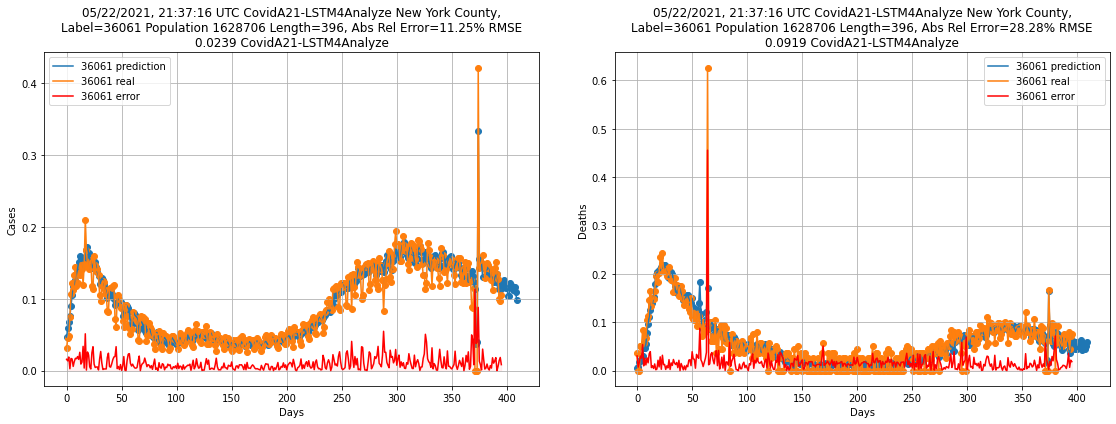

debugfipsoutput for 53033CovidA21-LSTM4Analyze April 14 Covid 2021 Dataset; Old set of Properties; NO Validation; LSTM; Futures; 500 counties

53033 # 479 King County Washington Pop 2252782
05/22/2021, 21:37:17 UTC plot by location 479 53033 King County CovidA21-LSTM4Analyze April 14 Covid 2021 Dataset; Old set of Properties; NO Validation; LSTM; Futures; 500 counties


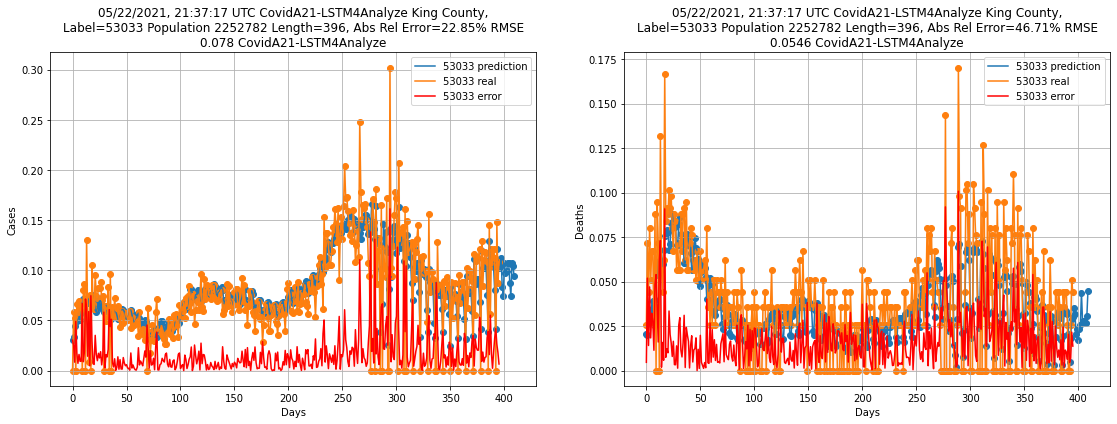

LSTM run completed Restarted CovidA21-LSTM4Analyze April 14 Covid 2021 Dataset; Old set of Properties; NO Validation; LSTM; Futures; 500 counties


SystemExit: ignored

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2890: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
current_time = timenow()
runtype = ''
if Restorefromcheckpoint:
  runtype = 'Restarted '
if standaloneLSTMrun or ClassLSTMrun:
  print(wraptotext(startbold + startred +  current_time + ' '  + runtype + RunName + ' ' + RunComment + resetfonts))
  PrintLSTMandBasicStuff(0)
if standaloneLSTMrun:
  StandaloneLSTM()
if ClassLSTMrun:
  if SymbolicWindows:
    CustomTraining = True
  if CustomTraining:
    RunLSTMCustomVersion()
  else:
    RunLSTMClassVersion()
if standaloneLSTMrun or ClassLSTMrun:
  print(startbold + startpurple +  'LSTM run completed ' + runtype + RunName + ' ' + RunComment + resetfonts)
  sys.exit(0)
print(startbold + startpurple +  current_time + ' UTC Start Hybrid Transformer run ' + RunName + ' ' + RunComment + resetfonts)

# Setting up the Transformer for Spatial Bags

Other data from LSTM defining COVID problem



The original had a BUFFERSIZE removed

Compared to original with a single sequence label and dimension, inp_seq_len or d_sample, we have two sequence labels

iseq = range(0..Tseq) time

iloc = range(0..Nloc) sample location

## Important Parameters defining Transformer project

In [ ]:
ActivateAttention = False
DoubleQKV = False
TimeShufflingOnly = False
Transformerbatch_size = 1
Transformervalidationfrac = 0.0
UsedTransformervalidationfrac = 0.0
Transformerepochs = 200
Transformeroptimizer ='adam'
Transformerverbose = 0
TransformerOnlyFullAttention = True
d_model =64
d_Attention = 2 * d_model
if TransformerOnlyFullAttention:
  d_Attention = d_model
d_qk = d_model
d_intermediateqk = 2 * d_model
num_heads = 2
num_Encoderlayers = 2
EncoderDropout= 0.1
EncoderActivation = 'selu'
d_EncoderLayer = d_Attention
d_merge = d_model
d_ffn = 4*d_model
MaskingOption = 0
PeriodicInputTemporalEncoding = 7 # natural for COVID
LinearInputTemporalEncoding = -1 # natural for COVID
TransformerInputTemporalEncoding = 10000
UseTransformerInputTemporalEncoding = False

***Num_Seq*** Number of Sequences

***Nloc*** Number of locations

***Tseq*** Length of each sequence

***Npropperseq*** Number of internal properties per sequence including static or dynamic

***NpredperseqTOT*** Total number of predictions per sequence

***d_model*** Dimension of value embedding for every input [Model1] 

***num_heads*** Number of Attention Heads which must exactly divide ***d_model***

***num_Encoderlayers*** Number of layers in Encoder stage

***EncoderDropout*** Dropout in Encoder stage, 

***d_ffn*** Size of feedforward network in each encoder layer. It appears to bet to be 4 * ***d_model*** 

***MaskingOption*** defines masking used; = 0 none; =1 mask the future

***PeriodicInputTemporalEncoding*** defines use of periodic time encoding; =0 none; > 0 use time encoding with this period [ 7 weekly, 365 annual). Note this added as a property of each input (actually two as cos-theta and sin-theta)

***LinearInputTemporalEncoding*** defines use of linear time encoding; =0 none; =-1 make linear over full time range. Note this added as a single property of each input

***TransformerInputTemporalEncoding*** defines use of Transformer-style time encoding; =0 none; > 0 use time encoding with this base (10000 in transformer example)

***Transformerbatch_size*** is batch size of stochastic gradient descent

***Tseq*** is size of sequence window

***Transformervalidationfrac*** is fraction used for a validation dataset

***d_sample*** The number of units presented to the Transformer which could be dynamic. Each of these inputs is used to calculate attention and is Tseq times number of locations simultaneously presented

***max_d_sample*** The maximum number of units presented to the Transformer which is fixed. It is Tseq times maximum number of locations simultaneously presented

***TransformerOnlyFullAttention*** if True calculate classic attention over all d_sample members; if False calculate separate attentions in location and time

Describe the science data sets here

Initial data is [Num_Seq][Nloc][Tseq] with values [Nforcing + ExPosEnc-Selin + Nprop-Sel]

Predictions are [Num_Seq] [Nloc] [Predvals=Npred+ExPosEnc-Selout] [Predtimes = Forecast-time range]

A subset is included in each transformer call. There are 3 options
*   Simplest: (as in LSTM) samples are labelled by [Num_Seq] [Nloc] and have input length [Tseq] with multiple features [Nforcing + ExPosEnc-Selin + Nprop-Sel] mapped into a model for each input of length [Model1]. Predictions for each input are [Predvals] [Predtimes]
*   Straightforward improvement:  Divide Nloc into sublocation groups giving Nloc/Nsub groups with Nloc-Nsub locations in each group. There are many choices of groups including fixed disjoint subgroups, overlapping groups (so that each epoch surveys each location twice and this should help spread attention). Then each sample is labelled by [Num_Seq] [Nloc/Nsub] and have input length [Nloc-Nsub][Tseq] with multiple features [Nforcing + ExPosEnc-Selin + Nprop-Sel] mapped into a model for each input of length [Model1]. Predictions for each input are [Predvals] [Predtimes]
*   (Too) Clever: Use different selections for Encoder and Decoder steps. For example feed all Nloc locations into transformer but oinly use through multi-headed attention step. One only takes a subset of these through encoder and predictions. This ensures that attention covers all locations
*   Extend "Too clever"  or "Straightforward" method for multiple initial time values in each transformer input i.e. divide [Num_Seq] into [Num_Seq/Ntsub] groups and input [Num_Seq-Ntsub] time sequences into a single transformer. This spreads attention over time. 

We can represent all the above cases by lasbelling each data sample by
{[Num_Seq][Nloc]} [Tseq] where always members of sequences are complete and selection of sequences and location for a single data sample varies in options above. Each member of a data sample has [Nforcing + ExPosEnc-Selin + Nprop-Sel] internal degrees of freedom. These degrees of freedom will be mapped (embedded) in a model variable of length ***d_model***

Size of input is ***d_sample*** = Tseq * size {[Num_Seq][Nloc]} in a single data sample. This is important throughout network whereas [Nforcing + ExPosEnc-Selin + Nprop-Sel] is immediately embedded and becomes of length ***d_model***







In [ ]:
# Set up data
# Initial data is [For Batching][Nloc_sample] [Tseq] [NpropperseqTOT] starting with RawInputSequencesTOT
# Predictions are [For Batching][Nloc_sample] [NpredperseqTOT] starting with RawInputPredictionsTOT
#  For case Nloc_sample = Nloc, the Batching is identical to Time sequence label
# dsample Tseq * Nloc

Nloc_sample = Nloc
OuterBatchDimension = Num_Seq
if Nloc%Nloc_sample != 0:
  print("Inconsistent location numbers " + str(Nloc) + ' ' + str(Nloc_sample))
  sys.exit()
d_sample = Tseq * Nloc
max_d_sample = d_sample
Transformermaximum_position_encoding = max_d_sample
if SymbolicWindows:
  X_Transformerdetailed = np.copy(SymbolicInputSequencesTOT)
else:
  X_Transformerdetailed = np.copy(RawInputSequencesTOT)

y_Transformerdetailed = np.copy(RawInputPredictionsTOT)

print("The maximum number of units presented to the Transformer which is fixed.It is Tseq times maximum number of locations simultaneously presented ", str(max_d_sample))
print("The actual number of units presented to the Transformer for this batch.It is Tseq times  number of locations simultaneously presented in  this batch ", str(max_d_sample))
print(" Number of locations in each sample presented to the Transformer ", str(Nloc_sample))
print("Number of locations times sequence window length in each sample presented to the Transformer ", str(OuterBatchDimension))

## Positional encoding Text and Code

Since this model doesn't contain any recurrence or convolution, positional encoding is added to give the model some information about the relative position of the words in the sentence. 

The positional encoding vector is added to the embedding vector. Embeddings represent a token in a d-dimensional space where tokens with similar meaning will be closer to each other. But the embeddings do not encode the relative position of words in a sentence. So after adding the positional encoding, words will be closer to each other based on the *similarity of their meaning and their position in the sentence*, in the d-dimensional space.

See the notebook on [positional encoding](https://github.com/tensorflow/examples/blob/master/community/en/position_encoding.ipynb) to learn more about it. The formula for calculating the positional encoding is as follows:

$$\Large{PE_{(pos, 2i)} = sin(pos / 10000^{2i / d_{model}})} $$
$$\Large{PE_{(pos, 2i+1)} = cos(pos / 10000^{2i / d_{model}})} $$

I am not certain if Science wants this type of encoding and/or the positional coding controlled by ***PeriodicInputTemporalEncoding*** and
***LinearInputTemporalEncoding***.

***TransformerInputTemporalEncoding*** controls this. TransformerInputTemporalEncoding = 10000  will give example given here

The base 10000 needs study but otherwise we use this function below later-on

The Blogs/papers on BERT have discussion of more sophisticated multi-sentence encoding in BERT

Also another Blog questions why this encoding added rather that being concatenated

## Masking Text and Code

Masking is used in time. Basic logic similar between science and NLP. There will be no masking in location.

Use flag ***MaskingOption*** to define masking used; = 0 none; =1 mask the future

Note use of NaN to indicate undefined predicted values. That must be handled in loss function.

## Scaled dot product attention for Science

This seems unchanged for science case unless ***d_sample*** is too large. One wastes time then if softmaxes too small. It could be useful just to select the largest (e.g. take top 10 or remove all probabilities < 0.001) softmax values and just process with these

Below all vectors Q K V have size ***d_model/num_heads***. They are defined for each head and for each sample member of the ***d_sample*** members

This could use the  mask described earlier but that is not used in initial version

We have a hierarchial sequence label which limits number of softmaxes calculated although number of Q K V vectors are not reduced

### Scaled dot product attention: Q K V Softmax

<img src="https://www.tensorflow.org/images/tutorials/transformer/scaled_attention.png" width="500" alt="scaled_dot_product_attention">

The attention function used by the transformer takes three inputs: Q (query), K (key), V (value). The equation used to calculate the attention weights is:

$$\Large{Attention(Q, K, V) = softmax_k(\frac{QK^T}{\sqrt{d_k}}) V} $$

The dot-product attention is scaled by a factor of square root of the depth. This is done because for large values of depth, the dot product grows large in magnitude pushing the softmax function where it has small gradients resulting in a very hard softmax. 

For example, consider that `Q` and `K` have a mean of 0 and variance of 1. Their matrix multiplication will have a mean of 0 and variance of `dk`. Hence, *square root of `dk`* is used for scaling (and not any other number) because the matmul of `Q` and `K` should have a mean of 0 and variance of 1, and you get a gentler softmax.

The mask is multiplied with -1e9 (close to negative infinity). This is done because the mask is summed with the scaled matrix multiplication of Q and K and is applied immediately before a softmax. The goal is to zero out these cells, and large negative inputs to softmax are near zero in the output.

In [ ]:
def CalculateFullAttention(q,k,v,num_heads, mask=None):

  depth = tf.shape(k)[-1]
  dk = tf.cast(depth, tf.float32) # dk is depth in all methods
  d_qk  = num_heads * depth

  if SeparateHeads: # Spread out to save space
    HeadedAttentionVectorList = []
    for ihead in range(0,num_heads):
      matmul_qk = tf.matmul(q[:,ihead,:,:], k[:,ihead,:,:], transpose_b=True)  # [Batch, ihead, d_sample, depth] [Batch, ihead, (d_sample, depth)T ]
      scaled_attention_logits = matmul_qk / tf.math.sqrt(dk) # [Batch, d_sample, d_sample]

      # add the mask to the scaled tensor.
      if mask is not None: # batch,d_sample, d_sample
        scaled_attention_logits += (mask * -1e9)

      # softmax is normalized on the last axis (seq_len_k = d_sample) so that the scores add up to 1.
      # scaled_attention_logits and attention_weights [Batch,  d_sample, d_sample] 
      attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  
      if mask is not None:
        attention_weights = tf.where(mask > 0.2, 0.0, attention_weights)

      # [Batch,  d_sample, d_sample] [Batch,  d_sample, depth]
      OneheadAttentionVectorfull = tf.matmul(attention_weights, v[:,ihead,:,:])  
      HeadedAttentionVectorList.append(OneheadAttentionVectorfull)# [num_heads, Batch,  d_sample,  depth]

    AttentionVectorfull = tf.convert_to_tensor(HeadedAttentionVectorList)
    # [Batch, num_heads,  d_sample,  depth]
    AttentionVectorfull = tf.transpose(AttentionVectorfull, perm = [1,0,2,3])
    HeadedAttentionVectorList = None
    OneheadAttentionVectorfull = None

  elif ChopupMatrix:
    basicsize = math.floor((Nloc_sample+0.001)/ChopupNumber)
    remainder = Nloc_sample%basicsize
    Tensorlist =[]
    upperlimit = 0
    for choploop in range(0,ChopupNumber):
      lowerlimit = upperlimit
      upperlimit = lowerlimit + basicsize
      if choploop < remainder:
        upperlimit += 1
# q k v [Batch, num_heads, d_sample, depth]   
      upperlimitSeq = upperlimit*Tseq
      lowerlimitSeq = lowerlimit*Tseq       
      matmul_qk = tf.matmul(q[:,:,lowerlimitSeq:upperlimitSeq,:], k[:,:,lowerlimitSeq:upperlimitSeq,:], transpose_b=True)  
# [Batch, num_heads, d_sampleCHOP, depth] [Batch, num_heads, (d_sampleCHOP, depth)T ]
      scaled_attention_logits = matmul_qk / tf.math.sqrt(dk) # [Batch, num_heads, d_sampleCHOP, d_sampleCHOP]

      # add the mask to the scaled tensor.
      if mask is not None: # batch,d_sample, d_sample
        smallmask = mask[:,lowerlimitSeq:upperlimitSeq,lowerlimitSeq:upperlimitSeq]
        smallmask = tf.reshape(smallmask,[smallmask.shape[0],1,smallmask.shape[1],smallmask.shape[2]])
        scaled_attention_logits += (smallmask * -1e9)
        
      attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # scaled_attention_logits [Batch, num_heads, d_sampleCHOP, d_sampleCHOP]
      if mask is not None:
        attention_weights = tf.where(smallmask > 0.2, 0.0, attention_weights)
      Tensorlist.append(tf.matmul(attention_weights, v[:,:,lowerlimitSeq:upperlimitSeq,:]))
    AttentionVectorfull = tf.concat(Tensorlist,axis=2)
    Tensorlist = None
    smallmask = None

  else: # FULL ATTENTION Integrated all heads done together
    matmul_qk = tf.matmul(q, k, transpose_b=True)  # [Batch, num_heads, d_sample, depth] [Batch, num_heads, (d_sample, depth)T ]
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk) # [Batch, num_heads, d_sample, d_sample]

    # add the mask to the scaled tensor.
    if mask is not None: # batch,d_sample, d_sample
      mask = tf.reshape(mask,[mask.shape[0],1,mask.shape[1],mask.shape[2]])
      scaled_attention_logits += (mask * -1e9)  

    # softmax is normalized on the last axis (seq_len_k = d_sample) so that the scores add up to 1.
    # scaled_attention_logits [Batch, num_heads, d_sample, d_sample] 
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1) 
    if mask is not None:
      attention_weights = tf.where(mask > 0.2, 0.0, attention_weights)

    AttentionVectorfull = tf.matmul(attention_weights, v)  # [Batch, num_heads, d_sample, d_sample] [Batch, num_heads, d_sample, d_v]

  # Below done for FULL ATTENTION as only Attention whatever SeparateHeads
  AttentionVectortemp = tf.transpose(AttentionVectorfull, perm = [0,2,1,3]) # [Batch,  d_sample, num_heads, d_v]
  AttentionVector = tf.reshape(AttentionVectortemp, [q.shape[0],d_sample, num_heads*d_v]) # restore shape
  AttentionVectortemp = None
  scaled_attention_logits = None
  attention_weights = None
  matmul_qk = None
  return AttentionVector

def scaled_dot_product_attention(q, k, v, mask=None):
  # Needs externally defined  num_heads, d_sample, Nloc_sample, Tseq, d_model
  # Calculates depth
  """
  Calculate the attention weights after Q K V found
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead) 
  but it must be broadcastable for addition.
  
  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable 
          to (..., seq_len_q, seq_len_k). Defaults to None.

In the science Transformer, Q K V are all Batch, num_heads, d_sample, depth
where Q K V all have same number of samples d_sample
depth is always d_model/num heads

d_sample is really [Nloc_sample][Tseq] and calculates separate Location and Time Attention

Original returned attention weights but ignored. We do NOT return but rather return two attention vectors in Location and Time
If TransformerOnlyFullAttention specified, it returns  traditional full attention vector
  Returns:
    AttentionVector1 concatenated with AttentionVector2
  """
  # To scale matmul_qk
  depth = tf.shape(k)[-1]
  dk = tf.cast(depth, tf.float32) # dk is depth in all methods
  d_qk  = num_heads * depth

# This executes JUST ONE ATTENTION -  Full
  if TransformerOnlyFullAttention:
    AttentionVector = CalculateFullAttention(q,k,v,num_heads,mask)
    mask = None
# End ONE WAY ATTENTION

  else: # Two way Attention
    # FIRST Calculate Attention in Time. This requires no reordering and so can be redone with shape
    # Note matmul works for all number of indices and multiplication is only done on last 2 indices 
    # so using qtime means we look at attention with location fixed
    qtime = tf.reshape(q, [-1, num_heads, Nloc_sample, Tseq, depth ])
    ktime = tf.reshape(k, [-1, num_heads, Nloc_sample, Tseq, depth ])
    vtime = tf.reshape(v, [-1, num_heads, Nloc_sample, Tseq, d_v ])
    matmul_qk = tf.matmul(qtime, ktime, transpose_b=True)  # [Batch, num_heads, Nloc_sample, Tseq, depth] [Batch, num_heads, Nloc_sample, (Tseq, depth)T ]
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk) # [Batch, num_heads, Nloc_sample, Tseq, Tseq]
    # add the mask to the scaled tensor.
    if mask is not None:
#      mask = tf.reshape(mask,[mask.shape[0],Nloc_sample,Tseq,Nloc_sample,Tseq]) Calulate from full mask
#      timemask= tf.transpose(mask,perm = [0,2,4,1,3])
#      timemask = tf.linalg.diag_part(timemask)
#      timemask = tf.transpose(timemask,perm = [0,3,1,2])
#      timemask = tf.reshape(timemask,[timemask.shape[0],1,Nloc_sample, Tseq, Tseq])
# Global Time Mask is [1,1,1,Tseq,Tseq]
      timemask =tf.convert_to_tensor(GlobalTimeMask, dtype = tf.float32) # [Batch, num_heads, Nloc_sample, Tseq, Tseq]
      scaled_attention_logits += (timemask * -1e9)

    # softmax is normalized on the last axis (Tseq) so that the scores add up to 1 in time direction separately for each space.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # scaled_attention_logits [Batch, num_heads, Nloc_sample, Tseq, Tseq] 
    if mask is not None:
      attention_weights = tf.where(timemask > 0.2, 0.0, attention_weights)
                
    AttentionVector1time = tf.matmul(attention_weights, vtime)  # [Batch, num_heads, Nloc_sample, Tseq, Tseq] [Batch, num_heads,  Nloc_sample, Tseq, d_v] becomes [Batch, num_heads, Nloc_sample, Tseq, depth]
    AttentionVector1temp = tf.transpose(AttentionVector1time, perm = [0,2,3,1,4]) # [Batch,  Nloc_sample, Tseq, num_heads, d_v]
    AttentionVector1 = tf.reshape(AttentionVector1temp, [q.shape[0],d_sample, d_v*num_heads]) # restore shape
    AttentionVector1time = None
    AttentionVector1temp = None
    timemask = None

# Purely Space-based attention as second of two attentions
# Note we don't do Space and Full together so calculated mask is for Space and saves space
    if SpacewiseSecondAttention:
      # Code below rewrites arrays to have 5 indices exposing space and time separately
      qspace = tf.transpose(qtime, perm = [1,0,3,2,4]) # [num_heads, Batch, Tseq, Nloc_sample,  depth]
      kspace = tf.transpose(ktime, perm = [1,0,3,2,4]) # [num_heads, Batch, Tseq, Nloc_sample,  depth]
      vspace = tf.transpose(vtime, perm = [1,0,3,2,4]) # [num_heads, Batch, Tseq, Nloc_sample,  d_v]
      if SeparateHeads:
        HeadedAttentionVectorList = []
        for ihead in range(0,num_heads):
          # [Batch,ihead, Tseq, Nloc_sample, depth] [Batch, ihead,Tseq, (Nloc_sample, depth)T ]
          matmul_qk = tf.matmul(qspace[ihead,:,:,:,:], kspace[ihead,:,:,:,:], transpose_b=True)
          scaled_attention_logits = matmul_qk / tf.math.sqrt(dk) # [Batch, Tseq, Nloc_sample, Nloc_sample] 
          if mask is not None:
            spacemask = tf.reshape(mask,[mask.shape[0],1,Nloc_sample,Nloc_sample])
            scaled_attention_logits += (spacemask * -1e9) 
          attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # scaled_attention_logits [Batch,  Tseq, Nloc_sample,  Nloc_sample] 
          if mask is not None:
            attention_weights = tf.where(spacemask > 0.2, 0.0, attention_weights) 
          # [Batch,  Tseq, Nloc_sample, Nloc_sample] [Batch,  Tseq, Nloc_sample, depth]
          OneheadAttentionVectorspace = tf.matmul(attention_weights, vspace[ihead,:,:,:,:])  
          HeadedAttentionVectorList.append(OneheadAttentionVectorspace)# [num_heads,Batch,  Tseq, Nloc_sample,  depth]
        AttentionVector2space = tf.convert_to_tensor(HeadedAttentionVectorList)
        OneheadAttentionVectorspace = None
        HeadedAttentionVectorList = None
     
      else: # Fully Integrated
        matmul_qk = tf.matmul(qspace, kspace, transpose_b=True)  # [num_heads,Batch,  Tseq, Nloc_sample, depth] [num_heads, Batch, Tseq, (Nloc_sample, depth)T ]
        scaled_attention_logits = matmul_qk / tf.math.sqrt(dk) # [num_heads, Batch, Tseq, Nloc_sample, Nloc_sample]

        # add the mask to the scaled tensor.
        if mask is not None:
          #mask = tf.reshape(mask,[mask.shape[0],Nloc_sample,Tseq,Nloc_sample,Tseq])
          #spacemask= mask[:,:,0,:,0]
          #spacemask = tf.reshape(spacemask,[mask.shape[0],1,1,Nloc_sample,Nloc_sample])
          spacemask = tf.reshape(mask,[1,mask.shape[0],1,Nloc_sample,Nloc_sample])
          scaled_attention_logits += (spacemask * -1e9)

        # softmax is normalized on the last axis (Nloc_sample) so that the scores add up to 1 in location direction separately for each space.
        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # scaled_attention_logits [num_heads, Batch, Tseq, Nloc_sample,  Nloc_sample] 
        if mask is not None:
          attention_weights = tf.where(spacemask > 0.2, 0.0, attention_weights)  

        AttentionVector2space = tf.matmul(attention_weights, vspace)
  # [num_heads, Batch, Tseq, Nloc_sample,  Nloc_sample] [Batch, num_heads, Tseq, Nloc_sample,  d_v] becomes [Batch, num_heads, Tseq, Nloc_sample,  d_v]
      
      AttentionVector2temp = tf.transpose(AttentionVector2space, perm = [1,3,2,0,4]) # [Batch,  Nloc_sample, Tseq, num_heads, d_v]
      AttentionVector2 = tf.reshape(AttentionVector2temp, [q.shape[0], d_sample, d_v*num_heads ]) # restore shape
      AttentionVector2space = None
      AttentionVector2temp = None
      spacemask = None
      qspace = None
      kspace = None
      vspace = None

# Full time-space for second attention
    else:
      AttentionVector2 = CalculateFullAttention(q,k,v,num_heads,mask)

# Combine two attentions
    AttentionVector = tf.concat([AttentionVector1,AttentionVector2], -1) # [Batch, d_sample,2*d_v*num_heads] 
    AttentionVector1 = None
    AttentionVector2 = None
    qtime = None
    ktime = None
    vtime = None

# Either one-way or two-way attention
  scaled_attention_logits = None
  attention_weights = None
  mask = None
  matmul_qk = None
  return AttentionVector # [Batch,  d_sample,d_Attention] 

## **Multi-head attention for Science**

Multi-head attention should be identical between Science ad NLP 

Note assertion that ***num_heads*** divides ***d_model***

The annotation has seq_len and similar notations which is ***d_sample***

***depth*** is calculated. It is number of words in each instance of Q, K, V for one head. Note that Q, K, V are concatenated over heads for efficient computation

We suggest possibility of doing attention not across all d_sample inputs but rather separately in time and in location. This is implemented in "Scaled Dot Product Attention"

We also allow d_Attention final size to be different from input d_model. Further we put correction of splitting into "Scaled Dot Product Attention" as it is naturally combined with other tensor reshape/transformations

### Multi-head Attention Discussion and Science version

<img src="https://www.tensorflow.org/images/tutorials/transformer/multi_head_attention.png" width="500" alt="multi-head attention">


Multi-head attention consists of four parts:
*    Linear layers and split into heads.
*    Scaled dot-product attention.
*    Concatenation of heads.
*    Final linear layer.

Each multi-head attention block gets three inputs; Q (query), K (key), V (value). These are put through linear (Dense) layers and split up into multiple heads. 

The `scaled_dot_product_attention` defined above is applied to each head (broadcasted for efficiency). An appropriate mask must be used in the attention step.  The attention output for each head is then concatenated (using `tf.transpose`, and `tf.reshape`) and put through a final `Dense` layer.

Instead of one single attention head, Q, K, and V are split into multiple heads because it allows the model to jointly attend to information at different positions from different representational spaces. After the split each head has a reduced dimensionality, so the total computation cost is the same as a single head attention with full dimensionality.

In [ ]:
class Active_QKV(tf.keras.layers.Layer):
  def __init__(self,d_intermediateqkv, d_finalqkv):
    super(Active_QKV, self).__init__()

    self.d_intermediateqkv  = d_intermediateqkv
    self.d_finalqkv = d_finalqkv

    self.FirstDenseqkv =  tf.keras.layers.Dense(self.d_intermediateqkv, activation=EncoderActivation)  # (batch_size, d_qkv, d_intermediateqkv)
    self.SecondDenseqkv =  tf.keras.layers.Dense(self.d_finalqkv)  # (batch_size, d_qk, d_finalqkv)
    self.TheDropoutqkv =  tf.keras.layers.Dropout(EncoderDropout)

  def call(self, qkv, training=None):
  
    Running = self.FirstDenseqkv(qkv)
    Running = self.SecondDenseqkv(Running)  
    ComplexQKV = self.TheDropoutqkv(Running,training=training)

    return ComplexQKV

class MultiHeadAttention(tf.keras.layers.Layer):
  # Feed in d_model, num_heads. Nothing assumed. Other sizes implied by tensors
  # seq_len = seq_len_q = seq_len_k= seq_len_v below is d_sample

  def __init__(self):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_intermediateqk = d_intermediateqk
    self.d_intermediatev = d_intermediatev
    self.d_qk = d_qk
    self.d_v = d_v

    assert self.d_qk % self.num_heads == 0
    
    self.depth = self.d_qk // self.num_heads
    
    if not ActivateAttention:
      self.wq = tf.keras.layers.Dense(self.d_qk)
      self.wk = tf.keras.layers.Dense(self.d_qk)
      if not Takevasinput:
        self.wv = tf.keras.layers.Dense(self.d_v*self.num_heads)  
    if  ActivateAttention:   
      if self.d_intermediateqk >0:
        self.wq_aa = Active_QKV(self.d_intermediateqk, self.d_qk)
        self.wk_aa = Active_QKV(self.d_intermediateqk, self.d_qk)
      else:
        self.wq_aa = tf.keras.layers.Dense(self.d_qk, activation=EncoderActivation)
        self.wk_aa = tf.keras.layers.Dense(self.d_qk, activation=EncoderActivation)
      if not Takevasinput:  
        if self.d_intermediatev >0:    
          self.wv_aa = Active_QKV(self.d_intermediatev, self.d_v)
        else:
          self.wv_aa = tf.keras.layers.Dense(self.d_v, activation=EncoderActivation)

    self.finaldense = tf.keras.layers.Dense(d_Attention)

  def summarize(self):
    count_tot = self.count_params()
    count_v = 0
    if  ActivateAttention: 
      count_q = self.wq_aa.count_params()
      count_k = self.wk_aa.count_params()
      if not Takevasinput:
        count_v = self.wv_aa.count_params()
    else:
      count_q = self.wq.count_params()
      count_k = self.wk.count_params()
      if not Takevasinput:
        count_v = self.wv.count_params()
    count_final = self.finaldense.count_params()
    print('MHA Tot ' + str(count_tot) + ' Q K V ' + str(count_q) + ' ' + str(count_k) + ' ' + str(count_v)
     + ' Dense ' + str(count_final))

  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])
    
  def call(self, v, k, q, Mappedv, mask=None, training=None):
    batch_size = tf.shape(q)[0]
   
    if ActivateAttention:
      q = self.wq_aa(q, training=training)  # (batch_size, seq_len, d_qk)
      k = self.wk_aa(k, training=training)  # (batch_size, seq_len, d_qk)
      if not Takevasinput:
        v = self.wv_aa(v, training=training)  # (batch_size, seq_len, d_v)
    else:
      q = self.wq(q)  # (batch_size, seq_len, d_qk)
      k = self.wk(k)  # (batch_size, seq_len, d_qk)
      if not Takevasinput:
        v = self.wv(v)  # (batch_size, seq_len, d_v*self.num_heads)

    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)

    if Takevasinput:
      v=[]
      for i in range(0,self.num_heads):
        v.append(Mappedv)
      v = tf.convert_to_tensor(v)
      v = tf.reshape(v, (batch_size, -1, self.num_heads, Mappedv.shape[-1]))
      v = tf.transpose(v, perm=[0, 2, 1, 3])
    else:   
      v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth = D_v)

# scaled_attention.shape == (batch_size,  seq_len_q, d_Attention)
    concat_attention = scaled_dot_product_attention(q, k, v, mask)
    output = self.finaldense(concat_attention)  # (batch_size, seq_len_q, d_Attention)
  
    return output

## **Point wise feed forward network** (Original and Science)

This is used in encoder (each) layer and the decoder.  The activation layer could be 'relu' or 'selu'.

dff in code is our parameter ***d_ffn*** (size of first layer in feef forward network) and defaults to 4 * ***d_model***

Point wise feed forward network consists of two fully-connected layers with a relu or selu activation in between.

In [ ]:
def point_wise_feed_forward_network(d_EncoderLayer, d_ffn):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(d_ffn, activation=EncoderActivation),  # (batch_size, seq_len, d_ffn)
      tf.keras.layers.Dense(d_EncoderLayer)  # (batch_size, seq_len, d_EncoderLayer)
  ])

## **Encoder and decoder**

Note the process starts with an ***Encoder*** and finishes with a ***Decoder***. These share components like multi-headed attention. We expect to look at different Decoders for science as we want floating point numbers and not as in NLP, members of a vocabulary We expect that decoder could be similar for science and NLP as it is looking for structure and that is a set of relationships which could be similar between science and NLP. .

<img src="https://www.tensorflow.org/images/tutorials/transformer/transformer.png" width="600" alt="transformer">

The transformer model follows the same general pattern as a standard [sequence to sequence with attention model](nmt_with_attention.ipynb). 

* The input sentence is passed through `N` encoder layers that generates an output for each word/token in the sequence.
* The decoder attends on the encoder's output and its own input (self-attention) to predict the next word. 

### Encoder layer (Original and Science)

Each encoder layer consists of sublayers:

1.   Multi-head attention (with padding mask) 
2.    Point wise feed forward networks. 

Each of these sublayers has a residual connection around it followed by a layer normalization. Residual connections help in avoiding the vanishing gradient problem in deep networks.

The output of each sublayer is `LayerNorm(x + Sublayer(x))`. The normalization is done on the `d_EncoderLayer` (last) axis. There are N = ***num_Encoderlayers*** encoder layers in the transformer.


I am not clear why x and sublayer(x) (input and output, out1 + ffn_output) are added. I would have concatenated. I had a similar comment on positional encoding which is added to rather than being appended to input. For science the numbers matter -- its not just patterns!

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention()
    self.ffn = point_wise_feed_forward_network(d_EncoderLayer, d_ffn)

    if oldencoderversion:
      self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
      self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(EncoderDropout)
    self.dropout2 = tf.keras.layers.Dropout(EncoderDropout)
 
  def summarize(self):
    self.mha.summarize()
    print(startbold + startpurple + 'point_wise_feed_forward_network Sequential Net' +resetfonts)
    self.ffn.summary()

  def call(self, x, xmapped, training=None, mask=None):

# mha adjusts to shape[-1] of x being d_model or d_EncoderLayer
    attn_output = self.mha(x, x, x, xmapped, mask = mask, training=training)  # (batch_size, input_seq_len, d_model)

    attn_output = self.dropout1(attn_output, training=training)
    
    if oldencoderversion:
      if np.shape(x)[-1] == np.shape(attn_output)[-1]:
        addtogether = x + attn_output
      else:
        doublex = tf.concat([x,x], -1)
        if np.shape(doublex)[-1] != np.shape(attn_output)[-1]:
          doublex = tf.concat([doublex,doublex], -1)
        addtogether = doublex + attn_output 
      out1 = self.layernorm1(addtogether)  # (batch_size, input_seq_len, d_EncoderLayer)
    else:
      out1 = attn_output

    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_EncoderLayer)
    ffn_output = self.dropout2(ffn_output, training=training)
    if oldencoderversion:
      out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_EncoderLayer)
    else:
      out2 = ffn_output

    return out2


### Encoder

The `Encoder` consists of:
1.   Input Embedding
2.   Positional Encoding
3.   N encoder layers

The input is put through an embedding which is summed with the positional encoding. The output of this summation is the input to the encoder layers. The output of the encoder is the input to the decoder.

### Encoder (Science modified Original)

In [ ]:
class Encoder(tf.keras.Model):
  def __init__(self):
    super(Encoder, self).__init__()
    
   # self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
    self.dense_1 = tf.keras.layers.Dense(d_model, activation=EncoderActivation)
    if UseTransformerInputTemporalEncoding:
      self.pos_encoding = positional_encoding(Transformermaximum_position_encoding, d_model)
    
    self.enc_layers = [EncoderLayer() for _ in range(num_Encoderlayers)]
    self.dropout = tf.keras.layers.Dropout(EncoderDropout)
        
  def call(self, x, training =None, mask = None):
  
  # adding embedding and position encoding.
  # x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
  # x *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    xmapped = self.dense_1(x)
    xrunning = xmapped 

    if UseTransformerInputTemporalEncoding:
      seq_len = tf.shape(xrunning)[1]
      xrunning += self.pos_encoding[:, :seq_len, :]

    xrunning = self.dropout(xrunning, training=training)
    for i in range(num_Encoderlayers):
      xrunning = self.enc_layers[i](xrunning, xmapped, training=training, mask=mask)
      
    return xrunning, xmapped  # (batch_size, d_sample, d_EncoderLayer)



### Encoder for Science

The encoder for Science is very close to the NLP version
Its output is TWO arrays
* The result of self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model) before NLP position encoding applied
* The same output of Encoder used in NLP

Both are (***Transformerbatch_size***, ***d_sample***, ***d_model***)

Note this is analogous to RESNET that adds input to output after several convolutional layers. We maybe incorrectly are concatenating not adding

This interpreted as original embedded data which would have been fed into an LSTM in that model plus a second vector summarizing result of attention analysis -- a form of generalized history

We will need to convert the ***d_sample*** index to two indices ***Tseq*** * size {[Num_Seq][Nloc]}

We can run members of size {[Num_Seq][Nloc]} together in LSTM although this is not how it is done normally in pure LSTM. Alternatively we can run each sample member separately

Note each member of sample has a separate encoder output

### Decoder for Science
This is not like the NLP Decoder. Rather it will use the same two layer LSTM we have already tested extensively in COVID.

There are two important changes
1. In COVID the equivalent of ***d_sample*** held just ***Tseq*** entries -- a single window for one location. Now we feed in a window of length Tseq as in COVID but the input data is muliple cases of size {[Num_Seq][Nloc]}. As we expect to start with one  sequence per network input this is just the number of locations.
2. For each presented case, we intend to use not ust the output of encoder but rather the concatenation of two vectors of length ***d_model***

* The result of self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model) before NLP position encoding applied
* The same output of Encoder used in NLP containing concatenated attention head results

There are two possibilities to consider
1. That described above with a single input to decoder of length 2 * ***d_model*** * ***d_sample/Tseq***
2. ***d_sample/Tseq*** separate runs (in parallel or one after the other) each containing one case. This is safest" approach as closely mimics that used in COVID

Note this LSTM subsystem ends with a small FCN and so we don't need an additional linear layer

# Transformer Model for Science

In [ ]:
class EncodertoLSTMmerge(tf.keras.Model):
  def __init__(self):
    super(EncodertoLSTMmerge, self).__init__()
    self.dense_merged = tf.keras.layers.Dense(d_merge, activation=EncoderActivation)

  def call(self, Originalinput, EncoderOutput, training=None):

    EncoderOutput = tf.reshape(EncoderOutput, [EncoderOutput.shape[0], Nloc_sample, Tseq, d_EncoderLayer])
    
    if ReuseInputinEncoder:
      Originalinput = tf.reshape(Originalinput, [Originalinput.shape[0], Nloc_sample, Tseq, Originalinput.shape[-1]])
      Merged = tf.concat([Originalinput,EncoderOutput], -1)
    else:
      Merged = EncoderOutput
    Merged = self.dense_merged(Merged)

    return Merged

  def build_graph(self, shapes):
    input = tf.keras.layers.Input(shape=shapes, name="Input")
    return tf.keras.models.Model(inputs=[input], outputs=[self.call(input)])

## Prediction and Visualization Transformer

###DLprediction2D


In [ ]:
def DLprediction2D(Xin, yin, DLmodel):
  # Only runs in Transformer mode
  # Input is the windows [Num_Seq] [Nloc] [Tseq] [NpropperseqTOT] (SymbolicWindows False)
  # Input is  the sequences [Nloc] [Num_Time-1] [NpropperseqTOT] (SymbolicWindows True)
  # Input Predictions are always [Num_Seq] [NLoc] [NpredperseqTOT]
  # Label Array is always [Num_Seq][Nloc] [0=Window(first sequence)#, 1=Location]

  DLprediction2E(Xin, yin, DLmodel,1)
  if SkipDL2D:
    return
  if GarbageCollect:
    gc.collect()
  global  OuterBatchDimension, Nloc_sample, d_sample, max_d_sample

  SampleSize = 1

  FitRanges_FullAtt = np.zeros([Num_Seq, Nloc, NpredperseqTOT,5], dtype =np.float32)
  FRanges = np.full((NpredperseqTOT), 1.0, dtype = np.float32)
  # 0 count 1 mean 2 Standard Deviation 3 Min 4 Max

  print(wraptotext(startbold+startred+ 'DLPrediction2D ' +current_time + ' ' + RunName + RunComment +  resetfonts))

  sw = np.empty_like(yin, dtype=np.float32)
  for i in range(0,sw.shape[0]):
    for j in range(0,sw.shape[1]):
      for k in range(0,NpredperseqTOT):
        sw[i,j,k] = Predictionwgt[k] 
  labelarray =np.empty([Num_Seq, Nloc, 2], dtype = np.int32)
  for iseq in range(0, Num_Seq):
    for iloc in range(0,Nloc):
      labelarray[iseq,iloc,0] = iseq
      labelarray[iseq,iloc,1] = iloc

  Totaltodo = Num_Seq*Nloc
  Nloc_sample = Nloc # default

  if IncreaseNloc_sample > 1:
    Nloc_sample = int(Nloc_sample*IncreaseNloc_sample)
  elif DecreaseNloc_sample > 1:
    Nloc_sample = int(Nloc_sample/DecreaseNloc_sample)

  if Totaltodo%Nloc_sample != 0:
    printexit('Invalid Nloc_sample ' + str(Nloc_sample) + " " + str(Totaltodo))
  d_sample = Tseq * Nloc_sample        
  max_d_sample = d_sample
  OuterBatchDimension = int(Totaltodo/Nloc_sample)
  print(' Predict with ' +str(Nloc_sample) + ' sequences per sample and batch size ' + str(OuterBatchDimension))

  meanvalue2 = 0.0
  meanvalue3 = 0.0
  meanvalue4 = 0.0
  variance2= 0.0
  variance3= 0.0
  variance4= 0.0

  samplebar = notebook.trange(SampleSize,  desc='Full Samples', unit  = 'sample')
  bbar = notebook.trange(OuterBatchDimension,  desc='Batch    loop', unit  = 'sample')
  for shuffling in range (0,SampleSize):
    if GarbageCollect:
      gc.collect()
    startvalue = 0
    endvalue = Num_Seq
    Xuse = Xin[startvalue:endvalue]
    yuse = yin[startvalue:endvalue]
    labeluse = labelarray[startvalue:endvalue]
    y2= np.reshape(yuse, (-1, NpredperseqTOT)).copy()
    labelarray2 = np.reshape(labeluse, (-1,2))

    if SymbolicWindows:
      # Xin X2 X3 not used rather ReshapedSequencesTOT
      labelarray2, y2 = shuffleDLinput(labelarray2, y2)
    else:
      X2 = np.reshape(Xuse, (-1, Tseq, NpropperseqTOT)).copy()
      X2, y2, labelarray2 = shuffleDLinput(X2, y2,labelarray2)
      X3 = np.reshape(X2, (-1, d_sample, NpropperseqTOT))
    y3 = np.reshape(y2, (-1, Nloc_sample, NpredperseqTOT))
    sw = np.reshape(sw, (-1, Nloc_sample, NpredperseqTOT))
    labelarray3 = np.reshape(labelarray2, (-1, Nloc_sample, 2))

    quan2 = 0.0
    quan3 = 0.0
    quan4 = 0.0
    for Batchindex in range(0, OuterBatchDimension):
      if GarbageCollect:
        gc.collect()

      if SymbolicWindows:
        X3local = list()
        for iloc_sample in range(0,Nloc_sample):
          LocLocal = labelarray3[Batchindex, iloc_sample,1]
          SeqLocal = labelarray3[Batchindex, iloc_sample,0]
          X3local.append(ReshapedSequencesTOT[LocLocal,SeqLocal:SeqLocal+Tseq])
        InputVector = np.array(X3local)
      else:
        InputVector = X3[Batchindex]

      Labelsused = labelarray3[Batchindex]
      Time = SetSpacetime(np.reshape(Labelsused[:,0],(1,-1)))
      InputVector = np.reshape(InputVector,(1,Tseq*Nloc_sample,NpropperseqTOT))
      PredictedVector = DLmodel(InputVector, training = PredictionTraining, Time=Time )
      PredictedVector = np.reshape(PredictedVector,(1,Nloc_sample,NpredperseqTOT))

      swbatched = sw[Batchindex,:,:]
      if LocationBasedValidation:
        swT = np.zeros([1,Nloc_sample,NpredperseqTOT],dtype = np.float32)
        swV = np.zeros([1,Nloc_sample,NpredperseqTOT],dtype = np.float32)
        for iloc_sample in range(0,Nloc_sample):
          fudgeT = Nloc/TrainingNloc
          fudgeV = Nloc/ValidationNloc
          iloc = Labelsused[iloc_sample,1]
          if MappingtoTraining[iloc] >= 0:
            swT[0,iloc_sample,:] = swbatched[iloc_sample,:]*fudgeT
          else:
            swV[0,iloc_sample,:] = swbatched[iloc_sample,:]*fudgeV
      TrueVector = y3[Batchindex]
      TrueVector = np.reshape(TrueVector,(1,Nloc_sample,NpredperseqTOT))
      swbatched = np.reshape(swbatched,(1,Nloc_sample,NpredperseqTOT))

      losspercall = numpycustom_lossGCF1(TrueVector,PredictedVector,swbatched)
      quan2 += losspercall
      bbar.update(1)
      if LocationBasedValidation:
        losspercallTr = numpycustom_lossGCF1(TrueVector,PredictedVector,swT)
        quan3 += losspercallTr
        losspercallVl = numpycustom_lossGCF1(TrueVector,PredictedVector,swV)
        quan4 += losspercallVl
      
      for iloc_sample in range(0,Nloc_sample):
        LocLocal = Labelsused[iloc_sample,1]
        SeqLocal = Labelsused[iloc_sample,0]
        yyhat = PredictedVector[0,iloc_sample]
        if (FitRanges_FullAtt [SeqLocal,LocLocal,0,0] < 0.1):
            FitRanges_FullAtt [SeqLocal,LocLocal,:,3] = yyhat
            FitRanges_FullAtt [SeqLocal,LocLocal,:,4] = yyhat
        else:
          FitRanges_FullAtt [SeqLocal,LocLocal,:,3] = np.maximum(FitRanges_FullAtt [SeqLocal,LocLocal,:,3],yyhat)
          FitRanges_FullAtt [SeqLocal,LocLocal,:,4] = np.minimum(FitRanges_FullAtt [SeqLocal,LocLocal,:,4],yyhat)
        FitRanges_FullAtt [SeqLocal,LocLocal,:,0] += FRanges
        FitRanges_FullAtt [SeqLocal,LocLocal,:,1] += yyhat
        FitRanges_FullAtt [SeqLocal,LocLocal,:,2] += np.square(yyhat)

      fudge = 1.0/(1.0 + Batchindex)
      mean2 = quan2 * fudge 
      if LocationBasedValidation:
        mean3 = quan3 * fudge
        mean4 = quan4 * fudge
        bbar.set_postfix(AvLoss = mean2, AvTr = mean3, AvVl = mean4, Loss = losspercall, Tr = losspercallTr, Vl = losspercallVl)
      else:
        bbar.set_postfix(Loss = losspercall, AvLoss = mean2 ) 

# Processing at the end of Sampling Loop
    fudge = 1.0/OuterBatchDimension
    quan2 *= fudge
    quan3 *= fudge
    quan4 *= fudge
    meanvalue2 += quan2
    variance2 += quan2**2
    variance3 += quan3**2
    variance4 += quan4**2
    if LocationBasedValidation:
      meanvalue3 += quan3
      meanvalue4 += quan4        
    samplebar.update(1)
    if LocationBasedValidation:
      samplebar.set_postfix(Shuffle=shuffling, Loss = quan2, Tr = quan3, Val = quan4)
    else:
      samplebar.set_postfix(Shuffle=shuffling, Loss = quan2)
    bbar.reset()
# End Shuffling loop

  meanvalue2 /= SampleSize 

  global GlobalTrainingLoss, GlobalValidationLoss, GlobalLoss
  printloss(' Full Loss ',meanvalue2,variance2,SampleSize)
  meanvalue2 /= SampleSize
  GlobalLoss = meanvalue2
  GlobalTrainingLoss = 0.0
  GlobalValidationLoss = 0.0
  
  if LocationBasedValidation:
    printloss(' Training Loss ',meanvalue3,variance3,SampleSize)
    printloss(' Validation Loss ',meanvalue4,variance4,SampleSize)
    meanvalue3 /= SampleSize
    meanvalue4 /= SampleSize
    GlobalTrainingLoss = meanvalue3
    GlobalValidationLoss = meanvalue4

  FitRanges_FullAtt[:,:,:,1] = np.divide(FitRanges_FullAtt[:,:,:,1],FitRanges_FullAtt[:,:,:,0])
  FitRanges_FullAtt[:,:,:,2] = np.sqrt(np.maximum(np.divide(FitRanges_FullAtt[:,:,:,2],FitRanges_FullAtt[:,:,:,0]) -
                                np.square(FitRanges_FullAtt[:,:,:,1]), 0.0)) 
  FitPredictions = np.zeros([Num_Seq, Nloc, NpredperseqTOT], dtype =np.float32)
  for iseq in range(0,Num_Seq):
    for iloc in range(0,Nloc):    
      FitPredictions[iseq,iloc,:] = FitRanges_FullAtt[iseq,iloc,:,1]
  DLprediction3(yin, FitPredictions, ' Full Attention mean values')
  FindNNSE(yin, FitPredictions, Label='Full Attention' )
    
  print(startbold+startred+ 'END DLPrediction2D ' +current_time + ' ' + RunName + RunComment +resetfonts) 
  return 



###DLprediction2 numpysimplepartloss

In [ ]:
def numpysimplepartloss(y_actual, y_pred):

    flagGCF = np.isnan(y_actual)
    y_actual1 = y_actual[np.logical_not(flagGCF)]
    y_pred1 = y_pred[np.logical_not(flagGCF)]
    loss = np.sum(np.square(y_actual1-y_pred1))

    return loss

def DLprediction2(Xin, yin, DLmodel):
  # Input is the windows [Num_Seq] [Nloc] [Tseq] [NpropperseqTOT] (SymbolicWindows False)
  # Input is  the sequences [Nloc] [Num_Time-1] [NpropperseqTOT] (SymbolicWindows True)
  # Input Predictions are always [Num_Seq] [NLoc] [NpredperseqTOT]
  # Label Array is always [Num_Seq][Nloc] [0=Window(first sequence)#, 1=Location]

  # Calculate predictions when data selected in time windows of various sizes
    if SkipDL2:
      return
    
    if GarbageCollect:
      gc.collect()

    TimeScope  = [1,2,5,10,25,50,math.floor(Num_Seq/2),Num_Seq]
    NumberScopes = len(TimeScope)
    Timebest = []
    Timemean = []
    Timestd = []
    SampleSize = 1000
     
    print(wraptotext(startbold+startred+ 'DLPrediction2 ' +current_time + ' ' + RunName + RunComment + ' ' + str(NumberScopes) + ' Time Scopes ' +resetfonts))
    sw = np.empty([Nloc,NpredperseqTOT],dtype = np.float32)
    for iloc in range(0,Nloc):
      for k in range(0,NpredperseqTOT):
        sw[iloc,k] = Predictionwgt[k]
    labelarray =np.empty([Num_Seq, Nloc, 2], dtype = np.int32)
    for iseq in range(0, Num_Seq):
      for iloc in range(0,Nloc):
        labelarray[iseq,iloc,0] = iseq
        labelarray[iseq,iloc,1] = iloc

    global  OuterBatchDimension, Nloc_sample, d_sample, max_d_sample
    OuterBatchDimension = Num_Seq
    Nloc_sample = Nloc
    d_sample = Tseq * Nloc        
    max_d_sample = d_sample

# LOOP OVER TIME SCOPES
    for TimeScopeLoop in range(0,NumberScopes):
      localtimeinterval = TimeScope[TimeScopeLoop]
      bestvalue2 = 0.0
      meanvalue2 = 0.0
      variance2= 0.0
      gatherhist2 =[]
      gatherhist3 =[]
      gatherhist4 =[]
      meanvalue3 = 0.0
      meanvalue4 = 0.0
      np.random.seed(int.from_bytes(os.urandom(4), byteorder='little'))
      possible = Num_Seq - localtimeinterval +1

      samplebar = notebook.trange(SampleSize,  desc='Time scope interval ' + str(localtimeinterval), unit  = 'sample')
      for shuffling in range (0,SampleSize):
        if GarbageCollect:
          gc.collect()
        startvalue = np.random.randint(possible) # Selected randomly
        endvalue = startvalue + localtimeinterval
        Xuse = Xin[startvalue:endvalue]
        yuse = yin[startvalue:endvalue]
        labeluse = labelarray[startvalue:endvalue]
        y2= np.reshape(yuse, (-1, NpredperseqTOT)).copy()
        labelarray2 = np.reshape(labeluse, (-1,2))

        if SymbolicWindows:
          # Xin X2 X3 not used rather ReshapedSequencesTOT
          labelarray2, y2 = shuffleDLinput(labelarray2, y2)
        else:
          X2 = np.reshape(Xuse, (-1, Tseq, NpropperseqTOT)).copy()
          X2, y2, labelarray2 = shuffleDLinput(X2, y2,labelarray2)
          X3 = np.reshape(X2, (-1, d_sample, NpropperseqTOT))
        y3 = np.reshape(y2, (-1, Nloc_sample, NpredperseqTOT))
        labelarray3 = np.reshape(labelarray2, (-1, Nloc_sample, 2))

        quan2 = 0.0
        quan3 = 0.0
        quan4 = 0.0
        ct3 = 0.0
        ct4 = 0.0
        Batchsizeused = 1
        
        for Batchindex in range(0, Batchsizeused):
          if SymbolicWindows:
            X3local = list()
            for iloc_sample in range(0,Nloc_sample):
              LocLocal = labelarray3[Batchindex, iloc_sample,1]
              SeqLocal = labelarray3[Batchindex, iloc_sample,0]
              X3local.append(ReshapedSequencesTOT[LocLocal,SeqLocal:SeqLocal+Tseq])
            InputVector = np.array(X3local)
          else:
            InputVector = X3[Batchindex]

          Labelsused = labelarray3[Batchindex]
          # Calculate Time so we can set FutureMask [i 0:NumTOTAL.t in 0:Tseq, j 0:NumTOTAL u in 0:Tseq]= 1 if Time[j] > Time[i] 
          # which Implies this case is vetoed
          Time = SetSpacetime(np.reshape(Labelsused[:,0],(1,-1)))
          InputVector = np.reshape(InputVector,(1,Tseq*Nloc,NpropperseqTOT))
          PredictedVector = DLmodel(InputVector, training = PredictionTraining, Time=Time )
          PredictedVector = np.reshape(PredictedVector,(1,Nloc,NpredperseqTOT))

          swbatched = np.reshape(sw, (1,Nloc,NpredperseqTOT))
          if LocationBasedValidation:
            swT = np.zeros([1,Nloc,NpredperseqTOT],dtype = np.float32)
            swV = np.zeros([1,Nloc,NpredperseqTOT],dtype = np.float32)
            for iloc_sample in range(0,Nloc_sample):
              fudgeT = Nloc/TrainingNloc
              fudgeV = Nloc/ValidationNloc
              iloc = Labelsused[iloc_sample,1]
              if MappingtoTraining[iloc] >= 0:
                swT[0,iloc_sample,:] = swbatched[0,iloc_sample,:]*fudgeT
                ct3 += 1.0
              else:
                swV[0,iloc_sample,:] = swbatched[0,iloc_sample,:]*fudgeV
                ct4 += 1.0
            swT = np.reshape(swT, (1,Nloc,NpredperseqTOT))
            swV = np.reshape(swV, (1,Nloc,NpredperseqTOT))
          TrueVector = y3[Batchindex]
          TrueVector = np.reshape(TrueVector,(1,Nloc,NpredperseqTOT))

          quan2 += numpycustom_lossGCF1(TrueVector,PredictedVector,swbatched)
          if LocationBasedValidation:
            quan3 += numpycustom_lossGCF1(TrueVector,PredictedVector,swT)
            quan4 += numpycustom_lossGCF1(TrueVector,PredictedVector,swV)

        fudge = 1.0/Batchsizeused
        quan2 *= fudge
        meanvalue2 += quan2
        variance2 += quan2**2
        if LocationBasedValidation:
          quan3 *= TrainingNloc/ct3
          meanvalue3 += quan3
          quan4 *= ValidationNloc/ct4
          meanvalue4 += quan4        
          gatherhist3.append(quan3)
          gatherhist4.append(quan4)

        gatherhist2.append(quan2)
        if shuffling == 0:
          bestvalue2 = quan2
        else:
          if bestvalue2 > quan2:
            bestvalue2 = quan2

        samplebar.update(1)
        if LocationBasedValidation:
          samplebar.set_postfix(Shuffle=shuffling, Loss = quan2, Bestloss = bestvalue2, Tr = quan3, Val = quan4)
        else:
          samplebar.set_postfix(Shuffle=shuffling, Loss = quan2, Bestloss = bestvalue2)
        
# End Shuffling loop

      meanvalue2 /= SampleSize
      variance2 /= SampleSize
      std2 = math.sqrt(variance2 - meanvalue2**2)
      Timemean.append(meanvalue2)
      Timestd.append(std2)
      Timebest.append(bestvalue2)
      plt.hist(gatherhist2, 30,  facecolor='b', alpha=0.75)
      plt.title(RunComment + ' ' + RunName + ' Time Scope ' + str(localtimeinterval) + ' Mean ' + str(round(meanvalue2,6)))
      plt.xlabel('Sum over Training plus Validation samples given time interval')
      plt.ylabel('Numbers')
      plt.grid(True)
      plt.show()
      if LocationBasedValidation:
        meanvalue3 /= SampleSize
        plt.hist(gatherhist3, 30,  facecolor='b', alpha=0.75)
        plt.title(RunComment + ' ' + RunName + ' Time Scope ' + str(localtimeinterval) + ' Mean ' + str(round(meanvalue3,6)))
        plt.xlabel('Sum over Training samples given time interval')
        plt.ylabel('Numbers')
        plt.grid(True)
        plt.show()
        meanvalue4 /= SampleSize
        plt.hist(gatherhist4, 30,  facecolor='b', alpha=0.75)
        plt.title(RunComment + ' ' + RunName + ' Time Interval ' + str(localtimeinterval) + ' Mean ' + str(round(meanvalue4,6)))
        plt.xlabel('Sum over Validation samples given time interval '  + str(localtimeinterval))
        plt.ylabel('Numbers')
        plt.grid(True)
        plt.show()

        corr = 0.0
        v3 = 0.0
        v4 = 0.0
        for ipos in range(0,SampleSize):
          tr = gatherhist3[ipos] - meanvalue3
          val = gatherhist4[ipos] - meanvalue4
          v3 += tr*tr
          v4 += val*val
          corr += tr*val
        v3 = math.sqrt(v3/SampleSize)
        v4 = math.sqrt(v4/SampleSize)
        corr /= (v3*v4*SampleSize)
        print(startbold+'Time Interval ' + str(localtimeinterval) + ' Train ' + str(round(meanvalue3,6)) + ' std ' + str(round(v3,6))
              + ' Val ' + str(round(meanvalue4,6)) + ' std ' + str(round(v4,6)) + ' Correlation ' + str(round(corr,4))+resetfonts)

        if LocationBasedValidation:
          Train = np.asarray(gatherhist3)
          Val = np.asarray(gatherhist4)
          Trainorder = np.argsort(Train)
          Train = np.take_along_axis(Train,Trainorder,axis=0)
          Val = np.take_along_axis(Val,Trainorder,axis=0)
          i1 = SampleSize/2
          i2 = SampleSize/4
          i3 = SampleSize/10
          i4 = 10
          LengthList = [1,i4,i3,i2,i1,SampleSize]
          line =""
          for i in range(0,len(LengthList)):
            ilength = int(LengthList[i])
            Cuttrain = np.mean(Train[0:ilength])
            Cutval = np.mean(Val[0:ilength])
            line += str(ilength) + " Tr " + str(round(Cuttrain,5)) + " Vl " + str(round(Cutval,5)) + " "
          print(line)
# End TimeScope Loop

    
    for TimeScopeLoop in range(0,NumberScopes):
      localtimeinterval = TimeScope[TimeScopeLoop]
      print('Time Interval ' + str(localtimeinterval) + ' mean ' +str(round(Timemean[TimeScopeLoop],6)) + ' STD ' + 
            str(round(Timestd[TimeScopeLoop],6)) + ' best ' + str(round(Timebest[TimeScopeLoop],6)))
      
    print(startbold+startred+ 'END DLPrediction2 ' +current_time + ' ' + RunName + RunComment +resetfonts)
    
    return 




###DLPrediction2B

In [ ]:
def DLprediction2B(Xin, yin, DLmodel):
  # Input is the windows [Num_Seq] [Nloc] [Tseq] [NpropperseqTOT] (SymbolicWindows False)
  # Input is  the sequences [Nloc] [Num_Time-1] [NpropperseqTOT] (SymbolicWindows True)
  # Input Predictions are always [Num_Seq] [NLoc] [NpredperseqTOT]

  # Calculate Predictions with full sampling and record range of values
    if SkipDL2B:
      return  
    current_time = timenow()
    print(wraptotext(startbold+startpurple + current_time + ' ' + RunName + ' ' + RunComment + 
                     ' DLprediction2B Full Sampling Predictions Follow' + resetfonts))
    if GarbageCollect:
      gc.collect()
    FitPredictions = np.zeros([Num_Seq, Nloc, NpredperseqTOT], dtype =np.float32)
    FitRanges = np.zeros([Num_Seq, Nloc, NpredperseqTOT,5], dtype =np.float32)
    FitPredictions0 = np.zeros([Num_Seq, Nloc, NpredperseqTOT], dtype =np.float32)
    FitPredictions1 = np.zeros([Num_Seq, Nloc, NpredperseqTOT], dtype =np.float32)
    FitPredictions2 = np.zeros([Num_Seq, Nloc, NpredperseqTOT], dtype =np.float32)
# 0 count 1 mean 2 Standard Deviation 3 Min 4 Max

    global  OuterBatchDimension, Nloc_sample, d_sample, max_d_sample
    Totaltodo = Num_Seq*Nloc
    Nloc_sample = Nloc # default

    if IncreaseNloc_sample > 1:
      Nloc_sample = int(Nloc_sample*IncreaseNloc_sample)
    elif DecreaseNloc_sample > 1:
      Nloc_sample = int(Nloc_sample/DecreaseNloc_sample)

    if Totaltodo%Nloc_sample != 0:
      printexit('Invalid Nloc_sample ' + str(Nloc_sample) + " " + str(Totaltodo))
    d_sample = Tseq * Nloc_sample        
    max_d_sample = d_sample
    OuterBatchDimension = int(Totaltodo/Nloc_sample)
    print(' Predict with ' +str(Nloc_sample) + ' sequences per sample and batch size ' + str(OuterBatchDimension))

    labelarray =np.empty([Num_Seq, Nloc, 2], dtype = np.int32)
    for iseq in range(0, Num_Seq):
      for iloc in range(0,Nloc):
        labelarray[iseq,iloc,0] = iseq
        labelarray[iseq,iloc,1] = iloc
    FRanges = np.empty ([NpredperseqTOT], dtype = np.float32)
    for k in range(0,NpredperseqTOT):
      FRanges[k] = 1.0
    numpyPredictionwgt = np.asarray(Predictionwgt)

    RMSEbyclass = np.zeros([NpredperseqTOT], dtype=np.float64)
    IntrinsicRMSEbyclass = np.zeros([NpredperseqTOT], dtype=np.float64)
    MaxEbyclass = np.zeros([NpredperseqTOT], dtype=np.float64)
    MinEbyclass = np.zeros([NpredperseqTOT], dtype=np.float64)
    count = np.zeros([NpredperseqTOT], dtype=np.float64)
    floss = 0.0

    samplebar = notebook.trange(SampleSize,  desc='Predict loop', unit  = 'Complete Shuffle')
    bbar = notebook.trange(OuterBatchDimension,  desc='Batch    loop', unit  = 'sample')

    bestvalue1 = 0.0
    bestvalue2 = 0.0
    meanvalue1 = 0.0
    meanvalue2 = 0.0
    meanvalue3 = 0.0
    meanvalue4 = 0.0
    gatherhist1 =[]
    gatherhist2 =[]
    Ctime1 = 0.0
    Ctime2 = 0.0
    Ctime3 = 0.0
    for shuffling in range (0,SampleSize):
      if GarbageCollect:
        gc.collect()
      y2 = np.reshape(yin, (-1, NpredperseqTOT))
      labelarray2 = np.reshape(labelarray, (-1,2))
      if SymbolicWindows:
        labelarray2, y2 = shuffleDLinput(labelarray2, y2)
        Locarray = labelarray2[:,1]
        Seqarray = labelarray2[:,0]
        Locarray = np.reshape(Locarray, (OuterBatchDimension, Nloc_sample))
        Seqarray = np.reshape(Seqarray, (OuterBatchDimension, Nloc_sample))
      else:
        X2 = np.reshape(Xin, (-1, Tseq, NpropperseqTOT))
        X2, y2, labelarray2 = shuffleDLinput(X2, y2,labelarray2)
        X3 = np.reshape(X2, (OuterBatchDimension, d_sample, NpropperseqTOT))
      y3 = np.reshape(y2, (OuterBatchDimension, Nloc_sample, NpredperseqTOT))
      labelarray3 = np.reshape(labelarray2, (OuterBatchDimension, Nloc_sample, 2))

      quan1 = 0.0
      quan2 = 0.0
      quan3 = 0.0
      quan4 = 0.0
      count3 = 0
      count4 = 0
      for Batchindex in range(0, OuterBatchDimension):
        if GarbageCollect:
          gc.collect()
        StopWatch.start('label1')
        if SymbolicWindows:
          X3 = list()
          for iloc in range(0,Nloc_sample):
            LocLocal = Locarray[Batchindex, iloc]
            SeqLocal = Seqarray[Batchindex, iloc]
            X3.append(ReshapedSequencesTOT[LocLocal,SeqLocal:SeqLocal+Tseq])
          InputVector = np.array(X3)
        else:
          InputVector = X3[Batchindex]
        InputVector = np.reshape(InputVector,(1,Tseq*Nloc_sample,NpropperseqTOT))
        # Calculate Time so we can set FutureMask [i 0:NumTOTAL.t in 0:Tseq, j 0:NumTOTAL u in 0:Tseq]= 1 if Time[j] > Time[i] 
        # which Implies this case is vetoed
        Time = SetSpacetime(np.reshape(labelarray3[Batchindex,:,0],(1,-1)))
        StopWatch.stop('label1')
        Ctime1 += StopWatch.get('label1', digits=4)

        StopWatch.start('label2')
        PredictedVector = DLmodel(InputVector, training = PredictionTraining, Time=Time )
        PredictedVector = np.reshape(PredictedVector,(Nloc_sample,NpredperseqTOT))
        Time = None
        StopWatch.stop('label2')
        Ctime2 += StopWatch.get('label2', digits=4)
        StopWatch.start('label3')
        losspercall = 0.0
        count5 = 0
        for iloc_sample in range(0,Nloc_sample):
          yyhat = PredictedVector[iloc_sample]

          iseq = labelarray3[Batchindex,iloc_sample,0]
          iloc = labelarray3[Batchindex,iloc_sample,1]
          yy = yin[iseq,iloc]
          FitPredictions0[iseq,iloc] = yyhat
          yy1 = yy[0:Npredperseq]
          yyhat1 = yyhat[0:Npredperseq]
          quan1 += numpycustom_lossGCF1(yy1,yyhat1,numpyPredictionwgt[0:Npredperseq])
          loss = numpycustom_lossGCF1(yy,yyhat,numpyPredictionwgt)
          quan2 += loss
          losspercall += loss
          if MappingtoTraining[iloc] >=0:
            quan3 += loss
            count3 += 1
            count5 += 1
          else:
            quan4 += loss
            count4 += 1
            
          if (FitRanges [iseq,iloc,0,0] < 0.1):
            FitRanges [iseq,iloc,:,3] = yyhat
            FitRanges [iseq,iloc,:,4] = yyhat
          else:
            FitRanges [iseq,iloc,:,3] = np.maximum(FitRanges [iseq,iloc,:,3],yyhat)
            FitRanges [iseq,iloc,:,4] = np.minimum(FitRanges [iseq,iloc,:,4],yyhat)
          FitRanges [iseq,iloc,:,0] += FRanges
          FitRanges [iseq,iloc,:,1] += yyhat
          FitRanges [iseq,iloc,:,2] += np.square(yyhat)
        StopWatch.stop('label3')
        Ctime3 += StopWatch.get('label3', digits=4)
        bbar.update(1)
        losspercall /= float(Nloc_sample)
        Tr = 0.0
        if count3 > 0:
          Tr = quan3/count3
        if count4 > 0:
          Vl = quan4/count4
          bbar.set_postfix(Loss = losspercall, Tr = Tr, Vl = Vl, Cttr = count5 )
        else:
          bbar.set_postfix(Loss = losspercall, Tr = Tr, Cttr = count5 )          

      fudge = 1.0/(OuterBatchDimension*Nloc_sample)
      quan1 *= fudge
      quan2 *= fudge
      quan3 /= (Num_Seq*TrainingNloc)
      if ValidationNloc > 0:
        quan4 /= (Num_Seq*ValidationNloc)
      gatherhist1.append(quan1)
      gatherhist2.append(quan2)

      if shuffling == 0:
        FitPredictions1 = FitPredictions0.copy()
        FitPredictions2 = FitPredictions0.copy()
        bestvalue1 = quan1
        bestvalue2 = quan2
      if ((shuffling >0) and (quan1 < bestvalue1)):
        FitPredictions1 = FitPredictions0.copy()
        bestvalue1 = quan1
      if ((shuffling >0) and (quan2 < bestvalue2)):
        FitPredictions2 = FitPredictions0.copy()
        bestvalue2 = quan2
    
      meanvalue1 += quan1
      meanvalue2 += quan2
      meanvalue3 += quan3
      meanvalue4 += quan4

      samplebar.update(1)
      samplebar.set_postfix(Shuffle=shuffling, Loss = quan2, Bestloss = bestvalue2)
      bbar.reset()
# End Shuffling loop

    current_time = timenow()
    print(startbold+startpurple + current_time + RunName + ' ' + RunComment + ' DLprediction2B Summarize Full Sampling Results' + resetfonts)
    print('Times ' + str(round(Ctime1,5))  + ' ' + str(round(Ctime3,5)) + ' TF ' + str(round(Ctime2,5)))
    meanvalue1 /= SampleSize
    meanvalue2 /= SampleSize
    meanvalue3 /= SampleSize
    meanvalue4 /= SampleSize
    print(' Only observed Quantities Best ' + str(round(bestvalue1,5)) + '  Mean ' + str(round(meanvalue1,5)) )
    print(' All predictions Best ' + str(round(bestvalue2,5)) + '  Mean ' + str(round(meanvalue2,5)) )
    print(' All predictions Mean Training ' + str(round(meanvalue3,5)) + '  Mean Validation ' + str(round(meanvalue4,5)) )
    
    
    global GlobalTrainingLoss, GlobalValidationLoss, GlobalLoss
    GlobalLoss = meanvalue1
    if LocationBasedValidation:
      GlobalTrainingLoss = meanvalue3
      GlobalValidationLoss = meanvalue4

    plt.rcParams["figure.figsize"] = [8,6]
    gatherhist1 = np.asarray(gatherhist1, dtype=np.float32)
    meanhist1 = np.mean(gatherhist1)
    plt.hist(gatherhist1, 50, density=False, facecolor='g', alpha=0.75)
    plt.title(RunComment + ' ' + RunName + ' Mean% ' + str(round(meanhist1,6)))
    plt.xlabel('Sum over Basic Quantities mean%')
    plt.ylabel('Numbers')
    plt.grid(True)
    plt.show()
    gatherhist2 = np.asarray(gatherhist2, dtype=np.float32)
    meanhist2 = np.mean(gatherhist2)
    plt.hist(gatherhist2, 30,  facecolor='r', alpha=0.75)
    plt.title(RunComment + ' ' + RunName + ' Mean% ' + str(round(meanhist2,6)))
    plt.xlabel('Sum over all Predictions mean% ')
    plt.ylabel('Numbers')
    plt.grid(True)
    plt.show()

    DLprediction3(yin, FitPredictions1, ' Basic Quantities')
    DLprediction3(yin, FitPredictions2, ' Best sum over predictions', Dumpplot = True)

    FitRanges[:,:,:,1] = np.divide(FitRanges[:,:,:,1],FitRanges[:,:,:,0])
    FitRanges[:,:,:,2] = np.sqrt(np.maximum(np.divide(FitRanges[:,:,:,2],FitRanges[:,:,:,0]) -
                                 np.square(FitRanges[:,:,:,1]), 0.0))   
    print(wraptotext(RunComment + ' ' + RunName+ '  DLprediction2B Best Basic Error% ' + str(round(100.0*bestvalue1,4)) + 
          ' Best Total Error% ' + str(round(100.0*bestvalue2,4)) ))


    for iseq in range(0,Num_Seq):
      for iloc in range(0,Nloc):    
        FitPredictions[iseq,iloc,:] = FitRanges[iseq,iloc,:,1]
        yy = yin[iseq,iloc]
        for i in range(0,NpredperseqTOT):
          if(math.isnan(yy[i])):
            continue
          mse = Predictionwgt[i] * (yy[i]-FitPredictions[iseq,iloc,i])**2
          RMSEbyclass[i] += mse
          if i < Npredperseq:
            floss += mse
          IntrinsicRMSEbyclass[i] += FitRanges[iseq,iloc,i,2]**2
          MaxEbyclass[i] += np.subtract(FitRanges [iseq,iloc,i,3],FitRanges[iseq,iloc,i,1])
          MinEbyclass[i] += np.subtract(FitRanges[iseq,iloc,i,1],FitRanges [iseq,iloc,i,4])
          count[i] += 1.0

    floss /= (Num_Seq*Nloc)
    RMSEbyclass1 = np.divide(RMSEbyclass,count)
    RMSEbyclass2 = np.sqrt(np.divide(IntrinsicRMSEbyclass,count))
    MaxEbyclass1 = np.divide(MaxEbyclass, count)
    MinEbyclass1 = np.divide(MinEbyclass, count)
    extracomments = []
    print('Total observed Loss ' + str(round(floss,6)))
    for i in range(0,NpredperseqTOT):
      print('RMSE % ' +str(i) + ' ' + Predictionname[i] + ' ' + str(round(count[i],0)) + ' ' + 
            str(round(RMSEbyclass1[i],6))  + ' ' + str(round(100.0*RMSEbyclass2[i],4))
      + ' ' + str(round(100.0*MaxEbyclass1[i],4)) + ' ' + str(round(100.0*MinEbyclass1[i],4)) )
      extracomments.append(['Loss Coeff ' + str(round(RMSEbyclass1[i],5))
       + ' Intrinsic RMSE% ' + str(round(100.0*RMSEbyclass2[i],4)), ' '])
    
    current_time = timenow()
    print(wraptotext(startbold+startpurple + current_time + ' ' + RunName + ' These FULL plots with uncertainties from DLprediction2B '
     + ' ' + RunComment + resetfonts))
    global SeparateValandTrainingPlots
    saveflag = SeparateValandTrainingPlots
    SeparateValandTrainingPlots = False
    Location_summed_plot(yin, FitPredictions, extracomments=extracomments)
    otherlabs2=['Max','Min']
    otherfits2 = np.array( [ np.subtract(FitRanges [:,:,:,3],FitRanges[:,:,:,1]),  np.subtract(FitRanges [:,:,:,4],FitRanges[:,:,:,1])])
    Location_summed_plot(yin, FitPredictions, extracomments = extracomments, otherlabs=otherlabs2, otherfits=otherfits2)
    SeparateValandTrainingPlots = saveflag
    print(startbold+startpurple+'End DLprediction2B NNSE and Individual Plots Follow' + resetfonts)

    FindNNSE(yin, FitPredictions, Label = 'DL2B Full Att')
    if IndividualPlots:
      ProduceIndividualPlots(yin, FitPredictions)
    if Earthquake and EarthquakeImagePlots:
      ProduceSpatialQuakePlot(yin, FitPredictions)

    return FitPredictions  

###DLPrediction3

In [ ]:
def DLprediction3( yin, FitPredictions, LabelFit, Dumpplot = False):
# Input Predictions are [Num_Seq] [NLoc] [NpredperseqTOT]
# Use NumericalCutoff and TimeCutLabel from DLPrediction for start and End Sections

    current_time = timenow()
    print(wraptotext(startbold+startpurple + current_time + ' ' + RunName + ' These plots from DLprediction3 '
     + LabelFit  + ' ' + RunComment + resetfonts))
    RMSEbyclass = np.zeros([NpredperseqTOT,3], dtype=np.float64)
    RMSETRAINbyclass = np.zeros([NpredperseqTOT,3], dtype=np.float64)
    RMSEVALbyclass = np.zeros([NpredperseqTOT,3], dtype=np.float64)
    RMSVbyclass = np.zeros([NpredperseqTOT], dtype=np.float64)
    AbsEbyclass = np.zeros([NpredperseqTOT], dtype=np.float64)
    AbsVbyclass = np.zeros([NpredperseqTOT], dtype=np.float64)
    ObsVbytimeandclass = np.zeros([Num_Seq, NpredperseqTOT], dtype=np.float64)
    Predbytimeandclass = np.zeros([Num_Seq, NpredperseqTOT], dtype=np.float64)
    countbyclass = np.zeros([NpredperseqTOT,3], dtype=np.float64)
    countVALbyclass = np.zeros([NpredperseqTOT,3], dtype=np.float64)
    countTRAINbyclass = np.zeros([NpredperseqTOT,3], dtype=np.float64)
    totalcount = 0
    overcount = 0
    weightedcount = 0.0
    weightedovercount = 0.0
    weightedrmse1 = 0.0
    weightedrmse1TRAIN = 0.0
    weightedrmse1VAL = 0.0

    for iseq in range(0, Num_Seq):
      yyy = FitPredictions[iseq]
      for iloc in range(0,Nloc):
        yy = yin[iseq,iloc]
        yyhat = yyy[iloc]

        sum1 = 0.0
        for i in range(0,NpredperseqTOT):
          overcount += 1
          weightedovercount += Predictionwgt[i]

          if(math.isnan(yy[i])):
            continue
          weightedcount += Predictionwgt[i]
          totalcount += 1
          mse1 = (yy[i]-yyhat[i])**2
          mse = mse1*Predictionwgt[i]
          sum1 += mse
          AbsEbyclass[i] += abs(yy[i] - yyhat[i])
          RMSVbyclass[i] += yy[i]**2
          AbsVbyclass[i] += abs(yy[i])
          RMSEbyclass[i,0] += mse
          countbyclass[i,0] += 1.0
          if iseq < NumericalCutoff:
            countbyclass[i,1] += 1.0
            RMSEbyclass[i,1] += mse
          else:
            countbyclass[i,2] += 1.0
            RMSEbyclass[i,2] += mse
          ObsVbytimeandclass [iseq,i] += abs(yy[i])
          Predbytimeandclass [iseq,i] += abs(yyhat[i])
          if LocationBasedValidation:
            if MappingtoTraining[iloc] >= 0:
              RMSETRAINbyclass[i,0] += mse
              countTRAINbyclass[i,0] += 1.0
              if iseq < NumericalCutoff:
                RMSETRAINbyclass[i,1] += mse
                countTRAINbyclass[i,1] += 1.0
              else:
                RMSETRAINbyclass[i,2] += mse
                countTRAINbyclass[i,2] += 1.0
            if MappingtoValidation[iloc] >= 0:
              RMSEVALbyclass[i,0] += mse
              countVALbyclass[i,0] += 1.0
              if iseq < NumericalCutoff:
                RMSEVALbyclass[i,1] += mse
                countVALbyclass[i,1] += 1.0
              else:
                RMSEVALbyclass[i,2] += mse
                countVALbyclass[i,2] += 1.0

        weightedrmse1 += sum1
        if LocationBasedValidation:
          if MappingtoTraining[iloc] >= 0:
            weightedrmse1TRAIN += sum1
          if MappingtoValidation[iloc] >= 0:
            weightedrmse1VAL += sum1

    weightedrmse1 *= 1.0/(Num_Seq*Nloc)
    RMSEbyclass = np.divide(RMSEbyclass,countbyclass)
    if LocationBasedValidation:
      weightedrmse1TRAIN /= (Num_Seq * TrainingNloc)
      for i in range(0,NpredperseqTOT):
        RMSETRAINbyclass[i,0] /= countTRAINbyclass[i,0]
        RMSETRAINbyclass[i,1] /= countTRAINbyclass[i,1]
        RMSETRAINbyclass[i,2] /= countTRAINbyclass[i,2]
      if ValidationNloc>0:
        weightedrmse1VAL /= (Num_Seq * ValidationNloc)
        for i in range(0,NpredperseqTOT):
          RMSEVALbyclass[i,0] /= countVALbyclass[i,0]
          RMSEVALbyclass[i,1] /= countVALbyclass[i,1]
          RMSEVALbyclass[i,2] /= countVALbyclass[i,2]
    
    line = ''
    global GlobalTrainingLoss, GlobalValidationLoss, GlobalLoss
    GlobalLoss = weightedrmse1
    if LocationBasedValidation:
      line = ' Training ' + str(round(weightedrmse1TRAIN,6)) + ' Validation ' + str(round(weightedrmse1VAL,6))
      GlobalTrainingLoss = weightedrmse1TRAIN
      GlobalValidationLoss = weightedrmse1VAL

    print(wraptotext(RunName + ' DLPrediction3 ' + LabelFit + ' Weighted sum over predicted values ' + str(round(weightedrmse1,7))
         + line + ' ' + RunComment))
    print('Count ignoring NaN ' +str(round(weightedcount,4))+ ' Counting NaN ' + str(round(weightedovercount,4)) )


    ObsvPred = np.sum( np.abs(ObsVbytimeandclass-Predbytimeandclass) , axis=0)
    TotalObs = np.sum( ObsVbytimeandclass , axis=0)
    SummedEbyclass = np.divide(ObsvPred,TotalObs)
    RMSEbyclass1 = RMSEbyclass # NO Sqrt
    RMSEbyclass2 = np.sqrt(np.divide(RMSEbyclass[:,0],RMSVbyclass))
    RelEbyclass = np.divide(AbsEbyclass, AbsVbyclass)
    extracomments = []
    for i in range(0,NpredperseqTOT):
      line = startbold + startred + ' Loss Coeffs '
      for timecut in range(0,3):
        line += TimeCutLabel[timecut] + 'Full ' + str(round(RMSEbyclass1[i,timecut],6)) + resetfonts
      if LocationBasedValidation:
        RTRAIN = RMSETRAINbyclass[i]
        RVAL = np.full(3,0.0, dtype =np.float32)
        if ValidationNloc > 0:
          RVAL = RMSEVALbyclass[i]
        for timecut in range(0,3):
          line += startbold + startpurple + TimeCutLabel[timecut] + 'TRAIN ' + resetfonts + str(round(RTRAIN[timecut],6))
          line += startbold + ' VAL ' + resetfonts + str(round(RVAL[timecut],6))
      else:
        RTRAIN = RMSEbyclass1[i]
        RVAL = np.full(3,0.0, dtype =np.float32)
        for timecut in range(0,3):
          line += TimeCutLabel[timecut] + 'FULL ' + str(round(RTRAIN[timecut],6))
      print(wraptotext(str(i) + ' ' + startbold + Predictionname[i] + resetfonts + ' All Counts ' + str(round(countbyclass[i,0],0))  + ' '
       + str(round(100.0*RMSEbyclass2[i],4)) + ' ' + str(round(100.0*RelEbyclass[i],4)) + ' ' + str(round(100.0*SummedEbyclass[i],4)) +line ))
      extracomments.append(['Loss Coeffs F=' + str(round(RTRAIN[0],5)) + ' S=' + str(round(RTRAIN[1],5))+ ' E=' + str(round(RTRAIN[2],5)),
                              'Loss Coeffs F=' + str(round(RVAL[0],5)) + ' S=' + str(round(RVAL[1],5))+ ' E=' + str(round(RVAL[2],5))])
  
    print('\nNext plots from DLPrediction3 ' + LabelFit)
    Location_summed_plot(yin, FitPredictions, extracomments = extracomments, Dumpplot = Dumpplot)

    return 

## Science Transformer Control Code

In [ ]:
class CustomScienceTransformermodel(tf.keras.Model):
  def __init__(self, **kwargs):
    super(CustomScienceTransformermodel, self).__init__(**kwargs)

    self.Scienceencoder = Encoder()
    self.Sciencemerge = EncodertoLSTMmerge()
    self.fullLSTM = MyLSTMlayer() # Identical to that used in standalone LSTM although we change golobal parameters to remove input layers

  def call(self, inputs, training=None, Time=None): 
# Timemask has dimension [OuterBatchDimension, d_sample, d_sample] = 1 (implies ignore) if [b,i,j] has time of [b,i] < time [b,j]
# So time is flattened to one domension and is typically sets of Tseq entries
#  and entries are ending time of each entry
# Time size is number of items in batch times Nloc_sample times Tseq
# Only set if (MaskingOption > 0) and GlobalSpacetime:
    mask = None
    if GlobalSpacetime and (Time is not None):
      zero = tf.constant(0.0, dtype=tf.float32)
      one = tf.constant(1.0, dtype=tf.float32)

      
      if SpacewiseSecondAttention and (not TransformerOnlyFullAttention):  # Space mask
        Timematrix = tf.reshape(Time,[Time.shape[0],-1,Tseq])
        Spacematrix = Timematrix[:,:,0]
        Spacematrix = tf.reshape(Spacematrix,[Spacematrix.shape[0],-1,1])
        mask = tf.where( (Spacematrix-tf.transpose(Spacematrix, perm=[0,2,1]))>0, zero,one) 
      else: # Full time+space mask
        Timematrix = tf.reshape(Time,[Time.shape[0],-1,1])
        mask = tf.where( (Timematrix-tf.transpose(Timematrix, perm=[0,2,1]))>0, zero,one) 

    restoreinputs = inputs
    EncoderOutput, Mappedinput = self.Scienceencoder(restoreinputs, training=training, mask = mask)

    # Here we expose separate dimensions Nloc_sample and Tseq
    if UseMappedinput:
      Mappedinput = tf.reshape(Mappedinput,[1, Nloc_sample*Tseq, Mappedinput.shape[-1]] )
      compositeinputs = self.Sciencemerge(Mappedinput,EncoderOutput, training = training)
    else:
      compositeinputs = self.Sciencemerge(restoreinputs,EncoderOutput, training = training)
      
    # -1 is compositeinputs.shape[0]*Nloc_sample
    bigbatch = tf.reshape(compositeinputs, [-1, Tseq, compositeinputs.shape[3] ])
    outputs = self.fullLSTM(bigbatch, training = training)
    return outputs
  
  def compile(self, optimizer,  loss):
      super(CustomScienceTransformermodel, self).compile()
      self.optimizer = tf.keras.optimizers.get(optimizer)
      self.loss_object = loss
      self.loss_tracker = tf.keras.metrics.Mean(name="loss")
      self.loss_tracker.reset_states()
      self.val_tracker = tf.keras.metrics.Mean(name="val")
      self.val_tracker.reset_states()
      return

  def resetmetrics(self):
      self.loss_tracker.reset_states()
      self.val_tracker.reset_states()
      return

  def build_graph(self, shapes):
    input = tf.keras.layers.Input(shape=shapes, name="Input")
    return tf.keras.models.Model(inputs=[input], outputs=[self.call(input)])

  @tf.function
  def train_step(self, data, Time=None):
    if len(data) == 3:
      X_train, y_train, sw_train = data
    else:
      X_train, y_train = data
      sw_train = []

    # Collapse first two dimensions -- same is done for LSTM input
    #  X_train: OuterBatchDimension = Num_Seq batched to 1, d_sample = [Nloc_sample,Tseq], #properties]
    sw_train = tf.reshape(sw_train,[-1,sw_train.shape[2]])
    y_train = tf.reshape(y_train,[-1,y_train.shape[2]])

    with tf.GradientTape() as tape:
      predictions = self(X_train, training=True, Time=Time)
      loss = self.loss_object(y_train, predictions, sw_train)     

    variables = self.Scienceencoder.trainable_variables + self.Sciencemerge.trainable_variables + self.fullLSTM.trainable_variables
    gradients = tape.gradient(loss, variables)
    self.optimizer.apply_gradients(zip(gradients, variables))
    self.loss_tracker.update_state(loss)
    return {"loss": self.loss_tracker.result()}

  @tf.function
  def test_step(self, data, Time=None):
    if len(data) == 3:
      X_val, y_val, sw_val = data
    else:
      X_val, y_val = data
      sw_val = []

    # Collapse first two dimensions -- same is done for LSTM input
    sw_val = tf.reshape(sw_val,[-1,sw_val.shape[2]])
    y_val = tf.reshape(y_val,[-1,y_val.shape[2]])

    predictions = self(X_val, training=False, Time=Time)

    loss = self.loss_object(y_val, predictions, sw_val)
    self.val_tracker.update_state(loss)
    return {"val_loss": self.val_tracker.result()}

def RunScienceTransformer():
# Run the Science Transformer model defined by Model and Encoder/LSTM classes
# There are a lot  of reshapings. X_Transformerdetailed and y_Transformerdetailed are viewed as unchanged
# Others are gennerated here for lifetime of this call
# Note shuffling done for a) Choice of Validation set where ONLY start time shuffled
# and b) for batching where both shuffling over time and location performed
# X_Transformertrainingplusval = np.reshape(X_Transformerdetailed, (OuterBatchDimension, d_sample, NpropperseqTOT))
# y_Transformertrainingplusval = np.reshape(y_Transformerdetailed, (OuterBatchDimension, Nloc_sample, NpredperseqTOT))
# Nloc Number of locations
# d_sample is  Nloc*Tseq in order [Nloc_sample=Nloc] [Tseq]
# OuterBatchDimension is Num_Seq and is batching dimension which is also shuffling dimension
# It changes if conventional validation used
# Note Transformer batching dimension smaller and different from LSTM

  global UsedTransformervalidationfrac, Transformervalidationfrac, OuterBatchDimension, Nloc_sample, d_sample, max_d_sample
  global processindex
  OuterBatchDimension = Num_Seq

  extrainitializationstring = 'Basic System'
  if usecustomfit :
    extrainitializationstring = 'Custom Class'
    
  if LocationBasedValidation:
    UsedTransformervalidationfrac = LocationValidationFraction
    X_predict, y_predict, Spacetime_predict, X_val, y_val, Spacetime_val = setSeparateDLinput(1, Spacetime = True)
    y_predicttocount = np.reshape(y_Transformerdetailed, (-1,NpredperseqTOT))
    InitializeDLforTimeSeries(extrainitializationstring + ' Class custom  Version with location-based validation ',
                        processindex,y_predicttocount)
    Nloc_sample = TrainingNloc
    OuterBatchDimension = Num_Seq
    d_sample = Tseq * TrainingNloc
    max_d_sample = d_sample

    Total_train = Num_Seq
    Total_val = 0
    UsedValidationNloc = ValidationNloc
    if UsedTransformervalidationfrac > 0.001:
      Total_val = Num_Seq
      if FullSetValidation:
        UsedValidationNloc = Nloc
    Total_all = Total_train + Total_val

    if SymbolicWindows:
      X_Transformertraining = np.reshape(X_predict, (OuterBatchDimension, Nloc_sample))
    else:
      X_Transformertraining = np.reshape(X_predict, (OuterBatchDimension, d_sample, NpropperseqTOT))
    y_Transformertraining = np.reshape(y_predict, (OuterBatchDimension, Nloc_sample, NpredperseqTOT))
    Spacetime_Transformertraining = np.reshape(Spacetime_predict, (OuterBatchDimension, Nloc_sample))
    if UsedTransformervalidationfrac > 0.001:
      if SymbolicWindows:
        X_Transformerval = np.reshape(X_val, (OuterBatchDimension, UsedValidationNloc))
      else:
        X_Transformerval = np.reshape(X_val, (OuterBatchDimension, UsedValidationNloc*Tseq, NpropperseqTOT))
      y_Transformerval = np.reshape(y_val, (OuterBatchDimension, UsedValidationNloc, NpredperseqTOT))
      Spacetime_Transformerval = np.reshape(Spacetime_val, (OuterBatchDimension, UsedValidationNloc))

    if UseClassweights:     
      sw_Transformertraining = np.empty_like(y_predict, dtype=np.float32)
      for i in range(0,sw_Transformertraining.shape[0]):
        for j in range(0,sw_Transformertraining.shape[1]):
          for k in range(0,NpredperseqTOT):
            sw_Transformertraining[i,j,k] = Predictionwgt[k]
      if UsedTransformervalidationfrac > 0.001:
        fudge = Nloc/ValidationNloc
        sw_Transformerval = np.empty_like(y_val, dtype=np.float32)
        for i in range(0,sw_Transformerval.shape[0]):
          for jloc in range(0,sw_Transformerval.shape[1]):
            for k in range(0,NpredperseqTOT):
              if FullSetValidation:
                if MappingtoValidation[jloc] >= 0:
                  sw_Transformerval[i,jloc,k] = Predictionwgt[k]*fudge
                else:
                  sw_Transformerval[i,jloc,k] = 0.0
              else:
                sw_Transformerval[i,jloc,k] = Predictionwgt[k]  
      else:
        sw_Transformerval = []
    else:
      sw_Transformertraining = []
      sw_Transformerval = []
  
  else: # Traditional Validation or no validation -- first set up if no validation
    OuterBatchDimension = Num_Seq
    UsedTransformervalidationfrac = Transformervalidationfrac
    UsedValidationNloc = Nloc
    Nloc_sample = Nloc
    d_sample = Tseq * Nloc
    max_d_sample = d_sample
    if SymbolicWindows:
      X_Transformertrainingplusval = np.reshape(X_Transformerdetailed, (OuterBatchDimension, Nloc_sample))
    else:
      X_Transformertrainingplusval = np.reshape(X_Transformerdetailed, (OuterBatchDimension, d_sample, NpropperseqTOT))
    Spacetime_Transformertrainingplusval = SpacetimeforMask.copy()
    Spacetime_Transformertrainingplusval = np.reshape(Spacetime_Transformertrainingplusval, (OuterBatchDimension, Nloc_sample))
    y_Transformertrainingplusval = np.reshape(y_Transformerdetailed, (OuterBatchDimension, Nloc_sample, NpredperseqTOT))
    X_Transformertrainingplusval, y_Transformertrainingplusval, Spacetime_Transformertrainingplusval = (
                  shuffleDLinput(X_Transformertrainingplusval, y_Transformertrainingplusval, 
                  Spacetime = Spacetime_Transformertrainingplusval) ) # Shuffle for validation
    Total_all = X_Transformertrainingplusval.shape[0]
    Total_val = 0

    # Decide on validation fraction based on batching dimension -- sequences
    if UsedTransformervalidationfrac > 0.001:
      Total_val = int(UsedTransformervalidationfrac*Total_all)
      print(RunName + " Validation samples ", Total_val, " Training samples ", Total_all-Total_val," from sequences")
      if  Total_val==0:
        UsedTransformervalidationfrac = 0.0
    Total_train = Total_all - Total_val

# set up if no validation
    y_predict = np.reshape(y_Transformertrainingplusval, (OuterBatchDimension*Nloc_sample, NpredperseqTOT))
    InitializeDLforTimeSeries(startbold + RunComment + ' ' + RunName + ' ' + extrainitializationstring + 
                        ' Transformer  Version ' + resetfonts,processindex,y_predict)

    # Set Sample Weights for whole sample
    if UseClassweights:     
      sw = np.empty_like(y_Transformertrainingplusval, dtype=np.float32)
      for i in range(0,sw.shape[0]):
        for j in range(0,sw.shape[1]):
          for k in range(0,NpredperseqTOT):
            sw[i,j,k] = Predictionwgt[k] 

    if UsedTransformervalidationfrac > 0.001:
      X_Transformerval = X_Transformertrainingplusval[0:Total_val]
      y_Transformerval = y_Transformertrainingplusval[0:Total_val]
      X_Transformertraining = X_Transformertrainingplusval[Total_val:]
      y_Transformertraining = y_Transformertrainingplusval[Total_val:]
      Spacetime_Transformerval = Spacetime_Transformertrainingplusval[0:Total_val]
      Spacetime_Transformertraining = Spacetime_Transformertrainingplusval[Total_val:]
      if UseClassweights:
        sw_Transformerval = sw[0:Total_val]
        sw_Transformertraining = sw[Total_val:]
    else:
      X_Transformertraining = X_Transformertrainingplusval
      y_Transformertraining = y_Transformertrainingplusval
      sw_Transformertraining = sw
      Spacetime_Transformertraining = Spacetime_Transformertrainingplusval

  epochsize = Total_all
  if not(usecustomfit and UseClassweights):
    printexit('Unsupported default fit')

  if SymbolicWindows:
    X_Transformertrainingflat2 = np.reshape(X_Transformertraining, (-1, TrainingNloc))
    X_Transformertrainingflat1 = np.reshape(X_Transformertrainingflat2, (-1))
  else:
    X_Transformertrainingflat2 = np.reshape(X_Transformertraining, (-1, TrainingNloc,Tseq, NpropperseqTOT))
    X_Transformertrainingflat1 = np.reshape(X_Transformertrainingflat2, (-1, Tseq, NpropperseqTOT))
  y_Transformertrainingflat1 = np.reshape(y_Transformertraining, (-1,NpredperseqTOT) )
  #    X_Transformertrainingflat1 = np.reshape(X_Transformertrainingflat2, (-1))
  Spacetime_Transformertrainingflat1 = np.reshape(Spacetime_Transformertraining,(-1))   
  if UseClassweights: 
    sw_Transformertrainingflat1 = np.reshape(sw_Transformertraining, (-1,NpredperseqTOT) )

  if UsedTransformervalidationfrac > 0.001:
    if SymbolicWindows:
      X_Transformervalflat2 = np.reshape(X_Transformerval, (-1, UsedValidationNloc))
      X_Transformervalflat1 = np.reshape(X_Transformervalflat2, (-1))
    else:
      X_Transformervalflat2 = np.reshape(X_Transformerval, (-1, UsedValidationNloc,Tseq, NpropperseqTOT))
      X_Transformervalflat1 = np.reshape(X_Transformervalflat2, (-1, Tseq, NpropperseqTOT))
    y_Transformervalflat1 = np.reshape(y_Transformerval, (-1,NpredperseqTOT) )
    Spacetime_Transformervalflat1 = np.reshape(Spacetime_Transformerval,(-1))
    if UseClassweights: 
      sw_Transformervalflat1 = np.reshape(sw_Transformerval, (-1,NpredperseqTOT) )

  # FINALLY SET UP MODEL
  myScienceTransformermodel = CustomScienceTransformermodel()

  myScienceTransformermodel.compile(loss= weightedcustom_lossGCF1, optimizer= Transformeroptimizer)
  recordtrainloss = []
  recordvalloss = []
  tfrecordtrainloss = tf.Variable([],  shape =tf.TensorShape(None), trainable = False)
  tfrecordvalloss = tf.Variable([],  shape =tf.TensorShape(None), trainable = False)
  tfepochstep = tf.Variable(0, trainable = False)

  myScienceTransformermodel.compile(loss= weightedcustom_lossGCF1, optimizer= Transformeroptimizer)
  Dictopt = myScienceTransformermodel.optimizer.get_config()
  print(startbold+startred + 'Optimizer ' + resetfonts, Dictopt)

  # Set up checkpoints to read or write
  mycheckpoint = tf.train.Checkpoint(optimizer=myScienceTransformermodel.optimizer, 
                                    model=myScienceTransformermodel, tfepochstep=tf.Variable(0),
                                    tfrecordtrainloss=tfrecordtrainloss,tfrecordvalloss=tfrecordvalloss)


  if Restorefromcheckpoint:
    save_path = inputCHECKPOINTDIR + inputRunName + inputCheckpointpostfix
    mycheckpoint.restore(save_path=save_path).expect_partial()
    tfepochstep  = mycheckpoint.tfepochstep 
    recordvalloss = mycheckpoint.tfrecordvalloss.numpy().tolist()
    recordtrainloss = mycheckpoint.tfrecordtrainloss.numpy().tolist()
    trainlen = len(recordtrainloss)
    extrainfo = ''
    vallen = len(recordvalloss)
    SavedTrainLoss = recordtrainloss[trainlen-1]
    SavedValLoss = 0.0
    if vallen > 0:
      extrainfo = ' Val Loss ' + str(round(recordvalloss[vallen-1],7))
      SavedValLoss = recordvalloss[vallen-1]
    print(startbold + 'Network restored from ' + save_path + '\nLoss ' + str(round(recordtrainloss[trainlen-1],7)) 
      + extrainfo + ' Epochs ' + str(tfepochstep.numpy()) + resetfonts )
    TransformerTFMonitor.SetCheckpointParms(mycheckpoint,CHECKPOINTDIR,RunName = RunName,Restoredcheckpoint= True, 
            Restored_path = save_path,  ValidationFraction = UsedTransformervalidationfrac, SavedTrainLoss = SavedTrainLoss, SavedValLoss =SavedValLoss)
  else:
    TransformerTFMonitor.SetCheckpointParms(mycheckpoint,CHECKPOINTDIR,RunName = RunName,Restoredcheckpoint= False, 
                                            ValidationFraction = UsedTransformervalidationfrac)

  # This just does analysis
  if AnalysisOnly:
    finalanalysis(myScienceTransformermodel,recordtrainloss, recordvalloss,RunComment, True)
    return myScienceTransformermodel

  # Initialize progress bars
  pbar = notebook.trange(Transformerepochs, desc='Training loop', unit ='epoch')
  if IncreaseNloc_sample > 1:
    epochsize = int(epochsize/IncreaseNloc_sample)
  elif DecreaseNloc_sample > 1:
    epochsize = int(epochsize*DecreaseNloc_sample)

  bbar = notebook.trange(epochsize,  desc='Batch    loop', unit  = 'sample')

  Ctime1 = 0.0
  Ctime2 = 0.0
  Ctime3 = 0.0
  GarbageCollect = True
  garbagecollectcall = 0

  for e in pbar:
    myScienceTransformermodel.resetmetrics()
    train_lossoverbatch=[]
    val_lossoverbatch=[]

    if LocationBasedValidation:
      Nloc_sample = TrainingNloc
      OuterBatchDimension = Num_Seq
      d_sample = Tseq * TrainingNloc
    else:
      Nloc_sample = Nloc
      OuterBatchDimension = Total_train
      d_sample = Tseq * Nloc        
    max_d_sample = d_sample

    if TimeShufflingOnly:
      X_train, y_train, sw_train, Spacetime_train = shuffleDLinput(X_Transformertraining, 
            y_Transformertraining, sw_Transformertraining, Spacetime = Spacetime_Transformertraining)
    else:
      X_train, y_train, sw_train, Spacetime_train = shuffleDLinput(X_Transformertrainingflat1, 
            y_Transformertrainingflat1, sw_Transformertrainingflat1, Spacetime = Spacetime_Transformertrainingflat1)
      
      if LocationBasedValidation:
        Nloc_sample = TrainingNloc
        OuterBatchDimension = Num_Seq
      else:
        Nloc_sample = Nloc
        OuterBatchDimension = Total_train        
      Totaltodo = Nloc_sample*OuterBatchDimension
      if IncreaseNloc_sample > 1:
        Nloc_sample = int(Nloc_sample*IncreaseNloc_sample)
      elif DecreaseNloc_sample > 1:
        Nloc_sample = int(Nloc_sample/DecreaseNloc_sample)
      OuterBatchDimension = int(Totaltodo/Nloc_sample)
      if OuterBatchDimension * Nloc_sample != Totaltodo:
        printexit('Inconsistent Nloc_sample ' + str(Nloc_sample))
      d_sample = Tseq * Nloc_sample
      max_d_sample = d_sample

      if SymbolicWindows:
        X_train = np.reshape(X_train, (OuterBatchDimension, Nloc_sample))
      else:
        X_train = np.reshape(X_train, (OuterBatchDimension, d_sample, NpropperseqTOT))
      y_train = np.reshape(y_train, (OuterBatchDimension, Nloc_sample, NpredperseqTOT))
      sw_train = np.reshape(sw_train, (OuterBatchDimension, Nloc_sample, NpredperseqTOT)) 
      Spacetime_train = np.reshape(Spacetime_train, (OuterBatchDimension, Nloc_sample))

    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train, sw_train, Spacetime_train))
    train_dataset = train_dataset.batch(Transformerbatch_size)

    if batchperepoch:
      qbar = notebook.trange(epochsize, desc='Batch loop epoch ' +str(e))

  # Start Training Batch Loop
    for batch, (X_train, y_train, sw_train, Spacetime_train) in enumerate(train_dataset.take(-1)):
      Numinbatch = X_train.shape[0]
      NuminAttention = X_train.shape[1]
      NumTOTAL = Numinbatch*NuminAttention
      Time = None

      # SymbolicWindows X_train is indexed by Batch index, Location List for Attention. Missing 1(replace by Window), 1 (replace by properties)
      if SymbolicWindows:
        StopWatch.start('label1')
        X_train = X_train.numpy()          
        X_train = np.reshape(X_train,NumTOTAL)
        iseqarray = np.right_shift(X_train,16)
        ilocarray = np.bitwise_and(X_train, 0b1111111111111111)
        StopWatch.stop('label1')
        Ctime1 += StopWatch.get('label1', digits=4)
        StopWatch.start('label3')
        X_train_withSeq = list()
        for iloc in range(0,NumTOTAL):
          X_train_withSeq.append(ReshapedSequencesTOT[ilocarray[iloc],iseqarray[iloc]:iseqarray[iloc]+Tseq])
  #         X_train_withSeq=[ReshapedSequencesTOT[ilocarray[iloc],iseqarray[iloc]:iseqarray[iloc]+Tseq] for iloc in range(0,Numinbatch)]
        X_train_withSeq = np.array(X_train_withSeq)
        X_train_withSeq = np.reshape(X_train_withSeq,(Numinbatch, d_sample, NpropperseqTOT))
        #
        # Calculate Time so we can set FutureMask [i 0:NumTOTAL.t in 0:Tseq, j 0:NumTOTAL u in 0:Tseq]= 1 if Time[j] > Time[i] 
        # which Implies this case is vetoed
        Time = SetSpacetime(np.reshape(iseqarray,[Numinbatch,-1]))
        StopWatch.stop('label3')
        Ctime3 += StopWatch.get('label3', digits=5)

        StopWatch.start('label2')
        loss = myScienceTransformermodel.train_step((X_train_withSeq, y_train, sw_train), Time=Time)
        StopWatch.stop('label2')
        Ctime2 += StopWatch.get('label2', digits=4)

      else:
        iseqarray = np.right_shift(Spacetime_train,16)
        Time = SetSpacetime(np.reshape(iseqarray,[Numinbatch,-1]))
        loss =   myScienceTransformermodel.train_step((X_train, y_train, sw_train), Time=Time)
      
      if GarbageCollect:
        if SymbolicWindows:
          X_train_withSeq = None
        X_train = None
        y_train = None
        sw_train = None
        Spacetime_train = None

        if garbagecollectcall > GarbageCollectionLimit:
          garbagecollectcall = 0
          gc.collect()
        garbagecollectcall += 1

      localloss = loss["loss"].numpy()
      train_lossoverbatch.append(localloss)

      if batchperepoch:
        qbar.update(Transformerbatch_size)
        qbar.set_postfix(Loss = localloss, Epoch = e)
      bbar.update(Transformerbatch_size)
      bbar.set_postfix(Loss = localloss, Epoch = e)

  # Training Batch Loop has ended
    if GarbageCollect:
      train_dataset = None

  # Start Validation Loop over batches       
    if UsedTransformervalidationfrac > 0.001:
      Time = None
      OuterBatchDimension = Total_val
      if LocationBasedValidation:
        Nloc_sample = UsedValidationNloc
        OuterBatchDimension = Num_Seq
      else:
        Nloc_sample = Nloc
      
      Totaltodo = Nloc_sample*OuterBatchDimension
      if IncreaseNloc_sample > 1:
        Nloc_sample = int(Nloc_sample*IncreaseNloc_sample)
      elif DecreaseNloc_sample > 1:
        Nloc_sample = int(Nloc_sample/DecreaseNloc_sample)
      OuterBatchDimension = int(Totaltodo/Nloc_sample)
      if OuterBatchDimension * Nloc_sample != Totaltodo:
        printexit('Inconsistent Nloc_sample ' + str(Nloc_sample))
      d_sample = Tseq * Nloc_sample
      max_d_sample = d_sample        

      if TimeShufflingOnly:
        X_val, y_val, sw_val, Spacetime_val = shuffleDLinput(
            X_Transformerval, y_Transformerval, sw_Transformerval, Spacetime_Transformerval)
      else:
        X_val, y_val, sw_val, Spacetime_val = shuffleDLinput(
            X_Transformervalflat1, y_Transformervalflat1, sw_Transformervalflat1, Spacetime_Transformervalflat1)
        if SymbolicWindows:
          X_val = np.reshape(X_val, (OuterBatchDimension, Nloc_sample))
        else:
          X_val = np.reshape(X_val, (OuterBatchDimension, d_sample, NpropperseqTOT))
      y_val = np.reshape(y_val, (OuterBatchDimension, Nloc_sample, NpredperseqTOT))
      sw_val = np.reshape(sw_val, (OuterBatchDimension, Nloc_sample, NpredperseqTOT))
      Spacetime_val = np.reshape(Spacetime_val, (OuterBatchDimension, Nloc_sample))

      for Validationindex in range(0,OuterBatchDimension):
        X_valbatch = X_val[Validationindex]
        y_valbatch = y_val[Validationindex]
        sw_valbatch = sw_val[Validationindex]
        Spacetime_valbatch = Spacetime_val[Validationindex]
        if SymbolicWindows:
          X_valbatch = np.reshape(X_valbatch,[1,X_valbatch.shape[0]])
        else:
          X_valbatch = np.reshape(X_valbatch,[1,X_valbatch.shape[0],X_valbatch.shape[1]])
        y_valbatch = np.reshape(y_valbatch,[1,y_valbatch.shape[0],y_valbatch.shape[1]])
        sw_valbatch = np.reshape(sw_valbatch,[1,sw_valbatch.shape[0],sw_valbatch.shape[1]])
        Numinbatch = X_valbatch.shape[0]
        NuminAttention = X_valbatch.shape[1]
        NumTOTAL = Numinbatch*NuminAttention

        if SymbolicWindows:
          StopWatch.start('label1')          
          X_valbatch = np.reshape(X_valbatch,NumTOTAL)
          iseqarray = np.right_shift(X_valbatch,16)
          ilocarray = np.bitwise_and(X_valbatch, 0b1111111111111111)
          StopWatch.stop('label1')
          Ctime1 += StopWatch.get('label1', digits=4)
          StopWatch.start('label3')
          X_valbatch_withSeq = list()
          for iloc in range(0,NumTOTAL):
            X_valbatch_withSeq.append(ReshapedSequencesTOT[ilocarray[iloc],iseqarray[iloc]:iseqarray[iloc]+Tseq])
          X_valbatch_withSeq = np.array(X_valbatch_withSeq)
          X_valbatch_withSeq = np.reshape(X_valbatch_withSeq,(Numinbatch, d_sample, NpropperseqTOT))
          Time = SetSpacetime(np.reshape(iseqarray,[Numinbatch,-1]))
          StopWatch.stop('label3')
          Ctime3 += StopWatch.get('label3', digits=5)
          StopWatch.start('label2')
          loss = myScienceTransformermodel.test_step((X_valbatch_withSeq, y_valbatch, sw_valbatch), Time=Time)
          StopWatch.stop('label2')
          Ctime2 += StopWatch.get('label2', digits=4)

        else:
          Spacetime_valbatch = np.reshape(Spacetime_valbatch,-1)
          iseqarray = np.right_shift(Spacetime_valbatch,16)
          Time = SetSpacetime(np.reshape(iseqarray,[Numinbatch,-1]))
          loss =   myScienceTransformermodel.test_step((X_valbatch, y_valbatch, sw_valbatch), Time=Time)
        localval = loss["val_loss"].numpy()
        val_lossoverbatch.append(localval)

        bbar.update(Transformerbatch_size)
        bbar.set_postfix(Loss = localloss, Val_loss = localval, Epoch = e)

      if GarbageCollect:
        X_val = None
        y_val = None
        sw_val = None
        X_valbatch = None
        y_valbatch = None
        sw_valbatch = None
        if SymbolicWindows:
          X_valbatch_withSeq = None
        if garbagecollectcall > GarbageCollectionLimit:
          garbagecollectcall = 0
          gc.collect()
        garbagecollectcall += 1

    train_epoch = train_lossoverbatch[-1]
    recordtrainloss.append(train_epoch)
    mycheckpoint.tfrecordtrainloss = tf.Variable(recordtrainloss)

    val_epoch = 0.0
    if UsedTransformervalidationfrac > 0.001:
      val_epoch = val_lossoverbatch[-1]
      recordvalloss.append(val_epoch)
      mycheckpoint.tfrecordvalloss = tf.Variable(recordvalloss)
    
    # End Epoch Processing
    pbar.set_postfix(Loss = train_epoch, Val = val_epoch)
    bbar.reset()
    tfepochstep = tfepochstep + 1
    mycheckpoint.tfepochstep.assign(tfepochstep)

  # Decide on best fit
    MonitorResult, train_epoch, val_epoch = TransformerTFMonitor.EpochEvaluate(e,train_epoch, val_epoch, tfepochstep, recordtrainloss, recordvalloss)
    if MonitorResult==1:
      tfepochstep, recordtrainloss, recordvalloss, train_epoch, val_epoch = TransformerTFMonitor.RestoreBestFit() # Restore Best Fit
    else:
      continue
# *********************** End of Epoch Loop for custom training

# Print Fit details
  print(startbold + 'Times ' + str(round(Ctime1,5))  + ' ' + str(round(Ctime3,5)) + ' TF ' + str(round(Ctime2,5)) + resetfonts)
  TransformerTFMonitor.PrintEndofFit(Transformerepochs)

# Set Best Possible Fit
  tfepochstep, recordtrainloss, recordvalloss, train_epoch, val_epoch = TransformerTFMonitor.BestPossibleFit()

# Save Final State
  if Checkpointfinalstate:
    savepath = mycheckpoint.save(file_prefix=CHECKPOINTDIR + RunName)
    print('Checkpoint at ' + savepath + ' from ' + CHECKPOINTDIR)
  trainlen = len(recordtrainloss)
  extrainfo = ''
  if UsedTransformervalidationfrac > 0.001:
    vallen = len(recordvalloss)
    extrainfo = ' Val Epoch ' + str(vallen-1) + ' Val Loss ' + str(round(recordvalloss[vallen-1],7))
  print('Train Epoch ' + str(trainlen-1) + ' Train Loss ' + str(round(recordtrainloss[trainlen-1],7)) + extrainfo)

  SummarizeFullModel(myScienceTransformermodel)

  finalanalysis(myScienceTransformermodel,recordtrainloss, recordvalloss,RunComment, False)
  return myScienceTransformermodel

def finalanalysis(myScienceTransformermodel,recordtrainloss, recordvalloss, LabelFit, summary):
    
    global UsedTransformervalidationfrac, Transformervalidationfrac, OuterBatchDimension, Nloc_sample, d_sample, max_d_sample
    Nloc_sample = Nloc
    OuterBatchDimension = Num_Seq
    d_sample = Tseq * Nloc
    max_d_sample = d_sample

    if SymbolicWindows:
      finalizeDL(myScienceTransformermodel,recordtrainloss,recordvalloss,UsedTransformervalidationfrac,
                  ReshapedSequencesTOT, RawInputPredictionsTOT,1,LabelFit = LabelFit)
    else:
      finalizeDL(myScienceTransformermodel,recordtrainloss,recordvalloss,UsedTransformervalidationfrac,
                  RawInputSequencesTOT, RawInputPredictionsTOT,1,LabelFit = LabelFit)
    if summary:
      SummarizeFullModel(myScienceTransformermodel)  
    if SymbolicWindows:
      DLprediction2D(ReshapedSequencesTOT, RawInputPredictionsTOT,myScienceTransformermodel)
      DLprediction2B(ReshapedSequencesTOT, RawInputPredictionsTOT,myScienceTransformermodel)
      if (not Hydrology):
        DLprediction2(ReshapedSequencesTOT, RawInputPredictionsTOT,myScienceTransformermodel)
    else:
      DLprediction2D(RawInputSequencesTOT, RawInputPredictionsTOT,myScienceTransformermodel)
      DLprediction2B(RawInputSequencesTOT, RawInputPredictionsTOT,myScienceTransformermodel)
      if (not Hydrology):
        DLprediction2(RawInputSequencesTOT, RawInputPredictionsTOT,myScienceTransformermodel)

def SummarizeFullModel(DLmodel):
  current_time = timenow()
  print(startbold + startpurple + '\n' + current_time + ' Model Weight Summary' + resetfonts)
  DLmodel.Scienceencoder.summary()
  DLmodel.Sciencemerge.summary()
  DLmodel.fullLSTM.summary()
  DLmodel.summary()
  for ilayer in range(0,num_Encoderlayers):
    print(startbold + startpurple +'Encoder Layer ' + str(ilayer) + resetfonts)
    DLmodel.Scienceencoder.enc_layers[ilayer].summarize()
  OutputDNNpics(DLmodel)
  return

def OutputDNNpics(DLmodel):
  if not OutputNetworkPictures:
    return  
  outputpicture1 = APPLDIR +'/Outputs/Model_' +RunName + '1.png'
  outputpicture2 = APPLDIR +'/Outputs/Model_' +RunName + '2.png'
  outputpicture3 = APPLDIR +'/Outputs/Model_' +RunName + '3.png'
  outputpicture4 = APPLDIR +'/Outputs/Model_' +RunName + '4.png'
  global GlobalSpacetime
  save = GlobalSpacetime
  GlobalSpacetime = False
  Nloc_sample = TrainingNloc
  d_sample = Tseq * TrainingNloc
  tf.keras.utils.plot_model(DLmodel.build_graph([d_sample,NpropperseqTOT]), 
                      show_shapes=True, to_file = outputpicture1,
                      show_dtype=True, 
                      expand_nested=True)
  tf.keras.utils.plot_model(DLmodel.fullLSTM.build_graph([Tseq,NpropperseqTOT]), 
                      show_shapes=True, to_file = outputpicture2,
                      show_dtype=True, 
                      expand_nested=True)
  tf.keras.utils.plot_model(DLmodel.Scienceencoder.build_graph([Tseq,NpropperseqTOT]), 
                      show_shapes=True, to_file = outputpicture3,
                      show_dtype=True, 
                      expand_nested=True)
  tf.keras.utils.plot_model(DLmodel.Sciencemerge.build_graph([Tseq,NpropperseqTOT]), 
                      show_shapes=True, to_file = outputpicture4,
                      show_dtype=True, 
                      expand_nested=True)
  GlobalSpacetime = save
  return

## Set Transformer Launching Parameters

In [ ]:
# Finally we can run the Science Transformer

AnalysisOnly = False
Restorefromcheckpoint = False
Checkpointfinalstate = True
if AnalysisOnly:
  Restorefromcheckpoint = True
  Checkpointfinalstate = False
if Restorefromcheckpoint:
  inputRunName = RunName
  inputRunName =  'EARTHQC-Transformer11V'
  inputCheckpointpostfix = 'MinLoss-110'
  inputCHECKPOINTDIR = APPLDIR + "/checkpoints/" + inputRunName + "dir/"

tf.keras.backend.set_floatx('float32')

SkipDL2B = False
SkipDL2= True
SkipDL2D = False
SkipDL2E = False
SkipDL2F = True
Dumpoutkeyplotsaspics = True

SampleSize = 5
Transformerepochs = 100
PredictionTraining = False

batchperepoch = False # if True output a batch bar for each epoch

# Control Training
usecustomfit = True
if AnalysisOnly:
  Restorefromcheckpoint = True
  Checkpointfinalstate = False

# Repeat key parameters
FullSetValidation = False
TimeShufflingOnly = False
TransformerOnlyFullAttention = False
SpacewiseSecondAttention = True
SeparateHeads = False
MaskingOption = 1
IncreaseNloc_sample = 2
DecreaseNloc_sample = 1
# These are used in fits and DLPrediction2B (calling DLPrediction3) and DLPrediction2D

global GlobalSpacetime
if MaskingOption == 0:
  GlobalSpacetime = False
else: 
  GlobalSpacetime = True

ChopupMatrix = False
ChopupNumber = 1
ActivateAttention = False

num_heads = 4
oldencoderversion = True
ReuseInputinEncoder = True
UseMappedinput = True
Takevasinput = True
d_model = 128
d_Attention = 2 * d_model
if TransformerOnlyFullAttention:
  d_Attention = d_model
DoubleQKV = False
d_qk = d_model
d_intermediateqk = 2 * d_model
d_intermediatev = 2 * d_model
d_v = d_model
if DoubleQKV:
  d_Attention = 2 * d_Attention
  d_qk = 2 * d_model
depth = d_qk//num_heads
if not Takevasinput:
  d_v = depth

num_Encoderlayers = 2
EncoderActivation = 'selu'
d_EncoderLayer = d_Attention
d_ffn = 4*d_model
d_merge = 2*d_model
d_merge = d_model

LSTMSkipInitial = True
number_LSTMnodes= 48
LSTMFinalMLP = 64
LSTMInitialMLP = 128
LSTMThirdLayer = False

dropvalue = 0.2
LSTMdropout1=dropvalue
LSTMrecurrent_dropout1 = dropvalue
LSTMdropout2= dropvalue
LSTMrecurrent_dropout2 = dropvalue
EncoderDropout= dropvalue

processindex = 0
LaunchScienceTransformer = True
UsedTransformervalidationfrac = 0.0
Transformerbatch_size = 1

TransformerTFMonitor = TFTrainingMonitor()
if Hydrology:
  TransformerTFMonitor.SetControlParms(SuccessLimit = 1,FailureLimit = 2)
if Earthquake:
  TransformerTFMonitor.SetControlParms(SuccessLimit = 1,FailureLimit = 2)
if ReadJan2021Covid:
  TransformerTFMonitor.SetControlParms(SuccessLimit = 5,FailureLimit = 2)
if ReadApril2021Covid:
  TransformerTFMonitor.SetControlParms(SuccessLimit = 1,FailureLimit = 2)

In [ ]:
# Output parameters used   this Science Transformer
current_time = timenow()
print(startbold + startred + current_time + ' ' +RunComment + ' ' + RunName + resetfonts)
print("TimeShufflingOnly: if False shuffle over space and Time each batch; True just shuffle over time ", str(TimeShufflingOnly))
print("Batch size of stochastic gradient descent Transformerbatch_size ", str(Transformerbatch_size))
if not LocationBasedValidation:
  print(startbold  + startred + "Fraction used for a validation dataset ", str(Transformervalidationfrac)," No location based Validation"+resetfonts)
print('FullSetValidation ' + str(FullSetValidation))
print('Sample size IncreaseNloc_sample ' + str(IncreaseNloc_sample) + ' DecreaseNloc_sample ' + str(DecreaseNloc_sample))
print("Dimension of value embedding for every input [Model1] d_model ", str(d_model))
print("Dimension of value embedding for input to Decoder (LSTM) d_merge ", str(d_merge))
print("Number of Attention Heads which must exactly divide d_model, num_heads ", str(num_heads))
print("Number of layers in Encoder stage num_Encoderlayers ", str(num_Encoderlayers))
print("Dropout in Encoder stage, EncoderDropout ", str(EncoderDropout))
print("Size of Encoder stage, d_EncoderLayer ", str(d_EncoderLayer))
print("Activation in Encoder Stage EncoderActivation ",str(EncoderActivation))
print("Size of feedforward network in each encoder layer. It appears to be 4 * d_model, d_ffn ", str(d_ffn))
print('d_Attention ' +str(d_Attention) + ' typically 2*d_model unless only one attention')
print('Size of Q K V d_qk ' + str(d_qk))
print('Double d_qk and d_attention ' + str(DoubleQKV))
print('d_intermediateqk ' + str(d_intermediateqk) + ' Typically 2 * d_model ')
print(startbold  + startred + "Defines masking used; = 0 none; =1 mask the future MaskingOption ", str(MaskingOption) + resetfonts)
print("Defines structure of Transformer-style time encoding; =0 none; > 0 use time encoding with this base (10000 in transformer example) TransformerInputTemporalEncoding ", str(TransformerInputTemporalEncoding))
print("Defines use of Transformer-style time encoding; UseTransformerInputTemporalEncoding ", str(UseTransformerInputTemporalEncoding))
print(startbold + 'Nature of Attention ' + resetfonts)
print(' Are heads done sequentially SeparateHeads ' + str(SeparateHeads))
print(' TransformerOnlyFullAttention ' + str(TransformerOnlyFullAttention))
print(' SpacewiseSecondAttention First attention is Time in sequence Second is Space or Full ' + str(SpacewiseSecondAttention))
print(' ChopupMatrix ' + str(ChopupMatrix) + ' ChopupNumber ' +str(ChopupNumber))
print(' ActivateAttention ' + str(ActivateAttention))
print(' ReuseInputinEncoder ' + str(ReuseInputinEncoder))
print('\n')
print(startbold + startred + current_time + ' ' + RunComment + ' ' + RunName + resetfonts)
PrintLSTMandBasicStuff(1)


# Start Science Transformer Output

In [ ]:
  if LaunchScienceTransformer:
    Mymodel = RunScienceTransformer() 

#End Transformer Science

In [ ]:
sys.exit('Rest is Old')